# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you
will need to implement additional functionality to successfully complete this
project. You will not need to modify the included code beyond what is requested.
Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the
following block of code will require additional functionality which you must
provide. Instructions will be provided for each section, and the specifics of
the implementation are marked in the code block with a 'TODO' statement. Please
be sure to read the instructions carefully!

> **Note**: Once you have completed all of the code implementations, you need to
> finalize your work by exporting the iPython Notebook as an HTML document.
> Before exporting the notebook to html, all of the code cells need to have been
> run so that reviewers can see the final implementation and output. You can
> then export the notebook by using the menu above and navigating to \n",
> "**File -> Download as -> HTML (.html)**. Include the finished document along
> with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer
which relate to the project and your implementation. Each section where you will
answer a question is preceded by a **'Question X'** header. Carefully read each
question and provide thorough answers in the following text boxes that begin
with **'Answer:'**. Your project submission will be evaluated based on your
answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter**
>keyboard shortcut. Markdown cells can be edited by double-clicking the cell to
>enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project
beyond the minimum requirements. If you decide to pursue the "Stand Out
Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm
that could be used as part of a mobile or web app. At the end of this project,
your code will accept any user-supplied image as input. If a dog is detected in
the image, it will provide an estimate of the dog's breed. If a human is
detected, it will provide an estimate of the dog breed that is most resembling.
The image below displays potential sample output of your finished project (...
but we expect that each student's algorithm will behave differently!).

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models
to perform different tasks; for instance, the algorithm that detects humans in
an image will be different from the CNN that infers dog breed. There are many
points of possible failure, and no perfect algorithm exists. Your imperfect
solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps. Feel free to use the links below to
navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images. We populate a few
variables through the use of the `load_files` function from the scikit-learn
library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file
  paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing
  onehot-encoded classification labels
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file
paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade
classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html)
to detect human faces in images. OpenCV provides many pre-trained face
detectors, stored as XML files on
[github](https://github.com/opencv/opencv/tree/master/data/haarcascades). We
have downloaded one of these detectors and stored it in the `haarcascades`
directory.

In the next code cell, we demonstrate how to use this detector to find human
faces in a sample image.

Number of faces detected: 1


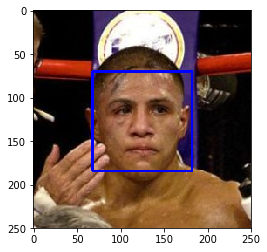

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the
images to grayscale. The `detectMultiScale` function executes the classifier
stored in `face_cascade` and takes the grayscale image as a parameter.

In the above code, `faces` is a numpy array of detected faces, where each row
corresponds to a detected face. Each detected face is a 1D array with four
entries that specifies the bounding box of the detected face. The first two
entries in the array (extracted in the above code as `x` and `y`) specify the
horizontal and vertical positions of the top left corner of the bounding box.
The last two entries in the array (extracted here as `w` and `h`) specify the
width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human
face is detected in an image and `False` otherwise. This function, aptly named
`face_detector`, takes a string-valued file path to an image as input and
appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the
`face_detector` function.
- What percentage of the first 100 images in `human_files` have a detected human
  face? 
- What percentage of the first 100 images in `dog_files` have a detected human
  face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog
images with a detected face. You will see that our algorithm falls short of this
goal, but still gives acceptable performance. We extract the file paths for the
first 100 images from each of the datasets and store them in the numpy arrays
`human_files_short` and `dog_files_short`.

__Answer:__ 

As we can see in the following code snippet, the algorithm detects human faces
98% of pictures with human in them, whereas it detects 11% of human faces in
dog pictures.
 

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

In [6]:
human_classifiation = [face_detector(img_path) for img_path in human_files_short]
dog_classifiation = [face_detector(img_path) for img_path in dog_files_short]

n = len(human_classifiation)
human_rate = sum(human_classifiation)*1.0/n

n = len(dog_classifiation)
dog_rate = sum(dog_classifiation)*1.0/n

print("Rate of human recognition in human pictures in percent: ", 100*human_rate)
print("Rate of human recognition in dog pictures in percent: ", 100*dog_rate)

Rate of human recognition in human pictures in percent:  98.0
Rate of human recognition in dog pictures in percent:  11.0


__Question 2:__ This algorithmic choice necessitates that we communicate to the
user that we accept human images only when they provide a clear view of a face
(otherwise, we risk having unneccessarily frustrated users!). In your opinion,
is this a reasonable expectation to pose on the user? If not, can you think of a
way to detect humans in images that does not necessitate an image with a clearly
presented face?

__Answer:__

This is not a unreasonable expectation to ask to the user. The justification is
users are accustomed to such constraints (for photo pass, selfies and others
apps). Moreover, most users will want to provide clear pictures of themselves,
and when they provide dark and blurry pictures, the users might be amused with
the results of the app, as long as the user can understand that an algorithm can
fail at some questionable input.

If we wanted to improve the algorithm, we could implemented object localization
algorithm where ConvNets are trained with targets combines classification and
objects localization in the pictures.

__End of Answer__

We suggest the face detector from OpenCV as a potential way to detect human
images in your algorithm, but you are free to explore other approaches,
especially approaches that make use of deep learning :). Please use the code
cell below to design and test your own face detection algorithm. If you decide
to pursue this _optional_ task, report performance on each of the datasets.

In [7]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained
[ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006)
model to detect dogs in images. Our first line of code downloads the ResNet-50
model, along with weights that have been trained on
[ImageNet](http://www.image-net.org/), a very large, very popular dataset used
for image classification and other vision tasks. ImageNet contains over 10
million URLs, each linking to an image containing an object from one of [1000
categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). Given an
image, this pre-trained ResNet-50 model returns a prediction (derived from the
available categories in ImageNet) for the object that is contained in the image.

In [8]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll
also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and
`rows`, `columns`, and `channels` correspond to the number of rows, columns, and
channels for each image, respectively.

The `path_to_tensor` function below takes a string-valued file path to a color
image as input and returns a 4D tensor suitable for supplying to a Keras CNN.
The function first loads the image and resizes it to a square image that is $224
\times 224$ pixels. Next, the image is converted to an array, which is then
resized to a 4D tensor. In this case, since we are working with color images,
each image has three channels. Likewise, since we are processing a single image
(or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths
as input and returns a 4D tensor with shape

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the
supplied array of image paths. It is best to think of `nb_samples` as the number
of 3D tensors (where each 3D tensor corresponds to a different image) in your
dataset!

In [9]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model
in Keras, requires some additional processing. First, the RGB image is converted
to BGR by reordering the channels. All pre-trained models have the additional
normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779,
123.68]$ and calculated from all pixels in all images in ImageNet) must be
subtracted from every pixel in each image. This is implemented in the imported
function `preprocess_input`. If you're curious, you can check the code for
`preprocess_input`
[here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are
now ready to use the model to extract the predictions. This is accomplished with
the `predict` method, which returns an array whose $i$-th entry is the model's
predicted probability that the image belongs to the $i$-th ImageNet category.
This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer
corresponding to the model's predicted object class, which we can identify with
an object category through the use of this
[dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

In [10]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [12]:
human_classifiation = [dog_detector(img_path) for img_path in human_files_short]
dog_classifiation = [dog_detector(img_path) for img_path in dog_files_short]

n = len(human_classifiation)
human_rate = sum(human_classifiation)*1.0/n

n = len(dog_classifiation)
dog_rate = sum(dog_classifiation)*1.0/n

print("Rate of dog recognition in human pictures in percent: ", 100*human_rate)
print("Rate of dog recognition in dog pictures in percent: ", 100*dog_rate)

Rate of dog recognition in human pictures in percent:  1.0
Rate of dog recognition in dog pictures in percent:  100.0


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a
way to predict breed from images. In this step, you will create a CNN that
classifies dog breeds. You must create your CNN _from scratch_ (so, you can't
use transfer learning _yet_!), and you must attain a test accuracy of at least
1%. In Step 5 of this notebook, you will have the opportunity to use transfer
learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers! More parameters means longer
training, which means you are more likely to need a GPU to accelerate the
training process. Thankfully, Keras provides a handy estimate of the time that
each epoch is likely to take; you can extrapolate this estimate to figure out
how long it will take for your algorithm to train.

We mention that the task of assigning breed to dogs from images is considered
exceptionally challenging. To see why, consider that *even a human* would have
great difficulty in distinguishing between a Brittany and a Welsh Springer
Spaniel.

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class
variation (for instance, Curly-Coated Retrievers and American Water Spaniels).

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black. Your
vision-based algorithm will have to conquer this high intra-class variation to
determine how to classify all of these different shades as the same breed.

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting
aside the fact that the classes are slightly imabalanced, a random guess will
provide a correct answer roughly 1 in 133 times, which corresponds to an
accuracy of less than 1%.

Remember that the practice is far ahead of the theory in deep learning.
Experiment with many different architectures, and trust your intuition. And, of
course, have fun!

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [13]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

  0%|          | 0/6680 [00:00<?, ?it/s]

  0%|          | 24/6680 [00:00<00:28, 232.66it/s]

  0%|          | 31/6680 [00:00<00:46, 143.62it/s]

  1%|          | 55/6680 [00:00<00:38, 172.27it/s]

  1%|          | 67/6680 [00:00<00:42, 155.87it/s]

  1%|▏         | 86/6680 [00:00<00:41, 160.70it/s]

  2%|▏         | 101/6680 [00:00<00:41, 157.80it/s]

  2%|▏         | 122/6680 [00:00<00:39, 164.22it/s]

  2%|▏         | 140/6680 [00:00<00:39, 165.73it/s]

  2%|▏         | 157/6680 [00:01<00:46, 140.04it/s]

  3%|▎         | 175/6680 [00:01<00:46, 138.52it/s]

  3%|▎         | 200/6680 [00:01<00:44, 146.20it/s]

  3%|▎         | 218/6680 [00:01<00:44, 145.33it/s]

  4%|▎         | 235/6680 [00:01<00:44, 144.18it/s]

  4%|▍         | 256/6680 [00:01<00:43, 147.90it/s]

  4%|▍         | 273/6680 [00:01<00:45, 141.06it/s]

  4%|▍         | 296/6680 [00:02<00:44, 144.74it/s]

  5%|▍         | 313/6680 [00:02<00:44, 143.30it/s]

  5%|▌         | 338/6680 [00:02<00:42, 147.57it/s]

  5%|▌         | 358/6680 [00:02<00:42, 149.74it/s]

  6%|▌         | 377/6680 [00:02<00:44, 140.33it/s]

  6%|▌         | 392/6680 [00:02<00:46, 136.42it/s]

  6%|▌         | 406/6680 [00:02<00:46, 136.36it/s]

  6%|▋         | 425/6680 [00:03<00:45, 137.21it/s]

  7%|▋         | 447/6680 [00:03<00:46, 134.76it/s]

  7%|▋         | 460/6680 [00:03<00:46, 132.53it/s]

  7%|▋         | 478/6680 [00:03<00:46, 133.67it/s]

  7%|▋         | 492/6680 [00:03<00:48, 128.40it/s]

  8%|▊         | 514/6680 [00:03<00:47, 130.60it/s]

  8%|▊         | 528/6680 [00:04<00:47, 130.43it/s]

  8%|▊         | 544/6680 [00:04<00:47, 129.07it/s]

  8%|▊         | 562/6680 [00:04<00:46, 130.22it/s]

  9%|▊         | 576/6680 [00:04<00:47, 128.93it/s]

  9%|▉         | 589/6680 [00:04<00:47, 128.19it/s]

  9%|▉         | 611/6680 [00:04<00:46, 130.03it/s]

  9%|▉         | 629/6680 [00:04<00:46, 130.62it/s]

 10%|▉         | 644/6680 [00:04<00:46, 129.55it/s]

 10%|▉         | 663/6680 [00:05<00:46, 130.32it/s]

 10%|█         | 686/6680 [00:05<00:45, 132.20it/s]

 11%|█         | 704/6680 [00:05<00:44, 133.06it/s]

 11%|█         | 722/6680 [00:05<00:45, 131.90it/s]

 11%|█         | 742/6680 [00:05<00:44, 132.91it/s]

 11%|█▏        | 758/6680 [00:05<00:44, 132.65it/s]

 12%|█▏        | 781/6680 [00:05<00:43, 134.27it/s]

 12%|█▏        | 806/6680 [00:05<00:43, 135.74it/s]

 12%|█▏        | 825/6680 [00:06<00:43, 134.69it/s]

 13%|█▎        | 841/6680 [00:06<00:43, 135.01it/s]

 13%|█▎        | 860/6680 [00:06<00:42, 135.87it/s]

 13%|█▎        | 877/6680 [00:06<00:42, 135.88it/s]

 13%|█▎        | 894/6680 [00:06<00:42, 136.00it/s]

 14%|█▎        | 910/6680 [00:06<00:43, 133.00it/s]

 14%|█▍        | 923/6680 [00:06<00:43, 132.89it/s]

 14%|█▍        | 940/6680 [00:07<00:43, 133.37it/s]

 14%|█▍        | 960/6680 [00:07<00:42, 134.19it/s]

 15%|█▍        | 976/6680 [00:07<00:43, 131.93it/s]

 15%|█▍        | 998/6680 [00:07<00:42, 132.98it/s]

 15%|█▌        | 1014/6680 [00:07<00:42, 132.60it/s]

 15%|█▌        | 1028/6680 [00:07<00:42, 131.54it/s]

 16%|█▌        | 1041/6680 [00:07<00:43, 130.70it/s]

 16%|█▌        | 1063/6680 [00:08<00:42, 131.64it/s]

 16%|█▌        | 1077/6680 [00:08<00:42, 131.62it/s]

 16%|█▋        | 1096/6680 [00:08<00:42, 132.29it/s]

 17%|█▋        | 1112/6680 [00:08<00:41, 132.59it/s]

 17%|█▋        | 1128/6680 [00:08<00:42, 129.68it/s]

 17%|█▋        | 1150/6680 [00:08<00:42, 130.43it/s]

 17%|█▋        | 1165/6680 [00:08<00:42, 130.29it/s]

 18%|█▊        | 1179/6680 [00:09<00:42, 129.80it/s]

 18%|█▊        | 1197/6680 [00:09<00:42, 130.19it/s]

 18%|█▊        | 1211/6680 [00:09<00:42, 129.54it/s]

 18%|█▊        | 1226/6680 [00:09<00:42, 129.68it/s]

 19%|█▊        | 1245/6680 [00:09<00:41, 130.28it/s]

 19%|█▉        | 1260/6680 [00:09<00:41, 129.47it/s]

 19%|█▉        | 1277/6680 [00:09<00:41, 129.86it/s]

 20%|█▉        | 1303/6680 [00:09<00:40, 131.16it/s]

 20%|█▉        | 1327/6680 [00:10<00:40, 131.84it/s]

 20%|██        | 1345/6680 [00:10<00:40, 130.92it/s]

 20%|██        | 1361/6680 [00:10<00:40, 130.21it/s]

 21%|██        | 1380/6680 [00:10<00:40, 130.76it/s]

 21%|██        | 1395/6680 [00:10<00:40, 130.44it/s]

 21%|██        | 1409/6680 [00:10<00:40, 130.14it/s]

 21%|██▏       | 1423/6680 [00:10<00:40, 130.22it/s]

 22%|██▏       | 1444/6680 [00:11<00:39, 130.91it/s]

 22%|██▏       | 1460/6680 [00:11<00:40, 130.21it/s]

 22%|██▏       | 1482/6680 [00:11<00:39, 130.88it/s]

 23%|██▎       | 1506/6680 [00:11<00:39, 131.78it/s]

 23%|██▎       | 1528/6680 [00:11<00:38, 132.26it/s]

 23%|██▎       | 1547/6680 [00:11<00:38, 132.47it/s]

 23%|██▎       | 1564/6680 [00:11<00:38, 132.53it/s]

 24%|██▎       | 1580/6680 [00:11<00:38, 131.81it/s]

 24%|██▍       | 1594/6680 [00:12<00:38, 131.29it/s]

 24%|██▍       | 1608/6680 [00:12<00:38, 131.06it/s]

 24%|██▍       | 1623/6680 [00:12<00:38, 131.21it/s]

 25%|██▍       | 1639/6680 [00:12<00:38, 131.42it/s]

 25%|██▍       | 1662/6680 [00:12<00:37, 132.18it/s]

 25%|██▌       | 1680/6680 [00:12<00:38, 131.40it/s]

 25%|██▌       | 1694/6680 [00:12<00:37, 131.26it/s]

 26%|██▌       | 1716/6680 [00:13<00:37, 131.93it/s]

 26%|██▌       | 1732/6680 [00:13<00:37, 131.68it/s]

 26%|██▋       | 1754/6680 [00:13<00:37, 132.34it/s]

 27%|██▋       | 1771/6680 [00:13<00:37, 132.55it/s]

 27%|██▋       | 1788/6680 [00:13<00:36, 132.53it/s]

 27%|██▋       | 1813/6680 [00:13<00:36, 133.37it/s]

 27%|██▋       | 1832/6680 [00:13<00:36, 133.08it/s]

 28%|██▊       | 1849/6680 [00:13<00:36, 133.34it/s]

 28%|██▊       | 1866/6680 [00:14<00:36, 133.18it/s]

 28%|██▊       | 1881/6680 [00:14<00:36, 133.28it/s]

 28%|██▊       | 1897/6680 [00:14<00:36, 132.78it/s]

 29%|██▉       | 1923/6680 [00:14<00:35, 133.64it/s]

 29%|██▉       | 1940/6680 [00:14<00:35, 133.46it/s]

 29%|██▉       | 1963/6680 [00:14<00:35, 134.08it/s]

 30%|██▉       | 1984/6680 [00:14<00:34, 134.59it/s]

 30%|██▉       | 2003/6680 [00:14<00:34, 134.66it/s]

 30%|███       | 2021/6680 [00:15<00:35, 130.90it/s]

 31%|███       | 2039/6680 [00:15<00:35, 131.20it/s]

 31%|███       | 2054/6680 [00:15<00:35, 131.14it/s]

 31%|███       | 2069/6680 [00:15<00:35, 131.18it/s]

 31%|███       | 2084/6680 [00:15<00:35, 131.27it/s]

 31%|███▏      | 2103/6680 [00:16<00:34, 131.30it/s]

 32%|███▏      | 2125/6680 [00:16<00:34, 131.84it/s]

 32%|███▏      | 2149/6680 [00:16<00:34, 132.13it/s]

 32%|███▏      | 2169/6680 [00:16<00:34, 132.51it/s]

 33%|███▎      | 2187/6680 [00:16<00:33, 132.44it/s]

 33%|███▎      | 2205/6680 [00:16<00:33, 132.70it/s]

 33%|███▎      | 2222/6680 [00:16<00:33, 132.61it/s]

 34%|███▎      | 2248/6680 [00:16<00:33, 133.33it/s]

 34%|███▍      | 2267/6680 [00:17<00:33, 131.73it/s]

 34%|███▍      | 2288/6680 [00:17<00:33, 132.17it/s]

 35%|███▍      | 2305/6680 [00:17<00:33, 132.27it/s]

 35%|███▍      | 2321/6680 [00:17<00:33, 131.95it/s]

 35%|███▍      | 2335/6680 [00:17<00:33, 131.34it/s]

 35%|███▌      | 2348/6680 [00:17<00:33, 130.74it/s]

 35%|███▌      | 2359/6680 [00:18<00:33, 130.40it/s]

 36%|███▌      | 2375/6680 [00:18<00:32, 130.56it/s]

 36%|███▌      | 2399/6680 [00:18<00:32, 131.15it/s]

 36%|███▌      | 2416/6680 [00:18<00:32, 131.34it/s]

 36%|███▋      | 2433/6680 [00:18<00:32, 131.51it/s]

 37%|███▋      | 2454/6680 [00:18<00:32, 131.53it/s]

 37%|███▋      | 2470/6680 [00:18<00:32, 131.30it/s]

 37%|███▋      | 2491/6680 [00:18<00:31, 131.68it/s]

 38%|███▊      | 2514/6680 [00:19<00:31, 132.16it/s]

 38%|███▊      | 2534/6680 [00:19<00:31, 132.37it/s]

 38%|███▊      | 2553/6680 [00:19<00:31, 132.65it/s]

 38%|███▊      | 2571/6680 [00:19<00:31, 132.31it/s]

 39%|███▊      | 2587/6680 [00:19<00:30, 132.32it/s]

 39%|███▉      | 2606/6680 [00:19<00:30, 132.59it/s]

 39%|███▉      | 2622/6680 [00:19<00:30, 132.55it/s]

 39%|███▉      | 2637/6680 [00:19<00:30, 132.49it/s]

 40%|███▉      | 2652/6680 [00:20<00:30, 132.44it/s]

 40%|███▉      | 2666/6680 [00:20<00:30, 132.30it/s]

 40%|████      | 2683/6680 [00:20<00:30, 132.40it/s]

 41%|████      | 2707/6680 [00:20<00:30, 132.23it/s]

 41%|████      | 2725/6680 [00:20<00:29, 132.46it/s]

 41%|████      | 2747/6680 [00:20<00:29, 132.87it/s]

 41%|████▏     | 2769/6680 [00:20<00:29, 133.28it/s]

 42%|████▏     | 2788/6680 [00:20<00:29, 133.11it/s]

 42%|████▏     | 2805/6680 [00:21<00:29, 131.99it/s]

 42%|████▏     | 2822/6680 [00:21<00:29, 132.16it/s]

 43%|████▎     | 2844/6680 [00:21<00:28, 132.56it/s]

 43%|████▎     | 2861/6680 [00:21<00:28, 132.46it/s]

 43%|████▎     | 2876/6680 [00:21<00:28, 131.88it/s]

 43%|████▎     | 2894/6680 [00:21<00:28, 132.07it/s]

 44%|████▎     | 2909/6680 [00:22<00:28, 131.28it/s]

 44%|████▍     | 2930/6680 [00:22<00:28, 131.56it/s]

 44%|████▍     | 2952/6680 [00:22<00:28, 131.95it/s]

 45%|████▍     | 2974/6680 [00:22<00:28, 132.23it/s]

 45%|████▍     | 2991/6680 [00:22<00:27, 132.14it/s]

 45%|████▌     | 3007/6680 [00:22<00:27, 132.23it/s]

 45%|████▌     | 3028/6680 [00:22<00:27, 132.54it/s]

 46%|████▌     | 3047/6680 [00:22<00:27, 132.75it/s]

 46%|████▌     | 3065/6680 [00:23<00:27, 132.37it/s]

 46%|████▌     | 3083/6680 [00:23<00:27, 132.58it/s]

 46%|████▋     | 3099/6680 [00:23<00:27, 132.15it/s]

 47%|████▋     | 3113/6680 [00:23<00:27, 131.45it/s]

 47%|████▋     | 3125/6680 [00:23<00:27, 131.33it/s]

 47%|████▋     | 3143/6680 [00:23<00:26, 131.52it/s]

 47%|████▋     | 3156/6680 [00:24<00:26, 131.27it/s]

 47%|████▋     | 3168/6680 [00:24<00:26, 130.93it/s]

 48%|████▊     | 3184/6680 [00:24<00:26, 130.84it/s]

 48%|████▊     | 3195/6680 [00:24<00:26, 130.47it/s]

 48%|████▊     | 3213/6680 [00:24<00:26, 130.63it/s]

 48%|████▊     | 3226/6680 [00:24<00:26, 129.86it/s]

 49%|████▊     | 3247/6680 [00:24<00:26, 130.15it/s]

 49%|████▉     | 3261/6680 [00:25<00:26, 130.16it/s]

 49%|████▉     | 3274/6680 [00:25<00:26, 129.59it/s]

 49%|████▉     | 3292/6680 [00:25<00:26, 129.70it/s]

 50%|████▉     | 3312/6680 [00:25<00:25, 129.96it/s]

 50%|████▉     | 3327/6680 [00:25<00:25, 129.93it/s]

 50%|█████     | 3341/6680 [00:25<00:25, 129.69it/s]

 50%|█████     | 3363/6680 [00:25<00:25, 130.03it/s]

 51%|█████     | 3379/6680 [00:25<00:25, 130.12it/s]

 51%|█████     | 3397/6680 [00:26<00:25, 129.74it/s]

 51%|█████     | 3417/6680 [00:26<00:25, 129.99it/s]

 51%|█████▏    | 3433/6680 [00:26<00:24, 130.09it/s]

 52%|█████▏    | 3449/6680 [00:26<00:24, 129.95it/s]

 52%|█████▏    | 3469/6680 [00:26<00:24, 130.21it/s]

 52%|█████▏    | 3491/6680 [00:26<00:24, 130.46it/s]

 53%|█████▎    | 3512/6680 [00:26<00:24, 130.67it/s]

 53%|█████▎    | 3529/6680 [00:27<00:24, 130.59it/s]

 53%|█████▎    | 3545/6680 [00:27<00:24, 130.31it/s]

 53%|█████▎    | 3569/6680 [00:27<00:23, 130.70it/s]

 54%|█████▍    | 3592/6680 [00:27<00:23, 131.05it/s]

 54%|█████▍    | 3615/6680 [00:27<00:23, 131.36it/s]

 54%|█████▍    | 3637/6680 [00:27<00:23, 131.67it/s]

 55%|█████▍    | 3660/6680 [00:27<00:22, 132.02it/s]

 55%|█████▌    | 3681/6680 [00:27<00:22, 131.95it/s]

 55%|█████▌    | 3700/6680 [00:28<00:22, 132.03it/s]

 56%|█████▌    | 3718/6680 [00:28<00:22, 131.90it/s]

 56%|█████▌    | 3741/6680 [00:28<00:22, 132.22it/s]

 56%|█████▋    | 3759/6680 [00:28<00:22, 132.34it/s]

 57%|█████▋    | 3776/6680 [00:28<00:21, 132.24it/s]

 57%|█████▋    | 3792/6680 [00:28<00:21, 132.29it/s]

 57%|█████▋    | 3808/6680 [00:28<00:21, 132.10it/s]

 57%|█████▋    | 3826/6680 [00:28<00:21, 132.07it/s]

 58%|█████▊    | 3853/6680 [00:29<00:21, 132.50it/s]

 58%|█████▊    | 3870/6680 [00:29<00:21, 132.29it/s]

 58%|█████▊    | 3896/6680 [00:29<00:20, 132.69it/s]

 59%|█████▊    | 3914/6680 [00:29<00:20, 131.83it/s]

 59%|█████▉    | 3928/6680 [00:29<00:20, 131.63it/s]

 59%|█████▉    | 3941/6680 [00:29<00:20, 131.48it/s]

 59%|█████▉    | 3962/6680 [00:30<00:20, 131.74it/s]

 60%|█████▉    | 3979/6680 [00:30<00:20, 131.82it/s]

 60%|█████▉    | 3994/6680 [00:30<00:20, 131.87it/s]

 60%|██████    | 4017/6680 [00:30<00:20, 132.17it/s]

 60%|██████    | 4040/6680 [00:30<00:19, 132.47it/s]

 61%|██████    | 4059/6680 [00:30<00:19, 132.54it/s]

 61%|██████    | 4079/6680 [00:30<00:19, 132.76it/s]

 61%|██████▏   | 4098/6680 [00:30<00:19, 132.47it/s]

 62%|██████▏   | 4114/6680 [00:31<00:19, 132.54it/s]

 62%|██████▏   | 4130/6680 [00:31<00:19, 132.54it/s]

 62%|██████▏   | 4145/6680 [00:31<00:19, 132.50it/s]

 62%|██████▏   | 4161/6680 [00:31<00:18, 132.58it/s]

 63%|██████▎   | 4176/6680 [00:31<00:18, 132.26it/s]

 63%|██████▎   | 4194/6680 [00:31<00:18, 132.41it/s]

 63%|██████▎   | 4209/6680 [00:31<00:18, 132.00it/s]

 63%|██████▎   | 4229/6680 [00:31<00:18, 132.20it/s]

 64%|██████▎   | 4246/6680 [00:32<00:18, 132.24it/s]

 64%|██████▍   | 4261/6680 [00:32<00:18, 131.98it/s]

 64%|██████▍   | 4285/6680 [00:32<00:18, 132.24it/s]

 64%|██████▍   | 4300/6680 [00:32<00:18, 132.06it/s]

 65%|██████▍   | 4323/6680 [00:32<00:17, 132.36it/s]

 65%|██████▌   | 4346/6680 [00:32<00:17, 132.65it/s]

 65%|██████▌   | 4365/6680 [00:32<00:17, 132.47it/s]

 66%|██████▌   | 4381/6680 [00:33<00:17, 132.31it/s]

 66%|██████▌   | 4405/6680 [00:33<00:17, 132.63it/s]

 66%|██████▌   | 4422/6680 [00:33<00:17, 132.20it/s]

 67%|██████▋   | 4443/6680 [00:33<00:16, 132.43it/s]

 67%|██████▋   | 4465/6680 [00:33<00:16, 132.67it/s]

 67%|██████▋   | 4483/6680 [00:33<00:16, 132.49it/s]

 67%|██████▋   | 4500/6680 [00:33<00:16, 132.59it/s]

 68%|██████▊   | 4516/6680 [00:34<00:16, 132.63it/s]

 68%|██████▊   | 4532/6680 [00:34<00:16, 132.51it/s]

 68%|██████▊   | 4546/6680 [00:34<00:16, 131.80it/s]

 68%|██████▊   | 4564/6680 [00:34<00:16, 131.92it/s]

 69%|██████▊   | 4586/6680 [00:34<00:15, 132.17it/s]

 69%|██████▉   | 4607/6680 [00:34<00:15, 132.39it/s]

 69%|██████▉   | 4625/6680 [00:34<00:15, 132.37it/s]

 69%|██████▉   | 4641/6680 [00:35<00:15, 132.35it/s]

 70%|██████▉   | 4661/6680 [00:35<00:15, 132.54it/s]

 70%|███████   | 4678/6680 [00:35<00:15, 132.40it/s]

 70%|███████   | 4693/6680 [00:35<00:15, 132.30it/s]

 71%|███████   | 4712/6680 [00:35<00:14, 132.45it/s]

 71%|███████   | 4738/6680 [00:35<00:14, 132.78it/s]

 71%|███████   | 4756/6680 [00:35<00:14, 132.63it/s]

 71%|███████▏  | 4776/6680 [00:35<00:14, 132.80it/s]

 72%|███████▏  | 4795/6680 [00:36<00:14, 132.91it/s]

 72%|███████▏  | 4812/6680 [00:36<00:14, 132.85it/s]

 72%|███████▏  | 4831/6680 [00:36<00:13, 133.00it/s]

 73%|███████▎  | 4852/6680 [00:36<00:13, 133.19it/s]

 73%|███████▎  | 4870/6680 [00:36<00:13, 133.17it/s]

 73%|███████▎  | 4886/6680 [00:36<00:13, 133.02it/s]

 73%|███████▎  | 4906/6680 [00:36<00:13, 133.20it/s]

 74%|███████▎  | 4925/6680 [00:36<00:13, 133.34it/s]

 74%|███████▍  | 4945/6680 [00:37<00:12, 133.51it/s]

 74%|███████▍  | 4964/6680 [00:37<00:12, 133.64it/s]

 75%|███████▍  | 4986/6680 [00:37<00:12, 133.87it/s]

 75%|███████▍  | 5005/6680 [00:37<00:12, 133.90it/s]

 75%|███████▌  | 5029/6680 [00:37<00:12, 134.16it/s]

 76%|███████▌  | 5049/6680 [00:37<00:12, 134.30it/s]

 76%|███████▌  | 5068/6680 [00:37<00:11, 134.38it/s]

 76%|███████▌  | 5086/6680 [00:37<00:11, 134.18it/s]

 76%|███████▋  | 5102/6680 [00:38<00:11, 134.21it/s]

 77%|███████▋  | 5118/6680 [00:38<00:11, 133.55it/s]

 77%|███████▋  | 5131/6680 [00:38<00:11, 133.39it/s]

 77%|███████▋  | 5152/6680 [00:38<00:11, 133.57it/s]

 77%|███████▋  | 5169/6680 [00:38<00:11, 133.62it/s]

 78%|███████▊  | 5184/6680 [00:38<00:11, 133.65it/s]

 78%|███████▊  | 5203/6680 [00:38<00:11, 133.78it/s]

 78%|███████▊  | 5224/6680 [00:38<00:10, 133.96it/s]

 78%|███████▊  | 5243/6680 [00:39<00:10, 134.10it/s]

 79%|███████▉  | 5261/6680 [00:39<00:10, 134.13it/s]

 79%|███████▉  | 5278/6680 [00:39<00:10, 134.18it/s]

 79%|███████▉  | 5295/6680 [00:39<00:10, 133.90it/s]

 80%|███████▉  | 5317/6680 [00:39<00:10, 134.11it/s]

 80%|███████▉  | 5334/6680 [00:39<00:10, 134.17it/s]

 80%|████████  | 5350/6680 [00:39<00:09, 134.12it/s]

 80%|████████  | 5371/6680 [00:39<00:09, 134.31it/s]

 81%|████████  | 5388/6680 [00:40<00:09, 134.27it/s]

 81%|████████  | 5406/6680 [00:40<00:09, 134.38it/s]

 81%|████████  | 5423/6680 [00:40<00:09, 134.36it/s]

 81%|████████▏ | 5441/6680 [00:40<00:09, 134.32it/s]

 82%|████████▏ | 5463/6680 [00:40<00:09, 134.52it/s]

 82%|████████▏ | 5488/6680 [00:40<00:08, 134.80it/s]

 82%|████████▏ | 5507/6680 [00:40<00:08, 134.77it/s]

 83%|████████▎ | 5525/6680 [00:40<00:08, 134.83it/s]

 83%|████████▎ | 5549/6680 [00:41<00:08, 135.08it/s]

 83%|████████▎ | 5571/6680 [00:41<00:08, 135.28it/s]

 84%|████████▎ | 5591/6680 [00:41<00:08, 134.66it/s]

 84%|████████▍ | 5607/6680 [00:41<00:07, 134.70it/s]

 84%|████████▍ | 5625/6680 [00:41<00:07, 134.81it/s]

 84%|████████▍ | 5642/6680 [00:41<00:07, 134.79it/s]

 85%|████████▍ | 5658/6680 [00:42<00:07, 134.61it/s]

 85%|████████▍ | 5672/6680 [00:42<00:07, 134.62it/s]

 85%|████████▌ | 5691/6680 [00:42<00:07, 134.74it/s]

 85%|████████▌ | 5706/6680 [00:42<00:07, 134.37it/s]

 86%|████████▌ | 5726/6680 [00:42<00:07, 134.52it/s]

 86%|████████▌ | 5743/6680 [00:42<00:06, 134.60it/s]

 86%|████████▌ | 5759/6680 [00:42<00:06, 134.66it/s]

 87%|████████▋ | 5782/6680 [00:42<00:06, 134.87it/s]

 87%|████████▋ | 5800/6680 [00:42<00:06, 134.89it/s]

 87%|████████▋ | 5822/6680 [00:43<00:06, 135.08it/s]

 87%|████████▋ | 5840/6680 [00:43<00:06, 134.98it/s]

 88%|████████▊ | 5856/6680 [00:43<00:06, 134.64it/s]

 88%|████████▊ | 5870/6680 [00:43<00:06, 134.60it/s]

 88%|████████▊ | 5890/6680 [00:43<00:05, 134.74it/s]

 88%|████████▊ | 5911/6680 [00:43<00:05, 134.91it/s]

 89%|████████▉ | 5929/6680 [00:43<00:05, 135.00it/s]

 89%|████████▉ | 5946/6680 [00:44<00:05, 134.90it/s]

 89%|████████▉ | 5966/6680 [00:44<00:05, 135.05it/s]

 90%|████████▉ | 5983/6680 [00:44<00:05, 134.83it/s]

 90%|████████▉ | 6006/6680 [00:44<00:04, 135.04it/s]

 90%|█████████ | 6029/6680 [00:44<00:04, 135.25it/s]

 91%|█████████ | 6049/6680 [00:44<00:04, 135.36it/s]

 91%|█████████ | 6068/6680 [00:44<00:04, 135.33it/s]

 91%|█████████ | 6085/6680 [00:44<00:04, 135.38it/s]

 91%|█████████▏| 6108/6680 [00:45<00:04, 135.59it/s]

 92%|█████████▏| 6128/6680 [00:45<00:04, 135.73it/s]

 92%|█████████▏| 6147/6680 [00:45<00:03, 135.78it/s]

 92%|█████████▏| 6165/6680 [00:45<00:03, 135.58it/s]

 93%|█████████▎| 6181/6680 [00:45<00:03, 135.46it/s]

 93%|█████████▎| 6202/6680 [00:45<00:03, 135.62it/s]

 93%|█████████▎| 6218/6680 [00:45<00:03, 135.39it/s]

 93%|█████████▎| 6232/6680 [00:46<00:03, 135.36it/s]

 94%|█████████▎| 6252/6680 [00:46<00:03, 135.49it/s]

 94%|█████████▍| 6268/6680 [00:46<00:03, 135.53it/s]

 94%|█████████▍| 6284/6680 [00:46<00:02, 135.36it/s]

 94%|█████████▍| 6301/6680 [00:46<00:02, 135.42it/s]

 95%|█████████▍| 6316/6680 [00:46<00:02, 135.33it/s]

 95%|█████████▍| 6330/6680 [00:46<00:02, 135.30it/s]

 95%|█████████▌| 6347/6680 [00:46<00:02, 135.37it/s]

 95%|█████████▌| 6362/6680 [00:46<00:02, 135.39it/s]

 95%|█████████▌| 6377/6680 [00:47<00:02, 135.16it/s]

 96%|█████████▌| 6394/6680 [00:47<00:02, 135.23it/s]

 96%|█████████▌| 6408/6680 [00:47<00:02, 134.76it/s]

 96%|█████████▌| 6420/6680 [00:47<00:01, 134.48it/s]

 96%|█████████▋| 6441/6680 [00:47<00:01, 134.63it/s]

 97%|█████████▋| 6456/6680 [00:47<00:01, 134.65it/s]

 97%|█████████▋| 6470/6680 [00:48<00:01, 134.59it/s]

 97%|█████████▋| 6494/6680 [00:48<00:01, 134.64it/s]

 97%|█████████▋| 6508/6680 [00:48<00:01, 134.38it/s]

 98%|█████████▊| 6520/6680 [00:48<00:01, 134.00it/s]

 98%|█████████▊| 6530/6680 [00:48<00:01, 133.78it/s]

 98%|█████████▊| 6543/6680 [00:48<00:01, 133.75it/s]

 98%|█████████▊| 6559/6680 [00:49<00:00, 133.79it/s]

 98%|█████████▊| 6576/6680 [00:49<00:00, 133.86it/s]

 99%|█████████▉| 6597/6680 [00:49<00:00, 134.01it/s]

 99%|█████████▉| 6613/6680 [00:49<00:00, 133.93it/s]

 99%|█████████▉| 6628/6680 [00:49<00:00, 133.96it/s]

 99%|█████████▉| 6643/6680 [00:49<00:00, 133.84it/s]

100%|█████████▉| 6656/6680 [00:49<00:00, 133.54it/s]

100%|█████████▉| 6672/6680 [00:50<00:00, 133.28it/s]

100%|██████████| 6680/6680 [00:50<00:00, 133.33it/s]

  0%|          | 0/835 [00:00<?, ?it/s]

  0%|          | 3/835 [00:00<00:34, 24.23it/s]

  2%|▏         | 19/835 [00:00<00:09, 83.74it/s]

  4%|▍         | 37/835 [00:00<00:07, 112.70it/s]

  6%|▋         | 53/835 [00:00<00:06, 122.31it/s]

  8%|▊         | 70/835 [00:00<00:05, 130.07it/s]

 10%|█         | 84/835 [00:00<00:05, 130.09it/s]

 12%|█▏        | 101/835 [00:00<00:05, 126.05it/s]

 14%|█▎        | 114/835 [00:00<00:06, 120.14it/s]

 15%|█▌        | 126/835 [00:01<00:06, 110.93it/s]

 17%|█▋        | 143/835 [00:01<00:05, 115.39it/s]

 19%|█▉        | 159/835 [00:01<00:05, 118.40it/s]

 21%|██        | 172/835 [00:01<00:05, 118.46it/s]

 23%|██▎       | 191/835 [00:01<00:05, 122.92it/s]

 25%|██▍       | 208/835 [00:01<00:05, 125.30it/s]

 27%|██▋       | 223/835 [00:01<00:04, 126.22it/s]

 29%|██▉       | 242/835 [00:01<00:04, 129.11it/s]

 31%|███       | 258/835 [00:02<00:04, 127.05it/s]

 33%|███▎      | 272/835 [00:02<00:04, 126.25it/s]

 36%|███▌      | 297/835 [00:02<00:04, 131.61it/s]

 38%|███▊      | 321/835 [00:02<00:03, 135.51it/s]

 41%|████      | 341/835 [00:02<00:03, 138.02it/s]

 43%|████▎     | 362/835 [00:02<00:03, 140.69it/s]

 46%|████▌     | 382/835 [00:02<00:03, 142.24it/s]

 48%|████▊     | 401/835 [00:02<00:03, 141.93it/s]

 50%|█████     | 421/835 [00:02<00:02, 143.84it/s]

 53%|█████▎    | 443/835 [00:03<00:02, 146.07it/s]

 56%|█████▌    | 465/835 [00:03<00:02, 148.02it/s]

 58%|█████▊    | 485/835 [00:03<00:02, 148.85it/s]

 61%|██████    | 507/835 [00:03<00:02, 150.63it/s]

 63%|██████▎   | 527/835 [00:03<00:02, 145.15it/s]

 65%|██████▌   | 545/835 [00:03<00:01, 145.88it/s]

 68%|██████▊   | 567/835 [00:03<00:01, 147.73it/s]

 70%|███████   | 585/835 [00:03<00:01, 147.94it/s]

 72%|███████▏  | 604/835 [00:04<00:01, 148.95it/s]

 74%|███████▍  | 622/835 [00:04<00:01, 148.49it/s]

 77%|███████▋  | 644/835 [00:04<00:01, 150.02it/s]

 79%|███████▉  | 662/835 [00:04<00:01, 145.97it/s]

 81%|████████  | 677/835 [00:04<00:01, 142.35it/s]

 83%|████████▎ | 694/835 [00:04<00:00, 142.79it/s]

 85%|████████▌ | 713/835 [00:04<00:00, 143.54it/s]

 87%|████████▋ | 729/835 [00:05<00:00, 143.85it/s]

 90%|████████▉ | 749/835 [00:05<00:00, 144.66it/s]

 92%|█████████▏| 766/835 [00:05<00:00, 145.14it/s]

 95%|█████████▍| 790/835 [00:05<00:00, 146.76it/s]

 97%|█████████▋| 811/835 [00:05<00:00, 147.71it/s]

 99%|█████████▉| 830/835 [00:05<00:00, 147.61it/s]

100%|██████████| 835/835 [00:05<00:00, 147.79it/s]

  0%|          | 0/836 [00:00<?, ?it/s]

  3%|▎         | 24/836 [00:00<00:03, 234.61it/s]

  6%|▌         | 47/836 [00:00<00:04, 166.84it/s]

  7%|▋         | 60/836 [00:00<00:05, 155.18it/s]

  9%|▉         | 74/836 [00:00<00:05, 145.17it/s]

 11%|█▏        | 95/836 [00:00<00:04, 154.10it/s]

 13%|█▎        | 112/836 [00:00<00:04, 153.71it/s]

 16%|█▌        | 132/836 [00:00<00:04, 158.74it/s]

 18%|█▊        | 148/836 [00:01<00:04, 144.94it/s]

 20%|█▉        | 167/836 [00:01<00:04, 148.73it/s]

 22%|██▏       | 187/836 [00:01<00:04, 152.24it/s]

 25%|██▌       | 209/836 [00:01<00:03, 156.96it/s]

 27%|██▋       | 228/836 [00:01<00:03, 159.00it/s]

 29%|██▉       | 246/836 [00:01<00:03, 158.46it/s]

 32%|███▏      | 268/836 [00:01<00:03, 161.90it/s]

 34%|███▍      | 287/836 [00:01<00:03, 160.00it/s]

 37%|███▋      | 307/836 [00:01<00:03, 161.77it/s]

 40%|███▉      | 331/836 [00:02<00:03, 165.42it/s]

 42%|████▏     | 352/836 [00:02<00:03, 158.64it/s]

 44%|████▍     | 369/836 [00:02<00:03, 154.65it/s]

 46%|████▋     | 388/836 [00:02<00:02, 155.83it/s]

 49%|████▊     | 407/836 [00:02<00:02, 157.05it/s]

 51%|█████     | 424/836 [00:02<00:02, 157.15it/s]

 53%|█████▎    | 441/836 [00:02<00:02, 155.98it/s]

 55%|█████▍    | 457/836 [00:02<00:02, 153.85it/s]

 57%|█████▋    | 476/836 [00:03<00:02, 154.91it/s]

 59%|█████▉    | 495/836 [00:03<00:02, 155.93it/s]

 62%|██████▏   | 518/836 [00:03<00:02, 158.07it/s]

 64%|██████▍   | 537/836 [00:03<00:01, 155.45it/s]

 67%|██████▋   | 562/836 [00:03<00:01, 158.08it/s]

 69%|██████▉   | 581/836 [00:03<00:01, 151.06it/s]

 73%|███████▎  | 609/836 [00:03<00:01, 154.30it/s]

 75%|███████▌  | 628/836 [00:04<00:01, 153.03it/s]

 77%|███████▋  | 647/836 [00:04<00:01, 150.36it/s]

 79%|███████▉  | 662/836 [00:04<00:01, 145.09it/s]

 82%|████████▏ | 684/836 [00:04<00:01, 146.66it/s]

 84%|████████▎ | 700/836 [00:04<00:00, 145.63it/s]

 85%|████████▌ | 714/836 [00:04<00:00, 144.77it/s]

 88%|████████▊ | 736/836 [00:05<00:00, 146.13it/s]

 90%|█████████ | 754/836 [00:05<00:00, 146.70it/s]

 92%|█████████▏| 771/836 [00:05<00:00, 146.27it/s]

 95%|█████████▍| 791/836 [00:05<00:00, 147.22it/s]

 97%|█████████▋| 815/836 [00:05<00:00, 148.89it/s]

100%|██████████| 836/836 [00:05<00:00, 150.03it/s]

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

In [14]:
print(train_tensors[0].shape)

(224, 224, 3)


In [15]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Add, Activation
from keras.layers import AveragePooling2D, BatchNormalization, Concatenate
from keras.layers import Input
from keras import regularizers

def conv_block(x, filters, dropout_rate=0.0, l2_coeff=1e-4):
    "3x3 conv with filters"
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), padding='same',
               kernel_regularizer = regularizers.l2(l2_coeff))(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    return x


def batchnorm_block(x, l2_coeff=0.0):
    x = BatchNormalization(gamma_regularizer=regularizers.l2(l2_coeff),
                           beta_regularizer=regularizers.l2(l2_coeff))(x)
    return x

def transition_block(x, filters, dropout_rate=0.0, l2_coeff=1e-4):
    x = Conv2D(filters, (1, 1), padding='same',
               kernel_regularizer = regularizers.l2(l2_coeff))(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    x = AveragePooling2D((2, 2), strides=(2, 2))(x)
    x = batchnorm_block(x, l2_coeff)
    return x


def dense_block(x, n_layers, filters, growth_rate, dropout_rate=0.0,
                l2_coeff=1e-4):
    features_list = [x]
    for i in range(n_layers):
        x = conv_block(x, growth_rate, dropout_rate, l2_coeff)
        features_list.append(x)
        x = Concatenate()(features_list)
        filters += growth_rate
    return x, filters


def make_densenet(
        input_layer, depth=40, classes=10, dense_blocks=3, filters=16, growth_rate=12,
        dropout_rate=0.0, l2_coeff=1e-4):

    n_layers = int((depth - 4)/3)
    depth = 3*n_layers + 4

    x = Conv2D(filters, (3, 3))(input_layer)
    x = batchnorm_block(x, l2_coeff)

    for i in range(dense_blocks):
        x, filters = dense_block(x, n_layers, filters, growth_rate,
                                 dropout_rate=dropout_rate, l2_coeff=l2_coeff)
        if i < dense_blocks - 1:
            x = transition_block(x, filters, dropout_rate, l2_coeff)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(classes, activation='softmax',
              kernel_regularizer=regularizers.l2(l2_coeff))(x)
    return x

In [16]:
from keras import Model

inputs_layer = Input(shape=(224, 224, 3))
outputs_layer = make_densenet(inputs_layer, classes=133, dense_blocks=3, filters=8, growth_rate=4, dropout_rate=0.02)
model = Model(outputs=outputs_layer, inputs=inputs_layer, name='densent')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 222, 222, 8)  224         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 222, 222, 8)  32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 222, 222, 8)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

### Compile the Model

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [18]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 0 #  was trained on 5 epochs

import os

weights_path = 'saved_models/weights.best.from_scratch.hdf5'
# if os.path.isfile(weights_path):
#     model.load_weights(weights_path)

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(
    filepath=weights_path, verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples


### Load the Model with the Best Validation Loss

In [19]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [20]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 2.9904%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a
CNN using transfer learning. In the following step, you will get a chance to use
transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [21]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [22]:
print(test_VGG16.shape)

(836, 7, 7, 512)


### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor,
where the last convolutional output of VGG-16 is fed as input to our model. We
only add a global average pooling layer and a fully connected layer, where the
latter contains one node for each dog category and is equipped with a softmax.

In [23]:
from keras import Sequential 

VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [24]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='adam',
                    metrics=['accuracy'])

### Train the Model

In [25]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20


  20/6680 [..............................] - ETA: 3:07 - loss: 15.3124 - acc: 0.0000e+00

 320/6680 [>.............................] - ETA: 12s - loss: 14.7919 - acc: 0.0063     

 620/6680 [=>............................] - ETA: 6s - loss: 14.5703 - acc: 0.0048 

 920/6680 [===>..........................] - ETA: 4s - loss: 14.3628 - acc: 0.0109

1200/6680 [====>.........................] - ETA: 3s - loss: 14.1734 - acc: 0.0192

1500/6680 [=====>........................] - ETA: 2s - loss: 14.0199 - acc: 0.0267

1800/6680 [=======>......................] - ETA: 2s - loss: 13.8463 - acc: 0.0361

2100/6680 [========>.....................] - ETA: 2s - loss: 13.6374 - acc: 0.0471

2400/6680 [=========>....................] - ETA: 1s - loss: 13.5536 - acc: 0.0508

2700/6680 [===========>..................] - ETA: 1s - loss: 13.4398 - acc: 0.0563

3000/6680 [============>.................] - ETA: 1s - loss: 13.2613 - acc: 0.0663

3300/6680 [=============>................] - ETA: 1s - loss: 13.0914 - acc: 0.0764

3600/6680 [===============>..............] - ETA: 1s - loss: 12.9501 - acc: 0.0864

3900/6680 [================>.............] - ETA: 0s - loss: 12.8339 - acc: 0.0941

4180/6680 [=================>............] - ETA: 0s - loss: 12.7560 - acc: 0.0983

4480/6680 [===================>..........] - ETA: 0s - loss: 12.6588 - acc: 0.1049

4740/6680 [====================>.........] - ETA: 0s - loss: 12.5826 - acc: 0.1110

5020/6680 [=====================>........] - ETA: 0s - loss: 12.4758 - acc: 0.1185

5300/6680 [======================>.......] - ETA: 0s - loss: 12.3898 - acc: 0.1228

5580/6680 [========================>.....] - ETA: 0s - loss: 12.3076 - acc: 0.1283

5880/6680 [=========================>....] - ETA: 0s - loss: 12.2489 - acc: 0.1330

6160/6680 [==========================>...] - ETA: 0s - loss: 12.1974 - acc: 0.1362

6460/6680 [============================>.] - ETA: 0s - loss: 12.0983 - acc: 0.1426

Epoch 00001: val_loss improved from inf to 10.26792, saving model to saved_models/weights.best.VGG16.hdf5


6680/6680 [==============================] - 2s 323us/step - loss: 12.0383 - acc: 0.1458 - val_loss: 10.2679 - val_acc: 0.2539


Epoch 2/20
  20/6680 [..............................] - ETA: 1s - loss: 10.9616 - acc: 0.2500

 320/6680 [>.............................] - ETA: 1s - loss: 9.5566 - acc: 0.3094 

 620/6680 [=>............................] - ETA: 1s - loss: 9.7476 - acc: 0.3048

 900/6680 [===>..........................] - ETA: 1s - loss: 9.5540 - acc: 0.3233

1200/6680 [====>.........................] - ETA: 0s - loss: 9.4037 - acc: 0.3325

1480/6680 [=====>........................] - ETA: 0s - loss: 9.5056 - acc: 0.3264

1780/6680 [======>.......................] - ETA: 0s - loss: 9.6353 - acc: 0.3191

2040/6680 [========>.....................] - ETA: 0s - loss: 9.6804 - acc: 0.3142

2340/6680 [=========>....................] - ETA: 0s - loss: 9.5954 - acc: 0.3192

2620/6680 [==========>...................] - ETA: 0s - loss: 9.6001 - acc: 0.3191

2900/6680 [============>.................] - ETA: 0s - loss: 9.5907 - acc: 0.3186

3200/6680 [=============>................] - ETA: 0s - loss: 9.6345 - acc: 0.3128

3500/6680 [==============>...............] - ETA: 0s - loss: 9.5590 - acc: 0.3163

3780/6680 [===============>..............] - ETA: 0s - loss: 9.5297 - acc: 0.3193

4060/6680 [=================>............] - ETA: 0s - loss: 9.5172 - acc: 0.3202

4340/6680 [==================>...........] - ETA: 0s - loss: 9.5517 - acc: 0.3191

4620/6680 [===================>..........] - ETA: 0s - loss: 9.5382 - acc: 0.3197

4900/6680 [=====================>........] - ETA: 0s - loss: 9.5317 - acc: 0.3206

5200/6680 [======================>.......] - ETA: 0s - loss: 9.5658 - acc: 0.3202

5480/6680 [=======================>......] - ETA: 0s - loss: 9.5614 - acc: 0.3206

5760/6680 [========================>.....] - ETA: 0s - loss: 9.5509 - acc: 0.3220

6040/6680 [==========================>...] - ETA: 0s - loss: 9.5507 - acc: 0.3224

6300/6680 [===========================>..] - ETA: 0s - loss: 9.5265 - acc: 0.3246

6560/6680 [============================>.] - ETA: 0s - loss: 9.5383 - acc: 0.3253

Epoch 00002: val_loss improved from 10.26792 to 9.74523, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 1s 200us/step - loss: 9.5245 - acc: 0.3263 - val_loss: 9.7452 - val_acc: 0.3054


Epoch 3/20


  20/6680 [..............................] - ETA: 1s - loss: 10.5723 - acc: 0.3000

 260/6680 [>.............................] - ETA: 1s - loss: 9.1314 - acc: 0.3731 

 520/6680 [=>............................] - ETA: 1s - loss: 8.6002 - acc: 0.4058

 780/6680 [==>...........................] - ETA: 1s - loss: 8.9131 - acc: 0.3846

1040/6680 [===>..........................] - ETA: 1s - loss: 8.8972 - acc: 0.3913

1320/6680 [====>.........................] - ETA: 1s - loss: 8.9249 - acc: 0.3917

1600/6680 [======>.......................] - ETA: 1s - loss: 8.8296 - acc: 0.3956

1880/6680 [=======>......................] - ETA: 0s - loss: 8.9295 - acc: 0.3867

2180/6680 [========>.....................] - ETA: 0s - loss: 8.8407 - acc: 0.3890

2480/6680 [==========>...................] - ETA: 0s - loss: 8.9045 - acc: 0.3863

2760/6680 [===========>..................] - ETA: 0s - loss: 8.8753 - acc: 0.3888

3060/6680 [============>.................] - ETA: 0s - loss: 8.8867 - acc: 0.3895

3360/6680 [==============>...............] - ETA: 0s - loss: 8.8070 - acc: 0.3949

3660/6680 [===============>..............] - ETA: 0s - loss: 8.8204 - acc: 0.3940

3960/6680 [================>.............] - ETA: 0s - loss: 8.7787 - acc: 0.3957

4260/6680 [==================>...........] - ETA: 0s - loss: 8.7531 - acc: 0.3969

4560/6680 [===================>..........] - ETA: 0s - loss: 8.7636 - acc: 0.3965

4860/6680 [====================>.........] - ETA: 0s - loss: 8.7868 - acc: 0.3957

5140/6680 [======================>.......] - ETA: 0s - loss: 8.7934 - acc: 0.3959

5440/6680 [=======================>......] - ETA: 0s - loss: 8.8201 - acc: 0.3943

5720/6680 [========================>.....] - ETA: 0s - loss: 8.8582 - acc: 0.3916

6020/6680 [==========================>...] - ETA: 0s - loss: 8.8708 - acc: 0.3900

6320/6680 [===========================>..] - ETA: 0s - loss: 8.8697 - acc: 0.3900

6600/6680 [============================>.] - ETA: 0s - loss: 8.8544 - acc: 0.3917

Epoch 00003: val_loss improved from 9.74523 to 9.16801, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 1s 197us/step - loss: 8.8538 - acc: 0.3918 - val_loss: 9.1680 - val_acc: 0.3569


Epoch 4/20
  20/6680 [..............................] - ETA: 1s - loss: 8.9228 - acc: 0.4500

 320/6680 [>.............................] - ETA: 1s - loss: 7.8194 - acc: 0.5000

 620/6680 [=>............................] - ETA: 1s - loss: 8.1729 - acc: 0.4742

 900/6680 [===>..........................] - ETA: 1s - loss: 8.0719 - acc: 0.4711

1200/6680 [====>.........................] - ETA: 0s - loss: 8.2504 - acc: 0.4583

1460/6680 [=====>........................] - ETA: 0s - loss: 8.3531 - acc: 0.4514

1760/6680 [======>.......................] - ETA: 0s - loss: 8.4173 - acc: 0.4466

2040/6680 [========>.....................] - ETA: 0s - loss: 8.4562 - acc: 0.4446

2320/6680 [=========>....................] - ETA: 0s - loss: 8.4115 - acc: 0.4474

2600/6680 [==========>...................] - ETA: 0s - loss: 8.4973 - acc: 0.4438

2880/6680 [===========>..................] - ETA: 0s - loss: 8.4785 - acc: 0.4424

3160/6680 [=============>................] - ETA: 0s - loss: 8.4474 - acc: 0.4427

3440/6680 [==============>...............] - ETA: 0s - loss: 8.4682 - acc: 0.4419

3720/6680 [===============>..............] - ETA: 0s - loss: 8.4284 - acc: 0.4433

4000/6680 [================>.............] - ETA: 0s - loss: 8.4168 - acc: 0.4438

4280/6680 [==================>...........] - ETA: 0s - loss: 8.4213 - acc: 0.4444

4580/6680 [===================>..........] - ETA: 0s - loss: 8.4561 - acc: 0.4410

4860/6680 [====================>.........] - ETA: 0s - loss: 8.4578 - acc: 0.4405

5140/6680 [======================>.......] - ETA: 0s - loss: 8.4688 - acc: 0.4401

5420/6680 [=======================>......] - ETA: 0s - loss: 8.4645 - acc: 0.4402

5700/6680 [========================>.....] - ETA: 0s - loss: 8.4458 - acc: 0.4414

5980/6680 [=========================>....] - ETA: 0s - loss: 8.4584 - acc: 0.4408

6240/6680 [===========================>..] - ETA: 0s - loss: 8.4466 - acc: 0.4409

6520/6680 [============================>.] - ETA: 0s - loss: 8.4743 - acc: 0.4391

Epoch 00004: val_loss improved from 9.16801 to 9.16740, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 1s 197us/step - loss: 8.4762 - acc: 0.4392 - val_loss: 9.1674 - val_acc: 0.3401


Epoch 5/20
  20/6680 [..............................] - ETA: 1s - loss: 6.4528 - acc: 0.6000

 300/6680 [>.............................] - ETA: 1s - loss: 7.6740 - acc: 0.5033

 580/6680 [=>............................] - ETA: 1s - loss: 7.8291 - acc: 0.4914

 860/6680 [==>...........................] - ETA: 1s - loss: 8.1314 - acc: 0.4733

1140/6680 [====>.........................] - ETA: 1s - loss: 8.2183 - acc: 0.4658

1420/6680 [=====>........................] - ETA: 0s - loss: 8.4564 - acc: 0.4493

1720/6680 [======>.......................] - ETA: 0s - loss: 8.3909 - acc: 0.4517

2020/6680 [========>.....................] - ETA: 0s - loss: 8.4852 - acc: 0.4475

2300/6680 [=========>....................] - ETA: 0s - loss: 8.5010 - acc: 0.4448

2600/6680 [==========>...................] - ETA: 0s - loss: 8.5187 - acc: 0.4446

2900/6680 [============>.................] - ETA: 0s - loss: 8.4730 - acc: 0.4452

3200/6680 [=============>................] - ETA: 0s - loss: 8.3161 - acc: 0.4547

3480/6680 [==============>...............] - ETA: 0s - loss: 8.2980 - acc: 0.4549

3760/6680 [===============>..............] - ETA: 0s - loss: 8.2293 - acc: 0.4596

4060/6680 [=================>............] - ETA: 0s - loss: 8.2415 - acc: 0.4599

4360/6680 [==================>...........] - ETA: 0s - loss: 8.2191 - acc: 0.4610

4640/6680 [===================>..........] - ETA: 0s - loss: 8.2145 - acc: 0.4612

4920/6680 [=====================>........] - ETA: 0s - loss: 8.2390 - acc: 0.4593

5200/6680 [======================>.......] - ETA: 0s - loss: 8.2555 - acc: 0.4581

5480/6680 [=======================>......] - ETA: 0s - loss: 8.2808 - acc: 0.4562

5780/6680 [========================>.....] - ETA: 0s - loss: 8.2731 - acc: 0.4564

6060/6680 [==========================>...] - ETA: 0s - loss: 8.2548 - acc: 0.4576

6340/6680 [===========================>..] - ETA: 0s - loss: 8.2547 - acc: 0.4579

6620/6680 [============================>.] - ETA: 0s - loss: 8.2651 - acc: 0.4568

Epoch 00005: val_loss improved from 9.16740 to 8.75534, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 1s 195us/step - loss: 8.2681 - acc: 0.4564 - val_loss: 8.7553 - val_acc: 0.3808


Epoch 6/20
  20/6680 [..............................] - ETA: 1s - loss: 10.5094 - acc: 0.3500

 300/6680 [>.............................] - ETA: 1s - loss: 8.9080 - acc: 0.4433 

 600/6680 [=>............................] - ETA: 1s - loss: 8.6206 - acc: 0.4483

 880/6680 [==>...........................] - ETA: 1s - loss: 8.5270 - acc: 0.4557

1160/6680 [====>.........................] - ETA: 0s - loss: 8.3271 - acc: 0.4681

1440/6680 [=====>........................] - ETA: 0s - loss: 8.1155 - acc: 0.4819

1720/6680 [======>.......................] - ETA: 0s - loss: 8.0470 - acc: 0.4860

2000/6680 [=======>......................] - ETA: 0s - loss: 8.0224 - acc: 0.4880

2280/6680 [=========>....................] - ETA: 0s - loss: 8.0549 - acc: 0.4851

2560/6680 [==========>...................] - ETA: 0s - loss: 8.0823 - acc: 0.4832

2840/6680 [===========>..................] - ETA: 0s - loss: 8.1167 - acc: 0.4824

3120/6680 [=============>................] - ETA: 0s - loss: 8.1051 - acc: 0.4830

3400/6680 [==============>...............] - ETA: 0s - loss: 8.0246 - acc: 0.4882

3680/6680 [===============>..............] - ETA: 0s - loss: 8.0745 - acc: 0.4845

3960/6680 [================>.............] - ETA: 0s - loss: 8.0626 - acc: 0.4848

4240/6680 [==================>...........] - ETA: 0s - loss: 8.0840 - acc: 0.4830

4520/6680 [===================>..........] - ETA: 0s - loss: 8.0604 - acc: 0.4841

4820/6680 [====================>.........] - ETA: 0s - loss: 8.0692 - acc: 0.4840

5100/6680 [=====================>........] - ETA: 0s - loss: 8.0698 - acc: 0.4831

5400/6680 [=======================>......] - ETA: 0s - loss: 8.0572 - acc: 0.4835

5700/6680 [========================>.....] - ETA: 0s - loss: 8.0464 - acc: 0.4832

5980/6680 [=========================>....] - ETA: 0s - loss: 8.0776 - acc: 0.4808

6260/6680 [===========================>..] - ETA: 0s - loss: 8.0735 - acc: 0.4808

6560/6680 [============================>.] - ETA: 0s - loss: 8.0989 - acc: 0.4791

Epoch 00006: val_loss improved from 8.75534 to 8.66369, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 1s 196us/step - loss: 8.1296 - acc: 0.4775 - val_loss: 8.6637 - val_acc: 0.3904


Epoch 7/20
  20/6680 [..............................] - ETA: 1s - loss: 8.0650 - acc: 0.5000

 300/6680 [>.............................] - ETA: 1s - loss: 7.6808 - acc: 0.5167

 580/6680 [=>............................] - ETA: 1s - loss: 8.2357 - acc: 0.4828

 860/6680 [==>...........................] - ETA: 1s - loss: 8.0384 - acc: 0.4919

1140/6680 [====>.........................] - ETA: 1s - loss: 8.0360 - acc: 0.4930

1420/6680 [=====>........................] - ETA: 0s - loss: 7.9680 - acc: 0.4965

1720/6680 [======>.......................] - ETA: 0s - loss: 7.8583 - acc: 0.5029

2020/6680 [========>.....................] - ETA: 0s - loss: 7.9098 - acc: 0.5005

2300/6680 [=========>....................] - ETA: 0s - loss: 7.9882 - acc: 0.4957

2580/6680 [==========>...................] - ETA: 0s - loss: 8.0002 - acc: 0.4950

2860/6680 [===========>..................] - ETA: 0s - loss: 8.0454 - acc: 0.4920

3160/6680 [=============>................] - ETA: 0s - loss: 8.0770 - acc: 0.4902

3440/6680 [==============>...............] - ETA: 0s - loss: 8.1733 - acc: 0.4840

3720/6680 [===============>..............] - ETA: 0s - loss: 8.1330 - acc: 0.4863

4000/6680 [================>.............] - ETA: 0s - loss: 8.0803 - acc: 0.4893

4280/6680 [==================>...........] - ETA: 0s - loss: 8.0947 - acc: 0.4876

4560/6680 [===================>..........] - ETA: 0s - loss: 8.0476 - acc: 0.4899

4840/6680 [====================>.........] - ETA: 0s - loss: 8.0878 - acc: 0.4862

5120/6680 [=====================>........] - ETA: 0s - loss: 8.0773 - acc: 0.4859

5400/6680 [=======================>......] - ETA: 0s - loss: 8.1009 - acc: 0.4841

5680/6680 [========================>.....] - ETA: 0s - loss: 8.0553 - acc: 0.4861

5960/6680 [=========================>....] - ETA: 0s - loss: 8.0193 - acc: 0.4879

6240/6680 [===========================>..] - ETA: 0s - loss: 8.0235 - acc: 0.4873

6520/6680 [============================>.] - ETA: 0s - loss: 8.0100 - acc: 0.4879

Epoch 00007: val_loss improved from 8.66369 to 8.51849, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 1s 197us/step - loss: 8.0131 - acc: 0.4873 - val_loss: 8.5185 - val_acc: 0.3964


Epoch 8/20
  20/6680 [..............................] - ETA: 1s - loss: 4.8589 - acc: 0.7000

 320/6680 [>.............................] - ETA: 1s - loss: 7.9352 - acc: 0.4938

 600/6680 [=>............................] - ETA: 1s - loss: 8.1510 - acc: 0.4817

 880/6680 [==>...........................] - ETA: 1s - loss: 8.1457 - acc: 0.4830

1160/6680 [====>.........................] - ETA: 1s - loss: 7.9973 - acc: 0.4922

1440/6680 [=====>........................] - ETA: 0s - loss: 8.0936 - acc: 0.4861

1720/6680 [======>.......................] - ETA: 0s - loss: 8.1371 - acc: 0.4837

2020/6680 [========>.....................] - ETA: 0s - loss: 8.1626 - acc: 0.4812

2300/6680 [=========>....................] - ETA: 0s - loss: 8.1731 - acc: 0.4787

2580/6680 [==========>...................] - ETA: 0s - loss: 8.1057 - acc: 0.4826

2860/6680 [===========>..................] - ETA: 0s - loss: 8.0732 - acc: 0.4850

3160/6680 [=============>................] - ETA: 0s - loss: 8.1054 - acc: 0.4820

3420/6680 [==============>...............] - ETA: 0s - loss: 8.0203 - acc: 0.4874

3700/6680 [===============>..............] - ETA: 0s - loss: 7.9708 - acc: 0.4895

3960/6680 [================>.............] - ETA: 0s - loss: 7.9396 - acc: 0.4912

4240/6680 [==================>...........] - ETA: 0s - loss: 7.8794 - acc: 0.4950

4500/6680 [===================>..........] - ETA: 0s - loss: 7.9374 - acc: 0.4916

4740/6680 [====================>.........] - ETA: 0s - loss: 7.9558 - acc: 0.4907

5000/6680 [=====================>........] - ETA: 0s - loss: 7.9377 - acc: 0.4916

5260/6680 [======================>.......] - ETA: 0s - loss: 7.8867 - acc: 0.4951

5520/6680 [=======================>......] - ETA: 0s - loss: 7.8890 - acc: 0.4947

5780/6680 [========================>.....] - ETA: 0s - loss: 7.8867 - acc: 0.4950

6040/6680 [==========================>...] - ETA: 0s - loss: 7.8137 - acc: 0.4988

6300/6680 [===========================>..] - ETA: 0s - loss: 7.8048 - acc: 0.4997

6560/6680 [============================>.] - ETA: 0s - loss: 7.8181 - acc: 0.4989

Epoch 00008: val_loss improved from 8.51849 to 8.50141, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 1s 207us/step - loss: 7.8190 - acc: 0.4988 - val_loss: 8.5014 - val_acc: 0.3892


Epoch 9/20
  20/6680 [..............................] - ETA: 1s - loss: 9.7021 - acc: 0.4000

 300/6680 [>.............................] - ETA: 1s - loss: 8.3104 - acc: 0.4733

 580/6680 [=>............................] - ETA: 1s - loss: 7.8818 - acc: 0.5000

 860/6680 [==>...........................] - ETA: 1s - loss: 7.5778 - acc: 0.5174

1140/6680 [====>.........................] - ETA: 1s - loss: 7.6397 - acc: 0.5149

1420/6680 [=====>........................] - ETA: 0s - loss: 7.7296 - acc: 0.5113

1700/6680 [======>.......................] - ETA: 0s - loss: 7.6832 - acc: 0.5141

1960/6680 [=======>......................] - ETA: 0s - loss: 7.7199 - acc: 0.5117

2240/6680 [=========>....................] - ETA: 0s - loss: 7.8301 - acc: 0.5049

2540/6680 [==========>...................] - ETA: 0s - loss: 7.9154 - acc: 0.4980

2820/6680 [===========>..................] - ETA: 0s - loss: 7.8554 - acc: 0.5018

3100/6680 [============>.................] - ETA: 0s - loss: 7.8714 - acc: 0.5006

3380/6680 [==============>...............] - ETA: 0s - loss: 7.8720 - acc: 0.5012

3660/6680 [===============>..............] - ETA: 0s - loss: 7.8522 - acc: 0.5025

3940/6680 [================>.............] - ETA: 0s - loss: 7.8731 - acc: 0.5013

4220/6680 [=================>............] - ETA: 0s - loss: 7.8901 - acc: 0.5005

4520/6680 [===================>..........] - ETA: 0s - loss: 7.8639 - acc: 0.5020

4800/6680 [====================>.........] - ETA: 0s - loss: 7.8790 - acc: 0.5008

5080/6680 [=====================>........] - ETA: 0s - loss: 7.8460 - acc: 0.5026

5320/6680 [======================>.......] - ETA: 0s - loss: 7.8136 - acc: 0.5043

5580/6680 [========================>.....] - ETA: 0s - loss: 7.7725 - acc: 0.5066

5840/6680 [=========================>....] - ETA: 0s - loss: 7.7707 - acc: 0.5062

6100/6680 [==========================>...] - ETA: 0s - loss: 7.7511 - acc: 0.5075

6360/6680 [===========================>..] - ETA: 0s - loss: 7.7559 - acc: 0.5072

6620/6680 [============================>.] - ETA: 0s - loss: 7.7656 - acc: 0.5063

Epoch 00009: val_loss did not improve
6680/6680 [==============================] - 1s 201us/step - loss: 7.7615 - acc: 0.5063 - val_loss: 8.5334 - val_acc: 0.3952


Epoch 10/20
  20/6680 [..............................] - ETA: 1s - loss: 5.7884 - acc: 0.6000

 280/6680 [>.............................] - ETA: 1s - loss: 7.9756 - acc: 0.4964

 540/6680 [=>............................] - ETA: 1s - loss: 7.8846 - acc: 0.5000

 780/6680 [==>...........................] - ETA: 1s - loss: 7.8592 - acc: 0.5038

1040/6680 [===>..........................] - ETA: 1s - loss: 7.7345 - acc: 0.5087

1340/6680 [=====>........................] - ETA: 1s - loss: 7.6439 - acc: 0.5142

1640/6680 [======>.......................] - ETA: 0s - loss: 7.6412 - acc: 0.5152

1920/6680 [=======>......................] - ETA: 0s - loss: 7.8150 - acc: 0.5036

2200/6680 [========>.....................] - ETA: 0s - loss: 7.8235 - acc: 0.5018

2480/6680 [==========>...................] - ETA: 0s - loss: 7.7334 - acc: 0.5069

2780/6680 [===========>..................] - ETA: 0s - loss: 7.7138 - acc: 0.5090

3060/6680 [============>.................] - ETA: 0s - loss: 7.8004 - acc: 0.5033

3360/6680 [==============>...............] - ETA: 0s - loss: 7.7903 - acc: 0.5039

3660/6680 [===============>..............] - ETA: 0s - loss: 7.8101 - acc: 0.5036

3960/6680 [================>.............] - ETA: 0s - loss: 7.8560 - acc: 0.5003

4220/6680 [=================>............] - ETA: 0s - loss: 7.8613 - acc: 0.5007

4520/6680 [===================>..........] - ETA: 0s - loss: 7.8318 - acc: 0.5033

4800/6680 [====================>.........] - ETA: 0s - loss: 7.8379 - acc: 0.5027

5080/6680 [=====================>........] - ETA: 0s - loss: 7.8420 - acc: 0.5026

5360/6680 [=======================>......] - ETA: 0s - loss: 7.8501 - acc: 0.5019

5660/6680 [========================>.....] - ETA: 0s - loss: 7.8165 - acc: 0.5039

5940/6680 [=========================>....] - ETA: 0s - loss: 7.8134 - acc: 0.5044

6220/6680 [==========================>...] - ETA: 0s - loss: 7.7934 - acc: 0.5050

6500/6680 [============================>.] - ETA: 0s - loss: 7.7738 - acc: 0.5058

Epoch 00010: val_loss improved from 8.50141 to 8.45994, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 1s 198us/step - loss: 7.7511 - acc: 0.5073 - val_loss: 8.4599 - val_acc: 0.3976


Epoch 11/20
  20/6680 [..............................] - ETA: 1s - loss: 4.8441 - acc: 0.7000

 320/6680 [>.............................] - ETA: 1s - loss: 7.0687 - acc: 0.5531

 620/6680 [=>............................] - ETA: 1s - loss: 7.3665 - acc: 0.5323

 900/6680 [===>..........................] - ETA: 1s - loss: 7.3694 - acc: 0.5344

1180/6680 [====>.........................] - ETA: 0s - loss: 7.4555 - acc: 0.5297

1480/6680 [=====>........................] - ETA: 0s - loss: 7.4419 - acc: 0.5311

1760/6680 [======>.......................] - ETA: 0s - loss: 7.4647 - acc: 0.5290

2060/6680 [========>.....................] - ETA: 0s - loss: 7.4153 - acc: 0.5316

2340/6680 [=========>....................] - ETA: 0s - loss: 7.4754 - acc: 0.5278

2620/6680 [==========>...................] - ETA: 0s - loss: 7.5584 - acc: 0.5225

2900/6680 [============>.................] - ETA: 0s - loss: 7.6102 - acc: 0.5197

3200/6680 [=============>................] - ETA: 0s - loss: 7.6737 - acc: 0.5156

3480/6680 [==============>...............] - ETA: 0s - loss: 7.6828 - acc: 0.5152

3760/6680 [===============>..............] - ETA: 0s - loss: 7.6420 - acc: 0.5168

4060/6680 [=================>............] - ETA: 0s - loss: 7.6319 - acc: 0.5172

4340/6680 [==================>...........] - ETA: 0s - loss: 7.6218 - acc: 0.5164

4620/6680 [===================>..........] - ETA: 0s - loss: 7.6557 - acc: 0.5130

4920/6680 [=====================>........] - ETA: 0s - loss: 7.6987 - acc: 0.5102

5220/6680 [======================>.......] - ETA: 0s - loss: 7.6898 - acc: 0.5109

5520/6680 [=======================>......] - ETA: 0s - loss: 7.7110 - acc: 0.5100

5820/6680 [=========================>....] - ETA: 0s - loss: 7.7073 - acc: 0.5107

6100/6680 [==========================>...] - ETA: 0s - loss: 7.7067 - acc: 0.5107

6400/6680 [===========================>..] - ETA: 0s - loss: 7.6785 - acc: 0.5128

Epoch 00011: val_loss did not improve
6680/6680 [==============================] - 1s 192us/step - loss: 7.7333 - acc: 0.5099 - val_loss: 8.4785 - val_acc: 0.4036


Epoch 12/20
  20/6680 [..............................] - ETA: 1s - loss: 11.2879 - acc: 0.3000

 320/6680 [>.............................] - ETA: 1s - loss: 7.9201 - acc: 0.5031 

 600/6680 [=>............................] - ETA: 1s - loss: 8.0193 - acc: 0.4983

 900/6680 [===>..........................] - ETA: 1s - loss: 7.8408 - acc: 0.5089

1180/6680 [====>.........................] - ETA: 0s - loss: 8.0020 - acc: 0.5000

1460/6680 [=====>........................] - ETA: 0s - loss: 8.1589 - acc: 0.4904

1760/6680 [======>.......................] - ETA: 0s - loss: 8.1453 - acc: 0.4903

2020/6680 [========>.....................] - ETA: 0s - loss: 8.1354 - acc: 0.4906

2300/6680 [=========>....................] - ETA: 0s - loss: 8.0224 - acc: 0.4978

2600/6680 [==========>...................] - ETA: 0s - loss: 7.9155 - acc: 0.5046

2880/6680 [===========>..................] - ETA: 0s - loss: 7.8603 - acc: 0.5076

3160/6680 [=============>................] - ETA: 0s - loss: 7.7381 - acc: 0.5146

3440/6680 [==============>...............] - ETA: 0s - loss: 7.7367 - acc: 0.5148

3720/6680 [===============>..............] - ETA: 0s - loss: 7.6296 - acc: 0.5212

4000/6680 [================>.............] - ETA: 0s - loss: 7.6442 - acc: 0.5205

4300/6680 [==================>...........] - ETA: 0s - loss: 7.6398 - acc: 0.5209

4580/6680 [===================>..........] - ETA: 0s - loss: 7.6788 - acc: 0.5179

4860/6680 [====================>.........] - ETA: 0s - loss: 7.6619 - acc: 0.5191

5140/6680 [======================>.......] - ETA: 0s - loss: 7.6413 - acc: 0.5202

5440/6680 [=======================>......] - ETA: 0s - loss: 7.6886 - acc: 0.5176

5720/6680 [========================>.....] - ETA: 0s - loss: 7.7019 - acc: 0.5166

6000/6680 [=========================>....] - ETA: 0s - loss: 7.7086 - acc: 0.5162

6280/6680 [===========================>..] - ETA: 0s - loss: 7.7284 - acc: 0.5150

6560/6680 [============================>.] - ETA: 0s - loss: 7.7304 - acc: 0.5148

Epoch 00012: val_loss did not improve
6680/6680 [==============================] - 1s 196us/step - loss: 7.7194 - acc: 0.5156 - val_loss: 8.5069 - val_acc: 0.3952


Epoch 13/20
  20/6680 [..............................] - ETA: 1s - loss: 7.2611 - acc: 0.5500

 300/6680 [>.............................] - ETA: 1s - loss: 8.6224 - acc: 0.4567

 580/6680 [=>............................] - ETA: 1s - loss: 8.5260 - acc: 0.4638

 880/6680 [==>...........................] - ETA: 1s - loss: 8.2953 - acc: 0.4795

1160/6680 [====>.........................] - ETA: 1s - loss: 8.0604 - acc: 0.4948

1440/6680 [=====>........................] - ETA: 0s - loss: 7.8819 - acc: 0.5069

1720/6680 [======>.......................] - ETA: 0s - loss: 7.8399 - acc: 0.5099

2000/6680 [=======>......................] - ETA: 0s - loss: 7.8284 - acc: 0.5105

2280/6680 [=========>....................] - ETA: 0s - loss: 7.7396 - acc: 0.5158

2560/6680 [==========>...................] - ETA: 0s - loss: 7.7585 - acc: 0.5145

2840/6680 [===========>..................] - ETA: 0s - loss: 7.7284 - acc: 0.5148

3120/6680 [=============>................] - ETA: 0s - loss: 7.7678 - acc: 0.5115

3400/6680 [==============>...............] - ETA: 0s - loss: 7.7891 - acc: 0.5091

3680/6680 [===============>..............] - ETA: 0s - loss: 7.7493 - acc: 0.5106

3960/6680 [================>.............] - ETA: 0s - loss: 7.7265 - acc: 0.5114

4260/6680 [==================>...........] - ETA: 0s - loss: 7.7058 - acc: 0.5127

4540/6680 [===================>..........] - ETA: 0s - loss: 7.7161 - acc: 0.5123

4840/6680 [====================>.........] - ETA: 0s - loss: 7.6778 - acc: 0.5143

5140/6680 [======================>.......] - ETA: 0s - loss: 7.7106 - acc: 0.5121

5440/6680 [=======================>......] - ETA: 0s - loss: 7.7357 - acc: 0.5107

5720/6680 [========================>.....] - ETA: 0s - loss: 7.7430 - acc: 0.5098

6000/6680 [=========================>....] - ETA: 0s - loss: 7.7670 - acc: 0.5087

6280/6680 [===========================>..] - ETA: 0s - loss: 7.7561 - acc: 0.5091

6560/6680 [============================>.] - ETA: 0s - loss: 7.7395 - acc: 0.5102

Epoch 00013: val_loss did not improve
6680/6680 [==============================] - 1s 195us/step - loss: 7.7479 - acc: 0.5097 - val_loss: 8.7063 - val_acc: 0.3892


Epoch 14/20
  20/6680 [..............................] - ETA: 1s - loss: 9.1553 - acc: 0.4000

 320/6680 [>.............................] - ETA: 1s - loss: 8.1423 - acc: 0.4875

 620/6680 [=>............................] - ETA: 1s - loss: 7.9045 - acc: 0.5016

 920/6680 [===>..........................] - ETA: 1s - loss: 7.7468 - acc: 0.5087

1200/6680 [====>.........................] - ETA: 0s - loss: 7.6969 - acc: 0.5125

1480/6680 [=====>........................] - ETA: 0s - loss: 7.6750 - acc: 0.5115

1760/6680 [======>.......................] - ETA: 0s - loss: 7.6916 - acc: 0.5097

2040/6680 [========>.....................] - ETA: 0s - loss: 7.7160 - acc: 0.5088

2320/6680 [=========>....................] - ETA: 0s - loss: 7.6289 - acc: 0.5147

2620/6680 [==========>...................] - ETA: 0s - loss: 7.6801 - acc: 0.5118

2920/6680 [============>.................] - ETA: 0s - loss: 7.7180 - acc: 0.5089

3220/6680 [=============>................] - ETA: 0s - loss: 7.7371 - acc: 0.5078

3500/6680 [==============>...............] - ETA: 0s - loss: 7.8217 - acc: 0.5029

3780/6680 [===============>..............] - ETA: 0s - loss: 7.8141 - acc: 0.5032

4080/6680 [=================>............] - ETA: 0s - loss: 7.8054 - acc: 0.5029

4360/6680 [==================>...........] - ETA: 0s - loss: 7.7826 - acc: 0.5048

4660/6680 [===================>..........] - ETA: 0s - loss: 7.7972 - acc: 0.5041

4940/6680 [=====================>........] - ETA: 0s - loss: 7.8156 - acc: 0.5030

5220/6680 [======================>.......] - ETA: 0s - loss: 7.8671 - acc: 0.4996

5500/6680 [=======================>......] - ETA: 0s - loss: 7.8468 - acc: 0.5013

5780/6680 [========================>.....] - ETA: 0s - loss: 7.8122 - acc: 0.5026

6080/6680 [==========================>...] - ETA: 0s - loss: 7.7732 - acc: 0.5051

6380/6680 [===========================>..] - ETA: 0s - loss: 7.7843 - acc: 0.5042

Epoch 00014: val_loss did not improve
6680/6680 [==============================] - 1s 192us/step - loss: 7.7713 - acc: 0.5048 - val_loss: 8.6874 - val_acc: 0.3880


Epoch 15/20
  20/6680 [..............................] - ETA: 1s - loss: 6.7980 - acc: 0.5500

 300/6680 [>.............................] - ETA: 1s - loss: 7.8009 - acc: 0.4833

 580/6680 [=>............................] - ETA: 1s - loss: 7.7814 - acc: 0.4948

 880/6680 [==>...........................] - ETA: 1s - loss: 7.7543 - acc: 0.5000

1160/6680 [====>.........................] - ETA: 0s - loss: 7.8205 - acc: 0.4983

1460/6680 [=====>........................] - ETA: 0s - loss: 7.7903 - acc: 0.5021

1740/6680 [======>.......................] - ETA: 0s - loss: 7.9018 - acc: 0.4966

2040/6680 [========>.....................] - ETA: 0s - loss: 7.8483 - acc: 0.4990

2340/6680 [=========>....................] - ETA: 0s - loss: 7.8669 - acc: 0.4987

2640/6680 [==========>...................] - ETA: 0s - loss: 7.7868 - acc: 0.5034

2920/6680 [============>.................] - ETA: 0s - loss: 7.7293 - acc: 0.5062

3220/6680 [=============>................] - ETA: 0s - loss: 7.7763 - acc: 0.5025

3500/6680 [==============>...............] - ETA: 0s - loss: 7.7483 - acc: 0.5031

3780/6680 [===============>..............] - ETA: 0s - loss: 7.7924 - acc: 0.5000

4080/6680 [=================>............] - ETA: 0s - loss: 7.7576 - acc: 0.5012

4360/6680 [==================>...........] - ETA: 0s - loss: 7.7319 - acc: 0.5025

4660/6680 [===================>..........] - ETA: 0s - loss: 7.7369 - acc: 0.5024

4940/6680 [=====================>........] - ETA: 0s - loss: 7.7220 - acc: 0.5034

5220/6680 [======================>.......] - ETA: 0s - loss: 7.7506 - acc: 0.5025

5500/6680 [=======================>......] - ETA: 0s - loss: 7.7771 - acc: 0.5009

5800/6680 [=========================>....] - ETA: 0s - loss: 7.7598 - acc: 0.5021

6100/6680 [==========================>...] - ETA: 0s - loss: 7.7622 - acc: 0.5025

6400/6680 [===========================>..] - ETA: 0s - loss: 7.7958 - acc: 0.5006

Epoch 00015: val_loss did not improve
6680/6680 [==============================] - 1s 191us/step - loss: 7.7958 - acc: 0.5006 - val_loss: 8.5858 - val_acc: 0.3892


Epoch 16/20
  20/6680 [..............................] - ETA: 1s - loss: 7.2532 - acc: 0.5500

 300/6680 [>.............................] - ETA: 1s - loss: 7.4955 - acc: 0.5200

 580/6680 [=>............................] - ETA: 1s - loss: 7.6391 - acc: 0.5155

 880/6680 [==>...........................] - ETA: 1s - loss: 7.4825 - acc: 0.5193

1160/6680 [====>.........................] - ETA: 0s - loss: 7.5028 - acc: 0.5181

1460/6680 [=====>........................] - ETA: 0s - loss: 7.5526 - acc: 0.5158

1760/6680 [======>.......................] - ETA: 0s - loss: 7.5686 - acc: 0.5159

2040/6680 [========>.....................] - ETA: 0s - loss: 7.5374 - acc: 0.5191

2340/6680 [=========>....................] - ETA: 0s - loss: 7.5609 - acc: 0.5179

2640/6680 [==========>...................] - ETA: 0s - loss: 7.5634 - acc: 0.5170

2920/6680 [============>.................] - ETA: 0s - loss: 7.6863 - acc: 0.5089

3200/6680 [=============>................] - ETA: 0s - loss: 7.7671 - acc: 0.5047

3480/6680 [==============>...............] - ETA: 0s - loss: 7.7489 - acc: 0.5052

3780/6680 [===============>..............] - ETA: 0s - loss: 7.7148 - acc: 0.5082

4060/6680 [=================>............] - ETA: 0s - loss: 7.7218 - acc: 0.5076

4340/6680 [==================>...........] - ETA: 0s - loss: 7.7146 - acc: 0.5085

4640/6680 [===================>..........] - ETA: 0s - loss: 7.6896 - acc: 0.5106

4920/6680 [=====================>........] - ETA: 0s - loss: 7.6888 - acc: 0.5110

5200/6680 [======================>.......] - ETA: 0s - loss: 7.7186 - acc: 0.5092

5480/6680 [=======================>......] - ETA: 0s - loss: 7.7505 - acc: 0.5075

5780/6680 [========================>.....] - ETA: 0s - loss: 7.7484 - acc: 0.5076

6080/6680 [==========================>...] - ETA: 0s - loss: 7.7378 - acc: 0.5086

6360/6680 [===========================>..] - ETA: 0s - loss: 7.7496 - acc: 0.5077

6640/6680 [============================>.] - ETA: 0s - loss: 7.7565 - acc: 0.5071

Epoch 00016: val_loss did not improve
6680/6680 [==============================] - 1s 193us/step - loss: 7.7560 - acc: 0.5072 - val_loss: 8.5905 - val_acc: 0.4000


Epoch 17/20


  20/6680 [..............................] - ETA: 1s - loss: 8.8650 - acc: 0.4500

 300/6680 [>.............................] - ETA: 1s - loss: 7.0008 - acc: 0.5500

 600/6680 [=>............................] - ETA: 1s - loss: 7.5212 - acc: 0.5167

 900/6680 [===>..........................] - ETA: 1s - loss: 7.6476 - acc: 0.5100

1200/6680 [====>.........................] - ETA: 0s - loss: 7.5885 - acc: 0.5158

1480/6680 [=====>........................] - ETA: 0s - loss: 7.7029 - acc: 0.5081

1760/6680 [======>.......................] - ETA: 0s - loss: 7.8281 - acc: 0.5017

2060/6680 [========>.....................] - ETA: 0s - loss: 7.7013 - acc: 0.5097

2340/6680 [=========>....................] - ETA: 0s - loss: 7.7310 - acc: 0.5073

2640/6680 [==========>...................] - ETA: 0s - loss: 7.7097 - acc: 0.5087

2920/6680 [============>.................] - ETA: 0s - loss: 7.7346 - acc: 0.5068

3220/6680 [=============>................] - ETA: 0s - loss: 7.7476 - acc: 0.5062

3500/6680 [==============>...............] - ETA: 0s - loss: 7.7385 - acc: 0.5074

3780/6680 [===============>..............] - ETA: 0s - loss: 7.7233 - acc: 0.5090

4060/6680 [=================>............] - ETA: 0s - loss: 7.7079 - acc: 0.5103

4320/6680 [==================>...........] - ETA: 0s - loss: 7.7667 - acc: 0.5074

4620/6680 [===================>..........] - ETA: 0s - loss: 7.8223 - acc: 0.5037

4900/6680 [=====================>........] - ETA: 0s - loss: 7.8680 - acc: 0.5012

5160/6680 [======================>.......] - ETA: 0s - loss: 7.8632 - acc: 0.5016

5460/6680 [=======================>......] - ETA: 0s - loss: 7.8186 - acc: 0.5044

5740/6680 [========================>.....] - ETA: 0s - loss: 7.7917 - acc: 0.5064

6040/6680 [==========================>...] - ETA: 0s - loss: 7.7570 - acc: 0.5091

6340/6680 [===========================>..] - ETA: 0s - loss: 7.7526 - acc: 0.5095

6640/6680 [============================>.] - ETA: 0s - loss: 7.7435 - acc: 0.5101

Epoch 00017: val_loss did not improve
6680/6680 [==============================] - 1s 194us/step - loss: 7.7576 - acc: 0.5093 - val_loss: 8.5673 - val_acc: 0.4060


Epoch 18/20
  20/6680 [..............................] - ETA: 1s - loss: 8.8663 - acc: 0.4500

 320/6680 [>.............................] - ETA: 1s - loss: 7.6132 - acc: 0.5281

 600/6680 [=>............................] - ETA: 1s - loss: 7.4730 - acc: 0.5300

 900/6680 [===>..........................] - ETA: 1s - loss: 7.4646 - acc: 0.5322

1200/6680 [====>.........................] - ETA: 0s - loss: 7.7933 - acc: 0.5100

1480/6680 [=====>........................] - ETA: 0s - loss: 7.8145 - acc: 0.5088

1780/6680 [======>.......................] - ETA: 0s - loss: 7.7065 - acc: 0.5163

2060/6680 [========>.....................] - ETA: 0s - loss: 7.6444 - acc: 0.5194

2360/6680 [=========>....................] - ETA: 0s - loss: 7.5979 - acc: 0.5225

2640/6680 [==========>...................] - ETA: 0s - loss: 7.5635 - acc: 0.5239

2940/6680 [============>.................] - ETA: 0s - loss: 7.5663 - acc: 0.5241

3240/6680 [=============>................] - ETA: 0s - loss: 7.5396 - acc: 0.5256

3520/6680 [==============>...............] - ETA: 0s - loss: 7.6197 - acc: 0.5205

3820/6680 [================>.............] - ETA: 0s - loss: 7.5889 - acc: 0.5220

4100/6680 [=================>............] - ETA: 0s - loss: 7.6408 - acc: 0.5193

4380/6680 [==================>...........] - ETA: 0s - loss: 7.6462 - acc: 0.5189

4680/6680 [====================>.........] - ETA: 0s - loss: 7.6183 - acc: 0.5209

4960/6680 [=====================>........] - ETA: 0s - loss: 7.7055 - acc: 0.5155

5260/6680 [======================>.......] - ETA: 0s - loss: 7.7207 - acc: 0.5144

5560/6680 [=======================>......] - ETA: 0s - loss: 7.7063 - acc: 0.5155

5840/6680 [=========================>....] - ETA: 0s - loss: 7.6978 - acc: 0.5159

6120/6680 [==========================>...] - ETA: 0s - loss: 7.6997 - acc: 0.5157

6420/6680 [===========================>..] - ETA: 0s - loss: 7.7058 - acc: 0.5151

Epoch 00018: val_loss did not improve
6680/6680 [==============================] - 1s 192us/step - loss: 7.7277 - acc: 0.5139 - val_loss: 8.6127 - val_acc: 0.4036


Epoch 19/20
  20/6680 [..............................] - ETA: 1s - loss: 6.4483 - acc: 0.6000

 300/6680 [>.............................] - ETA: 1s - loss: 7.4976 - acc: 0.5267

 580/6680 [=>............................] - ETA: 1s - loss: 7.6224 - acc: 0.5172

 860/6680 [==>...........................] - ETA: 1s - loss: 7.5799 - acc: 0.5221

1140/6680 [====>.........................] - ETA: 1s - loss: 7.6420 - acc: 0.5193

1420/6680 [=====>........................] - ETA: 0s - loss: 7.5231 - acc: 0.5275

1700/6680 [======>.......................] - ETA: 0s - loss: 7.6873 - acc: 0.5182

1960/6680 [=======>......................] - ETA: 0s - loss: 7.6320 - acc: 0.5214

2260/6680 [=========>....................] - ETA: 0s - loss: 7.5063 - acc: 0.5296

2540/6680 [==========>...................] - ETA: 0s - loss: 7.5229 - acc: 0.5291

2820/6680 [===========>..................] - ETA: 0s - loss: 7.5938 - acc: 0.5252

3100/6680 [============>.................] - ETA: 0s - loss: 7.6930 - acc: 0.5194

3380/6680 [==============>...............] - ETA: 0s - loss: 7.7335 - acc: 0.5166

3680/6680 [===============>..............] - ETA: 0s - loss: 7.7434 - acc: 0.5160

3980/6680 [================>.............] - ETA: 0s - loss: 7.7970 - acc: 0.5128

4260/6680 [==================>...........] - ETA: 0s - loss: 7.8067 - acc: 0.5124

4540/6680 [===================>..........] - ETA: 0s - loss: 7.7874 - acc: 0.5137

4820/6680 [====================>.........] - ETA: 0s - loss: 7.7733 - acc: 0.5147

5120/6680 [=====================>........] - ETA: 0s - loss: 7.7403 - acc: 0.5166

5400/6680 [=======================>......] - ETA: 0s - loss: 7.7599 - acc: 0.5150

5700/6680 [========================>.....] - ETA: 0s - loss: 7.7585 - acc: 0.5149

6000/6680 [=========================>....] - ETA: 0s - loss: 7.7651 - acc: 0.5142

6300/6680 [===========================>..] - ETA: 0s - loss: 7.7239 - acc: 0.5165

6600/6680 [============================>.] - ETA: 0s - loss: 7.7295 - acc: 0.5158

Epoch 00019: val_loss did not improve
6680/6680 [==============================] - 1s 194us/step - loss: 7.7287 - acc: 0.5159 - val_loss: 8.5290 - val_acc: 0.4144


Epoch 20/20
  20/6680 [..............................] - ETA: 1s - loss: 8.0599 - acc: 0.5000

 320/6680 [>.............................] - ETA: 1s - loss: 7.7228 - acc: 0.5187

 600/6680 [=>............................] - ETA: 1s - loss: 7.8386 - acc: 0.5117

 880/6680 [==>...........................] - ETA: 1s - loss: 7.6786 - acc: 0.5182

1160/6680 [====>.........................] - ETA: 1s - loss: 7.5172 - acc: 0.5259

1460/6680 [=====>........................] - ETA: 0s - loss: 7.7190 - acc: 0.5110

1740/6680 [======>.......................] - ETA: 0s - loss: 7.6536 - acc: 0.5155

2020/6680 [========>.....................] - ETA: 0s - loss: 7.6890 - acc: 0.5134

2320/6680 [=========>....................] - ETA: 0s - loss: 7.7214 - acc: 0.5112

2600/6680 [==========>...................] - ETA: 0s - loss: 7.7611 - acc: 0.5081

2900/6680 [============>.................] - ETA: 0s - loss: 7.7076 - acc: 0.5107

3180/6680 [=============>................] - ETA: 0s - loss: 7.6988 - acc: 0.5119

3480/6680 [==============>...............] - ETA: 0s - loss: 7.7042 - acc: 0.5115

3780/6680 [===============>..............] - ETA: 0s - loss: 7.6947 - acc: 0.5119

4080/6680 [=================>............] - ETA: 0s - loss: 7.6703 - acc: 0.5140

4380/6680 [==================>...........] - ETA: 0s - loss: 7.6662 - acc: 0.5139

4660/6680 [===================>..........] - ETA: 0s - loss: 7.6715 - acc: 0.5135

4940/6680 [=====================>........] - ETA: 0s - loss: 7.7299 - acc: 0.5101

5220/6680 [======================>.......] - ETA: 0s - loss: 7.7428 - acc: 0.5092

5500/6680 [=======================>......] - ETA: 0s - loss: 7.7473 - acc: 0.5095

5800/6680 [=========================>....] - ETA: 0s - loss: 7.7119 - acc: 0.5117

6080/6680 [==========================>...] - ETA: 0s - loss: 7.7688 - acc: 0.5086

6360/6680 [===========================>..] - ETA: 0s - loss: 7.7538 - acc: 0.5099

6640/6680 [============================>.] - ETA: 0s - loss: 7.7524 - acc: 0.5102

Epoch 00020: val_loss did not improve
6680/6680 [==============================] - 1s 193us/step - loss: 7.7567 - acc: 0.5100 - val_loss: 8.5470 - val_acc: 0.4144


### Load the Model with the Best Validation Loss

In [26]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test
dataset of dog images. We print the test accuracy below.

In [27]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0)))
                     for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(
    np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)

print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 38.3971%


### Predict Dog Breed with the Model

In [28]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed
from images. Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck
features. In this section, you must use the bottleneck features from a different
pre-trained model. To make things easier for you, we have pre-computed the
features for all of the networks that are currently available in Keras:

- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`,
`InceptionV3`, or `Xception`. Pick one of the above architectures, download the
corresponding bottleneck features, and store the downloaded file in the
`bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [29]:
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

In [30]:
print(train_Resnet50.shape)

(6680, 1, 1, 2048)


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture
and your reasoning at each step. Describe why you think the architecture is
suitable for the current problem.

__Answer:__ 

I think three dense layers should be able to identify the dog breeds as Resnet50
is already trained to distinguish them in the original implementation. The
flatten layers is to get rid of the extra dimensions.

Actually, I test with a single dense layer and the results were similar (above 80% accuracy).

In [142]:
### TODO: Define your architecture.

from keras.layers import Flatten, Conv1D, Add

input_layer = Input(train_Resnet50.shape[1:])
x = Flatten()(input_layer)
x_dense = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(2))(x)
x_dense = BatchNormalization()(x_dense)
x_dense = Dropout(0.5)(x_dense)
x2 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(2))(x_dense)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.5)(x2)
z = Add()([x_dense, x2])
z = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(2))(z)
z = BatchNormalization()(z)
z = Dropout(0.5)(z)

output_layer = Dense(133, activation='softmax')(z)
Resnet50_model = Model(inputs=input_layer, outputs=output_layer)
Resnet50_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 1, 1, 2048)   0                                            
__________________________________________________________________________________________________
flatten_40 (Flatten)            (None, 2048)         0           input_24[0][0]                   
__________________________________________________________________________________________________
dense_75 (Dense)                (None, 512)          1049088     flatten_40[0][0]                 
__________________________________________________________________________________________________
batch_normalization_63 (BatchNo (None, 512)          2048        dense_75[0][0]                   
__________________________________________________________________________________________________
dropout_97

### (IMPLEMENTATION) Compile the Model

In [143]:
import keras 
adam = keras.optimizers.Adam(lr=0.001, decay=0.05)
Resnet50_model.compile(loss='categorical_crossentropy', optimizer=adam,
                    metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [145]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5',
                               verbose=1, save_best_only=True, monitor='val_acc')

# if os.path.isfile('saved_models/weights.best.Resnet50.hdf5'):
#     Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

Resnet50_model.fit(train_Resnet50, train_targets,
          validation_data=(valid_Resnet50, valid_targets),
          epochs=200, batch_size=32, callbacks=[checkpointer], verbose=1) # enough power to increase the batch_size

Train on 6680 samples, validate on 835 samples
Epoch 1/200
  32/6680 [..............................] - ETA: 2s - loss: 864.8596 - acc: 0.0312

 192/6680 [..............................] - ETA: 2s - loss: 833.3004 - acc: 0.0625

 352/6680 [>.............................] - ETA: 2s - loss: 805.0634 - acc: 0.0597

 512/6680 [=>............................] - ETA: 2s - loss: 779.1627 - acc: 0.0586

 672/6680 [==>...........................] - ETA: 2s - loss: 755.3699 - acc: 0.0536

 832/6680 [==>...........................] - ETA: 2s - loss: 733.3766 - acc: 0.0517

 992/6680 [===>..........................] - ETA: 1s - loss: 712.9310 - acc: 0.0514

1152/6680 [====>.........................] - ETA: 1s - loss: 693.8408 - acc: 0.0538

1312/6680 [====>.........................] - ETA: 1s - loss: 675.9757 - acc: 0.0579

1472/6680 [=====>........................] - ETA: 1s - loss: 659.2271 - acc: 0.0577

1632/6680 [======>.......................] - ETA: 1s - loss: 643.4892 - acc: 0.0594

1792/6680 [=======>......................] - ETA: 1s - loss: 628.6228 - acc: 0.0631

1952/6680 [=======>......................] - ETA: 1s - loss: 614.5685 - acc: 0.0656

2112/6680 [========>.....................] - ETA: 1s - loss: 601.2659 - acc: 0.0682

2272/6680 [=========>....................] - ETA: 1s - loss: 588.6435 - acc: 0.0713

2432/6680 [=========>....................] - ETA: 1s - loss: 576.6418 - acc: 0.0720

2592/6680 [==========>...................] - ETA: 1s - loss: 565.2020 - acc: 0.0752

2752/6680 [===========>..................] - ETA: 1s - loss: 554.2995 - acc: 0.0763

2912/6680 [============>.................] - ETA: 1s - loss: 543.8933 - acc: 0.0780

3072/6680 [============>.................] - ETA: 1s - loss: 533.9477 - acc: 0.0775

3232/6680 [=============>................] - ETA: 1s - loss: 524.4136 - acc: 0.0798

3392/6680 [==============>...............] - ETA: 1s - loss: 515.2776 - acc: 0.0811

3552/6680 [==============>...............] - ETA: 1s - loss: 506.5154 - acc: 0.0822

3712/6680 [===============>..............] - ETA: 1s - loss: 498.0900 - acc: 0.0846

3872/6680 [================>.............] - ETA: 0s - loss: 489.9904 - acc: 0.0870

4032/6680 [=================>............] - ETA: 0s - loss: 482.1990 - acc: 0.0880

4192/6680 [=================>............] - ETA: 0s - loss: 474.6737 - acc: 0.0906

4352/6680 [==================>...........] - ETA: 0s - loss: 467.4256 - acc: 0.0935

4512/6680 [===================>..........] - ETA: 0s - loss: 460.4326 - acc: 0.0960

4672/6680 [===================>..........] - ETA: 0s - loss: 453.6811 - acc: 0.0965

4832/6680 [====================>.........] - ETA: 0s - loss: 447.1478 - acc: 0.1002

4992/6680 [=====================>........] - ETA: 0s - loss: 440.8372 - acc: 0.1008

5152/6680 [======================>.......] - ETA: 0s - loss: 434.7156 - acc: 0.1036

5312/6680 [======================>.......] - ETA: 0s - loss: 428.7978 - acc: 0.1041

5472/6680 [=======================>......] - ETA: 0s - loss: 423.0596 - acc: 0.1065

5632/6680 [========================>.....] - ETA: 0s - loss: 417.4974 - acc: 0.1071

5792/6680 [=========================>....] - ETA: 0s - loss: 412.0987 - acc: 0.1081

5952/6680 [=========================>....] - ETA: 0s - loss: 406.8557 - acc: 0.1099

6112/6680 [==========================>...] - ETA: 0s - loss: 401.7606 - acc: 0.1113

6272/6680 [===========================>..] - ETA: 0s - loss: 396.8166 - acc: 0.1137

6432/6680 [===========================>..] - ETA: 0s - loss: 392.0078 - acc: 0.1152

6592/6680 [============================>.] - ETA: 0s - loss: 387.3258 - acc: 0.1168

Epoch 00001: val_acc improved from -inf to 0.12575, saving model to saved_models/weights.best.Resnet50.hdf5


6680/6680 [==============================] - 4s 657us/step - loss: 384.8055 - acc: 0.1180 - val_loss: 195.0469 - val_acc: 0.1257


Epoch 2/200
  32/6680 [..............................] - ETA: 2s - loss: 193.7014 - acc: 0.3125

 192/6680 [..............................] - ETA: 2s - loss: 192.2175 - acc: 0.2292

 352/6680 [>.............................] - ETA: 2s - loss: 190.4442 - acc: 0.2159

 512/6680 [=>............................] - ETA: 2s - loss: 188.4878 - acc: 0.2266

 672/6680 [==>...........................] - ETA: 2s - loss: 186.7005 - acc: 0.2217

 832/6680 [==>...........................] - ETA: 1s - loss: 184.8899 - acc: 0.2404

 992/6680 [===>..........................] - ETA: 1s - loss: 183.1401 - acc: 0.2440

1152/6680 [====>.........................] - ETA: 1s - loss: 181.4291 - acc: 0.2465

1312/6680 [====>.........................] - ETA: 1s - loss: 179.7659 - acc: 0.2523

1472/6680 [=====>........................] - ETA: 1s - loss: 178.1377 - acc: 0.2520

1632/6680 [======>.......................] - ETA: 1s - loss: 176.5416 - acc: 0.2494

1792/6680 [=======>......................] - ETA: 1s - loss: 174.9732 - acc: 0.2539

1952/6680 [=======>......................] - ETA: 1s - loss: 173.4515 - acc: 0.2541

2112/6680 [========>.....................] - ETA: 1s - loss: 171.9404 - acc: 0.2543

2272/6680 [=========>....................] - ETA: 1s - loss: 170.4447 - acc: 0.2610

2432/6680 [=========>....................] - ETA: 1s - loss: 169.0035 - acc: 0.2611

2592/6680 [==========>...................] - ETA: 1s - loss: 167.5844 - acc: 0.2612

2752/6680 [===========>..................] - ETA: 1s - loss: 166.1915 - acc: 0.2631

2912/6680 [============>.................] - ETA: 1s - loss: 164.8451 - acc: 0.2613

3072/6680 [============>.................] - ETA: 1s - loss: 163.5123 - acc: 0.2591

3232/6680 [=============>................] - ETA: 1s - loss: 162.2091 - acc: 0.2577

3392/6680 [==============>...............] - ETA: 1s - loss: 160.9176 - acc: 0.2600

3552/6680 [==============>...............] - ETA: 1s - loss: 159.6577 - acc: 0.2610

3712/6680 [===============>..............] - ETA: 1s - loss: 158.4101 - acc: 0.2637

3872/6680 [================>.............] - ETA: 0s - loss: 157.1945 - acc: 0.2632

4032/6680 [=================>............] - ETA: 0s - loss: 155.9943 - acc: 0.2636

4192/6680 [=================>............] - ETA: 0s - loss: 154.8217 - acc: 0.2631

4352/6680 [==================>...........] - ETA: 0s - loss: 153.6584 - acc: 0.2661

4512/6680 [===================>..........] - ETA: 0s - loss: 152.5205 - acc: 0.2668

4672/6680 [===================>..........] - ETA: 0s - loss: 151.4028 - acc: 0.2676

4832/6680 [====================>.........] - ETA: 0s - loss: 150.3024 - acc: 0.2682

4992/6680 [=====================>........] - ETA: 0s - loss: 149.2245 - acc: 0.2694

5152/6680 [======================>.......] - ETA: 0s - loss: 148.1601 - acc: 0.2714

5312/6680 [======================>.......] - ETA: 0s - loss: 147.1155 - acc: 0.2722

5472/6680 [=======================>......] - ETA: 0s - loss: 146.0806 - acc: 0.2727

5632/6680 [========================>.....] - ETA: 0s - loss: 145.0645 - acc: 0.2734

5792/6680 [=========================>....] - ETA: 0s - loss: 144.0629 - acc: 0.2747

5952/6680 [=========================>....] - ETA: 0s - loss: 143.0772 - acc: 0.2765

6112/6680 [==========================>...] - ETA: 0s - loss: 142.1050 - acc: 0.2786

6272/6680 [===========================>..] - ETA: 0s - loss: 141.1503 - acc: 0.2809

6432/6680 [===========================>..] - ETA: 0s - loss: 140.2080 - acc: 0.2825

6592/6680 [============================>.] - ETA: 0s - loss: 139.2847 - acc: 0.2826

Epoch 00002: val_acc improved from 0.12575 to 0.50778, saving model to saved_models/weights.best.Resnet50.hdf5


6680/6680 [==============================] - 3s 385us/step - loss: 138.7805 - acc: 0.2834 - val_loss: 100.8066 - val_acc: 0.5078


Epoch 3/200
  32/6680 [..............................] - ETA: 2s - loss: 100.3282 - acc: 0.3438

 192/6680 [..............................] - ETA: 2s - loss: 99.7132 - acc: 0.3750 

 352/6680 [>.............................] - ETA: 2s - loss: 99.1886 - acc: 0.3466

 512/6680 [=>............................] - ETA: 2s - loss: 98.5716 - acc: 0.3496

 672/6680 [==>...........................] - ETA: 2s - loss: 97.9871 - acc: 0.3527

 832/6680 [==>...........................] - ETA: 2s - loss: 97.3825 - acc: 0.3486

 992/6680 [===>..........................] - ETA: 1s - loss: 96.7718 - acc: 0.3528

1152/6680 [====>.........................] - ETA: 1s - loss: 96.1855 - acc: 0.3524

1312/6680 [====>.........................] - ETA: 1s - loss: 95.6205 - acc: 0.3537

1472/6680 [=====>........................] - ETA: 1s - loss: 95.0621 - acc: 0.3553

1632/6680 [======>.......................] - ETA: 1s - loss: 94.4996 - acc: 0.3591

1792/6680 [=======>......................] - ETA: 1s - loss: 93.9632 - acc: 0.3605

1952/6680 [=======>......................] - ETA: 1s - loss: 93.4323 - acc: 0.3627

2112/6680 [========>.....................] - ETA: 1s - loss: 92.9035 - acc: 0.3598

2272/6680 [=========>....................] - ETA: 1s - loss: 92.3813 - acc: 0.3596

2432/6680 [=========>....................] - ETA: 1s - loss: 91.8677 - acc: 0.3581

2592/6680 [==========>...................] - ETA: 1s - loss: 91.3625 - acc: 0.3580

2752/6680 [===========>..................] - ETA: 1s - loss: 90.8505 - acc: 0.3612

2912/6680 [============>.................] - ETA: 1s - loss: 90.3401 - acc: 0.3640

3072/6680 [============>.................] - ETA: 1s - loss: 89.8527 - acc: 0.3626

3232/6680 [=============>................] - ETA: 1s - loss: 89.3665 - acc: 0.3617

3392/6680 [==============>...............] - ETA: 1s - loss: 88.8892 - acc: 0.3620

3552/6680 [==============>...............] - ETA: 1s - loss: 88.4151 - acc: 0.3601

3712/6680 [===============>..............] - ETA: 1s - loss: 87.9470 - acc: 0.3580

3872/6680 [================>.............] - ETA: 0s - loss: 87.4801 - acc: 0.3595

4032/6680 [=================>............] - ETA: 0s - loss: 87.0251 - acc: 0.3599

4192/6680 [=================>............] - ETA: 0s - loss: 86.5637 - acc: 0.3626

4352/6680 [==================>...........] - ETA: 0s - loss: 86.1164 - acc: 0.3633

4512/6680 [===================>..........] - ETA: 0s - loss: 85.6772 - acc: 0.3648

4672/6680 [===================>..........] - ETA: 0s - loss: 85.2302 - acc: 0.3675

4832/6680 [====================>.........] - ETA: 0s - loss: 84.7941 - acc: 0.3694

4992/6680 [=====================>........] - ETA: 0s - loss: 84.3680 - acc: 0.3700

5152/6680 [======================>.......] - ETA: 0s - loss: 83.9477 - acc: 0.3705

5312/6680 [======================>.......] - ETA: 0s - loss: 83.5278 - acc: 0.3707

5472/6680 [=======================>......] - ETA: 0s - loss: 83.1083 - acc: 0.3734

5632/6680 [========================>.....] - ETA: 0s - loss: 82.7026 - acc: 0.3736

5792/6680 [=========================>....] - ETA: 0s - loss: 82.2927 - acc: 0.3755

5952/6680 [=========================>....] - ETA: 0s - loss: 81.8905 - acc: 0.3758

6112/6680 [==========================>...] - ETA: 0s - loss: 81.4937 - acc: 0.3776

6272/6680 [===========================>..] - ETA: 0s - loss: 81.1010 - acc: 0.3783

6432/6680 [===========================>..] - ETA: 0s - loss: 80.7106 - acc: 0.3801

6592/6680 [============================>.] - ETA: 0s - loss: 80.3239 - acc: 0.3820

Epoch 00003: val_acc improved from 0.50778 to 0.62635, saving model to saved_models/weights.best.Resnet50.hdf5


6680/6680 [==============================] - 3s 384us/step - loss: 80.1147 - acc: 0.3823 - val_loss: 63.9870 - val_acc: 0.6263


Epoch 4/200
  32/6680 [..............................] - ETA: 2s - loss: 63.9050 - acc: 0.5000

 192/6680 [..............................] - ETA: 2s - loss: 63.6571 - acc: 0.4948

 352/6680 [>.............................] - ETA: 2s - loss: 63.3797 - acc: 0.4943

 512/6680 [=>............................] - ETA: 2s - loss: 63.1757 - acc: 0.4785

 672/6680 [==>...........................] - ETA: 2s - loss: 62.8860 - acc: 0.4732

 832/6680 [==>...........................] - ETA: 2s - loss: 62.5460 - acc: 0.4868

 992/6680 [===>..........................] - ETA: 1s - loss: 62.2681 - acc: 0.4808

1152/6680 [====>.........................] - ETA: 1s - loss: 61.9640 - acc: 0.4852

1312/6680 [====>.........................] - ETA: 1s - loss: 61.7134 - acc: 0.4726

1472/6680 [=====>........................] - ETA: 1s - loss: 61.4464 - acc: 0.4694

1632/6680 [======>.......................] - ETA: 1s - loss: 61.1786 - acc: 0.4718

1792/6680 [=======>......................] - ETA: 1s - loss: 60.9100 - acc: 0.4715

1952/6680 [=======>......................] - ETA: 1s - loss: 60.6306 - acc: 0.4769

2112/6680 [========>.....................] - ETA: 1s - loss: 60.3726 - acc: 0.4759

2272/6680 [=========>....................] - ETA: 1s - loss: 60.1185 - acc: 0.4727

2432/6680 [=========>....................] - ETA: 1s - loss: 59.8512 - acc: 0.4749

2592/6680 [==========>...................] - ETA: 1s - loss: 59.6035 - acc: 0.4726

2752/6680 [===========>..................] - ETA: 1s - loss: 59.3631 - acc: 0.4735

2912/6680 [============>.................] - ETA: 1s - loss: 59.1158 - acc: 0.4718

3072/6680 [============>.................] - ETA: 1s - loss: 58.8601 - acc: 0.4746

3232/6680 [=============>................] - ETA: 1s - loss: 58.6108 - acc: 0.4765

3392/6680 [==============>...............] - ETA: 1s - loss: 58.3685 - acc: 0.4782

3552/6680 [==============>...............] - ETA: 1s - loss: 58.1325 - acc: 0.4772

3712/6680 [===============>..............] - ETA: 1s - loss: 57.8894 - acc: 0.4793

3872/6680 [================>.............] - ETA: 0s - loss: 57.6568 - acc: 0.4783

4032/6680 [=================>............] - ETA: 0s - loss: 57.4254 - acc: 0.4779

4192/6680 [=================>............] - ETA: 0s - loss: 57.1947 - acc: 0.4776

4352/6680 [==================>...........] - ETA: 0s - loss: 56.9695 - acc: 0.4761

4512/6680 [===================>..........] - ETA: 0s - loss: 56.7393 - acc: 0.4765

4672/6680 [===================>..........] - ETA: 0s - loss: 56.5196 - acc: 0.4722

4832/6680 [====================>.........] - ETA: 0s - loss: 56.2911 - acc: 0.4729

4992/6680 [=====================>........] - ETA: 0s - loss: 56.0671 - acc: 0.4736

5152/6680 [======================>.......] - ETA: 0s - loss: 55.8441 - acc: 0.4742

5312/6680 [======================>.......] - ETA: 0s - loss: 55.6196 - acc: 0.4767

5472/6680 [=======================>......] - ETA: 0s - loss: 55.4048 - acc: 0.4762

5632/6680 [========================>.....] - ETA: 0s - loss: 55.1850 - acc: 0.4782

5792/6680 [=========================>....] - ETA: 0s - loss: 54.9763 - acc: 0.4765

5952/6680 [=========================>....] - ETA: 0s - loss: 54.7664 - acc: 0.4751

6112/6680 [==========================>...] - ETA: 0s - loss: 54.5565 - acc: 0.4751

6272/6680 [===========================>..] - ETA: 0s - loss: 54.3537 - acc: 0.4731

6432/6680 [===========================>..] - ETA: 0s - loss: 54.1460 - acc: 0.4740

6592/6680 [============================>.] - ETA: 0s - loss: 53.9397 - acc: 0.4742

Epoch 00004: val_acc improved from 0.62635 to 0.70419, saving model to saved_models/weights.best.Resnet50.hdf5


6680/6680 [==============================] - 3s 447us/step - loss: 53.8270 - acc: 0.4746 - val_loss: 44.9009 - val_acc: 0.7042


Epoch 5/200
  32/6680 [..............................] - ETA: 2s - loss: 45.1218 - acc: 0.5312

 192/6680 [..............................] - ETA: 2s - loss: 44.9642 - acc: 0.5000

 352/6680 [>.............................] - ETA: 2s - loss: 44.7408 - acc: 0.5483

 512/6680 [=>............................] - ETA: 2s - loss: 44.5534 - acc: 0.5566

 672/6680 [==>...........................] - ETA: 2s - loss: 44.3915 - acc: 0.5521

 832/6680 [==>...........................] - ETA: 2s - loss: 44.2298 - acc: 0.5505

 992/6680 [===>..........................] - ETA: 1s - loss: 44.0833 - acc: 0.5444

1152/6680 [====>.........................] - ETA: 1s - loss: 43.9399 - acc: 0.5391

1312/6680 [====>.........................] - ETA: 1s - loss: 43.7993 - acc: 0.5328

1472/6680 [=====>........................] - ETA: 1s - loss: 43.6420 - acc: 0.5299

1632/6680 [======>.......................] - ETA: 1s - loss: 43.5121 - acc: 0.5257

1792/6680 [=======>......................] - ETA: 1s - loss: 43.3531 - acc: 0.5273

1952/6680 [=======>......................] - ETA: 1s - loss: 43.1881 - acc: 0.5348

2112/6680 [========>.....................] - ETA: 1s - loss: 43.0314 - acc: 0.5360

2272/6680 [=========>....................] - ETA: 1s - loss: 42.8809 - acc: 0.5348

2432/6680 [=========>....................] - ETA: 1s - loss: 42.7391 - acc: 0.5345

2592/6680 [==========>...................] - ETA: 1s - loss: 42.6062 - acc: 0.5305

2752/6680 [===========>..................] - ETA: 1s - loss: 42.4645 - acc: 0.5276

2912/6680 [============>.................] - ETA: 1s - loss: 42.3295 - acc: 0.5271

3072/6680 [============>.................] - ETA: 1s - loss: 42.1810 - acc: 0.5280

3232/6680 [=============>................] - ETA: 1s - loss: 42.0386 - acc: 0.5300

3392/6680 [==============>...............] - ETA: 1s - loss: 41.8908 - acc: 0.5330

3552/6680 [==============>...............] - ETA: 1s - loss: 41.7506 - acc: 0.5324

3712/6680 [===============>..............] - ETA: 1s - loss: 41.6111 - acc: 0.5326

3872/6680 [================>.............] - ETA: 0s - loss: 41.4711 - acc: 0.5338

4032/6680 [=================>............] - ETA: 0s - loss: 41.3307 - acc: 0.5350

4192/6680 [=================>............] - ETA: 0s - loss: 41.1933 - acc: 0.5339

4352/6680 [==================>...........] - ETA: 0s - loss: 41.0602 - acc: 0.5322

4512/6680 [===================>..........] - ETA: 0s - loss: 40.9279 - acc: 0.5312

4672/6680 [===================>..........] - ETA: 0s - loss: 40.7919 - acc: 0.5315

4832/6680 [====================>.........] - ETA: 0s - loss: 40.6638 - acc: 0.5300

4992/6680 [=====================>........] - ETA: 0s - loss: 40.5362 - acc: 0.5302

5152/6680 [======================>.......] - ETA: 0s - loss: 40.4106 - acc: 0.5297

5312/6680 [======================>.......] - ETA: 0s - loss: 40.2736 - acc: 0.5316

5472/6680 [=======================>......] - ETA: 0s - loss: 40.1512 - acc: 0.5302

5632/6680 [========================>.....] - ETA: 0s - loss: 40.0223 - acc: 0.5297

5792/6680 [=========================>....] - ETA: 0s - loss: 39.8940 - acc: 0.5295

5952/6680 [=========================>....] - ETA: 0s - loss: 39.7716 - acc: 0.5294

6112/6680 [==========================>...] - ETA: 0s - loss: 39.6468 - acc: 0.5291

6272/6680 [===========================>..] - ETA: 0s - loss: 39.5205 - acc: 0.5290

6432/6680 [===========================>..] - ETA: 0s - loss: 39.3934 - acc: 0.5292

6592/6680 [============================>.] - ETA: 0s - loss: 39.2680 - acc: 0.5297

Epoch 00005: val_acc improved from 0.70419 to 0.73892, saving model to saved_models/weights.best.Resnet50.hdf5


6680/6680 [==============================] - 3s 448us/step - loss: 39.2001 - acc: 0.5301 - val_loss: 33.6013 - val_acc: 0.7389


Epoch 6/200
  32/6680 [..............................] - ETA: 2s - loss: 33.8698 - acc: 0.5625

 192/6680 [..............................] - ETA: 2s - loss: 33.8724 - acc: 0.5469

 352/6680 [>.............................] - ETA: 2s - loss: 33.7980 - acc: 0.5312

 512/6680 [=>............................] - ETA: 2s - loss: 33.7179 - acc: 0.5332

 672/6680 [==>...........................] - ETA: 2s - loss: 33.5492 - acc: 0.5521

 832/6680 [==>...........................] - ETA: 1s - loss: 33.4482 - acc: 0.5505

 992/6680 [===>..........................] - ETA: 1s - loss: 33.3535 - acc: 0.5554

1152/6680 [====>.........................] - ETA: 1s - loss: 33.2488 - acc: 0.5547

1312/6680 [====>.........................] - ETA: 1s - loss: 33.1373 - acc: 0.5587

1472/6680 [=====>........................] - ETA: 1s - loss: 33.0257 - acc: 0.5618

1632/6680 [======>.......................] - ETA: 1s - loss: 32.9097 - acc: 0.5686

1792/6680 [=======>......................] - ETA: 1s - loss: 32.8121 - acc: 0.5675

1952/6680 [=======>......................] - ETA: 1s - loss: 32.7003 - acc: 0.5681

2112/6680 [========>.....................] - ETA: 1s - loss: 32.5959 - acc: 0.5724

2272/6680 [=========>....................] - ETA: 1s - loss: 32.5046 - acc: 0.5700

2432/6680 [=========>....................] - ETA: 1s - loss: 32.3987 - acc: 0.5740

2592/6680 [==========>...................] - ETA: 1s - loss: 32.3032 - acc: 0.5752

2752/6680 [===========>..................] - ETA: 1s - loss: 32.2101 - acc: 0.5767

2912/6680 [============>.................] - ETA: 1s - loss: 32.1226 - acc: 0.5749

3072/6680 [============>.................] - ETA: 1s - loss: 32.0406 - acc: 0.5719

3232/6680 [=============>................] - ETA: 1s - loss: 31.9484 - acc: 0.5712

3392/6680 [==============>...............] - ETA: 1s - loss: 31.8474 - acc: 0.5749

3552/6680 [==============>...............] - ETA: 1s - loss: 31.7509 - acc: 0.5769

3712/6680 [===============>..............] - ETA: 1s - loss: 31.6664 - acc: 0.5749

3872/6680 [================>.............] - ETA: 0s - loss: 31.5834 - acc: 0.5736

4032/6680 [=================>............] - ETA: 0s - loss: 31.4892 - acc: 0.5751

4192/6680 [=================>............] - ETA: 0s - loss: 31.3979 - acc: 0.5766

4352/6680 [==================>...........] - ETA: 0s - loss: 31.3066 - acc: 0.5777

4512/6680 [===================>..........] - ETA: 0s - loss: 31.2212 - acc: 0.5762

4672/6680 [===================>..........] - ETA: 0s - loss: 31.1341 - acc: 0.5758

4832/6680 [====================>.........] - ETA: 0s - loss: 31.0522 - acc: 0.5753

4992/6680 [=====================>........] - ETA: 0s - loss: 30.9644 - acc: 0.5775

5152/6680 [======================>.......] - ETA: 0s - loss: 30.8752 - acc: 0.5784

5312/6680 [======================>.......] - ETA: 0s - loss: 30.7819 - acc: 0.5808

5472/6680 [=======================>......] - ETA: 0s - loss: 30.6960 - acc: 0.5830

5632/6680 [========================>.....] - ETA: 0s - loss: 30.6098 - acc: 0.5826

5792/6680 [=========================>....] - ETA: 0s - loss: 30.5249 - acc: 0.5827

5952/6680 [=========================>....] - ETA: 0s - loss: 30.4456 - acc: 0.5811

6112/6680 [==========================>...] - ETA: 0s - loss: 30.3611 - acc: 0.5815

6272/6680 [===========================>..] - ETA: 0s - loss: 30.2833 - acc: 0.5804

6432/6680 [===========================>..] - ETA: 0s - loss: 30.2064 - acc: 0.5791

6592/6680 [============================>.] - ETA: 0s - loss: 30.1249 - acc: 0.5790

Epoch 00006: val_acc improved from 0.73892 to 0.75210, saving model to saved_models/weights.best.Resnet50.hdf5


6680/6680 [==============================] - 3s 452us/step - loss: 30.0766 - acc: 0.5801 - val_loss: 26.2570 - val_acc: 0.7521


Epoch 7/200
  32/6680 [..............................] - ETA: 2s - loss: 26.7502 - acc: 0.5938

 192/6680 [..............................] - ETA: 2s - loss: 26.5476 - acc: 0.6094

 352/6680 [>.............................] - ETA: 2s - loss: 26.4717 - acc: 0.6108

 512/6680 [=>............................] - ETA: 2s - loss: 26.3630 - acc: 0.6172

 672/6680 [==>...........................] - ETA: 2s - loss: 26.2770 - acc: 0.6265

 832/6680 [==>...........................] - ETA: 1s - loss: 26.2062 - acc: 0.6262

 992/6680 [===>..........................] - ETA: 1s - loss: 26.1564 - acc: 0.6149

1152/6680 [====>.........................] - ETA: 1s - loss: 26.0966 - acc: 0.6181

1312/6680 [====>.........................] - ETA: 1s - loss: 26.0455 - acc: 0.6052

1472/6680 [=====>........................] - ETA: 1s - loss: 25.9815 - acc: 0.6060

1632/6680 [======>.......................] - ETA: 1s - loss: 25.8967 - acc: 0.6103

1792/6680 [=======>......................] - ETA: 1s - loss: 25.8297 - acc: 0.6099

1952/6680 [=======>......................] - ETA: 1s - loss: 25.7511 - acc: 0.6158

2112/6680 [========>.....................] - ETA: 1s - loss: 25.6918 - acc: 0.6165

2272/6680 [=========>....................] - ETA: 1s - loss: 25.6236 - acc: 0.6171

2432/6680 [=========>....................] - ETA: 1s - loss: 25.5589 - acc: 0.6147

2592/6680 [==========>...................] - ETA: 1s - loss: 25.5035 - acc: 0.6107

2752/6680 [===========>..................] - ETA: 1s - loss: 25.4418 - acc: 0.6101

2912/6680 [============>.................] - ETA: 1s - loss: 25.3823 - acc: 0.6082

3072/6680 [============>.................] - ETA: 1s - loss: 25.3122 - acc: 0.6094

3232/6680 [=============>................] - ETA: 1s - loss: 25.2583 - acc: 0.6077

3392/6680 [==============>...............] - ETA: 1s - loss: 25.1965 - acc: 0.6061

3552/6680 [==============>...............] - ETA: 1s - loss: 25.1334 - acc: 0.6070

3712/6680 [===============>..............] - ETA: 1s - loss: 25.0702 - acc: 0.6061

3872/6680 [================>.............] - ETA: 0s - loss: 25.0057 - acc: 0.6069

4032/6680 [=================>............] - ETA: 0s - loss: 24.9379 - acc: 0.6094

4192/6680 [=================>............] - ETA: 0s - loss: 24.8760 - acc: 0.6109

4352/6680 [==================>...........] - ETA: 0s - loss: 24.8149 - acc: 0.6117

4512/6680 [===================>..........] - ETA: 0s - loss: 24.7501 - acc: 0.6119

4672/6680 [===================>..........] - ETA: 0s - loss: 24.6907 - acc: 0.6111

4832/6680 [====================>.........] - ETA: 0s - loss: 24.6276 - acc: 0.6113

4992/6680 [=====================>........] - ETA: 0s - loss: 24.5664 - acc: 0.6116

5152/6680 [======================>.......] - ETA: 0s - loss: 24.5088 - acc: 0.6104

5312/6680 [======================>.......] - ETA: 0s - loss: 24.4493 - acc: 0.6107

5472/6680 [=======================>......] - ETA: 0s - loss: 24.3906 - acc: 0.6109

5632/6680 [========================>.....] - ETA: 0s - loss: 24.3342 - acc: 0.6101

5792/6680 [=========================>....] - ETA: 0s - loss: 24.2718 - acc: 0.6112

5952/6680 [=========================>....] - ETA: 0s - loss: 24.2128 - acc: 0.6107

6112/6680 [==========================>...] - ETA: 0s - loss: 24.1557 - acc: 0.6113

6272/6680 [===========================>..] - ETA: 0s - loss: 24.0968 - acc: 0.6113

6432/6680 [===========================>..] - ETA: 0s - loss: 24.0464 - acc: 0.6107

6592/6680 [============================>.] - ETA: 0s - loss: 23.9900 - acc: 0.6107

Epoch 00007: val_acc improved from 0.75210 to 0.77365, saving model to saved_models/weights.best.Resnet50.hdf5


6680/6680 [==============================] - 3s 440us/step - loss: 23.9584 - acc: 0.6114 - val_loss: 21.1941 - val_acc: 0.7737


Epoch 8/200
  32/6680 [..............................] - ETA: 2s - loss: 21.3520 - acc: 0.6250

 192/6680 [..............................] - ETA: 2s - loss: 21.5274 - acc: 0.5885

 352/6680 [>.............................] - ETA: 2s - loss: 21.4759 - acc: 0.6250

 512/6680 [=>............................] - ETA: 2s - loss: 21.4278 - acc: 0.6328

 672/6680 [==>...........................] - ETA: 2s - loss: 21.3277 - acc: 0.6443

 832/6680 [==>...........................] - ETA: 2s - loss: 21.3014 - acc: 0.6406

 992/6680 [===>..........................] - ETA: 1s - loss: 21.2319 - acc: 0.6442

1152/6680 [====>.........................] - ETA: 1s - loss: 21.1897 - acc: 0.6398

1312/6680 [====>.........................] - ETA: 1s - loss: 21.1266 - acc: 0.6433

1472/6680 [=====>........................] - ETA: 1s - loss: 21.0998 - acc: 0.6365

1632/6680 [======>.......................] - ETA: 1s - loss: 21.0470 - acc: 0.6391

1792/6680 [=======>......................] - ETA: 1s - loss: 20.9966 - acc: 0.6423

1952/6680 [=======>......................] - ETA: 1s - loss: 20.9577 - acc: 0.6409

2112/6680 [========>.....................] - ETA: 1s - loss: 20.9047 - acc: 0.6406

2272/6680 [=========>....................] - ETA: 1s - loss: 20.8756 - acc: 0.6347

2432/6680 [=========>....................] - ETA: 1s - loss: 20.8225 - acc: 0.6349

2592/6680 [==========>...................] - ETA: 1s - loss: 20.7842 - acc: 0.6346

2752/6680 [===========>..................] - ETA: 1s - loss: 20.7383 - acc: 0.6381

2912/6680 [============>.................] - ETA: 1s - loss: 20.6853 - acc: 0.6415

3072/6680 [============>.................] - ETA: 1s - loss: 20.6326 - acc: 0.6396

3232/6680 [=============>................] - ETA: 1s - loss: 20.5823 - acc: 0.6402

3392/6680 [==============>...............] - ETA: 1s - loss: 20.5354 - acc: 0.6409

3552/6680 [==============>...............] - ETA: 1s - loss: 20.4894 - acc: 0.6399

3712/6680 [===============>..............] - ETA: 1s - loss: 20.4436 - acc: 0.6420

3872/6680 [================>.............] - ETA: 0s - loss: 20.4027 - acc: 0.6400

4032/6680 [=================>............] - ETA: 0s - loss: 20.3549 - acc: 0.6426

4192/6680 [=================>............] - ETA: 0s - loss: 20.3178 - acc: 0.6403

4352/6680 [==================>...........] - ETA: 0s - loss: 20.2787 - acc: 0.6379

4512/6680 [===================>..........] - ETA: 0s - loss: 20.2329 - acc: 0.6407

4672/6680 [===================>..........] - ETA: 0s - loss: 20.1868 - acc: 0.6417

4832/6680 [====================>.........] - ETA: 0s - loss: 20.1405 - acc: 0.6407

4992/6680 [=====================>........] - ETA: 0s - loss: 20.0993 - acc: 0.6402

5152/6680 [======================>.......] - ETA: 0s - loss: 20.0588 - acc: 0.6392

5312/6680 [======================>.......] - ETA: 0s - loss: 20.0101 - acc: 0.6419

5472/6680 [=======================>......] - ETA: 0s - loss: 19.9667 - acc: 0.6425

5632/6680 [========================>.....] - ETA: 0s - loss: 19.9255 - acc: 0.6429

5792/6680 [=========================>....] - ETA: 0s - loss: 19.8833 - acc: 0.6435

5952/6680 [=========================>....] - ETA: 0s - loss: 19.8412 - acc: 0.6435

6112/6680 [==========================>...] - ETA: 0s - loss: 19.8011 - acc: 0.6427

6272/6680 [===========================>..] - ETA: 0s - loss: 19.7580 - acc: 0.6432

6432/6680 [===========================>..] - ETA: 0s - loss: 19.7153 - acc: 0.6437

6592/6680 [============================>.] - ETA: 0s - loss: 19.6764 - acc: 0.6441

Epoch 00008: val_acc improved from 0.77365 to 0.77485, saving model to saved_models/weights.best.Resnet50.hdf5


6680/6680 [==============================] - 3s 426us/step - loss: 19.6560 - acc: 0.6437 - val_loss: 17.5363 - val_acc: 0.7749


Epoch 9/200
  32/6680 [..............................] - ETA: 2s - loss: 17.6211 - acc: 0.7500

 192/6680 [..............................] - ETA: 2s - loss: 17.7121 - acc: 0.7135

 352/6680 [>.............................] - ETA: 2s - loss: 17.7434 - acc: 0.6648

 512/6680 [=>............................] - ETA: 2s - loss: 17.7062 - acc: 0.6660

 672/6680 [==>...........................] - ETA: 2s - loss: 17.6885 - acc: 0.6548

 832/6680 [==>...........................] - ETA: 2s - loss: 17.6378 - acc: 0.6635

 992/6680 [===>..........................] - ETA: 1s - loss: 17.6087 - acc: 0.6663

1152/6680 [====>.........................] - ETA: 1s - loss: 17.5678 - acc: 0.6693

1312/6680 [====>.........................] - ETA: 1s - loss: 17.5483 - acc: 0.6669

1472/6680 [=====>........................] - ETA: 1s - loss: 17.5170 - acc: 0.6685

1632/6680 [======>.......................] - ETA: 1s - loss: 17.4875 - acc: 0.6679

1792/6680 [=======>......................] - ETA: 1s - loss: 17.4384 - acc: 0.6730

1952/6680 [=======>......................] - ETA: 1s - loss: 17.3944 - acc: 0.6732

2112/6680 [========>.....................] - ETA: 1s - loss: 17.3550 - acc: 0.6747

2272/6680 [=========>....................] - ETA: 1s - loss: 17.3226 - acc: 0.6774

2432/6680 [=========>....................] - ETA: 1s - loss: 17.2955 - acc: 0.6735

2592/6680 [==========>...................] - ETA: 1s - loss: 17.2659 - acc: 0.6736

2752/6680 [===========>..................] - ETA: 1s - loss: 17.2292 - acc: 0.6701

2912/6680 [============>.................] - ETA: 1s - loss: 17.2008 - acc: 0.6696

3072/6680 [============>.................] - ETA: 1s - loss: 17.1602 - acc: 0.6725

3232/6680 [=============>................] - ETA: 1s - loss: 17.1232 - acc: 0.6745

3392/6680 [==============>...............] - ETA: 1s - loss: 17.0883 - acc: 0.6736

3552/6680 [==============>...............] - ETA: 1s - loss: 17.0542 - acc: 0.6745

3712/6680 [===============>..............] - ETA: 1s - loss: 17.0235 - acc: 0.6751

3872/6680 [================>.............] - ETA: 0s - loss: 16.9888 - acc: 0.6754

4032/6680 [=================>............] - ETA: 0s - loss: 16.9535 - acc: 0.6773

4192/6680 [=================>............] - ETA: 0s - loss: 16.9217 - acc: 0.6780

4352/6680 [==================>...........] - ETA: 0s - loss: 16.8896 - acc: 0.6778

4512/6680 [===================>..........] - ETA: 0s - loss: 16.8650 - acc: 0.6764

4672/6680 [===================>..........] - ETA: 0s - loss: 16.8362 - acc: 0.6755

4832/6680 [====================>.........] - ETA: 0s - loss: 16.8133 - acc: 0.6730

4992/6680 [=====================>........] - ETA: 0s - loss: 16.7804 - acc: 0.6739

5152/6680 [======================>.......] - ETA: 0s - loss: 16.7513 - acc: 0.6745

5312/6680 [======================>.......] - ETA: 0s - loss: 16.7266 - acc: 0.6726

5472/6680 [=======================>......] - ETA: 0s - loss: 16.6970 - acc: 0.6703

5632/6680 [========================>.....] - ETA: 0s - loss: 16.6607 - acc: 0.6717

5792/6680 [=========================>....] - ETA: 0s - loss: 16.6312 - acc: 0.6704

5952/6680 [=========================>....] - ETA: 0s - loss: 16.5995 - acc: 0.6709

6112/6680 [==========================>...] - ETA: 0s - loss: 16.5680 - acc: 0.6702

6272/6680 [===========================>..] - ETA: 0s - loss: 16.5402 - acc: 0.6698

6432/6680 [===========================>..] - ETA: 0s - loss: 16.5070 - acc: 0.6706

6592/6680 [============================>.] - ETA: 0s - loss: 16.4727 - acc: 0.6723

Epoch 00009: val_acc improved from 0.77485 to 0.78683, saving model to saved_models/weights.best.Resnet50.hdf5


6680/6680 [==============================] - 3s 424us/step - loss: 16.4589 - acc: 0.6717 - val_loss: 14.8371 - val_acc: 0.7868


Epoch 10/200
  32/6680 [..............................] - ETA: 2s - loss: 14.9119 - acc: 0.7500

 192/6680 [..............................] - ETA: 2s - loss: 15.1216 - acc: 0.6719

 352/6680 [>.............................] - ETA: 2s - loss: 14.9844 - acc: 0.7045

 512/6680 [=>............................] - ETA: 2s - loss: 14.9891 - acc: 0.6992

 672/6680 [==>...........................] - ETA: 2s - loss: 14.9820 - acc: 0.6905

 832/6680 [==>...........................] - ETA: 1s - loss: 14.9854 - acc: 0.6887

 992/6680 [===>..........................] - ETA: 1s - loss: 14.9548 - acc: 0.6946

1152/6680 [====>.........................] - ETA: 1s - loss: 14.9189 - acc: 0.6988

1312/6680 [====>.........................] - ETA: 1s - loss: 14.8978 - acc: 0.6974

1472/6680 [=====>........................] - ETA: 1s - loss: 14.8818 - acc: 0.6984

1632/6680 [======>.......................] - ETA: 1s - loss: 14.8618 - acc: 0.6930

1792/6680 [=======>......................] - ETA: 1s - loss: 14.8346 - acc: 0.6897

1952/6680 [=======>......................] - ETA: 1s - loss: 14.8148 - acc: 0.6885

2112/6680 [========>.....................] - ETA: 1s - loss: 14.7937 - acc: 0.6908

2272/6680 [=========>....................] - ETA: 1s - loss: 14.7725 - acc: 0.6915

2432/6680 [=========>....................] - ETA: 1s - loss: 14.7417 - acc: 0.6945

2592/6680 [==========>...................] - ETA: 1s - loss: 14.7149 - acc: 0.6956

2752/6680 [===========>..................] - ETA: 1s - loss: 14.6861 - acc: 0.6948

2912/6680 [============>.................] - ETA: 1s - loss: 14.6687 - acc: 0.6923

3072/6680 [============>.................] - ETA: 1s - loss: 14.6474 - acc: 0.6911

3232/6680 [=============>................] - ETA: 1s - loss: 14.6256 - acc: 0.6890

3392/6680 [==============>...............] - ETA: 1s - loss: 14.5968 - acc: 0.6881

3552/6680 [==============>...............] - ETA: 1s - loss: 14.5692 - acc: 0.6889

3712/6680 [===============>..............] - ETA: 1s - loss: 14.5433 - acc: 0.6894

3872/6680 [================>.............] - ETA: 0s - loss: 14.5231 - acc: 0.6872

4032/6680 [=================>............] - ETA: 0s - loss: 14.4970 - acc: 0.6870

4192/6680 [=================>............] - ETA: 0s - loss: 14.4696 - acc: 0.6870

4352/6680 [==================>...........] - ETA: 0s - loss: 14.4393 - acc: 0.6880

4512/6680 [===================>..........] - ETA: 0s - loss: 14.4099 - acc: 0.6893

4672/6680 [===================>..........] - ETA: 0s - loss: 14.3852 - acc: 0.6892

4832/6680 [====================>.........] - ETA: 0s - loss: 14.3586 - acc: 0.6906

4992/6680 [=====================>........] - ETA: 0s - loss: 14.3324 - acc: 0.6917

5152/6680 [======================>.......] - ETA: 0s - loss: 14.3062 - acc: 0.6918

5312/6680 [======================>.......] - ETA: 0s - loss: 14.2748 - acc: 0.6948

5472/6680 [=======================>......] - ETA: 0s - loss: 14.2482 - acc: 0.6965

5632/6680 [========================>.....] - ETA: 0s - loss: 14.2276 - acc: 0.6953

5792/6680 [=========================>....] - ETA: 0s - loss: 14.2027 - acc: 0.6948

5952/6680 [=========================>....] - ETA: 0s - loss: 14.1772 - acc: 0.6946

6112/6680 [==========================>...] - ETA: 0s - loss: 14.1526 - acc: 0.6944

6272/6680 [===========================>..] - ETA: 0s - loss: 14.1252 - acc: 0.6956

6432/6680 [===========================>..] - ETA: 0s - loss: 14.0994 - acc: 0.6967

6592/6680 [============================>.] - ETA: 0s - loss: 14.0768 - acc: 0.6960

Epoch 00010: val_acc improved from 0.78683 to 0.78802, saving model to saved_models/weights.best.Resnet50.hdf5


6680/6680 [==============================] - 3s 458us/step - loss: 14.0641 - acc: 0.6960 - val_loss: 12.7791 - val_acc: 0.7880


Epoch 11/200
  32/6680 [..............................] - ETA: 2s - loss: 13.2908 - acc: 0.7188

 192/6680 [..............................] - ETA: 2s - loss: 13.0470 - acc: 0.6875

 352/6680 [>.............................] - ETA: 2s - loss: 13.0618 - acc: 0.7045

 512/6680 [=>............................] - ETA: 2s - loss: 13.0043 - acc: 0.7070

 672/6680 [==>...........................] - ETA: 2s - loss: 12.9900 - acc: 0.7024

 832/6680 [==>...........................] - ETA: 1s - loss: 12.9517 - acc: 0.7079

 992/6680 [===>..........................] - ETA: 1s - loss: 12.9382 - acc: 0.7056

1152/6680 [====>.........................] - ETA: 1s - loss: 12.9251 - acc: 0.7014

1312/6680 [====>.........................] - ETA: 1s - loss: 12.8844 - acc: 0.7096

1472/6680 [=====>........................] - ETA: 1s - loss: 12.8689 - acc: 0.7099

1632/6680 [======>.......................] - ETA: 1s - loss: 12.8439 - acc: 0.7120

1792/6680 [=======>......................] - ETA: 1s - loss: 12.8197 - acc: 0.7176

1952/6680 [=======>......................] - ETA: 1s - loss: 12.7987 - acc: 0.7152

2112/6680 [========>.....................] - ETA: 1s - loss: 12.7708 - acc: 0.7169

2272/6680 [=========>....................] - ETA: 1s - loss: 12.7568 - acc: 0.7126

2432/6680 [=========>....................] - ETA: 1s - loss: 12.7331 - acc: 0.7134

2592/6680 [==========>...................] - ETA: 1s - loss: 12.7038 - acc: 0.7168

2752/6680 [===========>..................] - ETA: 1s - loss: 12.6894 - acc: 0.7148

2912/6680 [============>.................] - ETA: 1s - loss: 12.6721 - acc: 0.7133

3072/6680 [============>.................] - ETA: 1s - loss: 12.6451 - acc: 0.7148

3232/6680 [=============>................] - ETA: 1s - loss: 12.6343 - acc: 0.7123

3392/6680 [==============>...............] - ETA: 1s - loss: 12.6153 - acc: 0.7129

3552/6680 [==============>...............] - ETA: 1s - loss: 12.5916 - acc: 0.7137

3712/6680 [===============>..............] - ETA: 1s - loss: 12.5709 - acc: 0.7144

3872/6680 [================>.............] - ETA: 0s - loss: 12.5527 - acc: 0.7162

4032/6680 [=================>............] - ETA: 0s - loss: 12.5450 - acc: 0.7130

4192/6680 [=================>............] - ETA: 0s - loss: 12.5214 - acc: 0.7145

4352/6680 [==================>...........] - ETA: 0s - loss: 12.4967 - acc: 0.7176

4512/6680 [===================>..........] - ETA: 0s - loss: 12.4744 - acc: 0.7183

4672/6680 [===================>..........] - ETA: 0s - loss: 12.4527 - acc: 0.7190

4832/6680 [====================>.........] - ETA: 0s - loss: 12.4313 - acc: 0.7196

4992/6680 [=====================>........] - ETA: 0s - loss: 12.4142 - acc: 0.7188

5152/6680 [======================>.......] - ETA: 0s - loss: 12.3960 - acc: 0.7188

5312/6680 [======================>.......] - ETA: 0s - loss: 12.3771 - acc: 0.7182

5472/6680 [=======================>......] - ETA: 0s - loss: 12.3589 - acc: 0.7188

5632/6680 [========================>.....] - ETA: 0s - loss: 12.3416 - acc: 0.7186

5792/6680 [=========================>....] - ETA: 0s - loss: 12.3197 - acc: 0.7189

5952/6680 [=========================>....] - ETA: 0s - loss: 12.3030 - acc: 0.7191

6112/6680 [==========================>...] - ETA: 0s - loss: 12.2839 - acc: 0.7194

6272/6680 [===========================>..] - ETA: 0s - loss: 12.2658 - acc: 0.7195

6432/6680 [===========================>..] - ETA: 0s - loss: 12.2453 - acc: 0.7206

6592/6680 [============================>.] - ETA: 0s - loss: 12.2251 - acc: 0.7200

Epoch 00011: val_acc improved from 0.78802 to 0.80240, saving model to saved_models/weights.best.Resnet50.hdf5


6680/6680 [==============================] - 3s 443us/step - loss: 12.2141 - acc: 0.7204 - val_loss: 11.1425 - val_acc: 0.8024


Epoch 12/200
  32/6680 [..............................] - ETA: 2s - loss: 11.3217 - acc: 0.7500

 192/6680 [..............................] - ETA: 2s - loss: 11.2001 - acc: 0.7865

 352/6680 [>.............................] - ETA: 2s - loss: 11.1798 - acc: 0.7784

 512/6680 [=>............................] - ETA: 2s - loss: 11.1951 - acc: 0.7852

 672/6680 [==>...........................] - ETA: 2s - loss: 11.2139 - acc: 0.7708

 832/6680 [==>...........................] - ETA: 1s - loss: 11.2319 - acc: 0.7632

 992/6680 [===>..........................] - ETA: 1s - loss: 11.2296 - acc: 0.7611

1152/6680 [====>.........................] - ETA: 1s - loss: 11.2184 - acc: 0.7595

1312/6680 [====>.........................] - ETA: 1s - loss: 11.2002 - acc: 0.7599

1472/6680 [=====>........................] - ETA: 1s - loss: 11.1929 - acc: 0.7588

1632/6680 [======>.......................] - ETA: 1s - loss: 11.1699 - acc: 0.7574

1792/6680 [=======>......................] - ETA: 1s - loss: 11.1621 - acc: 0.7550

1952/6680 [=======>......................] - ETA: 1s - loss: 11.1430 - acc: 0.7572

2112/6680 [========>.....................] - ETA: 1s - loss: 11.1428 - acc: 0.7543

2272/6680 [=========>....................] - ETA: 1s - loss: 11.1305 - acc: 0.7544

2432/6680 [=========>....................] - ETA: 1s - loss: 11.1121 - acc: 0.7537

2592/6680 [==========>...................] - ETA: 1s - loss: 11.0956 - acc: 0.7542

2752/6680 [===========>..................] - ETA: 1s - loss: 11.0711 - acc: 0.7602

2912/6680 [============>.................] - ETA: 1s - loss: 11.0544 - acc: 0.7606

3072/6680 [============>.................] - ETA: 1s - loss: 11.0375 - acc: 0.7624

3232/6680 [=============>................] - ETA: 1s - loss: 11.0239 - acc: 0.7602

3392/6680 [==============>...............] - ETA: 1s - loss: 11.0022 - acc: 0.7612

3552/6680 [==============>...............] - ETA: 1s - loss: 10.9809 - acc: 0.7632

3712/6680 [===============>..............] - ETA: 1s - loss: 10.9672 - acc: 0.7605

3872/6680 [================>.............] - ETA: 0s - loss: 10.9546 - acc: 0.7598

4032/6680 [=================>............] - ETA: 0s - loss: 10.9386 - acc: 0.7597

4192/6680 [=================>............] - ETA: 0s - loss: 10.9301 - acc: 0.7574

4352/6680 [==================>...........] - ETA: 0s - loss: 10.9156 - acc: 0.7574

4512/6680 [===================>..........] - ETA: 0s - loss: 10.9034 - acc: 0.7560

4672/6680 [===================>..........] - ETA: 0s - loss: 10.8936 - acc: 0.7545

4832/6680 [====================>.........] - ETA: 0s - loss: 10.8763 - acc: 0.7560

4992/6680 [=====================>........] - ETA: 0s - loss: 10.8655 - acc: 0.7542

5152/6680 [======================>.......] - ETA: 0s - loss: 10.8532 - acc: 0.7533

5312/6680 [======================>.......] - ETA: 0s - loss: 10.8372 - acc: 0.7523

5472/6680 [=======================>......] - ETA: 0s - loss: 10.8223 - acc: 0.7515

5632/6680 [========================>.....] - ETA: 0s - loss: 10.8026 - acc: 0.7521

5792/6680 [=========================>....] - ETA: 0s - loss: 10.7905 - acc: 0.7521

5952/6680 [=========================>....] - ETA: 0s - loss: 10.7759 - acc: 0.7525

6112/6680 [==========================>...] - ETA: 0s - loss: 10.7622 - acc: 0.7521

6272/6680 [===========================>..] - ETA: 0s - loss: 10.7492 - acc: 0.7522

6432/6680 [===========================>..] - ETA: 0s - loss: 10.7314 - acc: 0.7533

6592/6680 [============================>.] - ETA: 0s - loss: 10.7155 - acc: 0.7532

Epoch 00012: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 10.7082 - acc: 0.7525 - val_loss: 9.8521 - val_acc: 0.7952


Epoch 13/200
  32/6680 [..............................] - ETA: 2s - loss: 10.1071 - acc: 0.8125

 192/6680 [..............................] - ETA: 2s - loss: 9.9684 - acc: 0.7917 

 352/6680 [>.............................] - ETA: 2s - loss: 9.9385 - acc: 0.7898

 512/6680 [=>............................] - ETA: 2s - loss: 9.9298 - acc: 0.7910

 672/6680 [==>...........................] - ETA: 2s - loss: 9.9252 - acc: 0.7946

 832/6680 [==>...........................] - ETA: 1s - loss: 9.9091 - acc: 0.7981

 992/6680 [===>..........................] - ETA: 1s - loss: 9.9183 - acc: 0.7883

1152/6680 [====>.........................] - ETA: 1s - loss: 9.9105 - acc: 0.7882

1312/6680 [====>.........................] - ETA: 1s - loss: 9.8951 - acc: 0.7851

1472/6680 [=====>........................] - ETA: 1s - loss: 9.8834 - acc: 0.7812

1632/6680 [======>.......................] - ETA: 1s - loss: 9.8594 - acc: 0.7843

1792/6680 [=======>......................] - ETA: 1s - loss: 9.8547 - acc: 0.7807

1952/6680 [=======>......................] - ETA: 1s - loss: 9.8406 - acc: 0.7787

2112/6680 [========>.....................] - ETA: 1s - loss: 9.8389 - acc: 0.7765

2272/6680 [=========>....................] - ETA: 1s - loss: 9.8359 - acc: 0.7733

2432/6680 [=========>....................] - ETA: 1s - loss: 9.8264 - acc: 0.7685

2592/6680 [==========>...................] - ETA: 1s - loss: 9.8102 - acc: 0.7685

2752/6680 [===========>..................] - ETA: 1s - loss: 9.7939 - acc: 0.7700

2912/6680 [============>.................] - ETA: 1s - loss: 9.7814 - acc: 0.7703

3072/6680 [============>.................] - ETA: 1s - loss: 9.7722 - acc: 0.7702

3232/6680 [=============>................] - ETA: 1s - loss: 9.7617 - acc: 0.7698

3392/6680 [==============>...............] - ETA: 1s - loss: 9.7499 - acc: 0.7686

3552/6680 [==============>...............] - ETA: 1s - loss: 9.7385 - acc: 0.7686

3712/6680 [===============>..............] - ETA: 1s - loss: 9.7187 - acc: 0.7718

3872/6680 [================>.............] - ETA: 0s - loss: 9.7098 - acc: 0.7709

4032/6680 [=================>............] - ETA: 0s - loss: 9.6972 - acc: 0.7706

4192/6680 [=================>............] - ETA: 0s - loss: 9.6917 - acc: 0.7679

4352/6680 [==================>...........] - ETA: 0s - loss: 9.6771 - acc: 0.7693

4512/6680 [===================>..........] - ETA: 0s - loss: 9.6634 - acc: 0.7702

4672/6680 [===================>..........] - ETA: 0s - loss: 9.6505 - acc: 0.7705

4832/6680 [====================>.........] - ETA: 0s - loss: 9.6389 - acc: 0.7699

4992/6680 [=====================>........] - ETA: 0s - loss: 9.6254 - acc: 0.7708

5152/6680 [======================>.......] - ETA: 0s - loss: 9.6129 - acc: 0.7714

5312/6680 [======================>.......] - ETA: 0s - loss: 9.5967 - acc: 0.7722

5472/6680 [=======================>......] - ETA: 0s - loss: 9.5863 - acc: 0.7717

5632/6680 [========================>.....] - ETA: 0s - loss: 9.5815 - acc: 0.7695

5792/6680 [=========================>....] - ETA: 0s - loss: 9.5733 - acc: 0.7686

5952/6680 [=========================>....] - ETA: 0s - loss: 9.5600 - acc: 0.7692

6112/6680 [==========================>...] - ETA: 0s - loss: 9.5500 - acc: 0.7690

6272/6680 [===========================>..] - ETA: 0s - loss: 9.5387 - acc: 0.7688

6432/6680 [===========================>..] - ETA: 0s - loss: 9.5300 - acc: 0.7680

6592/6680 [============================>.] - ETA: 0s - loss: 9.5203 - acc: 0.7674

Epoch 00013: val_acc improved from 0.80240 to 0.82156, saving model to saved_models/weights.best.Resnet50.hdf5


6680/6680 [==============================] - 3s 443us/step - loss: 9.5135 - acc: 0.7675 - val_loss: 8.7903 - val_acc: 0.8216


Epoch 14/200
  32/6680 [..............................] - ETA: 2s - loss: 9.0265 - acc: 0.7188

 192/6680 [..............................] - ETA: 2s - loss: 8.8864 - acc: 0.8073

 352/6680 [>.............................] - ETA: 2s - loss: 8.9681 - acc: 0.7756

 512/6680 [=>............................] - ETA: 2s - loss: 8.9471 - acc: 0.7734

 672/6680 [==>...........................] - ETA: 2s - loss: 8.9168 - acc: 0.7857

 832/6680 [==>...........................] - ETA: 2s - loss: 8.8866 - acc: 0.7921

 992/6680 [===>..........................] - ETA: 1s - loss: 8.9101 - acc: 0.7823

1152/6680 [====>.........................] - ETA: 1s - loss: 8.8981 - acc: 0.7786

1312/6680 [====>.........................] - ETA: 1s - loss: 8.8934 - acc: 0.7782

1472/6680 [=====>........................] - ETA: 1s - loss: 8.8794 - acc: 0.7806

1632/6680 [======>.......................] - ETA: 1s - loss: 8.8788 - acc: 0.7763

1792/6680 [=======>......................] - ETA: 1s - loss: 8.8745 - acc: 0.7746

1952/6680 [=======>......................] - ETA: 1s - loss: 8.8652 - acc: 0.7746

2112/6680 [========>.....................] - ETA: 1s - loss: 8.8549 - acc: 0.7708

2272/6680 [=========>....................] - ETA: 1s - loss: 8.8454 - acc: 0.7702

2432/6680 [=========>....................] - ETA: 1s - loss: 8.8342 - acc: 0.7710

2592/6680 [==========>...................] - ETA: 1s - loss: 8.8171 - acc: 0.7728

2752/6680 [===========>..................] - ETA: 1s - loss: 8.8003 - acc: 0.7762

2912/6680 [============>.................] - ETA: 1s - loss: 8.7921 - acc: 0.7751

3072/6680 [============>.................] - ETA: 1s - loss: 8.7847 - acc: 0.7734

3232/6680 [=============>................] - ETA: 1s - loss: 8.7736 - acc: 0.7751

3392/6680 [==============>...............] - ETA: 1s - loss: 8.7558 - acc: 0.7765

3552/6680 [==============>...............] - ETA: 1s - loss: 8.7448 - acc: 0.7770

3712/6680 [===============>..............] - ETA: 1s - loss: 8.7344 - acc: 0.7780

3872/6680 [================>.............] - ETA: 0s - loss: 8.7226 - acc: 0.7779

4032/6680 [=================>............] - ETA: 0s - loss: 8.7136 - acc: 0.7775

4192/6680 [=================>............] - ETA: 0s - loss: 8.7047 - acc: 0.7765

4352/6680 [==================>...........] - ETA: 0s - loss: 8.6929 - acc: 0.7778

4512/6680 [===================>..........] - ETA: 0s - loss: 8.6809 - acc: 0.7777

4672/6680 [===================>..........] - ETA: 0s - loss: 8.6733 - acc: 0.7776

4832/6680 [====================>.........] - ETA: 0s - loss: 8.6629 - acc: 0.7784

4992/6680 [=====================>........] - ETA: 0s - loss: 8.6477 - acc: 0.7804

5152/6680 [======================>.......] - ETA: 0s - loss: 8.6380 - acc: 0.7803

5312/6680 [======================>.......] - ETA: 0s - loss: 8.6275 - acc: 0.7805

5472/6680 [=======================>......] - ETA: 0s - loss: 8.6177 - acc: 0.7792

5632/6680 [========================>.....] - ETA: 0s - loss: 8.6085 - acc: 0.7789

5792/6680 [=========================>....] - ETA: 0s - loss: 8.5983 - acc: 0.7790

5952/6680 [=========================>....] - ETA: 0s - loss: 8.5907 - acc: 0.7784

6112/6680 [==========================>...] - ETA: 0s - loss: 8.5808 - acc: 0.7781

6272/6680 [===========================>..] - ETA: 0s - loss: 8.5704 - acc: 0.7782

6432/6680 [===========================>..] - ETA: 0s - loss: 8.5604 - acc: 0.7772

6592/6680 [============================>.] - ETA: 0s - loss: 8.5508 - acc: 0.7775

Epoch 00014: val_acc improved from 0.82156 to 0.82515, saving model to saved_models/weights.best.Resnet50.hdf5


6680/6680 [==============================] - 3s 448us/step - loss: 8.5456 - acc: 0.7769 - val_loss: 7.9338 - val_acc: 0.8251


Epoch 15/200
  32/6680 [..............................] - ETA: 2s - loss: 8.1395 - acc: 0.7188

 192/6680 [..............................] - ETA: 2s - loss: 8.0779 - acc: 0.7708

 352/6680 [>.............................] - ETA: 2s - loss: 8.1027 - acc: 0.7614

 512/6680 [=>............................] - ETA: 2s - loss: 8.0553 - acc: 0.7949

 672/6680 [==>...........................] - ETA: 2s - loss: 8.0457 - acc: 0.7917

 832/6680 [==>...........................] - ETA: 2s - loss: 8.0193 - acc: 0.7969

 992/6680 [===>..........................] - ETA: 1s - loss: 8.0033 - acc: 0.8044

1152/6680 [====>.........................] - ETA: 1s - loss: 8.0121 - acc: 0.8021

1312/6680 [====>.........................] - ETA: 1s - loss: 7.9931 - acc: 0.8056

1472/6680 [=====>........................] - ETA: 1s - loss: 7.9813 - acc: 0.8057

1632/6680 [======>.......................] - ETA: 1s - loss: 7.9589 - acc: 0.8094

1792/6680 [=======>......................] - ETA: 1s - loss: 7.9464 - acc: 0.8092

1952/6680 [=======>......................] - ETA: 1s - loss: 7.9412 - acc: 0.8064

2112/6680 [========>.....................] - ETA: 1s - loss: 7.9342 - acc: 0.8059

2272/6680 [=========>....................] - ETA: 1s - loss: 7.9267 - acc: 0.8077

2432/6680 [=========>....................] - ETA: 1s - loss: 7.9196 - acc: 0.8076

2592/6680 [==========>...................] - ETA: 1s - loss: 7.9103 - acc: 0.8075

2752/6680 [===========>..................] - ETA: 1s - loss: 7.9061 - acc: 0.8049

2912/6680 [============>.................] - ETA: 1s - loss: 7.8939 - acc: 0.8056

3072/6680 [============>.................] - ETA: 1s - loss: 7.8904 - acc: 0.8014

3232/6680 [=============>................] - ETA: 1s - loss: 7.8830 - acc: 0.8011

3392/6680 [==============>...............] - ETA: 1s - loss: 7.8780 - acc: 0.7992

3552/6680 [==============>...............] - ETA: 1s - loss: 7.8624 - acc: 0.8007

3712/6680 [===============>..............] - ETA: 1s - loss: 7.8536 - acc: 0.8001

3872/6680 [================>.............] - ETA: 0s - loss: 7.8469 - acc: 0.7998

4032/6680 [=================>............] - ETA: 0s - loss: 7.8370 - acc: 0.7994

4192/6680 [=================>............] - ETA: 0s - loss: 7.8231 - acc: 0.8013

4352/6680 [==================>...........] - ETA: 0s - loss: 7.8145 - acc: 0.8019

4512/6680 [===================>..........] - ETA: 0s - loss: 7.8078 - acc: 0.8019

4672/6680 [===================>..........] - ETA: 0s - loss: 7.7977 - acc: 0.8027

4832/6680 [====================>.........] - ETA: 0s - loss: 7.7836 - acc: 0.8044

4992/6680 [=====================>........] - ETA: 0s - loss: 7.7803 - acc: 0.8047

5152/6680 [======================>.......] - ETA: 0s - loss: 7.7750 - acc: 0.8038

5312/6680 [======================>.......] - ETA: 0s - loss: 7.7677 - acc: 0.8037

5472/6680 [=======================>......] - ETA: 0s - loss: 7.7594 - acc: 0.8034

5632/6680 [========================>.....] - ETA: 0s - loss: 7.7546 - acc: 0.8022

5792/6680 [=========================>....] - ETA: 0s - loss: 7.7458 - acc: 0.8025

5952/6680 [=========================>....] - ETA: 0s - loss: 7.7422 - acc: 0.8009

6112/6680 [==========================>...] - ETA: 0s - loss: 7.7377 - acc: 0.7992

6272/6680 [===========================>..] - ETA: 0s - loss: 7.7351 - acc: 0.7972

6432/6680 [===========================>..] - ETA: 0s - loss: 7.7289 - acc: 0.7962

6592/6680 [============================>.] - ETA: 0s - loss: 7.7217 - acc: 0.7955

Epoch 00015: val_acc did not improve
6680/6680 [==============================] - 2s 355us/step - loss: 7.7181 - acc: 0.7946 - val_loss: 7.2239 - val_acc: 0.8156


Epoch 16/200
  32/6680 [..............................] - ETA: 2s - loss: 7.4251 - acc: 0.8125

 192/6680 [..............................] - ETA: 2s - loss: 7.3466 - acc: 0.8229

 352/6680 [>.............................] - ETA: 2s - loss: 7.3729 - acc: 0.8040

 512/6680 [=>............................] - ETA: 2s - loss: 7.3341 - acc: 0.8125

 672/6680 [==>...........................] - ETA: 2s - loss: 7.3180 - acc: 0.8095

 832/6680 [==>...........................] - ETA: 2s - loss: 7.3121 - acc: 0.8065

 992/6680 [===>..........................] - ETA: 1s - loss: 7.2940 - acc: 0.8054

1152/6680 [====>.........................] - ETA: 1s - loss: 7.2849 - acc: 0.8056

1312/6680 [====>.........................] - ETA: 1s - loss: 7.2684 - acc: 0.8056

1472/6680 [=====>........................] - ETA: 1s - loss: 7.2583 - acc: 0.8098

1632/6680 [======>.......................] - ETA: 1s - loss: 7.2528 - acc: 0.8082

1792/6680 [=======>......................] - ETA: 1s - loss: 7.2433 - acc: 0.8131

1952/6680 [=======>......................] - ETA: 1s - loss: 7.2317 - acc: 0.8161

2112/6680 [========>.....................] - ETA: 1s - loss: 7.2158 - acc: 0.8196

2272/6680 [=========>....................] - ETA: 1s - loss: 7.2074 - acc: 0.8209

2432/6680 [=========>....................] - ETA: 1s - loss: 7.2027 - acc: 0.8174

2592/6680 [==========>...................] - ETA: 1s - loss: 7.1968 - acc: 0.8167

2752/6680 [===========>..................] - ETA: 1s - loss: 7.1908 - acc: 0.8172

2912/6680 [============>.................] - ETA: 1s - loss: 7.1879 - acc: 0.8170

3072/6680 [============>.................] - ETA: 1s - loss: 7.1755 - acc: 0.8187

3232/6680 [=============>................] - ETA: 1s - loss: 7.1659 - acc: 0.8193

3392/6680 [==============>...............] - ETA: 1s - loss: 7.1591 - acc: 0.8202

3552/6680 [==============>...............] - ETA: 1s - loss: 7.1539 - acc: 0.8190

3712/6680 [===============>..............] - ETA: 1s - loss: 7.1480 - acc: 0.8179

3872/6680 [================>.............] - ETA: 0s - loss: 7.1382 - acc: 0.8182

4032/6680 [=================>............] - ETA: 0s - loss: 7.1339 - acc: 0.8170

4192/6680 [=================>............] - ETA: 0s - loss: 7.1267 - acc: 0.8163

4352/6680 [==================>...........] - ETA: 0s - loss: 7.1195 - acc: 0.8150

4512/6680 [===================>..........] - ETA: 0s - loss: 7.1097 - acc: 0.8145

4672/6680 [===================>..........] - ETA: 0s - loss: 7.1044 - acc: 0.8127

4832/6680 [====================>.........] - ETA: 0s - loss: 7.0996 - acc: 0.8127

4992/6680 [=====================>........] - ETA: 0s - loss: 7.0968 - acc: 0.8123

5152/6680 [======================>.......] - ETA: 0s - loss: 7.0884 - acc: 0.8133

5312/6680 [======================>.......] - ETA: 0s - loss: 7.0869 - acc: 0.8110

5472/6680 [=======================>......] - ETA: 0s - loss: 7.0769 - acc: 0.8123

5632/6680 [========================>.....] - ETA: 0s - loss: 7.0713 - acc: 0.8120

5792/6680 [=========================>....] - ETA: 0s - loss: 7.0637 - acc: 0.8123

5952/6680 [=========================>....] - ETA: 0s - loss: 7.0528 - acc: 0.8140

6112/6680 [==========================>...] - ETA: 0s - loss: 7.0468 - acc: 0.8141

6272/6680 [===========================>..] - ETA: 0s - loss: 7.0466 - acc: 0.8111

6432/6680 [===========================>..] - ETA: 0s - loss: 7.0376 - acc: 0.8119

6592/6680 [============================>.] - ETA: 0s - loss: 7.0298 - acc: 0.8125

Epoch 00016: val_acc improved from 0.82515 to 0.82635, saving model to saved_models/weights.best.Resnet50.hdf5


6680/6680 [==============================] - 3s 447us/step - loss: 7.0277 - acc: 0.8126 - val_loss: 6.6195 - val_acc: 0.8263


Epoch 17/200
  32/6680 [..............................] - ETA: 2s - loss: 6.4852 - acc: 0.9062

 192/6680 [..............................] - ETA: 2s - loss: 6.6294 - acc: 0.8281

 352/6680 [>.............................] - ETA: 2s - loss: 6.6531 - acc: 0.8381

 512/6680 [=>............................] - ETA: 2s - loss: 6.6808 - acc: 0.8223

 672/6680 [==>...........................] - ETA: 2s - loss: 6.6893 - acc: 0.8214

 832/6680 [==>...........................] - ETA: 2s - loss: 6.6641 - acc: 0.8233

 992/6680 [===>..........................] - ETA: 1s - loss: 6.6785 - acc: 0.8145

1152/6680 [====>.........................] - ETA: 1s - loss: 6.6667 - acc: 0.8177

1312/6680 [====>.........................] - ETA: 1s - loss: 6.6616 - acc: 0.8171

1472/6680 [=====>........................] - ETA: 1s - loss: 6.6558 - acc: 0.8200

1632/6680 [======>.......................] - ETA: 1s - loss: 6.6402 - acc: 0.8229

1792/6680 [=======>......................] - ETA: 1s - loss: 6.6305 - acc: 0.8237

1952/6680 [=======>......................] - ETA: 1s - loss: 6.6241 - acc: 0.8238

2112/6680 [========>.....................] - ETA: 1s - loss: 6.6142 - acc: 0.8258

2272/6680 [=========>....................] - ETA: 1s - loss: 6.6051 - acc: 0.8275

2432/6680 [=========>....................] - ETA: 1s - loss: 6.5941 - acc: 0.8306

2592/6680 [==========>...................] - ETA: 1s - loss: 6.5993 - acc: 0.8283

2752/6680 [===========>..................] - ETA: 1s - loss: 6.6027 - acc: 0.8245

2912/6680 [============>.................] - ETA: 1s - loss: 6.5924 - acc: 0.8252

3072/6680 [============>.................] - ETA: 1s - loss: 6.5848 - acc: 0.8249

3232/6680 [=============>................] - ETA: 1s - loss: 6.5778 - acc: 0.8261

3392/6680 [==============>...............] - ETA: 1s - loss: 6.5693 - acc: 0.8255

3552/6680 [==============>...............] - ETA: 1s - loss: 6.5608 - acc: 0.8271

3712/6680 [===============>..............] - ETA: 1s - loss: 6.5569 - acc: 0.8281

3872/6680 [================>.............] - ETA: 0s - loss: 6.5525 - acc: 0.8275

4032/6680 [=================>............] - ETA: 0s - loss: 6.5520 - acc: 0.8251

4192/6680 [=================>............] - ETA: 0s - loss: 6.5448 - acc: 0.8259

4352/6680 [==================>...........] - ETA: 0s - loss: 6.5382 - acc: 0.8265

4512/6680 [===================>..........] - ETA: 0s - loss: 6.5314 - acc: 0.8256

4672/6680 [===================>..........] - ETA: 0s - loss: 6.5249 - acc: 0.8262

4832/6680 [====================>.........] - ETA: 0s - loss: 6.5176 - acc: 0.8266

4992/6680 [=====================>........] - ETA: 0s - loss: 6.5120 - acc: 0.8267

5152/6680 [======================>.......] - ETA: 0s - loss: 6.5077 - acc: 0.8263

5312/6680 [======================>.......] - ETA: 0s - loss: 6.5025 - acc: 0.8257

5472/6680 [=======================>......] - ETA: 0s - loss: 6.4995 - acc: 0.8238

5632/6680 [========================>.....] - ETA: 0s - loss: 6.4943 - acc: 0.8233

5792/6680 [=========================>....] - ETA: 0s - loss: 6.4884 - acc: 0.8230

5952/6680 [=========================>....] - ETA: 0s - loss: 6.4843 - acc: 0.8221

6112/6680 [==========================>...] - ETA: 0s - loss: 6.4788 - acc: 0.8217

6272/6680 [===========================>..] - ETA: 0s - loss: 6.4751 - acc: 0.8206

6432/6680 [===========================>..] - ETA: 0s - loss: 6.4692 - acc: 0.8218

6592/6680 [============================>.] - ETA: 0s - loss: 6.4640 - acc: 0.8225

Epoch 00017: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 6.4624 - acc: 0.8216 - val_loss: 6.1141 - val_acc: 0.8263


Epoch 18/200
  32/6680 [..............................] - ETA: 2s - loss: 6.0799 - acc: 0.8750

 192/6680 [..............................] - ETA: 2s - loss: 6.1751 - acc: 0.8490

 352/6680 [>.............................] - ETA: 2s - loss: 6.1093 - acc: 0.8608

 512/6680 [=>............................] - ETA: 2s - loss: 6.1056 - acc: 0.8613

 672/6680 [==>...........................] - ETA: 2s - loss: 6.1320 - acc: 0.8512

 832/6680 [==>...........................] - ETA: 2s - loss: 6.1345 - acc: 0.8486

 992/6680 [===>..........................] - ETA: 1s - loss: 6.1308 - acc: 0.8407

1152/6680 [====>.........................] - ETA: 1s - loss: 6.1217 - acc: 0.8429

1312/6680 [====>.........................] - ETA: 1s - loss: 6.1233 - acc: 0.8392

1472/6680 [=====>........................] - ETA: 1s - loss: 6.1219 - acc: 0.8342

1632/6680 [======>.......................] - ETA: 1s - loss: 6.1251 - acc: 0.8303

1792/6680 [=======>......................] - ETA: 1s - loss: 6.1232 - acc: 0.8292

1952/6680 [=======>......................] - ETA: 1s - loss: 6.1256 - acc: 0.8274

2112/6680 [========>.....................] - ETA: 1s - loss: 6.1212 - acc: 0.8272

2272/6680 [=========>....................] - ETA: 1s - loss: 6.1180 - acc: 0.8257

2432/6680 [=========>....................] - ETA: 1s - loss: 6.1091 - acc: 0.8257

2592/6680 [==========>...................] - ETA: 1s - loss: 6.1001 - acc: 0.8272

2752/6680 [===========>..................] - ETA: 1s - loss: 6.0937 - acc: 0.8281

2912/6680 [============>.................] - ETA: 1s - loss: 6.0876 - acc: 0.8286

3072/6680 [============>.................] - ETA: 1s - loss: 6.0808 - acc: 0.8278

3232/6680 [=============>................] - ETA: 1s - loss: 6.0813 - acc: 0.8274

3392/6680 [==============>...............] - ETA: 1s - loss: 6.0712 - acc: 0.8302

3552/6680 [==============>...............] - ETA: 1s - loss: 6.0577 - acc: 0.8328

3712/6680 [===============>..............] - ETA: 1s - loss: 6.0527 - acc: 0.8343

3872/6680 [================>.............] - ETA: 0s - loss: 6.0454 - acc: 0.8350

4032/6680 [=================>............] - ETA: 0s - loss: 6.0381 - acc: 0.8368

4192/6680 [=================>............] - ETA: 0s - loss: 6.0307 - acc: 0.8375

4352/6680 [==================>...........] - ETA: 0s - loss: 6.0253 - acc: 0.8369

4512/6680 [===================>..........] - ETA: 0s - loss: 6.0195 - acc: 0.8367

4672/6680 [===================>..........] - ETA: 0s - loss: 6.0147 - acc: 0.8360

4832/6680 [====================>.........] - ETA: 0s - loss: 6.0121 - acc: 0.8353

4992/6680 [=====================>........] - ETA: 0s - loss: 6.0040 - acc: 0.8367

5152/6680 [======================>.......] - ETA: 0s - loss: 5.9986 - acc: 0.8373

5312/6680 [======================>.......] - ETA: 0s - loss: 5.9936 - acc: 0.8368

5472/6680 [=======================>......] - ETA: 0s - loss: 5.9918 - acc: 0.8353

5632/6680 [========================>.....] - ETA: 0s - loss: 5.9858 - acc: 0.8340

5792/6680 [=========================>....] - ETA: 0s - loss: 5.9824 - acc: 0.8329

5952/6680 [=========================>....] - ETA: 0s - loss: 5.9765 - acc: 0.8323

6112/6680 [==========================>...] - ETA: 0s - loss: 5.9729 - acc: 0.8318

6272/6680 [===========================>..] - ETA: 0s - loss: 5.9682 - acc: 0.8320

6432/6680 [===========================>..] - ETA: 0s - loss: 5.9609 - acc: 0.8330

6592/6680 [============================>.] - ETA: 0s - loss: 5.9591 - acc: 0.8328

Epoch 00018: val_acc improved from 0.82635 to 0.83234, saving model to saved_models/weights.best.Resnet50.hdf5


6680/6680 [==============================] - 3s 452us/step - loss: 5.9543 - acc: 0.8335 - val_loss: 5.6442 - val_acc: 0.8323


Epoch 19/200
  32/6680 [..............................] - ETA: 2s - loss: 5.8624 - acc: 0.8125

 192/6680 [..............................] - ETA: 2s - loss: 5.7252 - acc: 0.8229

 352/6680 [>.............................] - ETA: 2s - loss: 5.7131 - acc: 0.8466

 512/6680 [=>............................] - ETA: 2s - loss: 5.7233 - acc: 0.8555

 672/6680 [==>...........................] - ETA: 2s - loss: 5.7029 - acc: 0.8571

 832/6680 [==>...........................] - ETA: 2s - loss: 5.7072 - acc: 0.8450

 992/6680 [===>..........................] - ETA: 1s - loss: 5.7147 - acc: 0.8407

1152/6680 [====>.........................] - ETA: 1s - loss: 5.7075 - acc: 0.8411

1312/6680 [====>.........................] - ETA: 1s - loss: 5.6983 - acc: 0.8407

1472/6680 [=====>........................] - ETA: 1s - loss: 5.7068 - acc: 0.8349

1632/6680 [======>.......................] - ETA: 1s - loss: 5.7019 - acc: 0.8333

1792/6680 [=======>......................] - ETA: 1s - loss: 5.6981 - acc: 0.8320

1952/6680 [=======>......................] - ETA: 1s - loss: 5.6871 - acc: 0.8320

2112/6680 [========>.....................] - ETA: 1s - loss: 5.6805 - acc: 0.8324

2272/6680 [=========>....................] - ETA: 1s - loss: 5.6682 - acc: 0.8354

2432/6680 [=========>....................] - ETA: 1s - loss: 5.6552 - acc: 0.8380

2592/6680 [==========>...................] - ETA: 1s - loss: 5.6555 - acc: 0.8353

2752/6680 [===========>..................] - ETA: 1s - loss: 5.6453 - acc: 0.8372

2912/6680 [============>.................] - ETA: 1s - loss: 5.6378 - acc: 0.8386

3072/6680 [============>.................] - ETA: 1s - loss: 5.6312 - acc: 0.8398

3232/6680 [=============>................] - ETA: 1s - loss: 5.6263 - acc: 0.8407

3392/6680 [==============>...............] - ETA: 1s - loss: 5.6202 - acc: 0.8420

3552/6680 [==============>...............] - ETA: 1s - loss: 5.6103 - acc: 0.8454

3712/6680 [===============>..............] - ETA: 1s - loss: 5.6061 - acc: 0.8456

3872/6680 [================>.............] - ETA: 0s - loss: 5.6111 - acc: 0.8412

4032/6680 [=================>............] - ETA: 0s - loss: 5.6066 - acc: 0.8418

4192/6680 [=================>............] - ETA: 0s - loss: 5.6030 - acc: 0.8423

4352/6680 [==================>...........] - ETA: 0s - loss: 5.6033 - acc: 0.8417

4512/6680 [===================>..........] - ETA: 0s - loss: 5.6006 - acc: 0.8415

4672/6680 [===================>..........] - ETA: 0s - loss: 5.5952 - acc: 0.8425

4832/6680 [====================>.........] - ETA: 0s - loss: 5.5922 - acc: 0.8431

4992/6680 [=====================>........] - ETA: 0s - loss: 5.5869 - acc: 0.8433

5152/6680 [======================>.......] - ETA: 0s - loss: 5.5837 - acc: 0.8428

5312/6680 [======================>.......] - ETA: 0s - loss: 5.5747 - acc: 0.8445

5472/6680 [=======================>......] - ETA: 0s - loss: 5.5710 - acc: 0.8445

5632/6680 [========================>.....] - ETA: 0s - loss: 5.5689 - acc: 0.8441

5792/6680 [=========================>....] - ETA: 0s - loss: 5.5636 - acc: 0.8444

5952/6680 [=========================>....] - ETA: 0s - loss: 5.5588 - acc: 0.8444

6112/6680 [==========================>...] - ETA: 0s - loss: 5.5573 - acc: 0.8441

6272/6680 [===========================>..] - ETA: 0s - loss: 5.5530 - acc: 0.8433

6432/6680 [===========================>..] - ETA: 0s - loss: 5.5484 - acc: 0.8438

6592/6680 [============================>.] - ETA: 0s - loss: 5.5416 - acc: 0.8447

Epoch 00019: val_acc improved from 0.83234 to 0.83713, saving model to saved_models/weights.best.Resnet50.hdf5


6680/6680 [==============================] - 3s 459us/step - loss: 5.5388 - acc: 0.8451 - val_loss: 5.2701 - val_acc: 0.8371


Epoch 20/200
  32/6680 [..............................] - ETA: 2s - loss: 5.5228 - acc: 0.8438

 192/6680 [..............................] - ETA: 2s - loss: 5.4336 - acc: 0.8229

 352/6680 [>.............................] - ETA: 2s - loss: 5.4116 - acc: 0.8182

 512/6680 [=>............................] - ETA: 2s - loss: 5.3321 - acc: 0.8398

 672/6680 [==>...........................] - ETA: 2s - loss: 5.2958 - acc: 0.8542

 832/6680 [==>...........................] - ETA: 2s - loss: 5.2783 - acc: 0.8630

 992/6680 [===>..........................] - ETA: 1s - loss: 5.2694 - acc: 0.8679

1152/6680 [====>.........................] - ETA: 1s - loss: 5.2567 - acc: 0.8681

1312/6680 [====>.........................] - ETA: 1s - loss: 5.2480 - acc: 0.8659

1472/6680 [=====>........................] - ETA: 1s - loss: 5.2555 - acc: 0.8621

1632/6680 [======>.......................] - ETA: 1s - loss: 5.2579 - acc: 0.8627

1792/6680 [=======>......................] - ETA: 1s - loss: 5.2482 - acc: 0.8644

1952/6680 [=======>......................] - ETA: 1s - loss: 5.2437 - acc: 0.8642

2112/6680 [========>.....................] - ETA: 1s - loss: 5.2421 - acc: 0.8608

2272/6680 [=========>....................] - ETA: 1s - loss: 5.2392 - acc: 0.8609

2432/6680 [=========>....................] - ETA: 1s - loss: 5.2445 - acc: 0.8573

2592/6680 [==========>...................] - ETA: 1s - loss: 5.2431 - acc: 0.8573

2752/6680 [===========>..................] - ETA: 1s - loss: 5.2425 - acc: 0.8539

2912/6680 [============>.................] - ETA: 1s - loss: 5.2398 - acc: 0.8537

3072/6680 [============>.................] - ETA: 1s - loss: 5.2354 - acc: 0.8545

3232/6680 [=============>................] - ETA: 1s - loss: 5.2285 - acc: 0.8552

3392/6680 [==============>...............] - ETA: 1s - loss: 5.2267 - acc: 0.8541

3552/6680 [==============>...............] - ETA: 1s - loss: 5.2191 - acc: 0.8542

3712/6680 [===============>..............] - ETA: 1s - loss: 5.2149 - acc: 0.8545

3872/6680 [================>.............] - ETA: 0s - loss: 5.2141 - acc: 0.8543

4032/6680 [=================>............] - ETA: 0s - loss: 5.2096 - acc: 0.8547

4192/6680 [=================>............] - ETA: 0s - loss: 5.2059 - acc: 0.8550

4352/6680 [==================>...........] - ETA: 0s - loss: 5.1983 - acc: 0.8564

4512/6680 [===================>..........] - ETA: 0s - loss: 5.1911 - acc: 0.8575

4672/6680 [===================>..........] - ETA: 0s - loss: 5.1853 - acc: 0.8572

4832/6680 [====================>.........] - ETA: 0s - loss: 5.1843 - acc: 0.8560

4992/6680 [=====================>........] - ETA: 0s - loss: 5.1837 - acc: 0.8546

5152/6680 [======================>.......] - ETA: 0s - loss: 5.1807 - acc: 0.8548

5312/6680 [======================>.......] - ETA: 0s - loss: 5.1781 - acc: 0.8541

5472/6680 [=======================>......] - ETA: 0s - loss: 5.1750 - acc: 0.8540

5632/6680 [========================>.....] - ETA: 0s - loss: 5.1725 - acc: 0.8539

5792/6680 [=========================>....] - ETA: 0s - loss: 5.1683 - acc: 0.8546

5952/6680 [=========================>....] - ETA: 0s - loss: 5.1643 - acc: 0.8550

6112/6680 [==========================>...] - ETA: 0s - loss: 5.1598 - acc: 0.8554

6272/6680 [===========================>..] - ETA: 0s - loss: 5.1580 - acc: 0.8551

6432/6680 [===========================>..] - ETA: 0s - loss: 5.1529 - acc: 0.8557

6592/6680 [============================>.] - ETA: 0s - loss: 5.1468 - acc: 0.8571

Epoch 00020: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 5.1458 - acc: 0.8563 - val_loss: 4.9299 - val_acc: 0.8323


Epoch 21/200
  32/6680 [..............................] - ETA: 2s - loss: 4.8735 - acc: 0.8750

 192/6680 [..............................] - ETA: 2s - loss: 5.0538 - acc: 0.8073

 352/6680 [>.............................] - ETA: 2s - loss: 4.9968 - acc: 0.8381

 512/6680 [=>............................] - ETA: 2s - loss: 4.9942 - acc: 0.8418

 672/6680 [==>...........................] - ETA: 2s - loss: 4.9930 - acc: 0.8452

 832/6680 [==>...........................] - ETA: 1s - loss: 4.9682 - acc: 0.8510

 992/6680 [===>..........................] - ETA: 1s - loss: 4.9637 - acc: 0.8538

1152/6680 [====>.........................] - ETA: 1s - loss: 4.9660 - acc: 0.8533

1312/6680 [====>.........................] - ETA: 1s - loss: 4.9630 - acc: 0.8567

1472/6680 [=====>........................] - ETA: 1s - loss: 4.9541 - acc: 0.8553

1632/6680 [======>.......................] - ETA: 1s - loss: 4.9422 - acc: 0.8597

1792/6680 [=======>......................] - ETA: 1s - loss: 4.9317 - acc: 0.8599

1952/6680 [=======>......................] - ETA: 1s - loss: 4.9272 - acc: 0.8576

2112/6680 [========>.....................] - ETA: 1s - loss: 4.9271 - acc: 0.8589

2272/6680 [=========>....................] - ETA: 1s - loss: 4.9195 - acc: 0.8596

2432/6680 [=========>....................] - ETA: 1s - loss: 4.9149 - acc: 0.8602

2592/6680 [==========>...................] - ETA: 1s - loss: 4.9116 - acc: 0.8584

2752/6680 [===========>..................] - ETA: 1s - loss: 4.9062 - acc: 0.8594

2912/6680 [============>.................] - ETA: 1s - loss: 4.9003 - acc: 0.8613

3072/6680 [============>.................] - ETA: 1s - loss: 4.8975 - acc: 0.8617

3232/6680 [=============>................] - ETA: 1s - loss: 4.8961 - acc: 0.8601

3392/6680 [==============>...............] - ETA: 1s - loss: 4.8981 - acc: 0.8582

3552/6680 [==============>...............] - ETA: 1s - loss: 4.8927 - acc: 0.8575

3712/6680 [===============>..............] - ETA: 1s - loss: 4.8893 - acc: 0.8583

3872/6680 [================>.............] - ETA: 0s - loss: 4.8829 - acc: 0.8598

4032/6680 [=================>............] - ETA: 0s - loss: 4.8768 - acc: 0.8604

4192/6680 [=================>............] - ETA: 0s - loss: 4.8712 - acc: 0.8607

4352/6680 [==================>...........] - ETA: 0s - loss: 4.8654 - acc: 0.8626

4512/6680 [===================>..........] - ETA: 0s - loss: 4.8596 - acc: 0.8621

4672/6680 [===================>..........] - ETA: 0s - loss: 4.8593 - acc: 0.8609

4832/6680 [====================>.........] - ETA: 0s - loss: 4.8582 - acc: 0.8591

4992/6680 [=====================>........] - ETA: 0s - loss: 4.8545 - acc: 0.8588

5152/6680 [======================>.......] - ETA: 0s - loss: 4.8513 - acc: 0.8587

5312/6680 [======================>.......] - ETA: 0s - loss: 4.8491 - acc: 0.8573

5472/6680 [=======================>......] - ETA: 0s - loss: 4.8463 - acc: 0.8575

5632/6680 [========================>.....] - ETA: 0s - loss: 4.8461 - acc: 0.8564

5792/6680 [=========================>....] - ETA: 0s - loss: 4.8405 - acc: 0.8574

5952/6680 [=========================>....] - ETA: 0s - loss: 4.8357 - acc: 0.8587

6112/6680 [==========================>...] - ETA: 0s - loss: 4.8350 - acc: 0.8575

6272/6680 [===========================>..] - ETA: 0s - loss: 4.8359 - acc: 0.8562

6432/6680 [===========================>..] - ETA: 0s - loss: 4.8308 - acc: 0.8570

6592/6680 [============================>.] - ETA: 0s - loss: 4.8264 - acc: 0.8582

Epoch 00021: val_acc did not improve
6680/6680 [==============================] - 2s 351us/step - loss: 4.8233 - acc: 0.8585 - val_loss: 4.6380 - val_acc: 0.8359


Epoch 22/200
  32/6680 [..............................] - ETA: 2s - loss: 4.5965 - acc: 0.8125

 192/6680 [..............................] - ETA: 2s - loss: 4.5953 - acc: 0.8490

 352/6680 [>.............................] - ETA: 2s - loss: 4.6149 - acc: 0.8494

 512/6680 [=>............................] - ETA: 2s - loss: 4.6035 - acc: 0.8613

 672/6680 [==>...........................] - ETA: 2s - loss: 4.5981 - acc: 0.8601

 832/6680 [==>...........................] - ETA: 2s - loss: 4.5830 - acc: 0.8726

 992/6680 [===>..........................] - ETA: 1s - loss: 4.5708 - acc: 0.8810

1152/6680 [====>.........................] - ETA: 1s - loss: 4.5607 - acc: 0.8863

1312/6680 [====>.........................] - ETA: 1s - loss: 4.5729 - acc: 0.8819

1472/6680 [=====>........................] - ETA: 1s - loss: 4.5704 - acc: 0.8798

1632/6680 [======>.......................] - ETA: 1s - loss: 4.5712 - acc: 0.8805

1792/6680 [=======>......................] - ETA: 1s - loss: 4.5657 - acc: 0.8795

1952/6680 [=======>......................] - ETA: 1s - loss: 4.5662 - acc: 0.8796

2112/6680 [========>.....................] - ETA: 1s - loss: 4.5676 - acc: 0.8788

2272/6680 [=========>....................] - ETA: 1s - loss: 4.5649 - acc: 0.8785

2432/6680 [=========>....................] - ETA: 1s - loss: 4.5700 - acc: 0.8758

2592/6680 [==========>...................] - ETA: 1s - loss: 4.5634 - acc: 0.8762

2752/6680 [===========>..................] - ETA: 1s - loss: 4.5670 - acc: 0.8768

2912/6680 [============>.................] - ETA: 1s - loss: 4.5648 - acc: 0.8760

3072/6680 [============>.................] - ETA: 1s - loss: 4.5664 - acc: 0.8743

3232/6680 [=============>................] - ETA: 1s - loss: 4.5676 - acc: 0.8719

3392/6680 [==============>...............] - ETA: 1s - loss: 4.5667 - acc: 0.8709

3552/6680 [==============>...............] - ETA: 1s - loss: 4.5619 - acc: 0.8713

3712/6680 [===============>..............] - ETA: 1s - loss: 4.5572 - acc: 0.8720

3872/6680 [================>.............] - ETA: 0s - loss: 4.5628 - acc: 0.8678

4032/6680 [=================>............] - ETA: 0s - loss: 4.5589 - acc: 0.8686

4192/6680 [=================>............] - ETA: 0s - loss: 4.5559 - acc: 0.8702

4352/6680 [==================>...........] - ETA: 0s - loss: 4.5535 - acc: 0.8688

4512/6680 [===================>..........] - ETA: 0s - loss: 4.5562 - acc: 0.8668

4672/6680 [===================>..........] - ETA: 0s - loss: 4.5564 - acc: 0.8652

4832/6680 [====================>.........] - ETA: 0s - loss: 4.5550 - acc: 0.8644

4992/6680 [=====================>........] - ETA: 0s - loss: 4.5502 - acc: 0.8660

5152/6680 [======================>.......] - ETA: 0s - loss: 4.5508 - acc: 0.8653

5312/6680 [======================>.......] - ETA: 0s - loss: 4.5511 - acc: 0.8635

5472/6680 [=======================>......] - ETA: 0s - loss: 4.5468 - acc: 0.8642

5632/6680 [========================>.....] - ETA: 0s - loss: 4.5436 - acc: 0.8652

5792/6680 [=========================>....] - ETA: 0s - loss: 4.5396 - acc: 0.8669

5952/6680 [=========================>....] - ETA: 0s - loss: 4.5354 - acc: 0.8679

6112/6680 [==========================>...] - ETA: 0s - loss: 4.5325 - acc: 0.8685

6272/6680 [===========================>..] - ETA: 0s - loss: 4.5297 - acc: 0.8680

6432/6680 [===========================>..] - ETA: 0s - loss: 4.5279 - acc: 0.8674

6592/6680 [============================>.] - ETA: 0s - loss: 4.5243 - acc: 0.8679

Epoch 00022: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 4.5251 - acc: 0.8674 - val_loss: 4.3824 - val_acc: 0.8335


Epoch 23/200
  32/6680 [..............................] - ETA: 2s - loss: 4.2220 - acc: 0.8750

 192/6680 [..............................] - ETA: 2s - loss: 4.3959 - acc: 0.8542

 352/6680 [>.............................] - ETA: 2s - loss: 4.3995 - acc: 0.8551

 512/6680 [=>............................] - ETA: 2s - loss: 4.4020 - acc: 0.8594

 672/6680 [==>...........................] - ETA: 2s - loss: 4.3804 - acc: 0.8690

 832/6680 [==>...........................] - ETA: 1s - loss: 4.3810 - acc: 0.8690

 992/6680 [===>..........................] - ETA: 1s - loss: 4.3790 - acc: 0.8740

1152/6680 [====>.........................] - ETA: 1s - loss: 4.3669 - acc: 0.8785

1312/6680 [====>.........................] - ETA: 1s - loss: 4.3475 - acc: 0.8819

1472/6680 [=====>........................] - ETA: 1s - loss: 4.3480 - acc: 0.8770

1632/6680 [======>.......................] - ETA: 1s - loss: 4.3532 - acc: 0.8725

1792/6680 [=======>......................] - ETA: 1s - loss: 4.3446 - acc: 0.8750

1952/6680 [=======>......................] - ETA: 1s - loss: 4.3463 - acc: 0.8719

2112/6680 [========>.....................] - ETA: 1s - loss: 4.3419 - acc: 0.8750

2272/6680 [=========>....................] - ETA: 1s - loss: 4.3342 - acc: 0.8763

2432/6680 [=========>....................] - ETA: 1s - loss: 4.3382 - acc: 0.8738

2592/6680 [==========>...................] - ETA: 1s - loss: 4.3375 - acc: 0.8723

2752/6680 [===========>..................] - ETA: 1s - loss: 4.3347 - acc: 0.8721

2912/6680 [============>.................] - ETA: 1s - loss: 4.3346 - acc: 0.8726

3072/6680 [============>.................] - ETA: 1s - loss: 4.3317 - acc: 0.8727

3232/6680 [=============>................] - ETA: 1s - loss: 4.3238 - acc: 0.8744

3392/6680 [==============>...............] - ETA: 1s - loss: 4.3171 - acc: 0.8759

3552/6680 [==============>...............] - ETA: 1s - loss: 4.3203 - acc: 0.8736

3712/6680 [===============>..............] - ETA: 1s - loss: 4.3154 - acc: 0.8742

3872/6680 [================>.............] - ETA: 0s - loss: 4.3086 - acc: 0.8747

4032/6680 [=================>............] - ETA: 0s - loss: 4.3054 - acc: 0.8743

4192/6680 [=================>............] - ETA: 0s - loss: 4.3033 - acc: 0.8740

4352/6680 [==================>...........] - ETA: 0s - loss: 4.3014 - acc: 0.8736

4512/6680 [===================>..........] - ETA: 0s - loss: 4.2999 - acc: 0.8734

4672/6680 [===================>..........] - ETA: 0s - loss: 4.2974 - acc: 0.8744

4832/6680 [====================>.........] - ETA: 0s - loss: 4.2927 - acc: 0.8748

4992/6680 [=====================>........] - ETA: 0s - loss: 4.2889 - acc: 0.8746

5152/6680 [======================>.......] - ETA: 0s - loss: 4.2871 - acc: 0.8746

5312/6680 [======================>.......] - ETA: 0s - loss: 4.2826 - acc: 0.8741

5472/6680 [=======================>......] - ETA: 0s - loss: 4.2807 - acc: 0.8743

5632/6680 [========================>.....] - ETA: 0s - loss: 4.2786 - acc: 0.8736

5792/6680 [=========================>....] - ETA: 0s - loss: 4.2793 - acc: 0.8724

5952/6680 [=========================>....] - ETA: 0s - loss: 4.2787 - acc: 0.8713

6112/6680 [==========================>...] - ETA: 0s - loss: 4.2785 - acc: 0.8704

6272/6680 [===========================>..] - ETA: 0s - loss: 4.2734 - acc: 0.8709

6432/6680 [===========================>..] - ETA: 0s - loss: 4.2683 - acc: 0.8717

6592/6680 [============================>.] - ETA: 0s - loss: 4.2661 - acc: 0.8717

Epoch 00023: val_acc did not improve
6680/6680 [==============================] - 2s 355us/step - loss: 4.2645 - acc: 0.8719 - val_loss: 4.1431 - val_acc: 0.8299


Epoch 24/200
  32/6680 [..............................] - ETA: 2s - loss: 4.1470 - acc: 0.8750

 192/6680 [..............................] - ETA: 2s - loss: 4.1004 - acc: 0.9115

 352/6680 [>.............................] - ETA: 2s - loss: 4.1104 - acc: 0.8977

 512/6680 [=>............................] - ETA: 2s - loss: 4.1280 - acc: 0.8848

 672/6680 [==>...........................] - ETA: 2s - loss: 4.1511 - acc: 0.8690

 832/6680 [==>...........................] - ETA: 1s - loss: 4.1339 - acc: 0.8750

 992/6680 [===>..........................] - ETA: 1s - loss: 4.1219 - acc: 0.8780

1152/6680 [====>.........................] - ETA: 1s - loss: 4.1128 - acc: 0.8828

1312/6680 [====>.........................] - ETA: 1s - loss: 4.1075 - acc: 0.8803

1472/6680 [=====>........................] - ETA: 1s - loss: 4.0936 - acc: 0.8818

1632/6680 [======>.......................] - ETA: 1s - loss: 4.0982 - acc: 0.8817

1792/6680 [=======>......................] - ETA: 1s - loss: 4.0900 - acc: 0.8834

1952/6680 [=======>......................] - ETA: 1s - loss: 4.0914 - acc: 0.8811

2112/6680 [========>.....................] - ETA: 1s - loss: 4.0985 - acc: 0.8783

2272/6680 [=========>....................] - ETA: 1s - loss: 4.1036 - acc: 0.8750

2432/6680 [=========>....................] - ETA: 1s - loss: 4.1030 - acc: 0.8762

2592/6680 [==========>...................] - ETA: 1s - loss: 4.1011 - acc: 0.8746

2752/6680 [===========>..................] - ETA: 1s - loss: 4.0946 - acc: 0.8786

2912/6680 [============>.................] - ETA: 1s - loss: 4.0965 - acc: 0.8774

3072/6680 [============>.................] - ETA: 1s - loss: 4.0936 - acc: 0.8779

3232/6680 [=============>................] - ETA: 1s - loss: 4.0923 - acc: 0.8765

3392/6680 [==============>...............] - ETA: 1s - loss: 4.0893 - acc: 0.8771

3552/6680 [==============>...............] - ETA: 1s - loss: 4.0833 - acc: 0.8789

3712/6680 [===============>..............] - ETA: 1s - loss: 4.0813 - acc: 0.8793

3872/6680 [================>.............] - ETA: 0s - loss: 4.0829 - acc: 0.8794

4032/6680 [=================>............] - ETA: 0s - loss: 4.0808 - acc: 0.8792

4192/6680 [=================>............] - ETA: 0s - loss: 4.0824 - acc: 0.8776

4352/6680 [==================>...........] - ETA: 0s - loss: 4.0798 - acc: 0.8787

4512/6680 [===================>..........] - ETA: 0s - loss: 4.0763 - acc: 0.8803

4672/6680 [===================>..........] - ETA: 0s - loss: 4.0758 - acc: 0.8793

4832/6680 [====================>.........] - ETA: 0s - loss: 4.0727 - acc: 0.8798

4992/6680 [=====================>........] - ETA: 0s - loss: 4.0701 - acc: 0.8806

5152/6680 [======================>.......] - ETA: 0s - loss: 4.0706 - acc: 0.8791

5312/6680 [======================>.......] - ETA: 0s - loss: 4.0673 - acc: 0.8788

5472/6680 [=======================>......] - ETA: 0s - loss: 4.0653 - acc: 0.8777

5632/6680 [========================>.....] - ETA: 0s - loss: 4.0624 - acc: 0.8796

5792/6680 [=========================>....] - ETA: 0s - loss: 4.0615 - acc: 0.8790

5952/6680 [=========================>....] - ETA: 0s - loss: 4.0606 - acc: 0.8785

6112/6680 [==========================>...] - ETA: 0s - loss: 4.0585 - acc: 0.8779

6272/6680 [===========================>..] - ETA: 0s - loss: 4.0531 - acc: 0.8785

6432/6680 [===========================>..] - ETA: 0s - loss: 4.0490 - acc: 0.8787

6592/6680 [============================>.] - ETA: 0s - loss: 4.0489 - acc: 0.8773

Epoch 00024: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 4.0472 - acc: 0.8774 - val_loss: 3.9486 - val_acc: 0.8311


Epoch 25/200
  32/6680 [..............................] - ETA: 2s - loss: 3.7917 - acc: 0.9375

 192/6680 [..............................] - ETA: 2s - loss: 3.7909 - acc: 0.9427

 352/6680 [>.............................] - ETA: 2s - loss: 3.8656 - acc: 0.9091

 512/6680 [=>............................] - ETA: 2s - loss: 3.8650 - acc: 0.9082

 672/6680 [==>...........................] - ETA: 2s - loss: 3.8757 - acc: 0.9018

 832/6680 [==>...........................] - ETA: 1s - loss: 3.9018 - acc: 0.8882

 992/6680 [===>..........................] - ETA: 1s - loss: 3.8872 - acc: 0.8942

1152/6680 [====>.........................] - ETA: 1s - loss: 3.8893 - acc: 0.8924

1312/6680 [====>.........................] - ETA: 1s - loss: 3.8835 - acc: 0.8925

1472/6680 [=====>........................] - ETA: 1s - loss: 3.8873 - acc: 0.8927

1632/6680 [======>.......................] - ETA: 1s - loss: 3.8880 - acc: 0.8891

1792/6680 [=======>......................] - ETA: 1s - loss: 3.8864 - acc: 0.8901

1952/6680 [=======>......................] - ETA: 1s - loss: 3.8843 - acc: 0.8914

2112/6680 [========>.....................] - ETA: 1s - loss: 3.8837 - acc: 0.8892

2272/6680 [=========>....................] - ETA: 1s - loss: 3.8851 - acc: 0.8891

2432/6680 [=========>....................] - ETA: 1s - loss: 3.8838 - acc: 0.8894

2592/6680 [==========>...................] - ETA: 1s - loss: 3.8892 - acc: 0.8885

2752/6680 [===========>..................] - ETA: 1s - loss: 3.8888 - acc: 0.8855

2912/6680 [============>.................] - ETA: 1s - loss: 3.8815 - acc: 0.8877

3072/6680 [============>.................] - ETA: 1s - loss: 3.8812 - acc: 0.8864

3232/6680 [=============>................] - ETA: 1s - loss: 3.8804 - acc: 0.8864

3392/6680 [==============>...............] - ETA: 1s - loss: 3.8745 - acc: 0.8871

3552/6680 [==============>...............] - ETA: 1s - loss: 3.8755 - acc: 0.8846

3712/6680 [===============>..............] - ETA: 1s - loss: 3.8717 - acc: 0.8855

3872/6680 [================>.............] - ETA: 0s - loss: 3.8680 - acc: 0.8858

4032/6680 [=================>............] - ETA: 0s - loss: 3.8629 - acc: 0.8872

4192/6680 [=================>............] - ETA: 0s - loss: 3.8591 - acc: 0.8884

4352/6680 [==================>...........] - ETA: 0s - loss: 3.8609 - acc: 0.8867

4512/6680 [===================>..........] - ETA: 0s - loss: 3.8607 - acc: 0.8852

4672/6680 [===================>..........] - ETA: 0s - loss: 3.8583 - acc: 0.8855

4832/6680 [====================>.........] - ETA: 0s - loss: 3.8515 - acc: 0.8870

4992/6680 [=====================>........] - ETA: 0s - loss: 3.8505 - acc: 0.8870

5152/6680 [======================>.......] - ETA: 0s - loss: 3.8480 - acc: 0.8870

5312/6680 [======================>.......] - ETA: 0s - loss: 3.8479 - acc: 0.8870

5472/6680 [=======================>......] - ETA: 0s - loss: 3.8470 - acc: 0.8867

5632/6680 [========================>.....] - ETA: 0s - loss: 3.8436 - acc: 0.8883

5792/6680 [=========================>....] - ETA: 0s - loss: 3.8434 - acc: 0.8881

5952/6680 [=========================>....] - ETA: 0s - loss: 3.8423 - acc: 0.8873

6112/6680 [==========================>...] - ETA: 0s - loss: 3.8393 - acc: 0.8873

6272/6680 [===========================>..] - ETA: 0s - loss: 3.8371 - acc: 0.8874

6432/6680 [===========================>..] - ETA: 0s - loss: 3.8343 - acc: 0.8874

6592/6680 [============================>.] - ETA: 0s - loss: 3.8322 - acc: 0.8876

Epoch 00025: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 3.8305 - acc: 0.8882 - val_loss: 3.7675 - val_acc: 0.8323


Epoch 26/200
  32/6680 [..............................] - ETA: 2s - loss: 3.7338 - acc: 0.9375

 192/6680 [..............................] - ETA: 2s - loss: 3.7023 - acc: 0.9219

 352/6680 [>.............................] - ETA: 2s - loss: 3.6851 - acc: 0.9148

 512/6680 [=>............................] - ETA: 2s - loss: 3.7107 - acc: 0.9062

 672/6680 [==>...........................] - ETA: 2s - loss: 3.6962 - acc: 0.9107

 832/6680 [==>...........................] - ETA: 1s - loss: 3.7193 - acc: 0.9014

 992/6680 [===>..........................] - ETA: 1s - loss: 3.7109 - acc: 0.8962

1152/6680 [====>.........................] - ETA: 1s - loss: 3.7068 - acc: 0.8976

1312/6680 [====>.........................] - ETA: 1s - loss: 3.7038 - acc: 0.8979

1472/6680 [=====>........................] - ETA: 1s - loss: 3.7087 - acc: 0.8933

1632/6680 [======>.......................] - ETA: 1s - loss: 3.6991 - acc: 0.8958

1792/6680 [=======>......................] - ETA: 1s - loss: 3.7034 - acc: 0.8951

1952/6680 [=======>......................] - ETA: 1s - loss: 3.7076 - acc: 0.8914

2112/6680 [========>.....................] - ETA: 1s - loss: 3.7126 - acc: 0.8902

2272/6680 [=========>....................] - ETA: 1s - loss: 3.7084 - acc: 0.8908

2432/6680 [=========>....................] - ETA: 1s - loss: 3.7071 - acc: 0.8902

2592/6680 [==========>...................] - ETA: 1s - loss: 3.7040 - acc: 0.8900

2752/6680 [===========>..................] - ETA: 1s - loss: 3.6970 - acc: 0.8910

2912/6680 [============>.................] - ETA: 1s - loss: 3.6965 - acc: 0.8915

3072/6680 [============>.................] - ETA: 1s - loss: 3.6987 - acc: 0.8900

3232/6680 [=============>................] - ETA: 1s - loss: 3.6972 - acc: 0.8889

3392/6680 [==============>...............] - ETA: 1s - loss: 3.6993 - acc: 0.8862

3552/6680 [==============>...............] - ETA: 1s - loss: 3.6969 - acc: 0.8865

3712/6680 [===============>..............] - ETA: 1s - loss: 3.6947 - acc: 0.8874

3872/6680 [================>.............] - ETA: 0s - loss: 3.6932 - acc: 0.8874

4032/6680 [=================>............] - ETA: 0s - loss: 3.6911 - acc: 0.8874

4192/6680 [=================>............] - ETA: 0s - loss: 3.6859 - acc: 0.8876

4352/6680 [==================>...........] - ETA: 0s - loss: 3.6831 - acc: 0.8876

4512/6680 [===================>..........] - ETA: 0s - loss: 3.6821 - acc: 0.8885

4672/6680 [===================>..........] - ETA: 0s - loss: 3.6799 - acc: 0.8887

4832/6680 [====================>.........] - ETA: 0s - loss: 3.6782 - acc: 0.8874

4992/6680 [=====================>........] - ETA: 0s - loss: 3.6753 - acc: 0.8886

5152/6680 [======================>.......] - ETA: 0s - loss: 3.6715 - acc: 0.8894

5312/6680 [======================>.......] - ETA: 0s - loss: 3.6692 - acc: 0.8895

5472/6680 [=======================>......] - ETA: 0s - loss: 3.6640 - acc: 0.8909

5632/6680 [========================>.....] - ETA: 0s - loss: 3.6621 - acc: 0.8915

5792/6680 [=========================>....] - ETA: 0s - loss: 3.6602 - acc: 0.8909

5952/6680 [=========================>....] - ETA: 0s - loss: 3.6595 - acc: 0.8900

6112/6680 [==========================>...] - ETA: 0s - loss: 3.6561 - acc: 0.8902

6272/6680 [===========================>..] - ETA: 0s - loss: 3.6543 - acc: 0.8898

6432/6680 [===========================>..] - ETA: 0s - loss: 3.6516 - acc: 0.8907

6592/6680 [============================>.] - ETA: 0s - loss: 3.6523 - acc: 0.8894

Epoch 00026: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 3.6514 - acc: 0.8898 - val_loss: 3.5978 - val_acc: 0.8371


Epoch 27/200
  32/6680 [..............................] - ETA: 2s - loss: 3.5945 - acc: 0.9062

 192/6680 [..............................] - ETA: 2s - loss: 3.5036 - acc: 0.9219

 352/6680 [>.............................] - ETA: 2s - loss: 3.5473 - acc: 0.9034

 512/6680 [=>............................] - ETA: 2s - loss: 3.5449 - acc: 0.9082

 672/6680 [==>...........................] - ETA: 2s - loss: 3.5408 - acc: 0.9077

 832/6680 [==>...........................] - ETA: 1s - loss: 3.5418 - acc: 0.9062

 992/6680 [===>..........................] - ETA: 1s - loss: 3.5379 - acc: 0.9062

1152/6680 [====>.........................] - ETA: 1s - loss: 3.5322 - acc: 0.9080

1312/6680 [====>.........................] - ETA: 1s - loss: 3.5319 - acc: 0.9062

1472/6680 [=====>........................] - ETA: 1s - loss: 3.5222 - acc: 0.9062

1632/6680 [======>.......................] - ETA: 1s - loss: 3.5121 - acc: 0.9093

1792/6680 [=======>......................] - ETA: 1s - loss: 3.5176 - acc: 0.9079

1952/6680 [=======>......................] - ETA: 1s - loss: 3.5208 - acc: 0.9052

2112/6680 [========>.....................] - ETA: 1s - loss: 3.5176 - acc: 0.9039

2272/6680 [=========>....................] - ETA: 1s - loss: 3.5134 - acc: 0.9045

2432/6680 [=========>....................] - ETA: 1s - loss: 3.5133 - acc: 0.9021

2592/6680 [==========>...................] - ETA: 1s - loss: 3.5138 - acc: 0.9020

2752/6680 [===========>..................] - ETA: 1s - loss: 3.5103 - acc: 0.9023

2912/6680 [============>.................] - ETA: 1s - loss: 3.5068 - acc: 0.9021

3072/6680 [============>.................] - ETA: 1s - loss: 3.5068 - acc: 0.9014

3232/6680 [=============>................] - ETA: 1s - loss: 3.5064 - acc: 0.9004

3392/6680 [==============>...............] - ETA: 1s - loss: 3.5029 - acc: 0.9018

3552/6680 [==============>...............] - ETA: 1s - loss: 3.5043 - acc: 0.9001

3712/6680 [===============>..............] - ETA: 1s - loss: 3.5098 - acc: 0.8987

3872/6680 [================>.............] - ETA: 0s - loss: 3.5068 - acc: 0.8985

4032/6680 [=================>............] - ETA: 0s - loss: 3.5078 - acc: 0.8978

4192/6680 [=================>............] - ETA: 0s - loss: 3.5049 - acc: 0.8977

4352/6680 [==================>...........] - ETA: 0s - loss: 3.5043 - acc: 0.8975

4512/6680 [===================>..........] - ETA: 0s - loss: 3.5009 - acc: 0.8983

4672/6680 [===================>..........] - ETA: 0s - loss: 3.5008 - acc: 0.8975

4832/6680 [====================>.........] - ETA: 0s - loss: 3.5010 - acc: 0.8965

4992/6680 [=====================>........] - ETA: 0s - loss: 3.5022 - acc: 0.8948

5152/6680 [======================>.......] - ETA: 0s - loss: 3.5024 - acc: 0.8942

5312/6680 [======================>.......] - ETA: 0s - loss: 3.4982 - acc: 0.8946

5472/6680 [=======================>......] - ETA: 0s - loss: 3.4942 - acc: 0.8957

5632/6680 [========================>.....] - ETA: 0s - loss: 3.4906 - acc: 0.8965

5792/6680 [=========================>....] - ETA: 0s - loss: 3.4878 - acc: 0.8971

5952/6680 [=========================>....] - ETA: 0s - loss: 3.4856 - acc: 0.8972

6112/6680 [==========================>...] - ETA: 0s - loss: 3.4831 - acc: 0.8976

6272/6680 [===========================>..] - ETA: 0s - loss: 3.4798 - acc: 0.8986

6432/6680 [===========================>..] - ETA: 0s - loss: 3.4775 - acc: 0.8980

6592/6680 [============================>.] - ETA: 0s - loss: 3.4771 - acc: 0.8973

Epoch 00027: val_acc improved from 0.83713 to 0.84551, saving model to saved_models/weights.best.Resnet50.hdf5


6680/6680 [==============================] - 3s 442us/step - loss: 3.4770 - acc: 0.8975 - val_loss: 3.4441 - val_acc: 0.8455


Epoch 28/200
  32/6680 [..............................] - ETA: 2s - loss: 3.2366 - acc: 0.9062

 192/6680 [..............................] - ETA: 2s - loss: 3.3291 - acc: 0.9219

 352/6680 [>.............................] - ETA: 2s - loss: 3.3681 - acc: 0.9119

 512/6680 [=>............................] - ETA: 2s - loss: 3.3633 - acc: 0.9160

 672/6680 [==>...........................] - ETA: 2s - loss: 3.3785 - acc: 0.9107

 832/6680 [==>...........................] - ETA: 2s - loss: 3.3754 - acc: 0.9075

 992/6680 [===>..........................] - ETA: 2s - loss: 3.3728 - acc: 0.9093

1152/6680 [====>.........................] - ETA: 1s - loss: 3.3695 - acc: 0.9080

1312/6680 [====>.........................] - ETA: 1s - loss: 3.3642 - acc: 0.9085

1472/6680 [=====>........................] - ETA: 1s - loss: 3.3635 - acc: 0.9083

1632/6680 [======>.......................] - ETA: 1s - loss: 3.3616 - acc: 0.9069

1792/6680 [=======>......................] - ETA: 1s - loss: 3.3740 - acc: 0.9018

1952/6680 [=======>......................] - ETA: 1s - loss: 3.3698 - acc: 0.9011

2112/6680 [========>.....................] - ETA: 1s - loss: 3.3610 - acc: 0.9044

2272/6680 [=========>....................] - ETA: 1s - loss: 3.3575 - acc: 0.9027

2432/6680 [=========>....................] - ETA: 1s - loss: 3.3572 - acc: 0.9013

2592/6680 [==========>...................] - ETA: 1s - loss: 3.3531 - acc: 0.9020

2752/6680 [===========>..................] - ETA: 1s - loss: 3.3462 - acc: 0.9033

2912/6680 [============>.................] - ETA: 1s - loss: 3.3465 - acc: 0.9035

3072/6680 [============>.................] - ETA: 1s - loss: 3.3446 - acc: 0.9033

3232/6680 [=============>................] - ETA: 1s - loss: 3.3398 - acc: 0.9056

3392/6680 [==============>...............] - ETA: 1s - loss: 3.3432 - acc: 0.9039

3552/6680 [==============>...............] - ETA: 1s - loss: 3.3415 - acc: 0.9040

3712/6680 [===============>..............] - ETA: 1s - loss: 3.3402 - acc: 0.9030

3872/6680 [================>.............] - ETA: 0s - loss: 3.3364 - acc: 0.9044

4032/6680 [=================>............] - ETA: 0s - loss: 3.3355 - acc: 0.9048

4192/6680 [=================>............] - ETA: 0s - loss: 3.3353 - acc: 0.9043

4352/6680 [==================>...........] - ETA: 0s - loss: 3.3331 - acc: 0.9053

4512/6680 [===================>..........] - ETA: 0s - loss: 3.3326 - acc: 0.9043

4672/6680 [===================>..........] - ETA: 0s - loss: 3.3354 - acc: 0.9024

4832/6680 [====================>.........] - ETA: 0s - loss: 3.3344 - acc: 0.9029

4992/6680 [=====================>........] - ETA: 0s - loss: 3.3305 - acc: 0.9036

5152/6680 [======================>.......] - ETA: 0s - loss: 3.3296 - acc: 0.9030

5312/6680 [======================>.......] - ETA: 0s - loss: 3.3247 - acc: 0.9044

5472/6680 [=======================>......] - ETA: 0s - loss: 3.3254 - acc: 0.9039

5632/6680 [========================>.....] - ETA: 0s - loss: 3.3231 - acc: 0.9045

5792/6680 [=========================>....] - ETA: 0s - loss: 3.3239 - acc: 0.9038

5952/6680 [=========================>....] - ETA: 0s - loss: 3.3212 - acc: 0.9036

6112/6680 [==========================>...] - ETA: 0s - loss: 3.3187 - acc: 0.9046

6272/6680 [===========================>..] - ETA: 0s - loss: 3.3170 - acc: 0.9040

6432/6680 [===========================>..] - ETA: 0s - loss: 3.3158 - acc: 0.9044

6592/6680 [============================>.] - ETA: 0s - loss: 3.3126 - acc: 0.9047

Epoch 00028: val_acc did not improve
6680/6680 [==============================] - 2s 356us/step - loss: 3.3117 - acc: 0.9045 - val_loss: 3.3012 - val_acc: 0.8371


Epoch 29/200
  32/6680 [..............................] - ETA: 2s - loss: 3.1177 - acc: 0.9375

 192/6680 [..............................] - ETA: 2s - loss: 3.1970 - acc: 0.9167

 352/6680 [>.............................] - ETA: 2s - loss: 3.1525 - acc: 0.9318

 512/6680 [=>............................] - ETA: 2s - loss: 3.1767 - acc: 0.9238

 672/6680 [==>...........................] - ETA: 2s - loss: 3.2159 - acc: 0.9137

 832/6680 [==>...........................] - ETA: 2s - loss: 3.2258 - acc: 0.9147

 992/6680 [===>..........................] - ETA: 1s - loss: 3.2177 - acc: 0.9143

1152/6680 [====>.........................] - ETA: 1s - loss: 3.2111 - acc: 0.9158

1312/6680 [====>.........................] - ETA: 1s - loss: 3.2069 - acc: 0.9139

1472/6680 [=====>........................] - ETA: 1s - loss: 3.2177 - acc: 0.9096

1632/6680 [======>.......................] - ETA: 1s - loss: 3.2150 - acc: 0.9075

1792/6680 [=======>......................] - ETA: 1s - loss: 3.2159 - acc: 0.9040

1952/6680 [=======>......................] - ETA: 1s - loss: 3.2143 - acc: 0.9062

2112/6680 [========>.....................] - ETA: 1s - loss: 3.2168 - acc: 0.9044

2272/6680 [=========>....................] - ETA: 1s - loss: 3.2186 - acc: 0.9040

2432/6680 [=========>....................] - ETA: 1s - loss: 3.2173 - acc: 0.9038

2592/6680 [==========>...................] - ETA: 1s - loss: 3.2161 - acc: 0.9047

2752/6680 [===========>..................] - ETA: 1s - loss: 3.2143 - acc: 0.9052

2912/6680 [============>.................] - ETA: 1s - loss: 3.2115 - acc: 0.9059

3072/6680 [============>.................] - ETA: 1s - loss: 3.2168 - acc: 0.9040

3232/6680 [=============>................] - ETA: 1s - loss: 3.2180 - acc: 0.9035

3392/6680 [==============>...............] - ETA: 1s - loss: 3.2139 - acc: 0.9039

3552/6680 [==============>...............] - ETA: 1s - loss: 3.2100 - acc: 0.9054

3712/6680 [===============>..............] - ETA: 1s - loss: 3.2112 - acc: 0.9046

3872/6680 [================>.............] - ETA: 0s - loss: 3.2110 - acc: 0.9050

4032/6680 [=================>............] - ETA: 0s - loss: 3.2085 - acc: 0.9053

4192/6680 [=================>............] - ETA: 0s - loss: 3.2052 - acc: 0.9046

4352/6680 [==================>...........] - ETA: 0s - loss: 3.2051 - acc: 0.9028

4512/6680 [===================>..........] - ETA: 0s - loss: 3.2044 - acc: 0.9038

4672/6680 [===================>..........] - ETA: 0s - loss: 3.2018 - acc: 0.9039

4832/6680 [====================>.........] - ETA: 0s - loss: 3.1972 - acc: 0.9038

4992/6680 [=====================>........] - ETA: 0s - loss: 3.1973 - acc: 0.9032

5152/6680 [======================>.......] - ETA: 0s - loss: 3.1982 - acc: 0.9022

5312/6680 [======================>.......] - ETA: 0s - loss: 3.1963 - acc: 0.9023

5472/6680 [=======================>......] - ETA: 0s - loss: 3.1939 - acc: 0.9030

5632/6680 [========================>.....] - ETA: 0s - loss: 3.1965 - acc: 0.9015

5792/6680 [=========================>....] - ETA: 0s - loss: 3.1949 - acc: 0.9016

5952/6680 [=========================>....] - ETA: 0s - loss: 3.1934 - acc: 0.9020

6112/6680 [==========================>...] - ETA: 0s - loss: 3.1918 - acc: 0.9017

6272/6680 [===========================>..] - ETA: 0s - loss: 3.1915 - acc: 0.9011

6432/6680 [===========================>..] - ETA: 0s - loss: 3.1889 - acc: 0.9014

6592/6680 [============================>.] - ETA: 0s - loss: 3.1877 - acc: 0.9015

Epoch 00029: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 3.1881 - acc: 0.9015 - val_loss: 3.1854 - val_acc: 0.8455


Epoch 30/200
  32/6680 [..............................] - ETA: 2s - loss: 3.0472 - acc: 0.9375

 192/6680 [..............................] - ETA: 2s - loss: 3.0807 - acc: 0.9271

 352/6680 [>.............................] - ETA: 2s - loss: 3.0918 - acc: 0.9176

 512/6680 [=>............................] - ETA: 2s - loss: 3.1076 - acc: 0.9082

 672/6680 [==>...........................] - ETA: 2s - loss: 3.0987 - acc: 0.9107

 832/6680 [==>...........................] - ETA: 2s - loss: 3.0929 - acc: 0.9183

 992/6680 [===>..........................] - ETA: 1s - loss: 3.0873 - acc: 0.9234

1152/6680 [====>.........................] - ETA: 1s - loss: 3.0879 - acc: 0.9219

1312/6680 [====>.........................] - ETA: 1s - loss: 3.0854 - acc: 0.9200

1472/6680 [=====>........................] - ETA: 1s - loss: 3.0851 - acc: 0.9185

1632/6680 [======>.......................] - ETA: 1s - loss: 3.0837 - acc: 0.9161

1792/6680 [=======>......................] - ETA: 1s - loss: 3.0824 - acc: 0.9174

1952/6680 [=======>......................] - ETA: 1s - loss: 3.0825 - acc: 0.9170

2112/6680 [========>.....................] - ETA: 1s - loss: 3.0802 - acc: 0.9176

2272/6680 [=========>....................] - ETA: 1s - loss: 3.0807 - acc: 0.9173

2432/6680 [=========>....................] - ETA: 1s - loss: 3.0765 - acc: 0.9198

2592/6680 [==========>...................] - ETA: 1s - loss: 3.0731 - acc: 0.9194

2752/6680 [===========>..................] - ETA: 1s - loss: 3.0776 - acc: 0.9179

2912/6680 [============>.................] - ETA: 1s - loss: 3.0767 - acc: 0.9179

3072/6680 [============>.................] - ETA: 1s - loss: 3.0728 - acc: 0.9183

3232/6680 [=============>................] - ETA: 1s - loss: 3.0722 - acc: 0.9186

3392/6680 [==============>...............] - ETA: 1s - loss: 3.0700 - acc: 0.9177

3552/6680 [==============>...............] - ETA: 1s - loss: 3.0695 - acc: 0.9158

3712/6680 [===============>..............] - ETA: 1s - loss: 3.0697 - acc: 0.9154

3872/6680 [================>.............] - ETA: 0s - loss: 3.0657 - acc: 0.9168

4032/6680 [=================>............] - ETA: 0s - loss: 3.0621 - acc: 0.9174

4192/6680 [=================>............] - ETA: 0s - loss: 3.0605 - acc: 0.9156

4352/6680 [==================>...........] - ETA: 0s - loss: 3.0568 - acc: 0.9161

4512/6680 [===================>..........] - ETA: 0s - loss: 3.0605 - acc: 0.9156

4672/6680 [===================>..........] - ETA: 0s - loss: 3.0615 - acc: 0.9146

4832/6680 [====================>.........] - ETA: 0s - loss: 3.0608 - acc: 0.9145

4992/6680 [=====================>........] - ETA: 0s - loss: 3.0600 - acc: 0.9139

5152/6680 [======================>.......] - ETA: 0s - loss: 3.0585 - acc: 0.9140

5312/6680 [======================>.......] - ETA: 0s - loss: 3.0583 - acc: 0.9134

5472/6680 [=======================>......] - ETA: 0s - loss: 3.0582 - acc: 0.9132

5632/6680 [========================>.....] - ETA: 0s - loss: 3.0567 - acc: 0.9132

5792/6680 [=========================>....] - ETA: 0s - loss: 3.0565 - acc: 0.9123

5952/6680 [=========================>....] - ETA: 0s - loss: 3.0584 - acc: 0.9110

6112/6680 [==========================>...] - ETA: 0s - loss: 3.0588 - acc: 0.9107

6272/6680 [===========================>..] - ETA: 0s - loss: 3.0572 - acc: 0.9104

6432/6680 [===========================>..] - ETA: 0s - loss: 3.0548 - acc: 0.9104

6592/6680 [============================>.] - ETA: 0s - loss: 3.0523 - acc: 0.9097

Epoch 00030: val_acc did not improve
6680/6680 [==============================] - 2s 355us/step - loss: 3.0513 - acc: 0.9099 - val_loss: 3.0610 - val_acc: 0.8419


Epoch 31/200
  32/6680 [..............................] - ETA: 2s - loss: 3.0264 - acc: 0.8438

 192/6680 [..............................] - ETA: 2s - loss: 2.9917 - acc: 0.9219

 352/6680 [>.............................] - ETA: 2s - loss: 2.9526 - acc: 0.9318

 512/6680 [=>............................] - ETA: 2s - loss: 2.9496 - acc: 0.9316

 672/6680 [==>...........................] - ETA: 2s - loss: 2.9663 - acc: 0.9226

 832/6680 [==>...........................] - ETA: 1s - loss: 2.9549 - acc: 0.9255

 992/6680 [===>..........................] - ETA: 1s - loss: 2.9635 - acc: 0.9194

1152/6680 [====>.........................] - ETA: 1s - loss: 2.9586 - acc: 0.9201

1312/6680 [====>.........................] - ETA: 1s - loss: 2.9538 - acc: 0.9223

1472/6680 [=====>........................] - ETA: 1s - loss: 2.9548 - acc: 0.9205

1632/6680 [======>.......................] - ETA: 1s - loss: 2.9478 - acc: 0.9240

1792/6680 [=======>......................] - ETA: 1s - loss: 2.9456 - acc: 0.9252

1952/6680 [=======>......................] - ETA: 1s - loss: 2.9426 - acc: 0.9242

2112/6680 [========>.....................] - ETA: 1s - loss: 2.9510 - acc: 0.9214

2272/6680 [=========>....................] - ETA: 1s - loss: 2.9517 - acc: 0.9199

2432/6680 [=========>....................] - ETA: 1s - loss: 2.9538 - acc: 0.9186

2592/6680 [==========>...................] - ETA: 1s - loss: 2.9506 - acc: 0.9194

2752/6680 [===========>..................] - ETA: 1s - loss: 2.9505 - acc: 0.9201

2912/6680 [============>.................] - ETA: 1s - loss: 2.9504 - acc: 0.9207

3072/6680 [============>.................] - ETA: 1s - loss: 2.9486 - acc: 0.9209

3232/6680 [=============>................] - ETA: 1s - loss: 2.9472 - acc: 0.9214

3392/6680 [==============>...............] - ETA: 1s - loss: 2.9470 - acc: 0.9219

3552/6680 [==============>...............] - ETA: 1s - loss: 2.9472 - acc: 0.9200

3712/6680 [===============>..............] - ETA: 1s - loss: 2.9472 - acc: 0.9192

3872/6680 [================>.............] - ETA: 0s - loss: 2.9471 - acc: 0.9181

4032/6680 [=================>............] - ETA: 0s - loss: 2.9440 - acc: 0.9194

4192/6680 [=================>............] - ETA: 0s - loss: 2.9455 - acc: 0.9184

4352/6680 [==================>...........] - ETA: 0s - loss: 2.9420 - acc: 0.9189

4512/6680 [===================>..........] - ETA: 0s - loss: 2.9404 - acc: 0.9184

4672/6680 [===================>..........] - ETA: 0s - loss: 2.9390 - acc: 0.9191

4832/6680 [====================>.........] - ETA: 0s - loss: 2.9408 - acc: 0.9174

4992/6680 [=====================>........] - ETA: 0s - loss: 2.9372 - acc: 0.9189

5152/6680 [======================>.......] - ETA: 0s - loss: 2.9376 - acc: 0.9189

5312/6680 [======================>.......] - ETA: 0s - loss: 2.9365 - acc: 0.9187

5472/6680 [=======================>......] - ETA: 0s - loss: 2.9348 - acc: 0.9192

5632/6680 [========================>.....] - ETA: 0s - loss: 2.9310 - acc: 0.9203

5792/6680 [=========================>....] - ETA: 0s - loss: 2.9306 - acc: 0.9199

5952/6680 [=========================>....] - ETA: 0s - loss: 2.9312 - acc: 0.9190

6112/6680 [==========================>...] - ETA: 0s - loss: 2.9308 - acc: 0.9192

6272/6680 [===========================>..] - ETA: 0s - loss: 2.9292 - acc: 0.9188

6432/6680 [===========================>..] - ETA: 0s - loss: 2.9269 - acc: 0.9190

6592/6680 [============================>.] - ETA: 0s - loss: 2.9261 - acc: 0.9185

Epoch 00031: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 2.9265 - acc: 0.9184 - val_loss: 2.9554 - val_acc: 0.8371


Epoch 32/200
  32/6680 [..............................] - ETA: 2s - loss: 2.6941 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 2.7706 - acc: 0.9427

 352/6680 [>.............................] - ETA: 2s - loss: 2.8114 - acc: 0.9176

 512/6680 [=>............................] - ETA: 2s - loss: 2.8172 - acc: 0.9160

 672/6680 [==>...........................] - ETA: 2s - loss: 2.8166 - acc: 0.9196

 832/6680 [==>...........................] - ETA: 1s - loss: 2.8188 - acc: 0.9231

 992/6680 [===>..........................] - ETA: 1s - loss: 2.8212 - acc: 0.9204

1152/6680 [====>.........................] - ETA: 1s - loss: 2.8267 - acc: 0.9219

1312/6680 [====>.........................] - ETA: 1s - loss: 2.8256 - acc: 0.9223

1472/6680 [=====>........................] - ETA: 1s - loss: 2.8229 - acc: 0.9219

1632/6680 [======>.......................] - ETA: 1s - loss: 2.8207 - acc: 0.9222

1792/6680 [=======>......................] - ETA: 1s - loss: 2.8215 - acc: 0.9213

1952/6680 [=======>......................] - ETA: 1s - loss: 2.8309 - acc: 0.9160

2112/6680 [========>.....................] - ETA: 1s - loss: 2.8286 - acc: 0.9186

2272/6680 [=========>....................] - ETA: 1s - loss: 2.8268 - acc: 0.9199

2432/6680 [=========>....................] - ETA: 1s - loss: 2.8245 - acc: 0.9190

2592/6680 [==========>...................] - ETA: 1s - loss: 2.8241 - acc: 0.9201

2752/6680 [===========>..................] - ETA: 1s - loss: 2.8239 - acc: 0.9201

2912/6680 [============>.................] - ETA: 1s - loss: 2.8243 - acc: 0.9214

3072/6680 [============>.................] - ETA: 1s - loss: 2.8167 - acc: 0.9235

3232/6680 [=============>................] - ETA: 1s - loss: 2.8144 - acc: 0.9233

3392/6680 [==============>...............] - ETA: 1s - loss: 2.8176 - acc: 0.9216

3552/6680 [==============>...............] - ETA: 1s - loss: 2.8131 - acc: 0.9229

3712/6680 [===============>..............] - ETA: 1s - loss: 2.8167 - acc: 0.9219

3872/6680 [================>.............] - ETA: 0s - loss: 2.8196 - acc: 0.9205

4032/6680 [=================>............] - ETA: 0s - loss: 2.8187 - acc: 0.9206

4192/6680 [=================>............] - ETA: 0s - loss: 2.8202 - acc: 0.9191

4352/6680 [==================>...........] - ETA: 0s - loss: 2.8189 - acc: 0.9187

4512/6680 [===================>..........] - ETA: 0s - loss: 2.8145 - acc: 0.9191

4672/6680 [===================>..........] - ETA: 0s - loss: 2.8141 - acc: 0.9193

4832/6680 [====================>.........] - ETA: 0s - loss: 2.8167 - acc: 0.9183

4992/6680 [=====================>........] - ETA: 0s - loss: 2.8157 - acc: 0.9185

5152/6680 [======================>.......] - ETA: 0s - loss: 2.8179 - acc: 0.9177

5312/6680 [======================>.......] - ETA: 0s - loss: 2.8168 - acc: 0.9172

5472/6680 [=======================>......] - ETA: 0s - loss: 2.8162 - acc: 0.9168

5632/6680 [========================>.....] - ETA: 0s - loss: 2.8163 - acc: 0.9167

5792/6680 [=========================>....] - ETA: 0s - loss: 2.8152 - acc: 0.9170

5952/6680 [=========================>....] - ETA: 0s - loss: 2.8152 - acc: 0.9162

6112/6680 [==========================>...] - ETA: 0s - loss: 2.8168 - acc: 0.9144

6272/6680 [===========================>..] - ETA: 0s - loss: 2.8165 - acc: 0.9145

6432/6680 [===========================>..] - ETA: 0s - loss: 2.8161 - acc: 0.9146

6592/6680 [============================>.] - ETA: 0s - loss: 2.8152 - acc: 0.9144

Epoch 00032: val_acc improved from 0.84551 to 0.84671, saving model to saved_models/weights.best.Resnet50.hdf5


6680/6680 [==============================] - 3s 451us/step - loss: 2.8154 - acc: 0.9142 - val_loss: 2.8640 - val_acc: 0.8467


Epoch 33/200
  32/6680 [..............................] - ETA: 2s - loss: 2.7684 - acc: 0.9062

 192/6680 [..............................] - ETA: 2s - loss: 2.7616 - acc: 0.9167

 352/6680 [>.............................] - ETA: 2s - loss: 2.7316 - acc: 0.9347

 512/6680 [=>............................] - ETA: 2s - loss: 2.7496 - acc: 0.9277

 672/6680 [==>...........................] - ETA: 2s - loss: 2.7604 - acc: 0.9256

 832/6680 [==>...........................] - ETA: 1s - loss: 2.7706 - acc: 0.9255

 992/6680 [===>..........................] - ETA: 1s - loss: 2.7671 - acc: 0.9264

1152/6680 [====>.........................] - ETA: 1s - loss: 2.7692 - acc: 0.9262

1312/6680 [====>.........................] - ETA: 1s - loss: 2.7849 - acc: 0.9230

1472/6680 [=====>........................] - ETA: 1s - loss: 2.7789 - acc: 0.9253

1632/6680 [======>.......................] - ETA: 1s - loss: 2.7759 - acc: 0.9240

1792/6680 [=======>......................] - ETA: 1s - loss: 2.7685 - acc: 0.9230

1952/6680 [=======>......................] - ETA: 1s - loss: 2.7703 - acc: 0.9165

2112/6680 [========>.....................] - ETA: 1s - loss: 2.7707 - acc: 0.9157

2272/6680 [=========>....................] - ETA: 1s - loss: 2.7664 - acc: 0.9168

2432/6680 [=========>....................] - ETA: 1s - loss: 2.7661 - acc: 0.9186

2592/6680 [==========>...................] - ETA: 1s - loss: 2.7691 - acc: 0.9171

2752/6680 [===========>..................] - ETA: 1s - loss: 2.7617 - acc: 0.9201

2912/6680 [============>.................] - ETA: 1s - loss: 2.7653 - acc: 0.9162

3072/6680 [============>.................] - ETA: 1s - loss: 2.7627 - acc: 0.9170

3232/6680 [=============>................] - ETA: 1s - loss: 2.7590 - acc: 0.9183

3392/6680 [==============>...............] - ETA: 1s - loss: 2.7541 - acc: 0.9207

3552/6680 [==============>...............] - ETA: 1s - loss: 2.7509 - acc: 0.9206

3712/6680 [===============>..............] - ETA: 1s - loss: 2.7484 - acc: 0.9208

3872/6680 [================>.............] - ETA: 0s - loss: 2.7492 - acc: 0.9202

4032/6680 [=================>............] - ETA: 0s - loss: 2.7467 - acc: 0.9216

4192/6680 [=================>............] - ETA: 0s - loss: 2.7461 - acc: 0.9218

4352/6680 [==================>...........] - ETA: 0s - loss: 2.7408 - acc: 0.9233

4512/6680 [===================>..........] - ETA: 0s - loss: 2.7395 - acc: 0.9231

4672/6680 [===================>..........] - ETA: 0s - loss: 2.7388 - acc: 0.9223

4832/6680 [====================>.........] - ETA: 0s - loss: 2.7377 - acc: 0.9220

4992/6680 [=====================>........] - ETA: 0s - loss: 2.7378 - acc: 0.9221

5152/6680 [======================>.......] - ETA: 0s - loss: 2.7361 - acc: 0.9224

5312/6680 [======================>.......] - ETA: 0s - loss: 2.7376 - acc: 0.9209

5472/6680 [=======================>......] - ETA: 0s - loss: 2.7379 - acc: 0.9203

5632/6680 [========================>.....] - ETA: 0s - loss: 2.7376 - acc: 0.9203

5792/6680 [=========================>....] - ETA: 0s - loss: 2.7347 - acc: 0.9206

5952/6680 [=========================>....] - ETA: 0s - loss: 2.7340 - acc: 0.9205

6112/6680 [==========================>...] - ETA: 0s - loss: 2.7334 - acc: 0.9211

6272/6680 [===========================>..] - ETA: 0s - loss: 2.7333 - acc: 0.9206

6432/6680 [===========================>..] - ETA: 0s - loss: 2.7325 - acc: 0.9209

6592/6680 [============================>.] - ETA: 0s - loss: 2.7308 - acc: 0.9204

Epoch 00033: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 2.7291 - acc: 0.9211 - val_loss: 2.7775 - val_acc: 0.8455


Epoch 34/200
  32/6680 [..............................] - ETA: 2s - loss: 2.6260 - acc: 0.9062

 192/6680 [..............................] - ETA: 2s - loss: 2.6463 - acc: 0.9531

 352/6680 [>.............................] - ETA: 2s - loss: 2.6651 - acc: 0.9347

 512/6680 [=>............................] - ETA: 2s - loss: 2.6521 - acc: 0.9395

 672/6680 [==>...........................] - ETA: 2s - loss: 2.6498 - acc: 0.9315

 832/6680 [==>...........................] - ETA: 1s - loss: 2.6456 - acc: 0.9351

 992/6680 [===>..........................] - ETA: 1s - loss: 2.6428 - acc: 0.9304

1152/6680 [====>.........................] - ETA: 1s - loss: 2.6460 - acc: 0.9288

1312/6680 [====>.........................] - ETA: 1s - loss: 2.6497 - acc: 0.9284

1472/6680 [=====>........................] - ETA: 1s - loss: 2.6550 - acc: 0.9266

1632/6680 [======>.......................] - ETA: 1s - loss: 2.6534 - acc: 0.9277

1792/6680 [=======>......................] - ETA: 1s - loss: 2.6581 - acc: 0.9275

1952/6680 [=======>......................] - ETA: 1s - loss: 2.6540 - acc: 0.9278

2112/6680 [========>.....................] - ETA: 1s - loss: 2.6523 - acc: 0.9271

2272/6680 [=========>....................] - ETA: 1s - loss: 2.6512 - acc: 0.9269

2432/6680 [=========>....................] - ETA: 1s - loss: 2.6571 - acc: 0.9264

2592/6680 [==========>...................] - ETA: 1s - loss: 2.6551 - acc: 0.9263

2752/6680 [===========>..................] - ETA: 1s - loss: 2.6567 - acc: 0.9266

2912/6680 [============>.................] - ETA: 1s - loss: 2.6551 - acc: 0.9269

3072/6680 [============>.................] - ETA: 1s - loss: 2.6545 - acc: 0.9261

3232/6680 [=============>................] - ETA: 1s - loss: 2.6506 - acc: 0.9267

3392/6680 [==============>...............] - ETA: 1s - loss: 2.6496 - acc: 0.9269

3552/6680 [==============>...............] - ETA: 1s - loss: 2.6511 - acc: 0.9271

3712/6680 [===============>..............] - ETA: 1s - loss: 2.6483 - acc: 0.9278

3872/6680 [================>.............] - ETA: 0s - loss: 2.6449 - acc: 0.9290

4032/6680 [=================>............] - ETA: 0s - loss: 2.6436 - acc: 0.9288

4192/6680 [=================>............] - ETA: 0s - loss: 2.6433 - acc: 0.9280

4352/6680 [==================>...........] - ETA: 0s - loss: 2.6456 - acc: 0.9269

4512/6680 [===================>..........] - ETA: 0s - loss: 2.6442 - acc: 0.9269

4672/6680 [===================>..........] - ETA: 0s - loss: 2.6421 - acc: 0.9268

4832/6680 [====================>.........] - ETA: 0s - loss: 2.6413 - acc: 0.9267

4992/6680 [=====================>........] - ETA: 0s - loss: 2.6413 - acc: 0.9261

5152/6680 [======================>.......] - ETA: 0s - loss: 2.6430 - acc: 0.9245

5312/6680 [======================>.......] - ETA: 0s - loss: 2.6401 - acc: 0.9249

5472/6680 [=======================>......] - ETA: 0s - loss: 2.6413 - acc: 0.9240

5632/6680 [========================>.....] - ETA: 0s - loss: 2.6412 - acc: 0.9240

5792/6680 [=========================>....] - ETA: 0s - loss: 2.6382 - acc: 0.9246

5952/6680 [=========================>....] - ETA: 0s - loss: 2.6392 - acc: 0.9246

6112/6680 [==========================>...] - ETA: 0s - loss: 2.6374 - acc: 0.9247

6272/6680 [===========================>..] - ETA: 0s - loss: 2.6357 - acc: 0.9249

6432/6680 [===========================>..] - ETA: 0s - loss: 2.6377 - acc: 0.9243

6592/6680 [============================>.] - ETA: 0s - loss: 2.6368 - acc: 0.9246

Epoch 00034: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 2.6355 - acc: 0.9247 - val_loss: 2.6981 - val_acc: 0.8443


Epoch 35/200
  32/6680 [..............................] - ETA: 2s - loss: 2.5351 - acc: 0.9375

 192/6680 [..............................] - ETA: 2s - loss: 2.5586 - acc: 0.9375

 352/6680 [>.............................] - ETA: 2s - loss: 2.5478 - acc: 0.9489

 512/6680 [=>............................] - ETA: 2s - loss: 2.5554 - acc: 0.9414

 672/6680 [==>...........................] - ETA: 2s - loss: 2.5472 - acc: 0.9375

 832/6680 [==>...........................] - ETA: 1s - loss: 2.5582 - acc: 0.9375

 992/6680 [===>..........................] - ETA: 1s - loss: 2.5516 - acc: 0.9365

1152/6680 [====>.........................] - ETA: 1s - loss: 2.5585 - acc: 0.9306

1312/6680 [====>.........................] - ETA: 1s - loss: 2.5530 - acc: 0.9337

1472/6680 [=====>........................] - ETA: 1s - loss: 2.5510 - acc: 0.9341

1632/6680 [======>.......................] - ETA: 1s - loss: 2.5530 - acc: 0.9350

1792/6680 [=======>......................] - ETA: 1s - loss: 2.5540 - acc: 0.9347

1952/6680 [=======>......................] - ETA: 1s - loss: 2.5539 - acc: 0.9349

2112/6680 [========>.....................] - ETA: 1s - loss: 2.5551 - acc: 0.9337

2272/6680 [=========>....................] - ETA: 1s - loss: 2.5547 - acc: 0.9335

2432/6680 [=========>....................] - ETA: 1s - loss: 2.5536 - acc: 0.9342

2592/6680 [==========>...................] - ETA: 1s - loss: 2.5578 - acc: 0.9317

2752/6680 [===========>..................] - ETA: 1s - loss: 2.5596 - acc: 0.9310

2912/6680 [============>.................] - ETA: 1s - loss: 2.5619 - acc: 0.9296

3072/6680 [============>.................] - ETA: 1s - loss: 2.5574 - acc: 0.9303

3232/6680 [=============>................] - ETA: 1s - loss: 2.5587 - acc: 0.9295

3392/6680 [==============>...............] - ETA: 1s - loss: 2.5567 - acc: 0.9298

3552/6680 [==============>...............] - ETA: 1s - loss: 2.5580 - acc: 0.9288

3712/6680 [===============>..............] - ETA: 1s - loss: 2.5575 - acc: 0.9278

3872/6680 [================>.............] - ETA: 0s - loss: 2.5574 - acc: 0.9277

4032/6680 [=================>............] - ETA: 0s - loss: 2.5554 - acc: 0.9281

4192/6680 [=================>............] - ETA: 0s - loss: 2.5537 - acc: 0.9280

4352/6680 [==================>...........] - ETA: 0s - loss: 2.5528 - acc: 0.9269

4512/6680 [===================>..........] - ETA: 0s - loss: 2.5504 - acc: 0.9282

4672/6680 [===================>..........] - ETA: 0s - loss: 2.5478 - acc: 0.9292

4832/6680 [====================>.........] - ETA: 0s - loss: 2.5464 - acc: 0.9298

4992/6680 [=====================>........] - ETA: 0s - loss: 2.5453 - acc: 0.9293

5152/6680 [======================>.......] - ETA: 0s - loss: 2.5442 - acc: 0.9293

5312/6680 [======================>.......] - ETA: 0s - loss: 2.5463 - acc: 0.9283

5472/6680 [=======================>......] - ETA: 0s - loss: 2.5439 - acc: 0.9291

5632/6680 [========================>.....] - ETA: 0s - loss: 2.5415 - acc: 0.9292

5792/6680 [=========================>....] - ETA: 0s - loss: 2.5385 - acc: 0.9296

5952/6680 [=========================>....] - ETA: 0s - loss: 2.5415 - acc: 0.9283

6112/6680 [==========================>...] - ETA: 0s - loss: 2.5408 - acc: 0.9282

6272/6680 [===========================>..] - ETA: 0s - loss: 2.5407 - acc: 0.9276

6432/6680 [===========================>..] - ETA: 0s - loss: 2.5394 - acc: 0.9274

6592/6680 [============================>.] - ETA: 0s - loss: 2.5393 - acc: 0.9275

Epoch 00035: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 2.5395 - acc: 0.9266 - val_loss: 2.6277 - val_acc: 0.8455


Epoch 36/200
  32/6680 [..............................] - ETA: 2s - loss: 2.4247 - acc: 0.9062

 192/6680 [..............................] - ETA: 2s - loss: 2.4169 - acc: 0.9479

 352/6680 [>.............................] - ETA: 2s - loss: 2.4166 - acc: 0.9517

 512/6680 [=>............................] - ETA: 2s - loss: 2.4119 - acc: 0.9492

 672/6680 [==>...........................] - ETA: 2s - loss: 2.4328 - acc: 0.9405

 832/6680 [==>...........................] - ETA: 2s - loss: 2.4501 - acc: 0.9375

 992/6680 [===>..........................] - ETA: 1s - loss: 2.4393 - acc: 0.9415

1152/6680 [====>.........................] - ETA: 1s - loss: 2.4490 - acc: 0.9375

1312/6680 [====>.........................] - ETA: 1s - loss: 2.4643 - acc: 0.9352

1472/6680 [=====>........................] - ETA: 1s - loss: 2.4594 - acc: 0.9368

1632/6680 [======>.......................] - ETA: 1s - loss: 2.4626 - acc: 0.9357

1792/6680 [=======>......................] - ETA: 1s - loss: 2.4696 - acc: 0.9342

1952/6680 [=======>......................] - ETA: 1s - loss: 2.4674 - acc: 0.9349

2112/6680 [========>.....................] - ETA: 1s - loss: 2.4728 - acc: 0.9323

2272/6680 [=========>....................] - ETA: 1s - loss: 2.4737 - acc: 0.9313

2432/6680 [=========>....................] - ETA: 1s - loss: 2.4745 - acc: 0.9289

2592/6680 [==========>...................] - ETA: 1s - loss: 2.4766 - acc: 0.9282

2752/6680 [===========>..................] - ETA: 1s - loss: 2.4803 - acc: 0.9255

2912/6680 [============>.................] - ETA: 1s - loss: 2.4742 - acc: 0.9272

3072/6680 [============>.................] - ETA: 1s - loss: 2.4727 - acc: 0.9284

3232/6680 [=============>................] - ETA: 1s - loss: 2.4755 - acc: 0.9279

3392/6680 [==============>...............] - ETA: 1s - loss: 2.4744 - acc: 0.9281

3552/6680 [==============>...............] - ETA: 1s - loss: 2.4754 - acc: 0.9271

3712/6680 [===============>..............] - ETA: 1s - loss: 2.4749 - acc: 0.9270

3872/6680 [================>.............] - ETA: 0s - loss: 2.4727 - acc: 0.9269

4032/6680 [=================>............] - ETA: 0s - loss: 2.4738 - acc: 0.9258

4192/6680 [=================>............] - ETA: 0s - loss: 2.4727 - acc: 0.9263

4352/6680 [==================>...........] - ETA: 0s - loss: 2.4688 - acc: 0.9274

4512/6680 [===================>..........] - ETA: 0s - loss: 2.4700 - acc: 0.9264

4672/6680 [===================>..........] - ETA: 0s - loss: 2.4694 - acc: 0.9268

4832/6680 [====================>.........] - ETA: 0s - loss: 2.4685 - acc: 0.9267

4992/6680 [=====================>........] - ETA: 0s - loss: 2.4675 - acc: 0.9273

5152/6680 [======================>.......] - ETA: 0s - loss: 2.4672 - acc: 0.9268

5312/6680 [======================>.......] - ETA: 0s - loss: 2.4657 - acc: 0.9270

5472/6680 [=======================>......] - ETA: 0s - loss: 2.4670 - acc: 0.9264

5632/6680 [========================>.....] - ETA: 0s - loss: 2.4669 - acc: 0.9263

5792/6680 [=========================>....] - ETA: 0s - loss: 2.4666 - acc: 0.9261

5952/6680 [=========================>....] - ETA: 0s - loss: 2.4681 - acc: 0.9257

6112/6680 [==========================>...] - ETA: 0s - loss: 2.4665 - acc: 0.9262

6272/6680 [===========================>..] - ETA: 0s - loss: 2.4654 - acc: 0.9265

6432/6680 [===========================>..] - ETA: 0s - loss: 2.4657 - acc: 0.9258

6592/6680 [============================>.] - ETA: 0s - loss: 2.4644 - acc: 0.9258

Epoch 00036: val_acc did not improve
6680/6680 [==============================] - 2s 355us/step - loss: 2.4632 - acc: 0.9260 - val_loss: 2.5526 - val_acc: 0.8419


Epoch 37/200
  32/6680 [..............................] - ETA: 2s - loss: 2.3689 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 2.3977 - acc: 0.9479

 352/6680 [>.............................] - ETA: 2s - loss: 2.3828 - acc: 0.9489

 512/6680 [=>............................] - ETA: 2s - loss: 2.3951 - acc: 0.9434

 672/6680 [==>...........................] - ETA: 2s - loss: 2.4030 - acc: 0.9390

 832/6680 [==>...........................] - ETA: 2s - loss: 2.3956 - acc: 0.9375

 992/6680 [===>..........................] - ETA: 1s - loss: 2.4100 - acc: 0.9315

1152/6680 [====>.........................] - ETA: 1s - loss: 2.4123 - acc: 0.9280

1312/6680 [====>.........................] - ETA: 1s - loss: 2.4065 - acc: 0.9322

1472/6680 [=====>........................] - ETA: 1s - loss: 2.4008 - acc: 0.9327

1632/6680 [======>.......................] - ETA: 1s - loss: 2.3993 - acc: 0.9338

1792/6680 [=======>......................] - ETA: 1s - loss: 2.4004 - acc: 0.9330

1952/6680 [=======>......................] - ETA: 1s - loss: 2.3965 - acc: 0.9360

2112/6680 [========>.....................] - ETA: 1s - loss: 2.4002 - acc: 0.9347

2272/6680 [=========>....................] - ETA: 1s - loss: 2.3987 - acc: 0.9344

2432/6680 [=========>....................] - ETA: 1s - loss: 2.4016 - acc: 0.9330

2592/6680 [==========>...................] - ETA: 1s - loss: 2.4039 - acc: 0.9333

2752/6680 [===========>..................] - ETA: 1s - loss: 2.4037 - acc: 0.9320

2912/6680 [============>.................] - ETA: 1s - loss: 2.3977 - acc: 0.9330

3072/6680 [============>.................] - ETA: 1s - loss: 2.3976 - acc: 0.9323

3232/6680 [=============>................] - ETA: 1s - loss: 2.3935 - acc: 0.9335

3392/6680 [==============>...............] - ETA: 1s - loss: 2.3927 - acc: 0.9334

3552/6680 [==============>...............] - ETA: 1s - loss: 2.3910 - acc: 0.9344

3712/6680 [===============>..............] - ETA: 1s - loss: 2.3891 - acc: 0.9348

3872/6680 [================>.............] - ETA: 0s - loss: 2.3869 - acc: 0.9362

4032/6680 [=================>............] - ETA: 0s - loss: 2.3862 - acc: 0.9358

4192/6680 [=================>............] - ETA: 0s - loss: 2.3850 - acc: 0.9356

4352/6680 [==================>...........] - ETA: 0s - loss: 2.3838 - acc: 0.9350

4512/6680 [===================>..........] - ETA: 0s - loss: 2.3867 - acc: 0.9335

4672/6680 [===================>..........] - ETA: 0s - loss: 2.3865 - acc: 0.9336

4832/6680 [====================>.........] - ETA: 0s - loss: 2.3881 - acc: 0.9327

4992/6680 [=====================>........] - ETA: 0s - loss: 2.3871 - acc: 0.9323

5152/6680 [======================>.......] - ETA: 0s - loss: 2.3887 - acc: 0.9317

5312/6680 [======================>.......] - ETA: 0s - loss: 2.3871 - acc: 0.9322

5472/6680 [=======================>......] - ETA: 0s - loss: 2.3856 - acc: 0.9327

5632/6680 [========================>.....] - ETA: 0s - loss: 2.3861 - acc: 0.9327

5792/6680 [=========================>....] - ETA: 0s - loss: 2.3855 - acc: 0.9330

5952/6680 [=========================>....] - ETA: 0s - loss: 2.3851 - acc: 0.9328

6112/6680 [==========================>...] - ETA: 0s - loss: 2.3855 - acc: 0.9329

6272/6680 [===========================>..] - ETA: 0s - loss: 2.3858 - acc: 0.9329

6432/6680 [===========================>..] - ETA: 0s - loss: 2.3859 - acc: 0.9322

6592/6680 [============================>.] - ETA: 0s - loss: 2.3842 - acc: 0.9325

Epoch 00037: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 2.3824 - acc: 0.9329 - val_loss: 2.4866 - val_acc: 0.8443


Epoch 38/200
  32/6680 [..............................] - ETA: 2s - loss: 2.3999 - acc: 0.9062

 192/6680 [..............................] - ETA: 2s - loss: 2.4052 - acc: 0.9167

 352/6680 [>.............................] - ETA: 2s - loss: 2.3642 - acc: 0.9318

 512/6680 [=>............................] - ETA: 2s - loss: 2.3572 - acc: 0.9336

 672/6680 [==>...........................] - ETA: 2s - loss: 2.3426 - acc: 0.9301

 832/6680 [==>...........................] - ETA: 2s - loss: 2.3314 - acc: 0.9375

 992/6680 [===>..........................] - ETA: 1s - loss: 2.3356 - acc: 0.9385

1152/6680 [====>.........................] - ETA: 1s - loss: 2.3287 - acc: 0.9384

1312/6680 [====>.........................] - ETA: 1s - loss: 2.3311 - acc: 0.9390

1472/6680 [=====>........................] - ETA: 1s - loss: 2.3333 - acc: 0.9395

1632/6680 [======>.......................] - ETA: 1s - loss: 2.3277 - acc: 0.9400

1792/6680 [=======>......................] - ETA: 1s - loss: 2.3321 - acc: 0.9375

1952/6680 [=======>......................] - ETA: 1s - loss: 2.3277 - acc: 0.9406

2112/6680 [========>.....................] - ETA: 1s - loss: 2.3254 - acc: 0.9432

2272/6680 [=========>....................] - ETA: 1s - loss: 2.3256 - acc: 0.9410

2432/6680 [=========>....................] - ETA: 1s - loss: 2.3223 - acc: 0.9420

2592/6680 [==========>...................] - ETA: 1s - loss: 2.3288 - acc: 0.9394

2752/6680 [===========>..................] - ETA: 1s - loss: 2.3322 - acc: 0.9364

2912/6680 [============>.................] - ETA: 1s - loss: 2.3295 - acc: 0.9368

3072/6680 [============>.................] - ETA: 1s - loss: 2.3312 - acc: 0.9362

3232/6680 [=============>................] - ETA: 1s - loss: 2.3312 - acc: 0.9356

3392/6680 [==============>...............] - ETA: 1s - loss: 2.3281 - acc: 0.9366

3552/6680 [==============>...............] - ETA: 1s - loss: 2.3268 - acc: 0.9367

3712/6680 [===============>..............] - ETA: 1s - loss: 2.3251 - acc: 0.9367

3872/6680 [================>.............] - ETA: 0s - loss: 2.3268 - acc: 0.9347

4032/6680 [=================>............] - ETA: 0s - loss: 2.3260 - acc: 0.9343

4192/6680 [=================>............] - ETA: 0s - loss: 2.3265 - acc: 0.9332

4352/6680 [==================>...........] - ETA: 0s - loss: 2.3270 - acc: 0.9324

4512/6680 [===================>..........] - ETA: 0s - loss: 2.3242 - acc: 0.9331

4672/6680 [===================>..........] - ETA: 0s - loss: 2.3246 - acc: 0.9324

4832/6680 [====================>.........] - ETA: 0s - loss: 2.3239 - acc: 0.9321

4992/6680 [=====================>........] - ETA: 0s - loss: 2.3244 - acc: 0.9325

5152/6680 [======================>.......] - ETA: 0s - loss: 2.3244 - acc: 0.9323

5312/6680 [======================>.......] - ETA: 0s - loss: 2.3233 - acc: 0.9324

5472/6680 [=======================>......] - ETA: 0s - loss: 2.3222 - acc: 0.9329

5632/6680 [========================>.....] - ETA: 0s - loss: 2.3191 - acc: 0.9334

5792/6680 [=========================>....] - ETA: 0s - loss: 2.3198 - acc: 0.9335

5952/6680 [=========================>....] - ETA: 0s - loss: 2.3194 - acc: 0.9338

6112/6680 [==========================>...] - ETA: 0s - loss: 2.3178 - acc: 0.9347

6272/6680 [===========================>..] - ETA: 0s - loss: 2.3178 - acc: 0.9349

6432/6680 [===========================>..] - ETA: 0s - loss: 2.3189 - acc: 0.9339

6592/6680 [============================>.] - ETA: 0s - loss: 2.3173 - acc: 0.9336

Epoch 00038: val_acc improved from 0.84671 to 0.84790, saving model to saved_models/weights.best.Resnet50.hdf5


6680/6680 [==============================] - 3s 433us/step - loss: 2.3161 - acc: 0.9337 - val_loss: 2.4224 - val_acc: 0.8479


Epoch 39/200
  32/6680 [..............................] - ETA: 2s - loss: 2.2566 - acc: 0.9375

 192/6680 [..............................] - ETA: 2s - loss: 2.2641 - acc: 0.9375

 352/6680 [>.............................] - ETA: 2s - loss: 2.2330 - acc: 0.9460

 512/6680 [=>............................] - ETA: 2s - loss: 2.2287 - acc: 0.9551

 672/6680 [==>...........................] - ETA: 2s - loss: 2.2554 - acc: 0.9464

 832/6680 [==>...........................] - ETA: 1s - loss: 2.2537 - acc: 0.9435

 992/6680 [===>..........................] - ETA: 1s - loss: 2.2547 - acc: 0.9476

1152/6680 [====>.........................] - ETA: 1s - loss: 2.2540 - acc: 0.9488

1312/6680 [====>.........................] - ETA: 1s - loss: 2.2583 - acc: 0.9474

1472/6680 [=====>........................] - ETA: 1s - loss: 2.2540 - acc: 0.9484

1632/6680 [======>.......................] - ETA: 1s - loss: 2.2484 - acc: 0.9491

1792/6680 [=======>......................] - ETA: 1s - loss: 2.2530 - acc: 0.9464

1952/6680 [=======>......................] - ETA: 1s - loss: 2.2549 - acc: 0.9447

2112/6680 [========>.....................] - ETA: 1s - loss: 2.2581 - acc: 0.9413

2272/6680 [=========>....................] - ETA: 1s - loss: 2.2658 - acc: 0.9384

2432/6680 [=========>....................] - ETA: 1s - loss: 2.2684 - acc: 0.9363

2592/6680 [==========>...................] - ETA: 1s - loss: 2.2668 - acc: 0.9360

2752/6680 [===========>..................] - ETA: 1s - loss: 2.2695 - acc: 0.9350

2912/6680 [============>.................] - ETA: 1s - loss: 2.2699 - acc: 0.9341

3072/6680 [============>.................] - ETA: 1s - loss: 2.2700 - acc: 0.9342

3232/6680 [=============>................] - ETA: 1s - loss: 2.2661 - acc: 0.9353

3392/6680 [==============>...............] - ETA: 1s - loss: 2.2666 - acc: 0.9340

3552/6680 [==============>...............] - ETA: 1s - loss: 2.2656 - acc: 0.9333

3712/6680 [===============>..............] - ETA: 1s - loss: 2.2658 - acc: 0.9327

3872/6680 [================>.............] - ETA: 0s - loss: 2.2641 - acc: 0.9334

4032/6680 [=================>............] - ETA: 0s - loss: 2.2632 - acc: 0.9335

4192/6680 [=================>............] - ETA: 0s - loss: 2.2633 - acc: 0.9337

4352/6680 [==================>...........] - ETA: 0s - loss: 2.2613 - acc: 0.9345

4512/6680 [===================>..........] - ETA: 0s - loss: 2.2607 - acc: 0.9353

4672/6680 [===================>..........] - ETA: 0s - loss: 2.2602 - acc: 0.9349

4832/6680 [====================>.........] - ETA: 0s - loss: 2.2600 - acc: 0.9354

4992/6680 [=====================>........] - ETA: 0s - loss: 2.2584 - acc: 0.9363

5152/6680 [======================>.......] - ETA: 0s - loss: 2.2561 - acc: 0.9363

5312/6680 [======================>.......] - ETA: 0s - loss: 2.2543 - acc: 0.9362

5472/6680 [=======================>......] - ETA: 0s - loss: 2.2539 - acc: 0.9366

5632/6680 [========================>.....] - ETA: 0s - loss: 2.2542 - acc: 0.9366

5792/6680 [=========================>....] - ETA: 0s - loss: 2.2531 - acc: 0.9370

5952/6680 [=========================>....] - ETA: 0s - loss: 2.2538 - acc: 0.9362

6112/6680 [==========================>...] - ETA: 0s - loss: 2.2532 - acc: 0.9364

6272/6680 [===========================>..] - ETA: 0s - loss: 2.2528 - acc: 0.9362

6432/6680 [===========================>..] - ETA: 0s - loss: 2.2532 - acc: 0.9361

6592/6680 [============================>.] - ETA: 0s - loss: 2.2521 - acc: 0.9364

Epoch 00039: val_acc improved from 0.84790 to 0.85269, saving model to saved_models/weights.best.Resnet50.hdf5


6680/6680 [==============================] - 3s 464us/step - loss: 2.2521 - acc: 0.9361 - val_loss: 2.3657 - val_acc: 0.8527


Epoch 40/200
  32/6680 [..............................] - ETA: 2s - loss: 2.1775 - acc: 0.9375

 192/6680 [..............................] - ETA: 2s - loss: 2.2203 - acc: 0.9375

 352/6680 [>.............................] - ETA: 2s - loss: 2.2049 - acc: 0.9375

 512/6680 [=>............................] - ETA: 2s - loss: 2.2323 - acc: 0.9277

 672/6680 [==>...........................] - ETA: 2s - loss: 2.2187 - acc: 0.9360

 832/6680 [==>...........................] - ETA: 2s - loss: 2.1996 - acc: 0.9399

 992/6680 [===>..........................] - ETA: 1s - loss: 2.1930 - acc: 0.9456

1152/6680 [====>.........................] - ETA: 1s - loss: 2.1921 - acc: 0.9444

1312/6680 [====>.........................] - ETA: 1s - loss: 2.1863 - acc: 0.9489

1472/6680 [=====>........................] - ETA: 1s - loss: 2.1822 - acc: 0.9463

1632/6680 [======>.......................] - ETA: 1s - loss: 2.1822 - acc: 0.9467

1792/6680 [=======>......................] - ETA: 1s - loss: 2.1811 - acc: 0.9453

1952/6680 [=======>......................] - ETA: 1s - loss: 2.1820 - acc: 0.9447

2112/6680 [========>.....................] - ETA: 1s - loss: 2.1815 - acc: 0.9455

2272/6680 [=========>....................] - ETA: 1s - loss: 2.1848 - acc: 0.9441

2432/6680 [=========>....................] - ETA: 1s - loss: 2.1834 - acc: 0.9445

2592/6680 [==========>...................] - ETA: 1s - loss: 2.1849 - acc: 0.9437

2752/6680 [===========>..................] - ETA: 1s - loss: 2.1865 - acc: 0.9437

2912/6680 [============>.................] - ETA: 1s - loss: 2.1891 - acc: 0.9409

3072/6680 [============>.................] - ETA: 1s - loss: 2.1913 - acc: 0.9411

3232/6680 [=============>................] - ETA: 1s - loss: 2.1904 - acc: 0.9415

3392/6680 [==============>...............] - ETA: 1s - loss: 2.1905 - acc: 0.9407

3552/6680 [==============>...............] - ETA: 1s - loss: 2.1907 - acc: 0.9409

3712/6680 [===============>..............] - ETA: 1s - loss: 2.1913 - acc: 0.9405

3872/6680 [================>.............] - ETA: 0s - loss: 2.1908 - acc: 0.9403

4032/6680 [=================>............] - ETA: 0s - loss: 2.1893 - acc: 0.9415

4192/6680 [=================>............] - ETA: 0s - loss: 2.1887 - acc: 0.9406

4352/6680 [==================>...........] - ETA: 0s - loss: 2.1894 - acc: 0.9407

4512/6680 [===================>..........] - ETA: 0s - loss: 2.1899 - acc: 0.9393

4672/6680 [===================>..........] - ETA: 0s - loss: 2.1917 - acc: 0.9396

4832/6680 [====================>.........] - ETA: 0s - loss: 2.1907 - acc: 0.9406

4992/6680 [=====================>........] - ETA: 0s - loss: 2.1882 - acc: 0.9413

5152/6680 [======================>.......] - ETA: 0s - loss: 2.1880 - acc: 0.9420

5312/6680 [======================>.......] - ETA: 0s - loss: 2.1887 - acc: 0.9418

5472/6680 [=======================>......] - ETA: 0s - loss: 2.1867 - acc: 0.9417

5632/6680 [========================>.....] - ETA: 0s - loss: 2.1851 - acc: 0.9418

5792/6680 [=========================>....] - ETA: 0s - loss: 2.1846 - acc: 0.9416

5952/6680 [=========================>....] - ETA: 0s - loss: 2.1851 - acc: 0.9415

6112/6680 [==========================>...] - ETA: 0s - loss: 2.1842 - acc: 0.9419

6272/6680 [===========================>..] - ETA: 0s - loss: 2.1859 - acc: 0.9412

6432/6680 [===========================>..] - ETA: 0s - loss: 2.1849 - acc: 0.9412

6592/6680 [============================>.] - ETA: 0s - loss: 2.1828 - acc: 0.9417

Epoch 00040: val_acc did not improve
6680/6680 [==============================] - 2s 356us/step - loss: 2.1823 - acc: 0.9413 - val_loss: 2.3156 - val_acc: 0.8455


Epoch 41/200
  32/6680 [..............................] - ETA: 2s - loss: 1.9345 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 2.1111 - acc: 0.9531

 352/6680 [>.............................] - ETA: 2s - loss: 2.1307 - acc: 0.9517

 512/6680 [=>............................] - ETA: 2s - loss: 2.1230 - acc: 0.9492

 672/6680 [==>...........................] - ETA: 2s - loss: 2.1326 - acc: 0.9435

 832/6680 [==>...........................] - ETA: 1s - loss: 2.1288 - acc: 0.9495

 992/6680 [===>..........................] - ETA: 1s - loss: 2.1243 - acc: 0.9506

1152/6680 [====>.........................] - ETA: 1s - loss: 2.1274 - acc: 0.9444

1312/6680 [====>.........................] - ETA: 1s - loss: 2.1362 - acc: 0.9413

1472/6680 [=====>........................] - ETA: 1s - loss: 2.1378 - acc: 0.9416

1632/6680 [======>.......................] - ETA: 1s - loss: 2.1378 - acc: 0.9412

1792/6680 [=======>......................] - ETA: 1s - loss: 2.1360 - acc: 0.9436

1952/6680 [=======>......................] - ETA: 1s - loss: 2.1320 - acc: 0.9442

2112/6680 [========>.....................] - ETA: 1s - loss: 2.1301 - acc: 0.9465

2272/6680 [=========>....................] - ETA: 1s - loss: 2.1339 - acc: 0.9472

2432/6680 [=========>....................] - ETA: 1s - loss: 2.1365 - acc: 0.9465

2592/6680 [==========>...................] - ETA: 1s - loss: 2.1322 - acc: 0.9491

2752/6680 [===========>..................] - ETA: 1s - loss: 2.1295 - acc: 0.9484

2912/6680 [============>.................] - ETA: 1s - loss: 2.1303 - acc: 0.9471

3072/6680 [============>.................] - ETA: 1s - loss: 2.1298 - acc: 0.9489

3232/6680 [=============>................] - ETA: 1s - loss: 2.1291 - acc: 0.9474

3392/6680 [==============>...............] - ETA: 1s - loss: 2.1339 - acc: 0.9455

3552/6680 [==============>...............] - ETA: 1s - loss: 2.1340 - acc: 0.9454

3712/6680 [===============>..............] - ETA: 1s - loss: 2.1365 - acc: 0.9442

3872/6680 [================>.............] - ETA: 0s - loss: 2.1380 - acc: 0.9434

4032/6680 [=================>............] - ETA: 0s - loss: 2.1362 - acc: 0.9442

4192/6680 [=================>............] - ETA: 0s - loss: 2.1334 - acc: 0.9454

4352/6680 [==================>...........] - ETA: 0s - loss: 2.1331 - acc: 0.9458

4512/6680 [===================>..........] - ETA: 0s - loss: 2.1315 - acc: 0.9461

4672/6680 [===================>..........] - ETA: 0s - loss: 2.1319 - acc: 0.9463

4832/6680 [====================>.........] - ETA: 0s - loss: 2.1308 - acc: 0.9462

4992/6680 [=====================>........] - ETA: 0s - loss: 2.1317 - acc: 0.9453

5152/6680 [======================>.......] - ETA: 0s - loss: 2.1346 - acc: 0.9437

5312/6680 [======================>.......] - ETA: 0s - loss: 2.1350 - acc: 0.9435

5472/6680 [=======================>......] - ETA: 0s - loss: 2.1339 - acc: 0.9437

5632/6680 [========================>.....] - ETA: 0s - loss: 2.1313 - acc: 0.9435

5792/6680 [=========================>....] - ETA: 0s - loss: 2.1307 - acc: 0.9437

5952/6680 [=========================>....] - ETA: 0s - loss: 2.1312 - acc: 0.9441

6112/6680 [==========================>...] - ETA: 0s - loss: 2.1308 - acc: 0.9442

6272/6680 [===========================>..] - ETA: 0s - loss: 2.1296 - acc: 0.9447

6432/6680 [===========================>..] - ETA: 0s - loss: 2.1300 - acc: 0.9450

6592/6680 [============================>.] - ETA: 0s - loss: 2.1313 - acc: 0.9445

Epoch 00041: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 2.1301 - acc: 0.9446 - val_loss: 2.2621 - val_acc: 0.8431


Epoch 42/200
  32/6680 [..............................] - ETA: 2s - loss: 2.1413 - acc: 0.8750

 192/6680 [..............................] - ETA: 2s - loss: 2.1261 - acc: 0.9375

 352/6680 [>.............................] - ETA: 2s - loss: 2.1063 - acc: 0.9403

 512/6680 [=>............................] - ETA: 2s - loss: 2.0889 - acc: 0.9434

 672/6680 [==>...........................] - ETA: 2s - loss: 2.0725 - acc: 0.9524

 832/6680 [==>...........................] - ETA: 1s - loss: 2.0717 - acc: 0.9531

 992/6680 [===>..........................] - ETA: 1s - loss: 2.0879 - acc: 0.9476

1152/6680 [====>.........................] - ETA: 1s - loss: 2.0951 - acc: 0.9479

1312/6680 [====>.........................] - ETA: 1s - loss: 2.0987 - acc: 0.9466

1472/6680 [=====>........................] - ETA: 1s - loss: 2.0948 - acc: 0.9470

1632/6680 [======>.......................] - ETA: 1s - loss: 2.0924 - acc: 0.9467

1792/6680 [=======>......................] - ETA: 1s - loss: 2.0918 - acc: 0.9470

1952/6680 [=======>......................] - ETA: 1s - loss: 2.0873 - acc: 0.9493

2112/6680 [========>.....................] - ETA: 1s - loss: 2.0891 - acc: 0.9474

2272/6680 [=========>....................] - ETA: 1s - loss: 2.0899 - acc: 0.9472

2432/6680 [=========>....................] - ETA: 1s - loss: 2.0896 - acc: 0.9457

2592/6680 [==========>...................] - ETA: 1s - loss: 2.0878 - acc: 0.9456

2752/6680 [===========>..................] - ETA: 1s - loss: 2.0849 - acc: 0.9462

2912/6680 [============>.................] - ETA: 1s - loss: 2.0823 - acc: 0.9478

3072/6680 [============>.................] - ETA: 1s - loss: 2.0804 - acc: 0.9486

3232/6680 [=============>................] - ETA: 1s - loss: 2.0794 - acc: 0.9486

3392/6680 [==============>...............] - ETA: 1s - loss: 2.0772 - acc: 0.9496

3552/6680 [==============>...............] - ETA: 1s - loss: 2.0758 - acc: 0.9499

3712/6680 [===============>..............] - ETA: 1s - loss: 2.0762 - acc: 0.9491

3872/6680 [================>.............] - ETA: 0s - loss: 2.0754 - acc: 0.9502

4032/6680 [=================>............] - ETA: 0s - loss: 2.0726 - acc: 0.9499

4192/6680 [=================>............] - ETA: 0s - loss: 2.0709 - acc: 0.9501

4352/6680 [==================>...........] - ETA: 0s - loss: 2.0741 - acc: 0.9490

4512/6680 [===================>..........] - ETA: 0s - loss: 2.0759 - acc: 0.9473

4672/6680 [===================>..........] - ETA: 0s - loss: 2.0761 - acc: 0.9471

4832/6680 [====================>.........] - ETA: 0s - loss: 2.0754 - acc: 0.9468

4992/6680 [=====================>........] - ETA: 0s - loss: 2.0767 - acc: 0.9455

5152/6680 [======================>.......] - ETA: 0s - loss: 2.0753 - acc: 0.9462

5312/6680 [======================>.......] - ETA: 0s - loss: 2.0751 - acc: 0.9458

5472/6680 [=======================>......] - ETA: 0s - loss: 2.0748 - acc: 0.9463

5632/6680 [========================>.....] - ETA: 0s - loss: 2.0745 - acc: 0.9460

5792/6680 [=========================>....] - ETA: 0s - loss: 2.0758 - acc: 0.9453

5952/6680 [=========================>....] - ETA: 0s - loss: 2.0751 - acc: 0.9451

6112/6680 [==========================>...] - ETA: 0s - loss: 2.0738 - acc: 0.9452

6272/6680 [===========================>..] - ETA: 0s - loss: 2.0726 - acc: 0.9453

6432/6680 [===========================>..] - ETA: 0s - loss: 2.0711 - acc: 0.9454

6592/6680 [============================>.] - ETA: 0s - loss: 2.0712 - acc: 0.9451

Epoch 00042: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 2.0716 - acc: 0.9448 - val_loss: 2.2186 - val_acc: 0.8491


Epoch 43/200
  32/6680 [..............................] - ETA: 2s - loss: 1.8938 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 2.0033 - acc: 0.9740

 352/6680 [>.............................] - ETA: 2s - loss: 2.0031 - acc: 0.9688

 512/6680 [=>............................] - ETA: 2s - loss: 2.0175 - acc: 0.9609

 672/6680 [==>...........................] - ETA: 2s - loss: 2.0021 - acc: 0.9658

 832/6680 [==>...........................] - ETA: 1s - loss: 2.0018 - acc: 0.9651

 992/6680 [===>..........................] - ETA: 1s - loss: 2.0077 - acc: 0.9556

1152/6680 [====>.........................] - ETA: 1s - loss: 2.0084 - acc: 0.9505

1312/6680 [====>.........................] - ETA: 1s - loss: 2.0186 - acc: 0.9505

1472/6680 [=====>........................] - ETA: 1s - loss: 2.0227 - acc: 0.9484

1632/6680 [======>.......................] - ETA: 1s - loss: 2.0275 - acc: 0.9467

1792/6680 [=======>......................] - ETA: 1s - loss: 2.0274 - acc: 0.9459

1952/6680 [=======>......................] - ETA: 1s - loss: 2.0291 - acc: 0.9467

2112/6680 [========>.....................] - ETA: 1s - loss: 2.0268 - acc: 0.9465

2272/6680 [=========>....................] - ETA: 1s - loss: 2.0283 - acc: 0.9445

2432/6680 [=========>....................] - ETA: 1s - loss: 2.0323 - acc: 0.9437

2592/6680 [==========>...................] - ETA: 1s - loss: 2.0321 - acc: 0.9437

2752/6680 [===========>..................] - ETA: 1s - loss: 2.0290 - acc: 0.9451

2912/6680 [============>.................] - ETA: 1s - loss: 2.0318 - acc: 0.9447

3072/6680 [============>.................] - ETA: 1s - loss: 2.0277 - acc: 0.9453

3232/6680 [=============>................] - ETA: 1s - loss: 2.0271 - acc: 0.9455

3392/6680 [==============>...............] - ETA: 1s - loss: 2.0259 - acc: 0.9463

3552/6680 [==============>...............] - ETA: 1s - loss: 2.0270 - acc: 0.9457

3712/6680 [===============>..............] - ETA: 1s - loss: 2.0275 - acc: 0.9453

3872/6680 [================>.............] - ETA: 0s - loss: 2.0294 - acc: 0.9445

4032/6680 [=================>............] - ETA: 0s - loss: 2.0289 - acc: 0.9442

4192/6680 [=================>............] - ETA: 0s - loss: 2.0320 - acc: 0.9435

4352/6680 [==================>...........] - ETA: 0s - loss: 2.0330 - acc: 0.9430

4512/6680 [===================>..........] - ETA: 0s - loss: 2.0324 - acc: 0.9435

4672/6680 [===================>..........] - ETA: 0s - loss: 2.0322 - acc: 0.9431

4832/6680 [====================>.........] - ETA: 0s - loss: 2.0313 - acc: 0.9425

4992/6680 [=====================>........] - ETA: 0s - loss: 2.0313 - acc: 0.9423

5152/6680 [======================>.......] - ETA: 0s - loss: 2.0324 - acc: 0.9410

5312/6680 [======================>.......] - ETA: 0s - loss: 2.0311 - acc: 0.9407

5472/6680 [=======================>......] - ETA: 0s - loss: 2.0297 - acc: 0.9412

5632/6680 [========================>.....] - ETA: 0s - loss: 2.0271 - acc: 0.9419

5792/6680 [=========================>....] - ETA: 0s - loss: 2.0270 - acc: 0.9418

5952/6680 [=========================>....] - ETA: 0s - loss: 2.0266 - acc: 0.9419

6112/6680 [==========================>...] - ETA: 0s - loss: 2.0275 - acc: 0.9418

6272/6680 [===========================>..] - ETA: 0s - loss: 2.0278 - acc: 0.9421

6432/6680 [===========================>..] - ETA: 0s - loss: 2.0273 - acc: 0.9425

6592/6680 [============================>.] - ETA: 0s - loss: 2.0260 - acc: 0.9427

Epoch 00043: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 2.0260 - acc: 0.9422 - val_loss: 2.1758 - val_acc: 0.8407


Epoch 44/200
  32/6680 [..............................] - ETA: 2s - loss: 1.8669 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.9440 - acc: 0.9531

 352/6680 [>.............................] - ETA: 2s - loss: 1.9688 - acc: 0.9489

 512/6680 [=>............................] - ETA: 2s - loss: 1.9713 - acc: 0.9473

 672/6680 [==>...........................] - ETA: 2s - loss: 1.9732 - acc: 0.9420

 832/6680 [==>...........................] - ETA: 2s - loss: 1.9888 - acc: 0.9387

 992/6680 [===>..........................] - ETA: 1s - loss: 1.9804 - acc: 0.9425

1152/6680 [====>.........................] - ETA: 1s - loss: 1.9718 - acc: 0.9436

1312/6680 [====>.........................] - ETA: 1s - loss: 1.9732 - acc: 0.9444

1472/6680 [=====>........................] - ETA: 1s - loss: 1.9758 - acc: 0.9457

1632/6680 [======>.......................] - ETA: 1s - loss: 1.9778 - acc: 0.9449

1792/6680 [=======>......................] - ETA: 1s - loss: 1.9777 - acc: 0.9459

1952/6680 [=======>......................] - ETA: 1s - loss: 1.9750 - acc: 0.9467

2112/6680 [========>.....................] - ETA: 1s - loss: 1.9726 - acc: 0.9484

2272/6680 [=========>....................] - ETA: 1s - loss: 1.9691 - acc: 0.9485

2432/6680 [=========>....................] - ETA: 1s - loss: 1.9708 - acc: 0.9482

2592/6680 [==========>...................] - ETA: 1s - loss: 1.9687 - acc: 0.9495

2752/6680 [===========>..................] - ETA: 1s - loss: 1.9743 - acc: 0.9462

2912/6680 [============>.................] - ETA: 1s - loss: 1.9752 - acc: 0.9461

3072/6680 [============>.................] - ETA: 1s - loss: 1.9775 - acc: 0.9456

3232/6680 [=============>................] - ETA: 1s - loss: 1.9785 - acc: 0.9455

3392/6680 [==============>...............] - ETA: 1s - loss: 1.9740 - acc: 0.9458

3552/6680 [==============>...............] - ETA: 1s - loss: 1.9775 - acc: 0.9451

3712/6680 [===============>..............] - ETA: 1s - loss: 1.9735 - acc: 0.9467

3872/6680 [================>.............] - ETA: 0s - loss: 1.9741 - acc: 0.9460

4032/6680 [=================>............] - ETA: 0s - loss: 1.9720 - acc: 0.9467

4192/6680 [=================>............] - ETA: 0s - loss: 1.9700 - acc: 0.9468

4352/6680 [==================>...........] - ETA: 0s - loss: 1.9727 - acc: 0.9460

4512/6680 [===================>..........] - ETA: 0s - loss: 1.9744 - acc: 0.9450

4672/6680 [===================>..........] - ETA: 0s - loss: 1.9764 - acc: 0.9437

4832/6680 [====================>.........] - ETA: 0s - loss: 1.9756 - acc: 0.9437

4992/6680 [=====================>........] - ETA: 0s - loss: 1.9746 - acc: 0.9439

5152/6680 [======================>.......] - ETA: 0s - loss: 1.9768 - acc: 0.9431

5312/6680 [======================>.......] - ETA: 0s - loss: 1.9756 - acc: 0.9431

5472/6680 [=======================>......] - ETA: 0s - loss: 1.9765 - acc: 0.9428

5632/6680 [========================>.....] - ETA: 0s - loss: 1.9767 - acc: 0.9425

5792/6680 [=========================>....] - ETA: 0s - loss: 1.9764 - acc: 0.9418

5952/6680 [=========================>....] - ETA: 0s - loss: 1.9776 - acc: 0.9414

6112/6680 [==========================>...] - ETA: 0s - loss: 1.9766 - acc: 0.9413

6272/6680 [===========================>..] - ETA: 0s - loss: 1.9750 - acc: 0.9413

6432/6680 [===========================>..] - ETA: 0s - loss: 1.9729 - acc: 0.9415

6592/6680 [============================>.] - ETA: 0s - loss: 1.9745 - acc: 0.9413

Epoch 00044: val_acc did not improve
6680/6680 [==============================] - 2s 355us/step - loss: 1.9737 - acc: 0.9415 - val_loss: 2.1270 - val_acc: 0.8527


Epoch 45/200
  32/6680 [..............................] - ETA: 2s - loss: 1.8529 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.9040 - acc: 0.9531

 352/6680 [>.............................] - ETA: 2s - loss: 1.9036 - acc: 0.9574

 512/6680 [=>............................] - ETA: 2s - loss: 1.9152 - acc: 0.9609

 672/6680 [==>...........................] - ETA: 2s - loss: 1.9196 - acc: 0.9583

 832/6680 [==>...........................] - ETA: 1s - loss: 1.9233 - acc: 0.9567

 992/6680 [===>..........................] - ETA: 1s - loss: 1.9181 - acc: 0.9556

1152/6680 [====>.........................] - ETA: 1s - loss: 1.9186 - acc: 0.9566

1312/6680 [====>.........................] - ETA: 1s - loss: 1.9229 - acc: 0.9566

1472/6680 [=====>........................] - ETA: 1s - loss: 1.9291 - acc: 0.9552

1632/6680 [======>.......................] - ETA: 1s - loss: 1.9310 - acc: 0.9528

1792/6680 [=======>......................] - ETA: 1s - loss: 1.9291 - acc: 0.9526

1952/6680 [=======>......................] - ETA: 1s - loss: 1.9280 - acc: 0.9529

2112/6680 [========>.....................] - ETA: 1s - loss: 1.9305 - acc: 0.9527

2272/6680 [=========>....................] - ETA: 1s - loss: 1.9345 - acc: 0.9516

2432/6680 [=========>....................] - ETA: 1s - loss: 1.9352 - acc: 0.9507

2592/6680 [==========>...................] - ETA: 1s - loss: 1.9361 - acc: 0.9518

2752/6680 [===========>..................] - ETA: 1s - loss: 1.9345 - acc: 0.9513

2912/6680 [============>.................] - ETA: 1s - loss: 1.9335 - acc: 0.9512

3072/6680 [============>.................] - ETA: 1s - loss: 1.9362 - acc: 0.9502

3232/6680 [=============>................] - ETA: 1s - loss: 1.9385 - acc: 0.9489

3392/6680 [==============>...............] - ETA: 1s - loss: 1.9366 - acc: 0.9484

3552/6680 [==============>...............] - ETA: 1s - loss: 1.9374 - acc: 0.9476

3712/6680 [===============>..............] - ETA: 1s - loss: 1.9388 - acc: 0.9477

3872/6680 [================>.............] - ETA: 0s - loss: 1.9379 - acc: 0.9486

4032/6680 [=================>............] - ETA: 0s - loss: 1.9369 - acc: 0.9479

4192/6680 [=================>............] - ETA: 0s - loss: 1.9368 - acc: 0.9478

4352/6680 [==================>...........] - ETA: 0s - loss: 1.9369 - acc: 0.9481

4512/6680 [===================>..........] - ETA: 0s - loss: 1.9358 - acc: 0.9486

4672/6680 [===================>..........] - ETA: 0s - loss: 1.9367 - acc: 0.9486

4832/6680 [====================>.........] - ETA: 0s - loss: 1.9381 - acc: 0.9481

4992/6680 [=====================>........] - ETA: 0s - loss: 1.9372 - acc: 0.9481

5152/6680 [======================>.......] - ETA: 0s - loss: 1.9344 - acc: 0.9488

5312/6680 [======================>.......] - ETA: 0s - loss: 1.9343 - acc: 0.9477

5472/6680 [=======================>......] - ETA: 0s - loss: 1.9344 - acc: 0.9479

5632/6680 [========================>.....] - ETA: 0s - loss: 1.9343 - acc: 0.9478

5792/6680 [=========================>....] - ETA: 0s - loss: 1.9339 - acc: 0.9470

5952/6680 [=========================>....] - ETA: 0s - loss: 1.9338 - acc: 0.9467

6112/6680 [==========================>...] - ETA: 0s - loss: 1.9343 - acc: 0.9460

6272/6680 [===========================>..] - ETA: 0s - loss: 1.9341 - acc: 0.9466

6432/6680 [===========================>..] - ETA: 0s - loss: 1.9329 - acc: 0.9468

6592/6680 [============================>.] - ETA: 0s - loss: 1.9306 - acc: 0.9472

Epoch 00045: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 1.9311 - acc: 0.9472 - val_loss: 2.0903 - val_acc: 0.8503


Epoch 46/200
  32/6680 [..............................] - ETA: 2s - loss: 1.9259 - acc: 0.9062

 192/6680 [..............................] - ETA: 2s - loss: 1.8755 - acc: 0.9688

 352/6680 [>.............................] - ETA: 2s - loss: 1.8817 - acc: 0.9602

 512/6680 [=>............................] - ETA: 2s - loss: 1.8997 - acc: 0.9492

 672/6680 [==>...........................] - ETA: 2s - loss: 1.8959 - acc: 0.9524

 832/6680 [==>...........................] - ETA: 2s - loss: 1.8840 - acc: 0.9543

 992/6680 [===>..........................] - ETA: 1s - loss: 1.8766 - acc: 0.9567

1152/6680 [====>.........................] - ETA: 1s - loss: 1.8789 - acc: 0.9540

1312/6680 [====>.........................] - ETA: 1s - loss: 1.8704 - acc: 0.9550

1472/6680 [=====>........................] - ETA: 1s - loss: 1.8749 - acc: 0.9545

1632/6680 [======>.......................] - ETA: 1s - loss: 1.8752 - acc: 0.9559

1792/6680 [=======>......................] - ETA: 1s - loss: 1.8787 - acc: 0.9565

1952/6680 [=======>......................] - ETA: 1s - loss: 1.8789 - acc: 0.9565

2112/6680 [========>.....................] - ETA: 1s - loss: 1.8798 - acc: 0.9564

2272/6680 [=========>....................] - ETA: 1s - loss: 1.8879 - acc: 0.9538

2432/6680 [=========>....................] - ETA: 1s - loss: 1.8860 - acc: 0.9556

2592/6680 [==========>...................] - ETA: 1s - loss: 1.8837 - acc: 0.9549

2752/6680 [===========>..................] - ETA: 1s - loss: 1.8851 - acc: 0.9549

2912/6680 [============>.................] - ETA: 1s - loss: 1.8851 - acc: 0.9550

3072/6680 [============>.................] - ETA: 1s - loss: 1.8831 - acc: 0.9548

3232/6680 [=============>................] - ETA: 1s - loss: 1.8797 - acc: 0.9558

3392/6680 [==============>...............] - ETA: 1s - loss: 1.8806 - acc: 0.9555

3552/6680 [==============>...............] - ETA: 1s - loss: 1.8798 - acc: 0.9544

3712/6680 [===============>..............] - ETA: 1s - loss: 1.8800 - acc: 0.9545

3872/6680 [================>.............] - ETA: 0s - loss: 1.8822 - acc: 0.9540

4032/6680 [=================>............] - ETA: 0s - loss: 1.8810 - acc: 0.9546

4192/6680 [=================>............] - ETA: 0s - loss: 1.8820 - acc: 0.9532

4352/6680 [==================>...........] - ETA: 0s - loss: 1.8803 - acc: 0.9540

4512/6680 [===================>..........] - ETA: 0s - loss: 1.8818 - acc: 0.9541

4672/6680 [===================>..........] - ETA: 0s - loss: 1.8822 - acc: 0.9538

4832/6680 [====================>.........] - ETA: 0s - loss: 1.8839 - acc: 0.9536

4992/6680 [=====================>........] - ETA: 0s - loss: 1.8829 - acc: 0.9543

5152/6680 [======================>.......] - ETA: 0s - loss: 1.8812 - acc: 0.9550

5312/6680 [======================>.......] - ETA: 0s - loss: 1.8830 - acc: 0.9544

5472/6680 [=======================>......] - ETA: 0s - loss: 1.8812 - acc: 0.9543

5632/6680 [========================>.....] - ETA: 0s - loss: 1.8795 - acc: 0.9542

5792/6680 [=========================>....] - ETA: 0s - loss: 1.8794 - acc: 0.9544

5952/6680 [=========================>....] - ETA: 0s - loss: 1.8775 - acc: 0.9546

6112/6680 [==========================>...] - ETA: 0s - loss: 1.8784 - acc: 0.9540

6272/6680 [===========================>..] - ETA: 0s - loss: 1.8788 - acc: 0.9538

6432/6680 [===========================>..] - ETA: 0s - loss: 1.8792 - acc: 0.9535

6592/6680 [============================>.] - ETA: 0s - loss: 1.8788 - acc: 0.9536

Epoch 00046: val_acc did not improve
6680/6680 [==============================] - 2s 355us/step - loss: 1.8790 - acc: 0.9537 - val_loss: 2.0476 - val_acc: 0.8503


Epoch 47/200
  32/6680 [..............................] - ETA: 2s - loss: 1.9061 - acc: 0.9375

 192/6680 [..............................] - ETA: 2s - loss: 1.8998 - acc: 0.9271

 352/6680 [>.............................] - ETA: 2s - loss: 1.8698 - acc: 0.9545

 512/6680 [=>............................] - ETA: 2s - loss: 1.8466 - acc: 0.9590

 672/6680 [==>...........................] - ETA: 2s - loss: 1.8396 - acc: 0.9598

 832/6680 [==>...........................] - ETA: 1s - loss: 1.8391 - acc: 0.9603

 992/6680 [===>..........................] - ETA: 1s - loss: 1.8498 - acc: 0.9567

1152/6680 [====>.........................] - ETA: 1s - loss: 1.8492 - acc: 0.9566

1312/6680 [====>.........................] - ETA: 1s - loss: 1.8393 - acc: 0.9581

1472/6680 [=====>........................] - ETA: 1s - loss: 1.8384 - acc: 0.9586

1632/6680 [======>.......................] - ETA: 1s - loss: 1.8423 - acc: 0.9553

1792/6680 [=======>......................] - ETA: 1s - loss: 1.8452 - acc: 0.9542

1952/6680 [=======>......................] - ETA: 1s - loss: 1.8467 - acc: 0.9534

2112/6680 [========>.....................] - ETA: 1s - loss: 1.8505 - acc: 0.9522

2272/6680 [=========>....................] - ETA: 1s - loss: 1.8527 - acc: 0.9516

2432/6680 [=========>....................] - ETA: 1s - loss: 1.8484 - acc: 0.9531

2592/6680 [==========>...................] - ETA: 1s - loss: 1.8528 - acc: 0.9514

2752/6680 [===========>..................] - ETA: 1s - loss: 1.8521 - acc: 0.9513

2912/6680 [============>.................] - ETA: 1s - loss: 1.8501 - acc: 0.9516

3072/6680 [============>.................] - ETA: 1s - loss: 1.8500 - acc: 0.9525

3232/6680 [=============>................] - ETA: 1s - loss: 1.8520 - acc: 0.9527

3392/6680 [==============>...............] - ETA: 1s - loss: 1.8510 - acc: 0.9537

3552/6680 [==============>...............] - ETA: 1s - loss: 1.8513 - acc: 0.9541

3712/6680 [===============>..............] - ETA: 1s - loss: 1.8503 - acc: 0.9547

3872/6680 [================>.............] - ETA: 0s - loss: 1.8513 - acc: 0.9540

4032/6680 [=================>............] - ETA: 0s - loss: 1.8533 - acc: 0.9529

4192/6680 [=================>............] - ETA: 0s - loss: 1.8522 - acc: 0.9532

4352/6680 [==================>...........] - ETA: 0s - loss: 1.8514 - acc: 0.9527

4512/6680 [===================>..........] - ETA: 0s - loss: 1.8504 - acc: 0.9523

4672/6680 [===================>..........] - ETA: 0s - loss: 1.8492 - acc: 0.9523

4832/6680 [====================>.........] - ETA: 0s - loss: 1.8489 - acc: 0.9528

4992/6680 [=====================>........] - ETA: 0s - loss: 1.8486 - acc: 0.9523

5152/6680 [======================>.......] - ETA: 0s - loss: 1.8516 - acc: 0.9511

5312/6680 [======================>.......] - ETA: 0s - loss: 1.8507 - acc: 0.9505

5472/6680 [=======================>......] - ETA: 0s - loss: 1.8500 - acc: 0.9505

5632/6680 [========================>.....] - ETA: 0s - loss: 1.8531 - acc: 0.9492

5792/6680 [=========================>....] - ETA: 0s - loss: 1.8536 - acc: 0.9484

5952/6680 [=========================>....] - ETA: 0s - loss: 1.8526 - acc: 0.9488

6112/6680 [==========================>...] - ETA: 0s - loss: 1.8515 - acc: 0.9488

6272/6680 [===========================>..] - ETA: 0s - loss: 1.8513 - acc: 0.9488

6432/6680 [===========================>..] - ETA: 0s - loss: 1.8525 - acc: 0.9487

6592/6680 [============================>.] - ETA: 0s - loss: 1.8518 - acc: 0.9489

Epoch 00047: val_acc did not improve
6680/6680 [==============================] - 2s 355us/step - loss: 1.8521 - acc: 0.9488 - val_loss: 2.0178 - val_acc: 0.8491


Epoch 48/200
  32/6680 [..............................] - ETA: 2s - loss: 1.9094 - acc: 0.9062

 192/6680 [..............................] - ETA: 2s - loss: 1.8116 - acc: 0.9531

 352/6680 [>.............................] - ETA: 2s - loss: 1.8171 - acc: 0.9545

 512/6680 [=>............................] - ETA: 2s - loss: 1.8192 - acc: 0.9551

 672/6680 [==>...........................] - ETA: 2s - loss: 1.8067 - acc: 0.9598

 832/6680 [==>...........................] - ETA: 2s - loss: 1.8096 - acc: 0.9579

 992/6680 [===>..........................] - ETA: 1s - loss: 1.8000 - acc: 0.9597

1152/6680 [====>.........................] - ETA: 1s - loss: 1.7964 - acc: 0.9609

1312/6680 [====>.........................] - ETA: 1s - loss: 1.8021 - acc: 0.9604

1472/6680 [=====>........................] - ETA: 1s - loss: 1.8051 - acc: 0.9606

1632/6680 [======>.......................] - ETA: 1s - loss: 1.8060 - acc: 0.9614

1792/6680 [=======>......................] - ETA: 1s - loss: 1.8140 - acc: 0.9587

1952/6680 [=======>......................] - ETA: 1s - loss: 1.8153 - acc: 0.9570

2112/6680 [========>.....................] - ETA: 1s - loss: 1.8139 - acc: 0.9579

2272/6680 [=========>....................] - ETA: 1s - loss: 1.8161 - acc: 0.9560

2432/6680 [=========>....................] - ETA: 1s - loss: 1.8147 - acc: 0.9564

2592/6680 [==========>...................] - ETA: 1s - loss: 1.8161 - acc: 0.9552

2752/6680 [===========>..................] - ETA: 1s - loss: 1.8132 - acc: 0.9557

2912/6680 [============>.................] - ETA: 1s - loss: 1.8099 - acc: 0.9557

3072/6680 [============>.................] - ETA: 1s - loss: 1.8094 - acc: 0.9551

3232/6680 [=============>................] - ETA: 1s - loss: 1.8096 - acc: 0.9551

3392/6680 [==============>...............] - ETA: 1s - loss: 1.8114 - acc: 0.9552

3552/6680 [==============>...............] - ETA: 1s - loss: 1.8107 - acc: 0.9552

3712/6680 [===============>..............] - ETA: 1s - loss: 1.8107 - acc: 0.9539

3872/6680 [================>.............] - ETA: 0s - loss: 1.8114 - acc: 0.9530

4032/6680 [=================>............] - ETA: 0s - loss: 1.8113 - acc: 0.9526

4192/6680 [=================>............] - ETA: 0s - loss: 1.8121 - acc: 0.9523

4352/6680 [==================>...........] - ETA: 0s - loss: 1.8122 - acc: 0.9529

4512/6680 [===================>..........] - ETA: 0s - loss: 1.8124 - acc: 0.9528

4672/6680 [===================>..........] - ETA: 0s - loss: 1.8133 - acc: 0.9525

4832/6680 [====================>.........] - ETA: 0s - loss: 1.8120 - acc: 0.9524

4992/6680 [=====================>........] - ETA: 0s - loss: 1.8104 - acc: 0.9531

5152/6680 [======================>.......] - ETA: 0s - loss: 1.8091 - acc: 0.9532

5312/6680 [======================>.......] - ETA: 0s - loss: 1.8106 - acc: 0.9520

5472/6680 [=======================>......] - ETA: 0s - loss: 1.8121 - acc: 0.9510

5632/6680 [========================>.....] - ETA: 0s - loss: 1.8129 - acc: 0.9506

5792/6680 [=========================>....] - ETA: 0s - loss: 1.8127 - acc: 0.9503

5952/6680 [=========================>....] - ETA: 0s - loss: 1.8117 - acc: 0.9511

6112/6680 [==========================>...] - ETA: 0s - loss: 1.8098 - acc: 0.9516

6272/6680 [===========================>..] - ETA: 0s - loss: 1.8085 - acc: 0.9518

6432/6680 [===========================>..] - ETA: 0s - loss: 1.8078 - acc: 0.9518

6592/6680 [============================>.] - ETA: 0s - loss: 1.8077 - acc: 0.9518

Epoch 00048: val_acc did not improve
6680/6680 [==============================] - 2s 357us/step - loss: 1.8069 - acc: 0.9516 - val_loss: 1.9823 - val_acc: 0.8431


Epoch 49/200
  32/6680 [..............................] - ETA: 2s - loss: 1.7224 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.7824 - acc: 0.9479

 320/6680 [>.............................] - ETA: 2s - loss: 1.7510 - acc: 0.9625

 480/6680 [=>............................] - ETA: 2s - loss: 1.7651 - acc: 0.9604

 608/6680 [=>............................] - ETA: 2s - loss: 1.7746 - acc: 0.9605

 768/6680 [==>...........................] - ETA: 2s - loss: 1.7752 - acc: 0.9583

 928/6680 [===>..........................] - ETA: 2s - loss: 1.7725 - acc: 0.9580

1088/6680 [===>..........................] - ETA: 2s - loss: 1.7826 - acc: 0.9559

1248/6680 [====>.........................] - ETA: 2s - loss: 1.7805 - acc: 0.9559

1408/6680 [=====>........................] - ETA: 2s - loss: 1.7775 - acc: 0.9574

1568/6680 [======>.......................] - ETA: 1s - loss: 1.7793 - acc: 0.9573

1696/6680 [======>.......................] - ETA: 1s - loss: 1.7759 - acc: 0.9581

1824/6680 [=======>......................] - ETA: 1s - loss: 1.7749 - acc: 0.9561

1952/6680 [=======>......................] - ETA: 1s - loss: 1.7755 - acc: 0.9554

2080/6680 [========>.....................] - ETA: 1s - loss: 1.7762 - acc: 0.9538

2240/6680 [=========>....................] - ETA: 1s - loss: 1.7760 - acc: 0.9549

2400/6680 [=========>....................] - ETA: 1s - loss: 1.7793 - acc: 0.9542

2528/6680 [==========>...................] - ETA: 1s - loss: 1.7772 - acc: 0.9545

2688/6680 [===========>..................] - ETA: 1s - loss: 1.7799 - acc: 0.9524

2848/6680 [===========>..................] - ETA: 1s - loss: 1.7768 - acc: 0.9540

3008/6680 [============>.................] - ETA: 1s - loss: 1.7821 - acc: 0.9535

3168/6680 [=============>................] - ETA: 1s - loss: 1.7793 - acc: 0.9545

3328/6680 [=============>................] - ETA: 1s - loss: 1.7761 - acc: 0.9561

3488/6680 [==============>...............] - ETA: 1s - loss: 1.7784 - acc: 0.9556

3648/6680 [===============>..............] - ETA: 1s - loss: 1.7754 - acc: 0.9553

3808/6680 [================>.............] - ETA: 1s - loss: 1.7739 - acc: 0.9559

3936/6680 [================>.............] - ETA: 1s - loss: 1.7736 - acc: 0.9560

4064/6680 [=================>............] - ETA: 0s - loss: 1.7767 - acc: 0.9555

4224/6680 [=================>............] - ETA: 0s - loss: 1.7760 - acc: 0.9553

4384/6680 [==================>...........] - ETA: 0s - loss: 1.7768 - acc: 0.9551

4544/6680 [===================>..........] - ETA: 0s - loss: 1.7753 - acc: 0.9558

4704/6680 [====================>.........] - ETA: 0s - loss: 1.7768 - acc: 0.9556

4864/6680 [====================>.........] - ETA: 0s - loss: 1.7754 - acc: 0.9558

5024/6680 [=====================>........] - ETA: 0s - loss: 1.7735 - acc: 0.9566

5184/6680 [======================>.......] - ETA: 0s - loss: 1.7714 - acc: 0.9570

5344/6680 [=======================>......] - ETA: 0s - loss: 1.7699 - acc: 0.9575

5504/6680 [=======================>......] - ETA: 0s - loss: 1.7702 - acc: 0.9566

5664/6680 [========================>.....] - ETA: 0s - loss: 1.7709 - acc: 0.9555

5824/6680 [=========================>....] - ETA: 0s - loss: 1.7721 - acc: 0.9550

5984/6680 [=========================>....] - ETA: 0s - loss: 1.7735 - acc: 0.9547

6144/6680 [==========================>...] - ETA: 0s - loss: 1.7748 - acc: 0.9546

6304/6680 [===========================>..] - ETA: 0s - loss: 1.7749 - acc: 0.9540

6464/6680 [============================>.] - ETA: 0s - loss: 1.7749 - acc: 0.9537

6624/6680 [============================>.] - ETA: 0s - loss: 1.7744 - acc: 0.9535

Epoch 00049: val_acc did not improve
6680/6680 [==============================] - 3s 387us/step - loss: 1.7743 - acc: 0.9536 - val_loss: 1.9594 - val_acc: 0.8455


Epoch 50/200
  32/6680 [..............................] - ETA: 2s - loss: 1.5919 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.7645 - acc: 0.9375

 352/6680 [>.............................] - ETA: 2s - loss: 1.7413 - acc: 0.9517

 512/6680 [=>............................] - ETA: 2s - loss: 1.7434 - acc: 0.9473

 672/6680 [==>...........................] - ETA: 2s - loss: 1.7457 - acc: 0.9509

 832/6680 [==>...........................] - ETA: 1s - loss: 1.7291 - acc: 0.9567

 992/6680 [===>..........................] - ETA: 1s - loss: 1.7296 - acc: 0.9587

1152/6680 [====>.........................] - ETA: 1s - loss: 1.7362 - acc: 0.9592

1312/6680 [====>.........................] - ETA: 1s - loss: 1.7366 - acc: 0.9588

1472/6680 [=====>........................] - ETA: 1s - loss: 1.7378 - acc: 0.9613

1632/6680 [======>.......................] - ETA: 1s - loss: 1.7407 - acc: 0.9608

1792/6680 [=======>......................] - ETA: 1s - loss: 1.7360 - acc: 0.9609

1952/6680 [=======>......................] - ETA: 1s - loss: 1.7357 - acc: 0.9600

2112/6680 [========>.....................] - ETA: 1s - loss: 1.7375 - acc: 0.9588

2272/6680 [=========>....................] - ETA: 1s - loss: 1.7392 - acc: 0.9586

2432/6680 [=========>....................] - ETA: 1s - loss: 1.7386 - acc: 0.9576

2592/6680 [==========>...................] - ETA: 1s - loss: 1.7384 - acc: 0.9583

2752/6680 [===========>..................] - ETA: 1s - loss: 1.7406 - acc: 0.9571

2912/6680 [============>.................] - ETA: 1s - loss: 1.7389 - acc: 0.9584

3072/6680 [============>.................] - ETA: 1s - loss: 1.7396 - acc: 0.9580

3232/6680 [=============>................] - ETA: 1s - loss: 1.7405 - acc: 0.9576

3392/6680 [==============>...............] - ETA: 1s - loss: 1.7404 - acc: 0.9581

3552/6680 [==============>...............] - ETA: 1s - loss: 1.7389 - acc: 0.9586

3712/6680 [===============>..............] - ETA: 1s - loss: 1.7398 - acc: 0.9580

3872/6680 [================>.............] - ETA: 0s - loss: 1.7420 - acc: 0.9569

4032/6680 [=================>............] - ETA: 0s - loss: 1.7416 - acc: 0.9568

4192/6680 [=================>............] - ETA: 0s - loss: 1.7416 - acc: 0.9575

4352/6680 [==================>...........] - ETA: 0s - loss: 1.7423 - acc: 0.9573

4512/6680 [===================>..........] - ETA: 0s - loss: 1.7434 - acc: 0.9570

4672/6680 [===================>..........] - ETA: 0s - loss: 1.7421 - acc: 0.9568

4832/6680 [====================>.........] - ETA: 0s - loss: 1.7393 - acc: 0.9574

4992/6680 [=====================>........] - ETA: 0s - loss: 1.7410 - acc: 0.9575

5152/6680 [======================>.......] - ETA: 0s - loss: 1.7443 - acc: 0.9563

5312/6680 [======================>.......] - ETA: 0s - loss: 1.7431 - acc: 0.9559

5472/6680 [=======================>......] - ETA: 0s - loss: 1.7435 - acc: 0.9558

5632/6680 [========================>.....] - ETA: 0s - loss: 1.7426 - acc: 0.9556

5792/6680 [=========================>....] - ETA: 0s - loss: 1.7400 - acc: 0.9563

5952/6680 [=========================>....] - ETA: 0s - loss: 1.7408 - acc: 0.9560

6112/6680 [==========================>...] - ETA: 0s - loss: 1.7411 - acc: 0.9560

6272/6680 [===========================>..] - ETA: 0s - loss: 1.7407 - acc: 0.9558

6432/6680 [===========================>..] - ETA: 0s - loss: 1.7404 - acc: 0.9562

6592/6680 [============================>.] - ETA: 0s - loss: 1.7403 - acc: 0.9560

Epoch 00050: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 1.7396 - acc: 0.9563 - val_loss: 1.9232 - val_acc: 0.8479


Epoch 51/200
  32/6680 [..............................] - ETA: 2s - loss: 1.6020 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.6967 - acc: 0.9688

 352/6680 [>.............................] - ETA: 2s - loss: 1.7419 - acc: 0.9545

 512/6680 [=>............................] - ETA: 2s - loss: 1.7457 - acc: 0.9492

 672/6680 [==>...........................] - ETA: 2s - loss: 1.7440 - acc: 0.9479

 832/6680 [==>...........................] - ETA: 1s - loss: 1.7456 - acc: 0.9495

 992/6680 [===>..........................] - ETA: 1s - loss: 1.7399 - acc: 0.9506

1152/6680 [====>.........................] - ETA: 1s - loss: 1.7352 - acc: 0.9514

1312/6680 [====>.........................] - ETA: 1s - loss: 1.7295 - acc: 0.9520

1472/6680 [=====>........................] - ETA: 1s - loss: 1.7317 - acc: 0.9484

1632/6680 [======>.......................] - ETA: 1s - loss: 1.7321 - acc: 0.9479

1792/6680 [=======>......................] - ETA: 1s - loss: 1.7299 - acc: 0.9492

1952/6680 [=======>......................] - ETA: 1s - loss: 1.7249 - acc: 0.9513

2112/6680 [========>.....................] - ETA: 1s - loss: 1.7210 - acc: 0.9536

2272/6680 [=========>....................] - ETA: 1s - loss: 1.7225 - acc: 0.9529

2432/6680 [=========>....................] - ETA: 1s - loss: 1.7207 - acc: 0.9535

2592/6680 [==========>...................] - ETA: 1s - loss: 1.7197 - acc: 0.9541

2752/6680 [===========>..................] - ETA: 1s - loss: 1.7183 - acc: 0.9542

2912/6680 [============>.................] - ETA: 1s - loss: 1.7175 - acc: 0.9536

3072/6680 [============>.................] - ETA: 1s - loss: 1.7184 - acc: 0.9535

3232/6680 [=============>................] - ETA: 1s - loss: 1.7178 - acc: 0.9539

3392/6680 [==============>...............] - ETA: 1s - loss: 1.7133 - acc: 0.9540

3552/6680 [==============>...............] - ETA: 1s - loss: 1.7104 - acc: 0.9550

3712/6680 [===============>..............] - ETA: 1s - loss: 1.7084 - acc: 0.9553

3872/6680 [================>.............] - ETA: 0s - loss: 1.7074 - acc: 0.9551

4032/6680 [=================>............] - ETA: 0s - loss: 1.7095 - acc: 0.9549

4192/6680 [=================>............] - ETA: 0s - loss: 1.7090 - acc: 0.9547

4352/6680 [==================>...........] - ETA: 0s - loss: 1.7065 - acc: 0.9552

4512/6680 [===================>..........] - ETA: 0s - loss: 1.7042 - acc: 0.9557

4672/6680 [===================>..........] - ETA: 0s - loss: 1.7046 - acc: 0.9563

4832/6680 [====================>.........] - ETA: 0s - loss: 1.7034 - acc: 0.9557

4992/6680 [=====================>........] - ETA: 0s - loss: 1.7027 - acc: 0.9561

5152/6680 [======================>.......] - ETA: 0s - loss: 1.7028 - acc: 0.9565

5312/6680 [======================>.......] - ETA: 0s - loss: 1.7035 - acc: 0.9569

5472/6680 [=======================>......] - ETA: 0s - loss: 1.7035 - acc: 0.9561

5632/6680 [========================>.....] - ETA: 0s - loss: 1.7037 - acc: 0.9563

5792/6680 [=========================>....] - ETA: 0s - loss: 1.7043 - acc: 0.9560

5952/6680 [=========================>....] - ETA: 0s - loss: 1.7032 - acc: 0.9565

6112/6680 [==========================>...] - ETA: 0s - loss: 1.7040 - acc: 0.9563

6272/6680 [===========================>..] - ETA: 0s - loss: 1.7026 - acc: 0.9566

6432/6680 [===========================>..] - ETA: 0s - loss: 1.7022 - acc: 0.9569

6592/6680 [============================>.] - ETA: 0s - loss: 1.7026 - acc: 0.9566

Epoch 00051: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 1.7026 - acc: 0.9561 - val_loss: 1.8981 - val_acc: 0.8479


Epoch 52/200
  32/6680 [..............................] - ETA: 2s - loss: 1.8065 - acc: 0.8438

 192/6680 [..............................] - ETA: 2s - loss: 1.7384 - acc: 0.9271

 352/6680 [>.............................] - ETA: 2s - loss: 1.6948 - acc: 0.9403

 512/6680 [=>............................] - ETA: 2s - loss: 1.6719 - acc: 0.9512

 672/6680 [==>...........................] - ETA: 2s - loss: 1.6781 - acc: 0.9539

 832/6680 [==>...........................] - ETA: 1s - loss: 1.6595 - acc: 0.9591

 992/6680 [===>..........................] - ETA: 1s - loss: 1.6636 - acc: 0.9567

1152/6680 [====>.........................] - ETA: 1s - loss: 1.6647 - acc: 0.9566

1312/6680 [====>.........................] - ETA: 1s - loss: 1.6753 - acc: 0.9558

1472/6680 [=====>........................] - ETA: 1s - loss: 1.6738 - acc: 0.9558

1632/6680 [======>.......................] - ETA: 1s - loss: 1.6730 - acc: 0.9571

1792/6680 [=======>......................] - ETA: 1s - loss: 1.6768 - acc: 0.9565

1952/6680 [=======>......................] - ETA: 1s - loss: 1.6779 - acc: 0.9565

2112/6680 [========>.....................] - ETA: 1s - loss: 1.6765 - acc: 0.9574

2272/6680 [=========>....................] - ETA: 1s - loss: 1.6734 - acc: 0.9569

2432/6680 [=========>....................] - ETA: 1s - loss: 1.6759 - acc: 0.9552

2592/6680 [==========>...................] - ETA: 1s - loss: 1.6776 - acc: 0.9560

2752/6680 [===========>..................] - ETA: 1s - loss: 1.6790 - acc: 0.9557

2912/6680 [============>.................] - ETA: 1s - loss: 1.6763 - acc: 0.9564

3072/6680 [============>.................] - ETA: 1s - loss: 1.6756 - acc: 0.9570

3232/6680 [=============>................] - ETA: 1s - loss: 1.6727 - acc: 0.9564

3392/6680 [==============>...............] - ETA: 1s - loss: 1.6722 - acc: 0.9578

3552/6680 [==============>...............] - ETA: 1s - loss: 1.6690 - acc: 0.9586

3712/6680 [===============>..............] - ETA: 1s - loss: 1.6708 - acc: 0.9574

3872/6680 [================>.............] - ETA: 0s - loss: 1.6703 - acc: 0.9571

4032/6680 [=================>............] - ETA: 0s - loss: 1.6697 - acc: 0.9571

4192/6680 [=================>............] - ETA: 0s - loss: 1.6709 - acc: 0.9571

4352/6680 [==================>...........] - ETA: 0s - loss: 1.6707 - acc: 0.9570

4512/6680 [===================>..........] - ETA: 0s - loss: 1.6724 - acc: 0.9566

4672/6680 [===================>..........] - ETA: 0s - loss: 1.6720 - acc: 0.9568

4832/6680 [====================>.........] - ETA: 0s - loss: 1.6741 - acc: 0.9565

4992/6680 [=====================>........] - ETA: 0s - loss: 1.6765 - acc: 0.9557

5152/6680 [======================>.......] - ETA: 0s - loss: 1.6769 - acc: 0.9559

5312/6680 [======================>.......] - ETA: 0s - loss: 1.6764 - acc: 0.9559

5472/6680 [=======================>......] - ETA: 0s - loss: 1.6765 - acc: 0.9561

5632/6680 [========================>.....] - ETA: 0s - loss: 1.6765 - acc: 0.9563

5792/6680 [=========================>....] - ETA: 0s - loss: 1.6764 - acc: 0.9560

5952/6680 [=========================>....] - ETA: 0s - loss: 1.6759 - acc: 0.9561

6112/6680 [==========================>...] - ETA: 0s - loss: 1.6749 - acc: 0.9560

6272/6680 [===========================>..] - ETA: 0s - loss: 1.6756 - acc: 0.9566

6432/6680 [===========================>..] - ETA: 0s - loss: 1.6771 - acc: 0.9563

6592/6680 [============================>.] - ETA: 0s - loss: 1.6759 - acc: 0.9569

Epoch 00052: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 1.6751 - acc: 0.9569 - val_loss: 1.8662 - val_acc: 0.8479


Epoch 53/200
  32/6680 [..............................] - ETA: 2s - loss: 1.5874 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.6220 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 1.6245 - acc: 0.9744

 512/6680 [=>............................] - ETA: 2s - loss: 1.6366 - acc: 0.9688

 672/6680 [==>...........................] - ETA: 2s - loss: 1.6409 - acc: 0.9658

 832/6680 [==>...........................] - ETA: 2s - loss: 1.6532 - acc: 0.9615

 992/6680 [===>..........................] - ETA: 1s - loss: 1.6551 - acc: 0.9597

1152/6680 [====>.........................] - ETA: 1s - loss: 1.6567 - acc: 0.9583

1312/6680 [====>.........................] - ETA: 1s - loss: 1.6601 - acc: 0.9573

1472/6680 [=====>........................] - ETA: 1s - loss: 1.6632 - acc: 0.9579

1632/6680 [======>.......................] - ETA: 1s - loss: 1.6617 - acc: 0.9583

1792/6680 [=======>......................] - ETA: 1s - loss: 1.6659 - acc: 0.9576

1952/6680 [=======>......................] - ETA: 1s - loss: 1.6640 - acc: 0.9575

2112/6680 [========>.....................] - ETA: 1s - loss: 1.6599 - acc: 0.9579

2272/6680 [=========>....................] - ETA: 1s - loss: 1.6574 - acc: 0.9591

2432/6680 [=========>....................] - ETA: 1s - loss: 1.6553 - acc: 0.9581

2592/6680 [==========>...................] - ETA: 1s - loss: 1.6557 - acc: 0.9579

2752/6680 [===========>..................] - ETA: 1s - loss: 1.6548 - acc: 0.9589

2912/6680 [============>.................] - ETA: 1s - loss: 1.6551 - acc: 0.9574

3072/6680 [============>.................] - ETA: 1s - loss: 1.6539 - acc: 0.9574

3232/6680 [=============>................] - ETA: 1s - loss: 1.6566 - acc: 0.9564

3392/6680 [==============>...............] - ETA: 1s - loss: 1.6542 - acc: 0.9570

3552/6680 [==============>...............] - ETA: 1s - loss: 1.6547 - acc: 0.9566

3712/6680 [===============>..............] - ETA: 1s - loss: 1.6511 - acc: 0.9572

3872/6680 [================>.............] - ETA: 0s - loss: 1.6488 - acc: 0.9574

4032/6680 [=================>............] - ETA: 0s - loss: 1.6487 - acc: 0.9576

4192/6680 [=================>............] - ETA: 0s - loss: 1.6491 - acc: 0.9571

4352/6680 [==================>...........] - ETA: 0s - loss: 1.6494 - acc: 0.9566

4512/6680 [===================>..........] - ETA: 0s - loss: 1.6496 - acc: 0.9566

4672/6680 [===================>..........] - ETA: 0s - loss: 1.6462 - acc: 0.9576

4832/6680 [====================>.........] - ETA: 0s - loss: 1.6467 - acc: 0.9570

4992/6680 [=====================>........] - ETA: 0s - loss: 1.6471 - acc: 0.9569

5152/6680 [======================>.......] - ETA: 0s - loss: 1.6455 - acc: 0.9575

5312/6680 [======================>.......] - ETA: 0s - loss: 1.6454 - acc: 0.9575

5472/6680 [=======================>......] - ETA: 0s - loss: 1.6451 - acc: 0.9569

5632/6680 [========================>.....] - ETA: 0s - loss: 1.6463 - acc: 0.9561

5792/6680 [=========================>....] - ETA: 0s - loss: 1.6462 - acc: 0.9561

5952/6680 [=========================>....] - ETA: 0s - loss: 1.6447 - acc: 0.9560

6112/6680 [==========================>...] - ETA: 0s - loss: 1.6468 - acc: 0.9548

6272/6680 [===========================>..] - ETA: 0s - loss: 1.6476 - acc: 0.9554

6432/6680 [===========================>..] - ETA: 0s - loss: 1.6471 - acc: 0.9546

6592/6680 [============================>.] - ETA: 0s - loss: 1.6479 - acc: 0.9543

Epoch 00053: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 1.6480 - acc: 0.9540 - val_loss: 1.8457 - val_acc: 0.8491


Epoch 54/200
  32/6680 [..............................] - ETA: 2s - loss: 1.5502 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.6228 - acc: 0.9740

 352/6680 [>.............................] - ETA: 2s - loss: 1.6360 - acc: 0.9659

 512/6680 [=>............................] - ETA: 2s - loss: 1.6230 - acc: 0.9668

 672/6680 [==>...........................] - ETA: 2s - loss: 1.6180 - acc: 0.9643

 832/6680 [==>...........................] - ETA: 1s - loss: 1.6202 - acc: 0.9603

 992/6680 [===>..........................] - ETA: 1s - loss: 1.6147 - acc: 0.9637

1152/6680 [====>.........................] - ETA: 1s - loss: 1.6133 - acc: 0.9661

1312/6680 [====>.........................] - ETA: 1s - loss: 1.6128 - acc: 0.9680

1472/6680 [=====>........................] - ETA: 1s - loss: 1.6099 - acc: 0.9681

1632/6680 [======>.......................] - ETA: 1s - loss: 1.6037 - acc: 0.9700

1792/6680 [=======>......................] - ETA: 1s - loss: 1.6040 - acc: 0.9688

1952/6680 [=======>......................] - ETA: 1s - loss: 1.6011 - acc: 0.9703

2112/6680 [========>.....................] - ETA: 1s - loss: 1.6003 - acc: 0.9702

2272/6680 [=========>....................] - ETA: 1s - loss: 1.5989 - acc: 0.9701

2432/6680 [=========>....................] - ETA: 1s - loss: 1.6042 - acc: 0.9671

2592/6680 [==========>...................] - ETA: 1s - loss: 1.6031 - acc: 0.9684

2752/6680 [===========>..................] - ETA: 1s - loss: 1.6053 - acc: 0.9666

2912/6680 [============>.................] - ETA: 1s - loss: 1.6076 - acc: 0.9653

3072/6680 [============>.................] - ETA: 1s - loss: 1.6067 - acc: 0.9655

3232/6680 [=============>................] - ETA: 1s - loss: 1.6112 - acc: 0.9647

3392/6680 [==============>...............] - ETA: 1s - loss: 1.6139 - acc: 0.9631

3552/6680 [==============>...............] - ETA: 1s - loss: 1.6153 - acc: 0.9628

3712/6680 [===============>..............] - ETA: 1s - loss: 1.6157 - acc: 0.9628

3872/6680 [================>.............] - ETA: 0s - loss: 1.6160 - acc: 0.9615

4032/6680 [=================>............] - ETA: 0s - loss: 1.6153 - acc: 0.9621

4192/6680 [=================>............] - ETA: 0s - loss: 1.6160 - acc: 0.9616

4352/6680 [==================>...........] - ETA: 0s - loss: 1.6172 - acc: 0.9609

4512/6680 [===================>..........] - ETA: 0s - loss: 1.6174 - acc: 0.9605

4672/6680 [===================>..........] - ETA: 0s - loss: 1.6227 - acc: 0.9587

4832/6680 [====================>.........] - ETA: 0s - loss: 1.6216 - acc: 0.9590

4992/6680 [=====================>........] - ETA: 0s - loss: 1.6217 - acc: 0.9583

5152/6680 [======================>.......] - ETA: 0s - loss: 1.6237 - acc: 0.9583

5312/6680 [======================>.......] - ETA: 0s - loss: 1.6228 - acc: 0.9586

5472/6680 [=======================>......] - ETA: 0s - loss: 1.6216 - acc: 0.9582

5632/6680 [========================>.....] - ETA: 0s - loss: 1.6214 - acc: 0.9576

5792/6680 [=========================>....] - ETA: 0s - loss: 1.6226 - acc: 0.9575

5952/6680 [=========================>....] - ETA: 0s - loss: 1.6195 - acc: 0.9580

6112/6680 [==========================>...] - ETA: 0s - loss: 1.6195 - acc: 0.9576

6272/6680 [===========================>..] - ETA: 0s - loss: 1.6196 - acc: 0.9571

6432/6680 [===========================>..] - ETA: 0s - loss: 1.6186 - acc: 0.9569

6592/6680 [============================>.] - ETA: 0s - loss: 1.6175 - acc: 0.9571

Epoch 00054: val_acc improved from 0.85269 to 0.85389, saving model to saved_models/weights.best.Resnet50.hdf5


6680/6680 [==============================] - 3s 393us/step - loss: 1.6172 - acc: 0.9573 - val_loss: 1.8186 - val_acc: 0.8539


Epoch 55/200
  32/6680 [..............................] - ETA: 2s - loss: 1.5566 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.6208 - acc: 0.9583

 352/6680 [>.............................] - ETA: 2s - loss: 1.5894 - acc: 0.9574

 512/6680 [=>............................] - ETA: 2s - loss: 1.5988 - acc: 0.9551

 672/6680 [==>...........................] - ETA: 2s - loss: 1.6073 - acc: 0.9524

 832/6680 [==>...........................] - ETA: 1s - loss: 1.6002 - acc: 0.9555

 992/6680 [===>..........................] - ETA: 1s - loss: 1.6011 - acc: 0.9587

1152/6680 [====>.........................] - ETA: 1s - loss: 1.5986 - acc: 0.9592

1312/6680 [====>.........................] - ETA: 1s - loss: 1.5997 - acc: 0.9558

1472/6680 [=====>........................] - ETA: 1s - loss: 1.5978 - acc: 0.9552

1632/6680 [======>.......................] - ETA: 1s - loss: 1.5956 - acc: 0.9559

1792/6680 [=======>......................] - ETA: 1s - loss: 1.5951 - acc: 0.9559

1952/6680 [=======>......................] - ETA: 1s - loss: 1.5939 - acc: 0.9575

2112/6680 [========>.....................] - ETA: 1s - loss: 1.5968 - acc: 0.9555

2272/6680 [=========>....................] - ETA: 1s - loss: 1.5942 - acc: 0.9564

2432/6680 [=========>....................] - ETA: 1s - loss: 1.5948 - acc: 0.9572

2592/6680 [==========>...................] - ETA: 1s - loss: 1.5929 - acc: 0.9583

2752/6680 [===========>..................] - ETA: 1s - loss: 1.5940 - acc: 0.9593

2912/6680 [============>.................] - ETA: 1s - loss: 1.5941 - acc: 0.9584

3072/6680 [============>.................] - ETA: 1s - loss: 1.5964 - acc: 0.9567

3232/6680 [=============>................] - ETA: 1s - loss: 1.5943 - acc: 0.9579

3392/6680 [==============>...............] - ETA: 1s - loss: 1.5936 - acc: 0.9564

3552/6680 [==============>...............] - ETA: 1s - loss: 1.5947 - acc: 0.9564

3712/6680 [===============>..............] - ETA: 1s - loss: 1.5946 - acc: 0.9572

3872/6680 [================>.............] - ETA: 0s - loss: 1.5933 - acc: 0.9571

4032/6680 [=================>............] - ETA: 0s - loss: 1.5946 - acc: 0.9571

4192/6680 [=================>............] - ETA: 0s - loss: 1.5957 - acc: 0.9563

4352/6680 [==================>...........] - ETA: 0s - loss: 1.5936 - acc: 0.9568

4512/6680 [===================>..........] - ETA: 0s - loss: 1.5924 - acc: 0.9570

4672/6680 [===================>..........] - ETA: 0s - loss: 1.5896 - acc: 0.9580

4832/6680 [====================>.........] - ETA: 0s - loss: 1.5895 - acc: 0.9578

4992/6680 [=====================>........] - ETA: 0s - loss: 1.5887 - acc: 0.9583

5152/6680 [======================>.......] - ETA: 0s - loss: 1.5893 - acc: 0.9585

5312/6680 [======================>.......] - ETA: 0s - loss: 1.5893 - acc: 0.9582

5472/6680 [=======================>......] - ETA: 0s - loss: 1.5905 - acc: 0.9578

5632/6680 [========================>.....] - ETA: 0s - loss: 1.5908 - acc: 0.9576

5792/6680 [=========================>....] - ETA: 0s - loss: 1.5909 - acc: 0.9580

5952/6680 [=========================>....] - ETA: 0s - loss: 1.5908 - acc: 0.9582

6112/6680 [==========================>...] - ETA: 0s - loss: 1.5901 - acc: 0.9588

6272/6680 [===========================>..] - ETA: 0s - loss: 1.5903 - acc: 0.9584

6432/6680 [===========================>..] - ETA: 0s - loss: 1.5920 - acc: 0.9579

6592/6680 [============================>.] - ETA: 0s - loss: 1.5902 - acc: 0.9581

Epoch 00055: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 1.5900 - acc: 0.9587 - val_loss: 1.7984 - val_acc: 0.8467


Epoch 56/200
  32/6680 [..............................] - ETA: 2s - loss: 1.5732 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 1.5959 - acc: 0.9427

 352/6680 [>.............................] - ETA: 2s - loss: 1.5723 - acc: 0.9489

 512/6680 [=>............................] - ETA: 2s - loss: 1.5861 - acc: 0.9473

 672/6680 [==>...........................] - ETA: 2s - loss: 1.5860 - acc: 0.9494

 832/6680 [==>...........................] - ETA: 1s - loss: 1.5874 - acc: 0.9519

 992/6680 [===>..........................] - ETA: 1s - loss: 1.5939 - acc: 0.9506

1152/6680 [====>.........................] - ETA: 1s - loss: 1.5874 - acc: 0.9531

1312/6680 [====>.........................] - ETA: 1s - loss: 1.5844 - acc: 0.9550

1472/6680 [=====>........................] - ETA: 1s - loss: 1.5855 - acc: 0.9558

1632/6680 [======>.......................] - ETA: 1s - loss: 1.5883 - acc: 0.9571

1792/6680 [=======>......................] - ETA: 1s - loss: 1.5833 - acc: 0.9581

1952/6680 [=======>......................] - ETA: 1s - loss: 1.5843 - acc: 0.9585

2112/6680 [========>.....................] - ETA: 1s - loss: 1.5855 - acc: 0.9583

2272/6680 [=========>....................] - ETA: 1s - loss: 1.5806 - acc: 0.9595

2432/6680 [=========>....................] - ETA: 1s - loss: 1.5822 - acc: 0.9593

2592/6680 [==========>...................] - ETA: 1s - loss: 1.5813 - acc: 0.9595

2752/6680 [===========>..................] - ETA: 1s - loss: 1.5822 - acc: 0.9589

2912/6680 [============>.................] - ETA: 1s - loss: 1.5779 - acc: 0.9602

3072/6680 [============>.................] - ETA: 1s - loss: 1.5756 - acc: 0.9603

3232/6680 [=============>................] - ETA: 1s - loss: 1.5712 - acc: 0.9613

3392/6680 [==============>...............] - ETA: 1s - loss: 1.5716 - acc: 0.9602

3552/6680 [==============>...............] - ETA: 1s - loss: 1.5714 - acc: 0.9597

3712/6680 [===============>..............] - ETA: 1s - loss: 1.5718 - acc: 0.9604

3872/6680 [================>.............] - ETA: 0s - loss: 1.5708 - acc: 0.9615

4032/6680 [=================>............] - ETA: 0s - loss: 1.5704 - acc: 0.9611

4192/6680 [=================>............] - ETA: 0s - loss: 1.5727 - acc: 0.9606

4352/6680 [==================>...........] - ETA: 0s - loss: 1.5733 - acc: 0.9600

4512/6680 [===================>..........] - ETA: 0s - loss: 1.5725 - acc: 0.9601

4672/6680 [===================>..........] - ETA: 0s - loss: 1.5716 - acc: 0.9606

4832/6680 [====================>.........] - ETA: 0s - loss: 1.5709 - acc: 0.9607

4992/6680 [=====================>........] - ETA: 0s - loss: 1.5702 - acc: 0.9609

5152/6680 [======================>.......] - ETA: 0s - loss: 1.5722 - acc: 0.9602

5312/6680 [======================>.......] - ETA: 0s - loss: 1.5751 - acc: 0.9590

5472/6680 [=======================>......] - ETA: 0s - loss: 1.5758 - acc: 0.9589

5632/6680 [========================>.....] - ETA: 0s - loss: 1.5762 - acc: 0.9585

5792/6680 [=========================>....] - ETA: 0s - loss: 1.5764 - acc: 0.9587

5952/6680 [=========================>....] - ETA: 0s - loss: 1.5761 - acc: 0.9587

6112/6680 [==========================>...] - ETA: 0s - loss: 1.5740 - acc: 0.9594

6272/6680 [===========================>..] - ETA: 0s - loss: 1.5731 - acc: 0.9598

6432/6680 [===========================>..] - ETA: 0s - loss: 1.5723 - acc: 0.9599

6592/6680 [============================>.] - ETA: 0s - loss: 1.5720 - acc: 0.9600

Epoch 00056: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 1.5715 - acc: 0.9597 - val_loss: 1.7747 - val_acc: 0.8491


Epoch 57/200
  32/6680 [..............................] - ETA: 2s - loss: 1.5522 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 1.5425 - acc: 0.9531

 352/6680 [>.............................] - ETA: 2s - loss: 1.5425 - acc: 0.9716

 512/6680 [=>............................] - ETA: 2s - loss: 1.5595 - acc: 0.9688

 672/6680 [==>...........................] - ETA: 2s - loss: 1.5574 - acc: 0.9688

 832/6680 [==>...........................] - ETA: 1s - loss: 1.5674 - acc: 0.9639

 992/6680 [===>..........................] - ETA: 1s - loss: 1.5733 - acc: 0.9617

1152/6680 [====>.........................] - ETA: 1s - loss: 1.5627 - acc: 0.9635

1312/6680 [====>.........................] - ETA: 1s - loss: 1.5624 - acc: 0.9619

1472/6680 [=====>........................] - ETA: 1s - loss: 1.5603 - acc: 0.9620

1632/6680 [======>.......................] - ETA: 1s - loss: 1.5624 - acc: 0.9596

1792/6680 [=======>......................] - ETA: 1s - loss: 1.5613 - acc: 0.9621

1952/6680 [=======>......................] - ETA: 1s - loss: 1.5599 - acc: 0.9621

2112/6680 [========>.....................] - ETA: 1s - loss: 1.5558 - acc: 0.9631

2272/6680 [=========>....................] - ETA: 1s - loss: 1.5556 - acc: 0.9630

2432/6680 [=========>....................] - ETA: 1s - loss: 1.5554 - acc: 0.9630

2592/6680 [==========>...................] - ETA: 1s - loss: 1.5517 - acc: 0.9645

2752/6680 [===========>..................] - ETA: 1s - loss: 1.5498 - acc: 0.9640

2912/6680 [============>.................] - ETA: 1s - loss: 1.5482 - acc: 0.9643

3072/6680 [============>.................] - ETA: 1s - loss: 1.5461 - acc: 0.9645

3232/6680 [=============>................] - ETA: 1s - loss: 1.5453 - acc: 0.9641

3392/6680 [==============>...............] - ETA: 1s - loss: 1.5450 - acc: 0.9637

3552/6680 [==============>...............] - ETA: 1s - loss: 1.5475 - acc: 0.9623

3712/6680 [===============>..............] - ETA: 1s - loss: 1.5467 - acc: 0.9620

3872/6680 [================>.............] - ETA: 0s - loss: 1.5472 - acc: 0.9628

4032/6680 [=================>............] - ETA: 0s - loss: 1.5458 - acc: 0.9630

4192/6680 [=================>............] - ETA: 0s - loss: 1.5465 - acc: 0.9633

4352/6680 [==================>...........] - ETA: 0s - loss: 1.5455 - acc: 0.9632

4512/6680 [===================>..........] - ETA: 0s - loss: 1.5485 - acc: 0.9630

4672/6680 [===================>..........] - ETA: 0s - loss: 1.5487 - acc: 0.9632

4832/6680 [====================>.........] - ETA: 0s - loss: 1.5486 - acc: 0.9630

4992/6680 [=====================>........] - ETA: 0s - loss: 1.5468 - acc: 0.9631

5152/6680 [======================>.......] - ETA: 0s - loss: 1.5484 - acc: 0.9627

5312/6680 [======================>.......] - ETA: 0s - loss: 1.5488 - acc: 0.9623

5472/6680 [=======================>......] - ETA: 0s - loss: 1.5479 - acc: 0.9625

5632/6680 [========================>.....] - ETA: 0s - loss: 1.5472 - acc: 0.9622

5792/6680 [=========================>....] - ETA: 0s - loss: 1.5473 - acc: 0.9618

5952/6680 [=========================>....] - ETA: 0s - loss: 1.5468 - acc: 0.9619

6112/6680 [==========================>...] - ETA: 0s - loss: 1.5474 - acc: 0.9619

6272/6680 [===========================>..] - ETA: 0s - loss: 1.5463 - acc: 0.9617

6432/6680 [===========================>..] - ETA: 0s - loss: 1.5449 - acc: 0.9619

6592/6680 [============================>.] - ETA: 0s - loss: 1.5451 - acc: 0.9621

Epoch 00057: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 1.5442 - acc: 0.9621 - val_loss: 1.7539 - val_acc: 0.8491


Epoch 58/200
  32/6680 [..............................] - ETA: 2s - loss: 1.4090 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.5544 - acc: 0.9479

 352/6680 [>.............................] - ETA: 2s - loss: 1.5345 - acc: 0.9545

 512/6680 [=>............................] - ETA: 2s - loss: 1.5215 - acc: 0.9590

 672/6680 [==>...........................] - ETA: 2s - loss: 1.5240 - acc: 0.9539

 832/6680 [==>...........................] - ETA: 1s - loss: 1.5225 - acc: 0.9579

 992/6680 [===>..........................] - ETA: 1s - loss: 1.5205 - acc: 0.9587

1152/6680 [====>.........................] - ETA: 1s - loss: 1.5231 - acc: 0.9583

1312/6680 [====>.........................] - ETA: 1s - loss: 1.5200 - acc: 0.9596

1472/6680 [=====>........................] - ETA: 1s - loss: 1.5242 - acc: 0.9613

1632/6680 [======>.......................] - ETA: 1s - loss: 1.5247 - acc: 0.9614

1792/6680 [=======>......................] - ETA: 1s - loss: 1.5245 - acc: 0.9604

1952/6680 [=======>......................] - ETA: 1s - loss: 1.5265 - acc: 0.9600

2112/6680 [========>.....................] - ETA: 1s - loss: 1.5231 - acc: 0.9607

2272/6680 [=========>....................] - ETA: 1s - loss: 1.5184 - acc: 0.9626

2432/6680 [=========>....................] - ETA: 1s - loss: 1.5174 - acc: 0.9630

2592/6680 [==========>...................] - ETA: 1s - loss: 1.5160 - acc: 0.9637

2752/6680 [===========>..................] - ETA: 1s - loss: 1.5183 - acc: 0.9633

2912/6680 [============>.................] - ETA: 1s - loss: 1.5206 - acc: 0.9639

3072/6680 [============>.................] - ETA: 1s - loss: 1.5202 - acc: 0.9652

3232/6680 [=============>................] - ETA: 1s - loss: 1.5200 - acc: 0.9647

3392/6680 [==============>...............] - ETA: 1s - loss: 1.5212 - acc: 0.9649

3552/6680 [==============>...............] - ETA: 1s - loss: 1.5209 - acc: 0.9642

3712/6680 [===============>..............] - ETA: 1s - loss: 1.5199 - acc: 0.9644

3872/6680 [================>.............] - ETA: 0s - loss: 1.5182 - acc: 0.9646

4032/6680 [=================>............] - ETA: 0s - loss: 1.5181 - acc: 0.9643

4192/6680 [=================>............] - ETA: 0s - loss: 1.5158 - acc: 0.9652

4352/6680 [==================>...........] - ETA: 0s - loss: 1.5152 - acc: 0.9653

4512/6680 [===================>..........] - ETA: 0s - loss: 1.5142 - acc: 0.9652

4672/6680 [===================>..........] - ETA: 0s - loss: 1.5132 - acc: 0.9647

4832/6680 [====================>.........] - ETA: 0s - loss: 1.5131 - acc: 0.9642

4992/6680 [=====================>........] - ETA: 0s - loss: 1.5106 - acc: 0.9643

5152/6680 [======================>.......] - ETA: 0s - loss: 1.5105 - acc: 0.9647

5312/6680 [======================>.......] - ETA: 0s - loss: 1.5115 - acc: 0.9640

5472/6680 [=======================>......] - ETA: 0s - loss: 1.5138 - acc: 0.9629

5632/6680 [========================>.....] - ETA: 0s - loss: 1.5142 - acc: 0.9627

5792/6680 [=========================>....] - ETA: 0s - loss: 1.5154 - acc: 0.9631

5952/6680 [=========================>....] - ETA: 0s - loss: 1.5160 - acc: 0.9630

6112/6680 [==========================>...] - ETA: 0s - loss: 1.5154 - acc: 0.9630

6272/6680 [===========================>..] - ETA: 0s - loss: 1.5145 - acc: 0.9633

6432/6680 [===========================>..] - ETA: 0s - loss: 1.5138 - acc: 0.9639

6592/6680 [============================>.] - ETA: 0s - loss: 1.5141 - acc: 0.9637

Epoch 00058: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 1.5138 - acc: 0.9639 - val_loss: 1.7376 - val_acc: 0.8431


Epoch 59/200
  32/6680 [..............................] - ETA: 2s - loss: 1.3946 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.5106 - acc: 0.9635

 352/6680 [>.............................] - ETA: 2s - loss: 1.4948 - acc: 0.9659

 512/6680 [=>............................] - ETA: 2s - loss: 1.4917 - acc: 0.9551

 672/6680 [==>...........................] - ETA: 2s - loss: 1.4900 - acc: 0.9539

 832/6680 [==>...........................] - ETA: 1s - loss: 1.4956 - acc: 0.9555

 992/6680 [===>..........................] - ETA: 1s - loss: 1.5088 - acc: 0.9526

1152/6680 [====>.........................] - ETA: 1s - loss: 1.5082 - acc: 0.9540

1312/6680 [====>.........................] - ETA: 1s - loss: 1.5072 - acc: 0.9566

1472/6680 [=====>........................] - ETA: 1s - loss: 1.5051 - acc: 0.9586

1632/6680 [======>.......................] - ETA: 1s - loss: 1.5034 - acc: 0.9596

1792/6680 [=======>......................] - ETA: 1s - loss: 1.5082 - acc: 0.9587

1952/6680 [=======>......................] - ETA: 1s - loss: 1.5053 - acc: 0.9590

2112/6680 [========>.....................] - ETA: 1s - loss: 1.5030 - acc: 0.9583

2272/6680 [=========>....................] - ETA: 1s - loss: 1.5027 - acc: 0.9586

2432/6680 [=========>....................] - ETA: 1s - loss: 1.5026 - acc: 0.9597

2592/6680 [==========>...................] - ETA: 1s - loss: 1.5024 - acc: 0.9599

2752/6680 [===========>..................] - ETA: 1s - loss: 1.4982 - acc: 0.9604

2912/6680 [============>.................] - ETA: 1s - loss: 1.4971 - acc: 0.9612

3072/6680 [============>.................] - ETA: 1s - loss: 1.4967 - acc: 0.9619

3232/6680 [=============>................] - ETA: 1s - loss: 1.4965 - acc: 0.9626

3392/6680 [==============>...............] - ETA: 1s - loss: 1.4966 - acc: 0.9620

3552/6680 [==============>...............] - ETA: 1s - loss: 1.4947 - acc: 0.9623

3712/6680 [===============>..............] - ETA: 1s - loss: 1.4931 - acc: 0.9620

3872/6680 [================>.............] - ETA: 0s - loss: 1.4938 - acc: 0.9610

4032/6680 [=================>............] - ETA: 0s - loss: 1.4937 - acc: 0.9613

4192/6680 [=================>............] - ETA: 0s - loss: 1.4936 - acc: 0.9616

4352/6680 [==================>...........] - ETA: 0s - loss: 1.4949 - acc: 0.9614

4512/6680 [===================>..........] - ETA: 0s - loss: 1.4981 - acc: 0.9612

4672/6680 [===================>..........] - ETA: 0s - loss: 1.4963 - acc: 0.9617

4832/6680 [====================>.........] - ETA: 0s - loss: 1.4968 - acc: 0.9617

4992/6680 [=====================>........] - ETA: 0s - loss: 1.4972 - acc: 0.9615

5152/6680 [======================>.......] - ETA: 0s - loss: 1.4963 - acc: 0.9614

5312/6680 [======================>.......] - ETA: 0s - loss: 1.4957 - acc: 0.9614

5472/6680 [=======================>......] - ETA: 0s - loss: 1.4934 - acc: 0.9616

5632/6680 [========================>.....] - ETA: 0s - loss: 1.4930 - acc: 0.9622

5792/6680 [=========================>....] - ETA: 0s - loss: 1.4937 - acc: 0.9617

5952/6680 [=========================>....] - ETA: 0s - loss: 1.4950 - acc: 0.9614

6112/6680 [==========================>...] - ETA: 0s - loss: 1.4949 - acc: 0.9612

6272/6680 [===========================>..] - ETA: 0s - loss: 1.4945 - acc: 0.9614

6432/6680 [===========================>..] - ETA: 0s - loss: 1.4947 - acc: 0.9613

6592/6680 [============================>.] - ETA: 0s - loss: 1.4945 - acc: 0.9615

Epoch 00059: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 1.4929 - acc: 0.9618 - val_loss: 1.7161 - val_acc: 0.8503


Epoch 60/200
  32/6680 [..............................] - ETA: 2s - loss: 1.5053 - acc: 0.9375

 192/6680 [..............................] - ETA: 2s - loss: 1.4601 - acc: 0.9688

 352/6680 [>.............................] - ETA: 2s - loss: 1.4857 - acc: 0.9545

 512/6680 [=>............................] - ETA: 2s - loss: 1.4916 - acc: 0.9609

 672/6680 [==>...........................] - ETA: 2s - loss: 1.4815 - acc: 0.9688

 832/6680 [==>...........................] - ETA: 1s - loss: 1.4732 - acc: 0.9700

 992/6680 [===>..........................] - ETA: 1s - loss: 1.4744 - acc: 0.9627

1152/6680 [====>.........................] - ETA: 1s - loss: 1.4737 - acc: 0.9609

1312/6680 [====>.........................] - ETA: 1s - loss: 1.4774 - acc: 0.9627

1472/6680 [=====>........................] - ETA: 1s - loss: 1.4707 - acc: 0.9647

1632/6680 [======>.......................] - ETA: 1s - loss: 1.4681 - acc: 0.9645

1792/6680 [=======>......................] - ETA: 1s - loss: 1.4658 - acc: 0.9660

1952/6680 [=======>......................] - ETA: 1s - loss: 1.4727 - acc: 0.9631

2112/6680 [========>.....................] - ETA: 1s - loss: 1.4715 - acc: 0.9640

2272/6680 [=========>....................] - ETA: 1s - loss: 1.4758 - acc: 0.9652

2432/6680 [=========>....................] - ETA: 1s - loss: 1.4757 - acc: 0.9650

2592/6680 [==========>...................] - ETA: 1s - loss: 1.4729 - acc: 0.9664

2752/6680 [===========>..................] - ETA: 1s - loss: 1.4737 - acc: 0.9658

2912/6680 [============>.................] - ETA: 1s - loss: 1.4765 - acc: 0.9660

3072/6680 [============>.................] - ETA: 1s - loss: 1.4754 - acc: 0.9661

3232/6680 [=============>................] - ETA: 1s - loss: 1.4747 - acc: 0.9650

3392/6680 [==============>...............] - ETA: 1s - loss: 1.4717 - acc: 0.9652

3552/6680 [==============>...............] - ETA: 1s - loss: 1.4743 - acc: 0.9640

3712/6680 [===============>..............] - ETA: 1s - loss: 1.4757 - acc: 0.9631

3872/6680 [================>.............] - ETA: 0s - loss: 1.4741 - acc: 0.9641

4032/6680 [=================>............] - ETA: 0s - loss: 1.4733 - acc: 0.9640

4192/6680 [=================>............] - ETA: 0s - loss: 1.4719 - acc: 0.9647

4352/6680 [==================>...........] - ETA: 0s - loss: 1.4708 - acc: 0.9646

4512/6680 [===================>..........] - ETA: 0s - loss: 1.4712 - acc: 0.9641

4672/6680 [===================>..........] - ETA: 0s - loss: 1.4714 - acc: 0.9636

4832/6680 [====================>.........] - ETA: 0s - loss: 1.4722 - acc: 0.9627

4992/6680 [=====================>........] - ETA: 0s - loss: 1.4708 - acc: 0.9627

5152/6680 [======================>.......] - ETA: 0s - loss: 1.4715 - acc: 0.9625

5312/6680 [======================>.......] - ETA: 0s - loss: 1.4710 - acc: 0.9622

5472/6680 [=======================>......] - ETA: 0s - loss: 1.4711 - acc: 0.9625

5632/6680 [========================>.....] - ETA: 0s - loss: 1.4700 - acc: 0.9625

5792/6680 [=========================>....] - ETA: 0s - loss: 1.4691 - acc: 0.9625

5952/6680 [=========================>....] - ETA: 0s - loss: 1.4679 - acc: 0.9627

6112/6680 [==========================>...] - ETA: 0s - loss: 1.4670 - acc: 0.9625

6272/6680 [===========================>..] - ETA: 0s - loss: 1.4677 - acc: 0.9625

6432/6680 [===========================>..] - ETA: 0s - loss: 1.4696 - acc: 0.9621

6592/6680 [============================>.] - ETA: 0s - loss: 1.4710 - acc: 0.9607

Epoch 00060: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 1.4717 - acc: 0.9609 - val_loss: 1.6968 - val_acc: 0.8467


Epoch 61/200
  32/6680 [..............................] - ETA: 2s - loss: 1.4197 - acc: 0.9375

 192/6680 [..............................] - ETA: 2s - loss: 1.4494 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 1.4652 - acc: 0.9688

 512/6680 [=>............................] - ETA: 2s - loss: 1.4529 - acc: 0.9707

 672/6680 [==>...........................] - ETA: 2s - loss: 1.4521 - acc: 0.9688

 832/6680 [==>...........................] - ETA: 1s - loss: 1.4497 - acc: 0.9675

 992/6680 [===>..........................] - ETA: 1s - loss: 1.4539 - acc: 0.9667

1152/6680 [====>.........................] - ETA: 1s - loss: 1.4494 - acc: 0.9653

1312/6680 [====>.........................] - ETA: 1s - loss: 1.4491 - acc: 0.9665

1472/6680 [=====>........................] - ETA: 1s - loss: 1.4548 - acc: 0.9674

1632/6680 [======>.......................] - ETA: 1s - loss: 1.4548 - acc: 0.9681

1792/6680 [=======>......................] - ETA: 1s - loss: 1.4551 - acc: 0.9682

1952/6680 [=======>......................] - ETA: 1s - loss: 1.4528 - acc: 0.9672

2112/6680 [========>.....................] - ETA: 1s - loss: 1.4513 - acc: 0.9683

2272/6680 [=========>....................] - ETA: 1s - loss: 1.4547 - acc: 0.9670

2432/6680 [=========>....................] - ETA: 1s - loss: 1.4561 - acc: 0.9675

2592/6680 [==========>...................] - ETA: 1s - loss: 1.4581 - acc: 0.9680

2752/6680 [===========>..................] - ETA: 1s - loss: 1.4590 - acc: 0.9669

2912/6680 [============>.................] - ETA: 1s - loss: 1.4577 - acc: 0.9670

3072/6680 [============>.................] - ETA: 1s - loss: 1.4597 - acc: 0.9665

3232/6680 [=============>................] - ETA: 1s - loss: 1.4563 - acc: 0.9669

3392/6680 [==============>...............] - ETA: 1s - loss: 1.4556 - acc: 0.9673

3552/6680 [==============>...............] - ETA: 1s - loss: 1.4564 - acc: 0.9673

3712/6680 [===============>..............] - ETA: 1s - loss: 1.4602 - acc: 0.9663

3872/6680 [================>.............] - ETA: 0s - loss: 1.4605 - acc: 0.9649

4032/6680 [=================>............] - ETA: 0s - loss: 1.4638 - acc: 0.9625

4192/6680 [=================>............] - ETA: 0s - loss: 1.4646 - acc: 0.9625

4352/6680 [==================>...........] - ETA: 0s - loss: 1.4650 - acc: 0.9628

4512/6680 [===================>..........] - ETA: 0s - loss: 1.4623 - acc: 0.9637

4672/6680 [===================>..........] - ETA: 0s - loss: 1.4612 - acc: 0.9643

4832/6680 [====================>.........] - ETA: 0s - loss: 1.4599 - acc: 0.9642

4992/6680 [=====================>........] - ETA: 0s - loss: 1.4586 - acc: 0.9639

5152/6680 [======================>.......] - ETA: 0s - loss: 1.4575 - acc: 0.9641

5312/6680 [======================>.......] - ETA: 0s - loss: 1.4555 - acc: 0.9646

5472/6680 [=======================>......] - ETA: 0s - loss: 1.4539 - acc: 0.9649

5632/6680 [========================>.....] - ETA: 0s - loss: 1.4561 - acc: 0.9636

5792/6680 [=========================>....] - ETA: 0s - loss: 1.4553 - acc: 0.9641

5952/6680 [=========================>....] - ETA: 0s - loss: 1.4536 - acc: 0.9645

6112/6680 [==========================>...] - ETA: 0s - loss: 1.4546 - acc: 0.9643

6272/6680 [===========================>..] - ETA: 0s - loss: 1.4545 - acc: 0.9643

6432/6680 [===========================>..] - ETA: 0s - loss: 1.4560 - acc: 0.9644

6592/6680 [============================>.] - ETA: 0s - loss: 1.4555 - acc: 0.9642

Epoch 00061: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 1.4556 - acc: 0.9642 - val_loss: 1.6788 - val_acc: 0.8467


Epoch 62/200
  32/6680 [..............................] - ETA: 2s - loss: 1.5245 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 1.4496 - acc: 0.9740

 352/6680 [>.............................] - ETA: 2s - loss: 1.4363 - acc: 0.9688

 512/6680 [=>............................] - ETA: 2s - loss: 1.4428 - acc: 0.9629

 672/6680 [==>...........................] - ETA: 2s - loss: 1.4391 - acc: 0.9643

 832/6680 [==>...........................] - ETA: 1s - loss: 1.4252 - acc: 0.9663

 992/6680 [===>..........................] - ETA: 1s - loss: 1.4351 - acc: 0.9657

1152/6680 [====>.........................] - ETA: 1s - loss: 1.4289 - acc: 0.9661

1312/6680 [====>.........................] - ETA: 1s - loss: 1.4295 - acc: 0.9665

1472/6680 [=====>........................] - ETA: 1s - loss: 1.4319 - acc: 0.9674

1632/6680 [======>.......................] - ETA: 1s - loss: 1.4278 - acc: 0.9669

1792/6680 [=======>......................] - ETA: 1s - loss: 1.4315 - acc: 0.9676

1952/6680 [=======>......................] - ETA: 1s - loss: 1.4328 - acc: 0.9677

2112/6680 [========>.....................] - ETA: 1s - loss: 1.4396 - acc: 0.9654

2272/6680 [=========>....................] - ETA: 1s - loss: 1.4436 - acc: 0.9630

2432/6680 [=========>....................] - ETA: 1s - loss: 1.4459 - acc: 0.9622

2592/6680 [==========>...................] - ETA: 1s - loss: 1.4454 - acc: 0.9630

2752/6680 [===========>..................] - ETA: 1s - loss: 1.4456 - acc: 0.9618

2912/6680 [============>.................] - ETA: 1s - loss: 1.4452 - acc: 0.9629

3072/6680 [============>.................] - ETA: 1s - loss: 1.4472 - acc: 0.9619

3232/6680 [=============>................] - ETA: 1s - loss: 1.4472 - acc: 0.9632

3392/6680 [==============>...............] - ETA: 1s - loss: 1.4475 - acc: 0.9623

3552/6680 [==============>...............] - ETA: 1s - loss: 1.4510 - acc: 0.9609

3712/6680 [===============>..............] - ETA: 1s - loss: 1.4481 - acc: 0.9612

3872/6680 [================>.............] - ETA: 0s - loss: 1.4485 - acc: 0.9613

4032/6680 [=================>............] - ETA: 0s - loss: 1.4476 - acc: 0.9613

4192/6680 [=================>............] - ETA: 0s - loss: 1.4479 - acc: 0.9609

4352/6680 [==================>...........] - ETA: 0s - loss: 1.4484 - acc: 0.9609

4512/6680 [===================>..........] - ETA: 0s - loss: 1.4480 - acc: 0.9617

4672/6680 [===================>..........] - ETA: 0s - loss: 1.4462 - acc: 0.9619

4832/6680 [====================>.........] - ETA: 0s - loss: 1.4456 - acc: 0.9621

4992/6680 [=====================>........] - ETA: 0s - loss: 1.4446 - acc: 0.9617

5152/6680 [======================>.......] - ETA: 0s - loss: 1.4450 - acc: 0.9612

5312/6680 [======================>.......] - ETA: 0s - loss: 1.4436 - acc: 0.9620

5472/6680 [=======================>......] - ETA: 0s - loss: 1.4440 - acc: 0.9616

5632/6680 [========================>.....] - ETA: 0s - loss: 1.4415 - acc: 0.9625

5792/6680 [=========================>....] - ETA: 0s - loss: 1.4412 - acc: 0.9624

5952/6680 [=========================>....] - ETA: 0s - loss: 1.4431 - acc: 0.9620

6112/6680 [==========================>...] - ETA: 0s - loss: 1.4433 - acc: 0.9617

6272/6680 [===========================>..] - ETA: 0s - loss: 1.4428 - acc: 0.9614

6432/6680 [===========================>..] - ETA: 0s - loss: 1.4430 - acc: 0.9614

6592/6680 [============================>.] - ETA: 0s - loss: 1.4425 - acc: 0.9619

Epoch 00062: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 1.4425 - acc: 0.9620 - val_loss: 1.6679 - val_acc: 0.8455


Epoch 63/200
  32/6680 [..............................] - ETA: 2s - loss: 1.4060 - acc: 0.9375

 192/6680 [..............................] - ETA: 2s - loss: 1.4089 - acc: 0.9635

 352/6680 [>.............................] - ETA: 2s - loss: 1.4252 - acc: 0.9659

 512/6680 [=>............................] - ETA: 2s - loss: 1.4249 - acc: 0.9648

 672/6680 [==>...........................] - ETA: 2s - loss: 1.4198 - acc: 0.9702

 832/6680 [==>...........................] - ETA: 1s - loss: 1.4226 - acc: 0.9712

 992/6680 [===>..........................] - ETA: 1s - loss: 1.4273 - acc: 0.9708

1152/6680 [====>.........................] - ETA: 1s - loss: 1.4325 - acc: 0.9688

1312/6680 [====>.........................] - ETA: 1s - loss: 1.4342 - acc: 0.9695

1472/6680 [=====>........................] - ETA: 1s - loss: 1.4301 - acc: 0.9715

1632/6680 [======>.......................] - ETA: 1s - loss: 1.4244 - acc: 0.9724

1792/6680 [=======>......................] - ETA: 1s - loss: 1.4267 - acc: 0.9715

1952/6680 [=======>......................] - ETA: 1s - loss: 1.4269 - acc: 0.9708

2112/6680 [========>.....................] - ETA: 1s - loss: 1.4259 - acc: 0.9721

2272/6680 [=========>....................] - ETA: 1s - loss: 1.4279 - acc: 0.9714

2432/6680 [=========>....................] - ETA: 1s - loss: 1.4263 - acc: 0.9725

2592/6680 [==========>...................] - ETA: 1s - loss: 1.4284 - acc: 0.9703

2752/6680 [===========>..................] - ETA: 1s - loss: 1.4240 - acc: 0.9706

2912/6680 [============>.................] - ETA: 1s - loss: 1.4237 - acc: 0.9694

3072/6680 [============>.................] - ETA: 1s - loss: 1.4212 - acc: 0.9688

3232/6680 [=============>................] - ETA: 1s - loss: 1.4244 - acc: 0.9684

3392/6680 [==============>...............] - ETA: 1s - loss: 1.4232 - acc: 0.9688

3552/6680 [==============>...............] - ETA: 1s - loss: 1.4252 - acc: 0.9682

3712/6680 [===============>..............] - ETA: 1s - loss: 1.4244 - acc: 0.9679

3872/6680 [================>.............] - ETA: 0s - loss: 1.4247 - acc: 0.9680

4032/6680 [=================>............] - ETA: 0s - loss: 1.4243 - acc: 0.9678

4192/6680 [=================>............] - ETA: 0s - loss: 1.4252 - acc: 0.9676

4352/6680 [==================>...........] - ETA: 0s - loss: 1.4258 - acc: 0.9674

4512/6680 [===================>..........] - ETA: 0s - loss: 1.4268 - acc: 0.9663

4672/6680 [===================>..........] - ETA: 0s - loss: 1.4287 - acc: 0.9655

4832/6680 [====================>.........] - ETA: 0s - loss: 1.4289 - acc: 0.9659

4992/6680 [=====================>........] - ETA: 0s - loss: 1.4273 - acc: 0.9661

5152/6680 [======================>.......] - ETA: 0s - loss: 1.4260 - acc: 0.9670

5312/6680 [======================>.......] - ETA: 0s - loss: 1.4252 - acc: 0.9665

5472/6680 [=======================>......] - ETA: 0s - loss: 1.4249 - acc: 0.9662

5632/6680 [========================>.....] - ETA: 0s - loss: 1.4239 - acc: 0.9659

5792/6680 [=========================>....] - ETA: 0s - loss: 1.4229 - acc: 0.9660

5952/6680 [=========================>....] - ETA: 0s - loss: 1.4237 - acc: 0.9657

6112/6680 [==========================>...] - ETA: 0s - loss: 1.4222 - acc: 0.9663

6272/6680 [===========================>..] - ETA: 0s - loss: 1.4205 - acc: 0.9668

6432/6680 [===========================>..] - ETA: 0s - loss: 1.4206 - acc: 0.9667

6592/6680 [============================>.] - ETA: 0s - loss: 1.4214 - acc: 0.9662

Epoch 00063: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 1.4217 - acc: 0.9659 - val_loss: 1.6551 - val_acc: 0.8479


Epoch 64/200
  32/6680 [..............................] - ETA: 2s - loss: 1.4116 - acc: 0.9375

 192/6680 [..............................] - ETA: 2s - loss: 1.3936 - acc: 0.9688

 352/6680 [>.............................] - ETA: 2s - loss: 1.4059 - acc: 0.9659

 512/6680 [=>............................] - ETA: 2s - loss: 1.4024 - acc: 0.9707

 672/6680 [==>...........................] - ETA: 2s - loss: 1.4008 - acc: 0.9702

 832/6680 [==>...........................] - ETA: 1s - loss: 1.4080 - acc: 0.9688

 992/6680 [===>..........................] - ETA: 1s - loss: 1.4085 - acc: 0.9677

1152/6680 [====>.........................] - ETA: 1s - loss: 1.4040 - acc: 0.9679

1312/6680 [====>.........................] - ETA: 1s - loss: 1.3996 - acc: 0.9657

1472/6680 [=====>........................] - ETA: 1s - loss: 1.4006 - acc: 0.9647

1632/6680 [======>.......................] - ETA: 1s - loss: 1.3994 - acc: 0.9638

1792/6680 [=======>......................] - ETA: 1s - loss: 1.3958 - acc: 0.9654

1952/6680 [=======>......................] - ETA: 1s - loss: 1.3968 - acc: 0.9662

2112/6680 [========>.....................] - ETA: 1s - loss: 1.4026 - acc: 0.9659

2272/6680 [=========>....................] - ETA: 1s - loss: 1.4019 - acc: 0.9670

2432/6680 [=========>....................] - ETA: 1s - loss: 1.3981 - acc: 0.9688

2592/6680 [==========>...................] - ETA: 1s - loss: 1.3987 - acc: 0.9688

2752/6680 [===========>..................] - ETA: 1s - loss: 1.3974 - acc: 0.9669

2912/6680 [============>.................] - ETA: 1s - loss: 1.3957 - acc: 0.9684

3072/6680 [============>.................] - ETA: 1s - loss: 1.3953 - acc: 0.9691

3232/6680 [=============>................] - ETA: 1s - loss: 1.3963 - acc: 0.9681

3392/6680 [==============>...............] - ETA: 1s - loss: 1.3973 - acc: 0.9679

3552/6680 [==============>...............] - ETA: 1s - loss: 1.3981 - acc: 0.9676

3712/6680 [===============>..............] - ETA: 0s - loss: 1.3985 - acc: 0.9671

3872/6680 [================>.............] - ETA: 0s - loss: 1.3994 - acc: 0.9664

4032/6680 [=================>............] - ETA: 0s - loss: 1.4001 - acc: 0.9668

4192/6680 [=================>............] - ETA: 0s - loss: 1.3984 - acc: 0.9671

4352/6680 [==================>...........] - ETA: 0s - loss: 1.3970 - acc: 0.9674

4512/6680 [===================>..........] - ETA: 0s - loss: 1.3979 - acc: 0.9676

4672/6680 [===================>..........] - ETA: 0s - loss: 1.3980 - acc: 0.9666

4832/6680 [====================>.........] - ETA: 0s - loss: 1.3980 - acc: 0.9669

4992/6680 [=====================>........] - ETA: 0s - loss: 1.3995 - acc: 0.9657

5152/6680 [======================>.......] - ETA: 0s - loss: 1.3986 - acc: 0.9664

5312/6680 [======================>.......] - ETA: 0s - loss: 1.3988 - acc: 0.9667

5472/6680 [=======================>......] - ETA: 0s - loss: 1.3994 - acc: 0.9664

5632/6680 [========================>.....] - ETA: 0s - loss: 1.3997 - acc: 0.9663

5792/6680 [=========================>....] - ETA: 0s - loss: 1.3993 - acc: 0.9663

5952/6680 [=========================>....] - ETA: 0s - loss: 1.3980 - acc: 0.9667

6112/6680 [==========================>...] - ETA: 0s - loss: 1.3982 - acc: 0.9668

6272/6680 [===========================>..] - ETA: 0s - loss: 1.3969 - acc: 0.9668

6432/6680 [===========================>..] - ETA: 0s - loss: 1.3965 - acc: 0.9670

6592/6680 [============================>.] - ETA: 0s - loss: 1.3979 - acc: 0.9665

Epoch 00064: val_acc did not improve
6680/6680 [==============================] - 2s 351us/step - loss: 1.3978 - acc: 0.9663 - val_loss: 1.6389 - val_acc: 0.8455


Epoch 65/200
  32/6680 [..............................] - ETA: 2s - loss: 1.4028 - acc: 0.9375

 192/6680 [..............................] - ETA: 2s - loss: 1.3897 - acc: 0.9479

 352/6680 [>.............................] - ETA: 2s - loss: 1.3772 - acc: 0.9602

 512/6680 [=>............................] - ETA: 2s - loss: 1.3803 - acc: 0.9629

 672/6680 [==>...........................] - ETA: 2s - loss: 1.3914 - acc: 0.9643

 832/6680 [==>...........................] - ETA: 2s - loss: 1.3857 - acc: 0.9627

 992/6680 [===>..........................] - ETA: 1s - loss: 1.3877 - acc: 0.9597

1152/6680 [====>.........................] - ETA: 1s - loss: 1.3909 - acc: 0.9592

1312/6680 [====>.........................] - ETA: 1s - loss: 1.3883 - acc: 0.9566

1472/6680 [=====>........................] - ETA: 1s - loss: 1.3834 - acc: 0.9579

1632/6680 [======>.......................] - ETA: 1s - loss: 1.3815 - acc: 0.9596

1792/6680 [=======>......................] - ETA: 1s - loss: 1.3802 - acc: 0.9615

1952/6680 [=======>......................] - ETA: 1s - loss: 1.3781 - acc: 0.9616

2112/6680 [========>.....................] - ETA: 1s - loss: 1.3767 - acc: 0.9621

2272/6680 [=========>....................] - ETA: 1s - loss: 1.3758 - acc: 0.9635

2432/6680 [=========>....................] - ETA: 1s - loss: 1.3757 - acc: 0.9638

2592/6680 [==========>...................] - ETA: 1s - loss: 1.3761 - acc: 0.9641

2752/6680 [===========>..................] - ETA: 1s - loss: 1.3746 - acc: 0.9651

2912/6680 [============>.................] - ETA: 1s - loss: 1.3775 - acc: 0.9650

3072/6680 [============>.................] - ETA: 1s - loss: 1.3757 - acc: 0.9655

3232/6680 [=============>................] - ETA: 1s - loss: 1.3780 - acc: 0.9641

3392/6680 [==============>...............] - ETA: 1s - loss: 1.3764 - acc: 0.9649

3552/6680 [==============>...............] - ETA: 1s - loss: 1.3778 - acc: 0.9648

3712/6680 [===============>..............] - ETA: 1s - loss: 1.3785 - acc: 0.9652

3872/6680 [================>.............] - ETA: 0s - loss: 1.3778 - acc: 0.9654

4032/6680 [=================>............] - ETA: 0s - loss: 1.3774 - acc: 0.9653

4192/6680 [=================>............] - ETA: 0s - loss: 1.3756 - acc: 0.9656

4352/6680 [==================>...........] - ETA: 0s - loss: 1.3764 - acc: 0.9653

4512/6680 [===================>..........] - ETA: 0s - loss: 1.3754 - acc: 0.9661

4672/6680 [===================>..........] - ETA: 0s - loss: 1.3766 - acc: 0.9664

4832/6680 [====================>.........] - ETA: 0s - loss: 1.3765 - acc: 0.9661

4992/6680 [=====================>........] - ETA: 0s - loss: 1.3778 - acc: 0.9651

5152/6680 [======================>.......] - ETA: 0s - loss: 1.3794 - acc: 0.9655

5312/6680 [======================>.......] - ETA: 0s - loss: 1.3779 - acc: 0.9657

5472/6680 [=======================>......] - ETA: 0s - loss: 1.3763 - acc: 0.9658

5632/6680 [========================>.....] - ETA: 0s - loss: 1.3769 - acc: 0.9657

5792/6680 [=========================>....] - ETA: 0s - loss: 1.3774 - acc: 0.9651

5952/6680 [=========================>....] - ETA: 0s - loss: 1.3779 - acc: 0.9656

6112/6680 [==========================>...] - ETA: 0s - loss: 1.3774 - acc: 0.9658

6272/6680 [===========================>..] - ETA: 0s - loss: 1.3777 - acc: 0.9654

6432/6680 [===========================>..] - ETA: 0s - loss: 1.3775 - acc: 0.9655

6592/6680 [============================>.] - ETA: 0s - loss: 1.3765 - acc: 0.9657

Epoch 00065: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 1.3774 - acc: 0.9653 - val_loss: 1.6256 - val_acc: 0.8419


Epoch 66/200
  32/6680 [..............................] - ETA: 2s - loss: 1.4666 - acc: 0.9375

 192/6680 [..............................] - ETA: 2s - loss: 1.3944 - acc: 0.9635

 352/6680 [>.............................] - ETA: 2s - loss: 1.4081 - acc: 0.9574

 512/6680 [=>............................] - ETA: 2s - loss: 1.4185 - acc: 0.9551

 672/6680 [==>...........................] - ETA: 2s - loss: 1.4193 - acc: 0.9539

 832/6680 [==>...........................] - ETA: 1s - loss: 1.4105 - acc: 0.9567

 992/6680 [===>..........................] - ETA: 1s - loss: 1.3964 - acc: 0.9556

1152/6680 [====>.........................] - ETA: 1s - loss: 1.3926 - acc: 0.9531

1312/6680 [====>.........................] - ETA: 1s - loss: 1.3901 - acc: 0.9566

1472/6680 [=====>........................] - ETA: 1s - loss: 1.3925 - acc: 0.9552

1632/6680 [======>.......................] - ETA: 1s - loss: 1.3907 - acc: 0.9571

1792/6680 [=======>......................] - ETA: 1s - loss: 1.3841 - acc: 0.9598

1952/6680 [=======>......................] - ETA: 1s - loss: 1.3824 - acc: 0.9616

2112/6680 [========>.....................] - ETA: 1s - loss: 1.3790 - acc: 0.9626

2272/6680 [=========>....................] - ETA: 1s - loss: 1.3781 - acc: 0.9648

2432/6680 [=========>....................] - ETA: 1s - loss: 1.3773 - acc: 0.9638

2592/6680 [==========>...................] - ETA: 1s - loss: 1.3751 - acc: 0.9653

2752/6680 [===========>..................] - ETA: 1s - loss: 1.3749 - acc: 0.9658

2912/6680 [============>.................] - ETA: 1s - loss: 1.3720 - acc: 0.9667

3072/6680 [============>.................] - ETA: 1s - loss: 1.3710 - acc: 0.9671

3232/6680 [=============>................] - ETA: 1s - loss: 1.3694 - acc: 0.9678

3392/6680 [==============>...............] - ETA: 1s - loss: 1.3659 - acc: 0.9676

3552/6680 [==============>...............] - ETA: 1s - loss: 1.3631 - acc: 0.9685

3712/6680 [===============>..............] - ETA: 1s - loss: 1.3654 - acc: 0.9674

3872/6680 [================>.............] - ETA: 0s - loss: 1.3659 - acc: 0.9667

4032/6680 [=================>............] - ETA: 0s - loss: 1.3673 - acc: 0.9658

4192/6680 [=================>............] - ETA: 0s - loss: 1.3668 - acc: 0.9656

4352/6680 [==================>...........] - ETA: 0s - loss: 1.3647 - acc: 0.9658

4512/6680 [===================>..........] - ETA: 0s - loss: 1.3639 - acc: 0.9663

4672/6680 [===================>..........] - ETA: 0s - loss: 1.3663 - acc: 0.9660

4832/6680 [====================>.........] - ETA: 0s - loss: 1.3661 - acc: 0.9663

4992/6680 [=====================>........] - ETA: 0s - loss: 1.3684 - acc: 0.9659

5152/6680 [======================>.......] - ETA: 0s - loss: 1.3689 - acc: 0.9660

5312/6680 [======================>.......] - ETA: 0s - loss: 1.3679 - acc: 0.9661

5472/6680 [=======================>......] - ETA: 0s - loss: 1.3678 - acc: 0.9660

5632/6680 [========================>.....] - ETA: 0s - loss: 1.3676 - acc: 0.9654

5792/6680 [=========================>....] - ETA: 0s - loss: 1.3694 - acc: 0.9643

5952/6680 [=========================>....] - ETA: 0s - loss: 1.3707 - acc: 0.9640

6112/6680 [==========================>...] - ETA: 0s - loss: 1.3693 - acc: 0.9642

6272/6680 [===========================>..] - ETA: 0s - loss: 1.3681 - acc: 0.9646

6432/6680 [===========================>..] - ETA: 0s - loss: 1.3666 - acc: 0.9649

6592/6680 [============================>.] - ETA: 0s - loss: 1.3680 - acc: 0.9644

Epoch 00066: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 1.3679 - acc: 0.9641 - val_loss: 1.6087 - val_acc: 0.8491


Epoch 67/200
  32/6680 [..............................] - ETA: 2s - loss: 1.3031 - acc: 0.9375

 192/6680 [..............................] - ETA: 2s - loss: 1.3203 - acc: 0.9688

 352/6680 [>.............................] - ETA: 2s - loss: 1.3435 - acc: 0.9631

 512/6680 [=>............................] - ETA: 2s - loss: 1.3482 - acc: 0.9648

 672/6680 [==>...........................] - ETA: 2s - loss: 1.3354 - acc: 0.9732

 832/6680 [==>...........................] - ETA: 1s - loss: 1.3486 - acc: 0.9712

 992/6680 [===>..........................] - ETA: 1s - loss: 1.3394 - acc: 0.9738

1152/6680 [====>.........................] - ETA: 1s - loss: 1.3491 - acc: 0.9688

1312/6680 [====>.........................] - ETA: 1s - loss: 1.3516 - acc: 0.9695

1472/6680 [=====>........................] - ETA: 1s - loss: 1.3520 - acc: 0.9708

1632/6680 [======>.......................] - ETA: 1s - loss: 1.3501 - acc: 0.9706

1792/6680 [=======>......................] - ETA: 1s - loss: 1.3504 - acc: 0.9693

1952/6680 [=======>......................] - ETA: 1s - loss: 1.3497 - acc: 0.9703

2112/6680 [========>.....................] - ETA: 1s - loss: 1.3506 - acc: 0.9702

2272/6680 [=========>....................] - ETA: 1s - loss: 1.3482 - acc: 0.9714

2432/6680 [=========>....................] - ETA: 1s - loss: 1.3477 - acc: 0.9708

2592/6680 [==========>...................] - ETA: 1s - loss: 1.3445 - acc: 0.9715

2752/6680 [===========>..................] - ETA: 1s - loss: 1.3429 - acc: 0.9720

2912/6680 [============>.................] - ETA: 1s - loss: 1.3437 - acc: 0.9712

3072/6680 [============>.................] - ETA: 1s - loss: 1.3419 - acc: 0.9714

3232/6680 [=============>................] - ETA: 1s - loss: 1.3412 - acc: 0.9709

3392/6680 [==============>...............] - ETA: 1s - loss: 1.3406 - acc: 0.9708

3552/6680 [==============>...............] - ETA: 1s - loss: 1.3418 - acc: 0.9704

3712/6680 [===============>..............] - ETA: 1s - loss: 1.3405 - acc: 0.9706

3872/6680 [================>.............] - ETA: 0s - loss: 1.3399 - acc: 0.9706

4032/6680 [=================>............] - ETA: 0s - loss: 1.3405 - acc: 0.9697

4192/6680 [=================>............] - ETA: 0s - loss: 1.3416 - acc: 0.9695

4352/6680 [==================>...........] - ETA: 0s - loss: 1.3415 - acc: 0.9697

4512/6680 [===================>..........] - ETA: 0s - loss: 1.3434 - acc: 0.9694

4672/6680 [===================>..........] - ETA: 0s - loss: 1.3481 - acc: 0.9677

4832/6680 [====================>.........] - ETA: 0s - loss: 1.3479 - acc: 0.9681

4992/6680 [=====================>........] - ETA: 0s - loss: 1.3495 - acc: 0.9681

5152/6680 [======================>.......] - ETA: 0s - loss: 1.3502 - acc: 0.9682

5312/6680 [======================>.......] - ETA: 0s - loss: 1.3503 - acc: 0.9686

5472/6680 [=======================>......] - ETA: 0s - loss: 1.3510 - acc: 0.9680

5632/6680 [========================>.....] - ETA: 0s - loss: 1.3502 - acc: 0.9682

5792/6680 [=========================>....] - ETA: 0s - loss: 1.3517 - acc: 0.9681

5952/6680 [=========================>....] - ETA: 0s - loss: 1.3520 - acc: 0.9676

6112/6680 [==========================>...] - ETA: 0s - loss: 1.3530 - acc: 0.9673

6272/6680 [===========================>..] - ETA: 0s - loss: 1.3521 - acc: 0.9676

6432/6680 [===========================>..] - ETA: 0s - loss: 1.3518 - acc: 0.9677

6592/6680 [============================>.] - ETA: 0s - loss: 1.3517 - acc: 0.9681

Epoch 00067: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 1.3522 - acc: 0.9681 - val_loss: 1.5977 - val_acc: 0.8491


Epoch 68/200
  32/6680 [..............................] - ETA: 2s - loss: 1.2081 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.3326 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 1.3247 - acc: 0.9801

 512/6680 [=>............................] - ETA: 2s - loss: 1.3268 - acc: 0.9824

 672/6680 [==>...........................] - ETA: 2s - loss: 1.3265 - acc: 0.9821

 832/6680 [==>...........................] - ETA: 2s - loss: 1.3203 - acc: 0.9820

 992/6680 [===>..........................] - ETA: 1s - loss: 1.3201 - acc: 0.9808

1152/6680 [====>.........................] - ETA: 1s - loss: 1.3231 - acc: 0.9800

1312/6680 [====>.........................] - ETA: 1s - loss: 1.3251 - acc: 0.9787

1472/6680 [=====>........................] - ETA: 1s - loss: 1.3245 - acc: 0.9796

1632/6680 [======>.......................] - ETA: 1s - loss: 1.3212 - acc: 0.9798

1792/6680 [=======>......................] - ETA: 1s - loss: 1.3201 - acc: 0.9777

1952/6680 [=======>......................] - ETA: 1s - loss: 1.3172 - acc: 0.9785

2112/6680 [========>.....................] - ETA: 1s - loss: 1.3201 - acc: 0.9763

2272/6680 [=========>....................] - ETA: 1s - loss: 1.3215 - acc: 0.9745

2432/6680 [=========>....................] - ETA: 1s - loss: 1.3230 - acc: 0.9741

2592/6680 [==========>...................] - ETA: 1s - loss: 1.3242 - acc: 0.9734

2752/6680 [===========>..................] - ETA: 1s - loss: 1.3249 - acc: 0.9742

2912/6680 [============>.................] - ETA: 1s - loss: 1.3238 - acc: 0.9742

3072/6680 [============>.................] - ETA: 1s - loss: 1.3239 - acc: 0.9749

3232/6680 [=============>................] - ETA: 1s - loss: 1.3245 - acc: 0.9740

3392/6680 [==============>...............] - ETA: 1s - loss: 1.3260 - acc: 0.9744

3552/6680 [==============>...............] - ETA: 1s - loss: 1.3243 - acc: 0.9752

3712/6680 [===============>..............] - ETA: 1s - loss: 1.3242 - acc: 0.9749

3872/6680 [================>.............] - ETA: 0s - loss: 1.3215 - acc: 0.9749

4032/6680 [=================>............] - ETA: 0s - loss: 1.3210 - acc: 0.9747

4192/6680 [=================>............] - ETA: 0s - loss: 1.3219 - acc: 0.9747

4352/6680 [==================>...........] - ETA: 0s - loss: 1.3249 - acc: 0.9738

4512/6680 [===================>..........] - ETA: 0s - loss: 1.3237 - acc: 0.9741

4672/6680 [===================>..........] - ETA: 0s - loss: 1.3255 - acc: 0.9741

4832/6680 [====================>.........] - ETA: 0s - loss: 1.3259 - acc: 0.9733

4992/6680 [=====================>........] - ETA: 0s - loss: 1.3272 - acc: 0.9732

5152/6680 [======================>.......] - ETA: 0s - loss: 1.3307 - acc: 0.9719

5312/6680 [======================>.......] - ETA: 0s - loss: 1.3321 - acc: 0.9716

5472/6680 [=======================>......] - ETA: 0s - loss: 1.3336 - acc: 0.9711

5632/6680 [========================>.....] - ETA: 0s - loss: 1.3352 - acc: 0.9707

5792/6680 [=========================>....] - ETA: 0s - loss: 1.3362 - acc: 0.9701

5952/6680 [=========================>....] - ETA: 0s - loss: 1.3366 - acc: 0.9694

6112/6680 [==========================>...] - ETA: 0s - loss: 1.3359 - acc: 0.9692

6272/6680 [===========================>..] - ETA: 0s - loss: 1.3364 - acc: 0.9691

6432/6680 [===========================>..] - ETA: 0s - loss: 1.3352 - acc: 0.9691

6592/6680 [============================>.] - ETA: 0s - loss: 1.3361 - acc: 0.9689

Epoch 00068: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 1.3372 - acc: 0.9692 - val_loss: 1.5818 - val_acc: 0.8527


Epoch 69/200
  32/6680 [..............................] - ETA: 2s - loss: 1.2966 - acc: 0.9375

 192/6680 [..............................] - ETA: 2s - loss: 1.3252 - acc: 0.9635

 352/6680 [>.............................] - ETA: 2s - loss: 1.3110 - acc: 0.9744

 512/6680 [=>............................] - ETA: 2s - loss: 1.3308 - acc: 0.9707

 672/6680 [==>...........................] - ETA: 2s - loss: 1.3220 - acc: 0.9747

 832/6680 [==>...........................] - ETA: 2s - loss: 1.3227 - acc: 0.9772

 992/6680 [===>..........................] - ETA: 1s - loss: 1.3253 - acc: 0.9738

1152/6680 [====>.........................] - ETA: 1s - loss: 1.3296 - acc: 0.9714

1312/6680 [====>.........................] - ETA: 1s - loss: 1.3236 - acc: 0.9726

1472/6680 [=====>........................] - ETA: 1s - loss: 1.3222 - acc: 0.9728

1632/6680 [======>.......................] - ETA: 1s - loss: 1.3208 - acc: 0.9712

1792/6680 [=======>......................] - ETA: 1s - loss: 1.3245 - acc: 0.9710

1952/6680 [=======>......................] - ETA: 1s - loss: 1.3241 - acc: 0.9708

2112/6680 [========>.....................] - ETA: 1s - loss: 1.3224 - acc: 0.9706

2272/6680 [=========>....................] - ETA: 1s - loss: 1.3204 - acc: 0.9705

2432/6680 [=========>....................] - ETA: 1s - loss: 1.3180 - acc: 0.9716

2592/6680 [==========>...................] - ETA: 1s - loss: 1.3143 - acc: 0.9726

2752/6680 [===========>..................] - ETA: 1s - loss: 1.3150 - acc: 0.9717

2912/6680 [============>.................] - ETA: 1s - loss: 1.3181 - acc: 0.9715

3072/6680 [============>.................] - ETA: 1s - loss: 1.3184 - acc: 0.9710

3232/6680 [=============>................] - ETA: 1s - loss: 1.3195 - acc: 0.9706

3392/6680 [==============>...............] - ETA: 1s - loss: 1.3159 - acc: 0.9717

3552/6680 [==============>...............] - ETA: 1s - loss: 1.3157 - acc: 0.9718

3712/6680 [===============>..............] - ETA: 1s - loss: 1.3165 - acc: 0.9712

3872/6680 [================>.............] - ETA: 0s - loss: 1.3178 - acc: 0.9708

4032/6680 [=================>............] - ETA: 0s - loss: 1.3190 - acc: 0.9692

4192/6680 [=================>............] - ETA: 0s - loss: 1.3171 - acc: 0.9699

4352/6680 [==================>...........] - ETA: 0s - loss: 1.3182 - acc: 0.9694

4512/6680 [===================>..........] - ETA: 0s - loss: 1.3187 - acc: 0.9692

4672/6680 [===================>..........] - ETA: 0s - loss: 1.3187 - acc: 0.9694

4832/6680 [====================>.........] - ETA: 0s - loss: 1.3181 - acc: 0.9690

4992/6680 [=====================>........] - ETA: 0s - loss: 1.3200 - acc: 0.9685

5152/6680 [======================>.......] - ETA: 0s - loss: 1.3221 - acc: 0.9680

5312/6680 [======================>.......] - ETA: 0s - loss: 1.3228 - acc: 0.9674

5472/6680 [=======================>......] - ETA: 0s - loss: 1.3236 - acc: 0.9673

5632/6680 [========================>.....] - ETA: 0s - loss: 1.3240 - acc: 0.9673

5792/6680 [=========================>....] - ETA: 0s - loss: 1.3242 - acc: 0.9670

5952/6680 [=========================>....] - ETA: 0s - loss: 1.3236 - acc: 0.9669

6112/6680 [==========================>...] - ETA: 0s - loss: 1.3238 - acc: 0.9666

6272/6680 [===========================>..] - ETA: 0s - loss: 1.3241 - acc: 0.9664

6432/6680 [===========================>..] - ETA: 0s - loss: 1.3249 - acc: 0.9664

6592/6680 [============================>.] - ETA: 0s - loss: 1.3263 - acc: 0.9660

Epoch 00069: val_acc improved from 0.85389 to 0.85509, saving model to saved_models/weights.best.Resnet50.hdf5


6680/6680 [==============================] - 2s 366us/step - loss: 1.3257 - acc: 0.9663 - val_loss: 1.5642 - val_acc: 0.8551


Epoch 70/200


  32/6680 [..............................] - ETA: 2s - loss: 1.3120 - acc: 0.9375

 192/6680 [..............................] - ETA: 2s - loss: 1.3102 - acc: 0.9844

 352/6680 [>.............................] - ETA: 2s - loss: 1.3150 - acc: 0.9830

 512/6680 [=>............................] - ETA: 2s - loss: 1.3062 - acc: 0.9824

 672/6680 [==>...........................] - ETA: 2s - loss: 1.3158 - acc: 0.9807

 832/6680 [==>...........................] - ETA: 2s - loss: 1.3097 - acc: 0.9796

 992/6680 [===>..........................] - ETA: 1s - loss: 1.3080 - acc: 0.9798

1152/6680 [====>.........................] - ETA: 1s - loss: 1.3076 - acc: 0.9818

1312/6680 [====>.........................] - ETA: 1s - loss: 1.3095 - acc: 0.9779

1472/6680 [=====>........................] - ETA: 1s - loss: 1.3104 - acc: 0.9769

1632/6680 [======>.......................] - ETA: 1s - loss: 1.3125 - acc: 0.9749

1792/6680 [=======>......................] - ETA: 1s - loss: 1.3102 - acc: 0.9760

1952/6680 [=======>......................] - ETA: 1s - loss: 1.3099 - acc: 0.9754

2112/6680 [========>.....................] - ETA: 1s - loss: 1.3068 - acc: 0.9759

2272/6680 [=========>....................] - ETA: 1s - loss: 1.3054 - acc: 0.9745

2432/6680 [=========>....................] - ETA: 1s - loss: 1.3076 - acc: 0.9737

2592/6680 [==========>...................] - ETA: 1s - loss: 1.3052 - acc: 0.9738

2752/6680 [===========>..................] - ETA: 1s - loss: 1.3079 - acc: 0.9742

2912/6680 [============>.................] - ETA: 1s - loss: 1.3066 - acc: 0.9742

3072/6680 [============>.................] - ETA: 1s - loss: 1.3083 - acc: 0.9733

3232/6680 [=============>................] - ETA: 1s - loss: 1.3067 - acc: 0.9734

3392/6680 [==============>...............] - ETA: 1s - loss: 1.3073 - acc: 0.9729

3552/6680 [==============>...............] - ETA: 1s - loss: 1.3072 - acc: 0.9735

3712/6680 [===============>..............] - ETA: 1s - loss: 1.3093 - acc: 0.9723

3872/6680 [================>.............] - ETA: 0s - loss: 1.3074 - acc: 0.9726

4032/6680 [=================>............] - ETA: 0s - loss: 1.3046 - acc: 0.9730

4192/6680 [=================>............] - ETA: 0s - loss: 1.3060 - acc: 0.9723

4352/6680 [==================>...........] - ETA: 0s - loss: 1.3055 - acc: 0.9724

4512/6680 [===================>..........] - ETA: 0s - loss: 1.3067 - acc: 0.9721

4672/6680 [===================>..........] - ETA: 0s - loss: 1.3066 - acc: 0.9724

4832/6680 [====================>.........] - ETA: 0s - loss: 1.3065 - acc: 0.9723

4992/6680 [=====================>........] - ETA: 0s - loss: 1.3085 - acc: 0.9716

5152/6680 [======================>.......] - ETA: 0s - loss: 1.3089 - acc: 0.9715

5312/6680 [======================>.......] - ETA: 0s - loss: 1.3088 - acc: 0.9716

5472/6680 [=======================>......] - ETA: 0s - loss: 1.3091 - acc: 0.9711

5632/6680 [========================>.....] - ETA: 0s - loss: 1.3088 - acc: 0.9711

5792/6680 [=========================>....] - ETA: 0s - loss: 1.3085 - acc: 0.9706

5952/6680 [=========================>....] - ETA: 0s - loss: 1.3079 - acc: 0.9706

6112/6680 [==========================>...] - ETA: 0s - loss: 1.3094 - acc: 0.9699

6272/6680 [===========================>..] - ETA: 0s - loss: 1.3090 - acc: 0.9703

6432/6680 [===========================>..] - ETA: 0s - loss: 1.3082 - acc: 0.9706

6592/6680 [============================>.] - ETA: 0s - loss: 1.3073 - acc: 0.9704

Epoch 00070: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 1.3067 - acc: 0.9705 - val_loss: 1.5595 - val_acc: 0.8527


Epoch 71/200
  32/6680 [..............................] - ETA: 2s - loss: 1.4176 - acc: 0.9375

 192/6680 [..............................] - ETA: 2s - loss: 1.3274 - acc: 0.9375

 352/6680 [>.............................] - ETA: 2s - loss: 1.3266 - acc: 0.9432

 512/6680 [=>............................] - ETA: 2s - loss: 1.3227 - acc: 0.9531

 672/6680 [==>...........................] - ETA: 2s - loss: 1.3161 - acc: 0.9568

 832/6680 [==>...........................] - ETA: 1s - loss: 1.3133 - acc: 0.9579

 992/6680 [===>..........................] - ETA: 1s - loss: 1.3080 - acc: 0.9597

1152/6680 [====>.........................] - ETA: 1s - loss: 1.3064 - acc: 0.9627

1312/6680 [====>.........................] - ETA: 1s - loss: 1.3116 - acc: 0.9611

1472/6680 [=====>........................] - ETA: 1s - loss: 1.3055 - acc: 0.9620

1632/6680 [======>.......................] - ETA: 1s - loss: 1.3019 - acc: 0.9626

1792/6680 [=======>......................] - ETA: 1s - loss: 1.3020 - acc: 0.9637

1952/6680 [=======>......................] - ETA: 1s - loss: 1.3019 - acc: 0.9621

2112/6680 [========>.....................] - ETA: 1s - loss: 1.3020 - acc: 0.9626

2272/6680 [=========>....................] - ETA: 1s - loss: 1.2981 - acc: 0.9635

2432/6680 [=========>....................] - ETA: 1s - loss: 1.2994 - acc: 0.9638

2592/6680 [==========>...................] - ETA: 1s - loss: 1.2937 - acc: 0.9653

2752/6680 [===========>..................] - ETA: 1s - loss: 1.2956 - acc: 0.9658

2912/6680 [============>.................] - ETA: 1s - loss: 1.2946 - acc: 0.9660

3072/6680 [============>.................] - ETA: 1s - loss: 1.2939 - acc: 0.9668

3232/6680 [=============>................] - ETA: 1s - loss: 1.2936 - acc: 0.9675

3392/6680 [==============>...............] - ETA: 1s - loss: 1.2963 - acc: 0.9673

3552/6680 [==============>...............] - ETA: 1s - loss: 1.2956 - acc: 0.9673

3712/6680 [===============>..............] - ETA: 1s - loss: 1.2951 - acc: 0.9679

3872/6680 [================>.............] - ETA: 0s - loss: 1.2943 - acc: 0.9682

4032/6680 [=================>............] - ETA: 0s - loss: 1.2925 - acc: 0.9685

4192/6680 [=================>............] - ETA: 0s - loss: 1.2955 - acc: 0.9683

4352/6680 [==================>...........] - ETA: 0s - loss: 1.2959 - acc: 0.9671

4512/6680 [===================>..........] - ETA: 0s - loss: 1.2967 - acc: 0.9670

4672/6680 [===================>..........] - ETA: 0s - loss: 1.2960 - acc: 0.9670

4832/6680 [====================>.........] - ETA: 0s - loss: 1.2969 - acc: 0.9665

4992/6680 [=====================>........] - ETA: 0s - loss: 1.2981 - acc: 0.9663

5152/6680 [======================>.......] - ETA: 0s - loss: 1.2984 - acc: 0.9662

5312/6680 [======================>.......] - ETA: 0s - loss: 1.2986 - acc: 0.9663

5472/6680 [=======================>......] - ETA: 0s - loss: 1.2992 - acc: 0.9656

5632/6680 [========================>.....] - ETA: 0s - loss: 1.3004 - acc: 0.9652

5792/6680 [=========================>....] - ETA: 0s - loss: 1.2994 - acc: 0.9650

5952/6680 [=========================>....] - ETA: 0s - loss: 1.2997 - acc: 0.9647

6112/6680 [==========================>...] - ETA: 0s - loss: 1.3007 - acc: 0.9647

6272/6680 [===========================>..] - ETA: 0s - loss: 1.3015 - acc: 0.9644

6432/6680 [===========================>..] - ETA: 0s - loss: 1.3000 - acc: 0.9647

6592/6680 [============================>.] - ETA: 0s - loss: 1.3005 - acc: 0.9645

Epoch 00071: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 1.3008 - acc: 0.9645 - val_loss: 1.5446 - val_acc: 0.8515


Epoch 72/200
  32/6680 [..............................] - ETA: 2s - loss: 1.4899 - acc: 0.9375

 192/6680 [..............................] - ETA: 2s - loss: 1.3197 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 1.3149 - acc: 0.9659

 512/6680 [=>............................] - ETA: 2s - loss: 1.3202 - acc: 0.9668

 672/6680 [==>...........................] - ETA: 2s - loss: 1.3178 - acc: 0.9658

 832/6680 [==>...........................] - ETA: 2s - loss: 1.3157 - acc: 0.9639

 992/6680 [===>..........................] - ETA: 1s - loss: 1.2997 - acc: 0.9688

1152/6680 [====>.........................] - ETA: 1s - loss: 1.2965 - acc: 0.9696

1312/6680 [====>.........................] - ETA: 1s - loss: 1.2926 - acc: 0.9703

1472/6680 [=====>........................] - ETA: 1s - loss: 1.2886 - acc: 0.9721

1632/6680 [======>.......................] - ETA: 1s - loss: 1.2872 - acc: 0.9737

1792/6680 [=======>......................] - ETA: 1s - loss: 1.2815 - acc: 0.9749

1952/6680 [=======>......................] - ETA: 1s - loss: 1.2821 - acc: 0.9759

2112/6680 [========>.....................] - ETA: 1s - loss: 1.2840 - acc: 0.9740

2272/6680 [=========>....................] - ETA: 1s - loss: 1.2818 - acc: 0.9736

2432/6680 [=========>....................] - ETA: 1s - loss: 1.2833 - acc: 0.9725

2592/6680 [==========>...................] - ETA: 1s - loss: 1.2814 - acc: 0.9738

2752/6680 [===========>..................] - ETA: 1s - loss: 1.2807 - acc: 0.9742

2912/6680 [============>.................] - ETA: 1s - loss: 1.2818 - acc: 0.9739

3072/6680 [============>.................] - ETA: 1s - loss: 1.2813 - acc: 0.9746

3232/6680 [=============>................] - ETA: 1s - loss: 1.2846 - acc: 0.9718

3392/6680 [==============>...............] - ETA: 1s - loss: 1.2860 - acc: 0.9714

3552/6680 [==============>...............] - ETA: 1s - loss: 1.2832 - acc: 0.9721

3712/6680 [===============>..............] - ETA: 1s - loss: 1.2857 - acc: 0.9720

3872/6680 [================>.............] - ETA: 0s - loss: 1.2870 - acc: 0.9711

4032/6680 [=================>............] - ETA: 0s - loss: 1.2874 - acc: 0.9707

4192/6680 [=================>............] - ETA: 0s - loss: 1.2872 - acc: 0.9709

4352/6680 [==================>...........] - ETA: 0s - loss: 1.2853 - acc: 0.9715

4512/6680 [===================>..........] - ETA: 0s - loss: 1.2860 - acc: 0.9716

4672/6680 [===================>..........] - ETA: 0s - loss: 1.2850 - acc: 0.9720

4832/6680 [====================>.........] - ETA: 0s - loss: 1.2843 - acc: 0.9725

4992/6680 [=====================>........] - ETA: 0s - loss: 1.2848 - acc: 0.9722

5152/6680 [======================>.......] - ETA: 0s - loss: 1.2856 - acc: 0.9713

5312/6680 [======================>.......] - ETA: 0s - loss: 1.2850 - acc: 0.9712

5472/6680 [=======================>......] - ETA: 0s - loss: 1.2865 - acc: 0.9708

5632/6680 [========================>.....] - ETA: 0s - loss: 1.2866 - acc: 0.9707

5792/6680 [=========================>....] - ETA: 0s - loss: 1.2877 - acc: 0.9700

5952/6680 [=========================>....] - ETA: 0s - loss: 1.2875 - acc: 0.9699

6112/6680 [==========================>...] - ETA: 0s - loss: 1.2868 - acc: 0.9701

6272/6680 [===========================>..] - ETA: 0s - loss: 1.2864 - acc: 0.9699

6432/6680 [===========================>..] - ETA: 0s - loss: 1.2879 - acc: 0.9698

6592/6680 [============================>.] - ETA: 0s - loss: 1.2877 - acc: 0.9700

Epoch 00072: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 1.2871 - acc: 0.9699 - val_loss: 1.5353 - val_acc: 0.8479


Epoch 73/200
  32/6680 [..............................] - ETA: 2s - loss: 1.2338 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.3312 - acc: 0.9635

 352/6680 [>.............................] - ETA: 2s - loss: 1.2923 - acc: 0.9716

 512/6680 [=>............................] - ETA: 2s - loss: 1.2664 - acc: 0.9707

 672/6680 [==>...........................] - ETA: 2s - loss: 1.2617 - acc: 0.9717

 832/6680 [==>...........................] - ETA: 2s - loss: 1.2497 - acc: 0.9736

 992/6680 [===>..........................] - ETA: 1s - loss: 1.2536 - acc: 0.9748

1152/6680 [====>.........................] - ETA: 1s - loss: 1.2557 - acc: 0.9757

1312/6680 [====>.........................] - ETA: 1s - loss: 1.2629 - acc: 0.9748

1472/6680 [=====>........................] - ETA: 1s - loss: 1.2638 - acc: 0.9742

1632/6680 [======>.......................] - ETA: 1s - loss: 1.2663 - acc: 0.9718

1792/6680 [=======>......................] - ETA: 1s - loss: 1.2721 - acc: 0.9704

1952/6680 [=======>......................] - ETA: 1s - loss: 1.2700 - acc: 0.9723

2112/6680 [========>.....................] - ETA: 1s - loss: 1.2747 - acc: 0.9706

2272/6680 [=========>....................] - ETA: 1s - loss: 1.2742 - acc: 0.9692

2432/6680 [=========>....................] - ETA: 1s - loss: 1.2753 - acc: 0.9696

2592/6680 [==========>...................] - ETA: 1s - loss: 1.2739 - acc: 0.9688

2752/6680 [===========>..................] - ETA: 1s - loss: 1.2733 - acc: 0.9684

2912/6680 [============>.................] - ETA: 1s - loss: 1.2712 - acc: 0.9694

3072/6680 [============>.................] - ETA: 1s - loss: 1.2710 - acc: 0.9691

3232/6680 [=============>................] - ETA: 1s - loss: 1.2711 - acc: 0.9688

3392/6680 [==============>...............] - ETA: 1s - loss: 1.2720 - acc: 0.9685

3552/6680 [==============>...............] - ETA: 1s - loss: 1.2710 - acc: 0.9682

3712/6680 [===============>..............] - ETA: 1s - loss: 1.2717 - acc: 0.9677

3872/6680 [================>.............] - ETA: 0s - loss: 1.2724 - acc: 0.9685

4032/6680 [=================>............] - ETA: 0s - loss: 1.2725 - acc: 0.9688

4192/6680 [=================>............] - ETA: 0s - loss: 1.2735 - acc: 0.9688

4352/6680 [==================>...........] - ETA: 0s - loss: 1.2724 - acc: 0.9690

4512/6680 [===================>..........] - ETA: 0s - loss: 1.2715 - acc: 0.9696

4672/6680 [===================>..........] - ETA: 0s - loss: 1.2697 - acc: 0.9705

4832/6680 [====================>.........] - ETA: 0s - loss: 1.2696 - acc: 0.9702

4992/6680 [=====================>........] - ETA: 0s - loss: 1.2697 - acc: 0.9706

5152/6680 [======================>.......] - ETA: 0s - loss: 1.2709 - acc: 0.9705

5312/6680 [======================>.......] - ETA: 0s - loss: 1.2706 - acc: 0.9706

5472/6680 [=======================>......] - ETA: 0s - loss: 1.2709 - acc: 0.9704

5632/6680 [========================>.....] - ETA: 0s - loss: 1.2708 - acc: 0.9703

5792/6680 [=========================>....] - ETA: 0s - loss: 1.2708 - acc: 0.9708

5952/6680 [=========================>....] - ETA: 0s - loss: 1.2711 - acc: 0.9704

6112/6680 [==========================>...] - ETA: 0s - loss: 1.2720 - acc: 0.9702

6272/6680 [===========================>..] - ETA: 0s - loss: 1.2705 - acc: 0.9703

6432/6680 [===========================>..] - ETA: 0s - loss: 1.2700 - acc: 0.9703

6592/6680 [============================>.] - ETA: 0s - loss: 1.2701 - acc: 0.9706

Epoch 00073: val_acc did not improve
6680/6680 [==============================] - 2s 355us/step - loss: 1.2704 - acc: 0.9707 - val_loss: 1.5260 - val_acc: 0.8479


Epoch 74/200
  32/6680 [..............................] - ETA: 2s - loss: 1.1952 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 1.2955 - acc: 0.9479

 352/6680 [>.............................] - ETA: 2s - loss: 1.2894 - acc: 0.9602

 512/6680 [=>............................] - ETA: 2s - loss: 1.2719 - acc: 0.9629

 672/6680 [==>...........................] - ETA: 2s - loss: 1.2522 - acc: 0.9658

 832/6680 [==>...........................] - ETA: 1s - loss: 1.2607 - acc: 0.9627

 992/6680 [===>..........................] - ETA: 1s - loss: 1.2651 - acc: 0.9627

1152/6680 [====>.........................] - ETA: 1s - loss: 1.2541 - acc: 0.9661

1312/6680 [====>.........................] - ETA: 1s - loss: 1.2575 - acc: 0.9657

1472/6680 [=====>........................] - ETA: 1s - loss: 1.2508 - acc: 0.9681

1632/6680 [======>.......................] - ETA: 1s - loss: 1.2476 - acc: 0.9694

1792/6680 [=======>......................] - ETA: 1s - loss: 1.2432 - acc: 0.9704

1952/6680 [=======>......................] - ETA: 1s - loss: 1.2461 - acc: 0.9693

2112/6680 [========>.....................] - ETA: 1s - loss: 1.2439 - acc: 0.9692

2272/6680 [=========>....................] - ETA: 1s - loss: 1.2434 - acc: 0.9701

2432/6680 [=========>....................] - ETA: 1s - loss: 1.2422 - acc: 0.9716

2592/6680 [==========>...................] - ETA: 1s - loss: 1.2445 - acc: 0.9722

2752/6680 [===========>..................] - ETA: 1s - loss: 1.2423 - acc: 0.9727

2912/6680 [============>.................] - ETA: 1s - loss: 1.2445 - acc: 0.9715

3072/6680 [============>.................] - ETA: 1s - loss: 1.2439 - acc: 0.9714

3232/6680 [=============>................] - ETA: 1s - loss: 1.2451 - acc: 0.9718

3392/6680 [==============>...............] - ETA: 1s - loss: 1.2470 - acc: 0.9711

3552/6680 [==============>...............] - ETA: 1s - loss: 1.2502 - acc: 0.9702

3712/6680 [===============>..............] - ETA: 1s - loss: 1.2506 - acc: 0.9704

3872/6680 [================>.............] - ETA: 0s - loss: 1.2512 - acc: 0.9708

4032/6680 [=================>............] - ETA: 0s - loss: 1.2508 - acc: 0.9705

4192/6680 [=================>............] - ETA: 0s - loss: 1.2510 - acc: 0.9695

4352/6680 [==================>...........] - ETA: 0s - loss: 1.2531 - acc: 0.9685

4512/6680 [===================>..........] - ETA: 0s - loss: 1.2532 - acc: 0.9685

4672/6680 [===================>..........] - ETA: 0s - loss: 1.2536 - acc: 0.9683

4832/6680 [====================>.........] - ETA: 0s - loss: 1.2553 - acc: 0.9675

4992/6680 [=====================>........] - ETA: 0s - loss: 1.2560 - acc: 0.9671

5152/6680 [======================>.......] - ETA: 0s - loss: 1.2554 - acc: 0.9672

5312/6680 [======================>.......] - ETA: 0s - loss: 1.2574 - acc: 0.9671

5472/6680 [=======================>......] - ETA: 0s - loss: 1.2566 - acc: 0.9673

5632/6680 [========================>.....] - ETA: 0s - loss: 1.2569 - acc: 0.9673

5792/6680 [=========================>....] - ETA: 0s - loss: 1.2581 - acc: 0.9672

5952/6680 [=========================>....] - ETA: 0s - loss: 1.2596 - acc: 0.9669

6112/6680 [==========================>...] - ETA: 0s - loss: 1.2601 - acc: 0.9668

6272/6680 [===========================>..] - ETA: 0s - loss: 1.2598 - acc: 0.9665

6432/6680 [===========================>..] - ETA: 0s - loss: 1.2606 - acc: 0.9663

6592/6680 [============================>.] - ETA: 0s - loss: 1.2613 - acc: 0.9665

Epoch 00074: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 1.2608 - acc: 0.9666 - val_loss: 1.5158 - val_acc: 0.8479


Epoch 75/200
  32/6680 [..............................] - ETA: 2s - loss: 1.2628 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.2214 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 1.2436 - acc: 0.9773

 512/6680 [=>............................] - ETA: 2s - loss: 1.2383 - acc: 0.9766

 672/6680 [==>...........................] - ETA: 2s - loss: 1.2330 - acc: 0.9792

 832/6680 [==>...........................] - ETA: 1s - loss: 1.2387 - acc: 0.9748

 992/6680 [===>..........................] - ETA: 1s - loss: 1.2471 - acc: 0.9698

1152/6680 [====>.........................] - ETA: 1s - loss: 1.2484 - acc: 0.9688

1312/6680 [====>.........................] - ETA: 1s - loss: 1.2475 - acc: 0.9710

1472/6680 [=====>........................] - ETA: 1s - loss: 1.2455 - acc: 0.9715

1632/6680 [======>.......................] - ETA: 1s - loss: 1.2459 - acc: 0.9712

1792/6680 [=======>......................] - ETA: 1s - loss: 1.2531 - acc: 0.9693

1952/6680 [=======>......................] - ETA: 1s - loss: 1.2507 - acc: 0.9693

2112/6680 [========>.....................] - ETA: 1s - loss: 1.2491 - acc: 0.9697

2272/6680 [=========>....................] - ETA: 1s - loss: 1.2477 - acc: 0.9696

2432/6680 [=========>....................] - ETA: 1s - loss: 1.2531 - acc: 0.9671

2592/6680 [==========>...................] - ETA: 1s - loss: 1.2560 - acc: 0.9668

2752/6680 [===========>..................] - ETA: 1s - loss: 1.2576 - acc: 0.9677

2912/6680 [============>.................] - ETA: 1s - loss: 1.2569 - acc: 0.9677

3072/6680 [============>.................] - ETA: 1s - loss: 1.2557 - acc: 0.9678

3232/6680 [=============>................] - ETA: 1s - loss: 1.2560 - acc: 0.9684

3392/6680 [==============>...............] - ETA: 1s - loss: 1.2560 - acc: 0.9688

3552/6680 [==============>...............] - ETA: 1s - loss: 1.2573 - acc: 0.9679

3712/6680 [===============>..............] - ETA: 1s - loss: 1.2573 - acc: 0.9677

3872/6680 [================>.............] - ETA: 0s - loss: 1.2563 - acc: 0.9677

4032/6680 [=================>............] - ETA: 0s - loss: 1.2546 - acc: 0.9685

4192/6680 [=================>............] - ETA: 0s - loss: 1.2537 - acc: 0.9688

4352/6680 [==================>...........] - ETA: 0s - loss: 1.2540 - acc: 0.9697

4512/6680 [===================>..........] - ETA: 0s - loss: 1.2527 - acc: 0.9694

4672/6680 [===================>..........] - ETA: 0s - loss: 1.2532 - acc: 0.9692

4832/6680 [====================>.........] - ETA: 0s - loss: 1.2526 - acc: 0.9698

4992/6680 [=====================>........] - ETA: 0s - loss: 1.2526 - acc: 0.9696

5152/6680 [======================>.......] - ETA: 0s - loss: 1.2538 - acc: 0.9689

5312/6680 [======================>.......] - ETA: 0s - loss: 1.2540 - acc: 0.9686

5472/6680 [=======================>......] - ETA: 0s - loss: 1.2525 - acc: 0.9686

5632/6680 [========================>.....] - ETA: 0s - loss: 1.2507 - acc: 0.9689

5792/6680 [=========================>....] - ETA: 0s - loss: 1.2508 - acc: 0.9686

5952/6680 [=========================>....] - ETA: 0s - loss: 1.2513 - acc: 0.9688

6112/6680 [==========================>...] - ETA: 0s - loss: 1.2509 - acc: 0.9686

6272/6680 [===========================>..] - ETA: 0s - loss: 1.2509 - acc: 0.9684

6432/6680 [===========================>..] - ETA: 0s - loss: 1.2509 - acc: 0.9684

6592/6680 [============================>.] - ETA: 0s - loss: 1.2514 - acc: 0.9674

Epoch 00075: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 1.2511 - acc: 0.9677 - val_loss: 1.5066 - val_acc: 0.8467


Epoch 76/200
  32/6680 [..............................] - ETA: 2s - loss: 1.2520 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.2236 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 1.2359 - acc: 0.9773

 512/6680 [=>............................] - ETA: 2s - loss: 1.2352 - acc: 0.9707

 672/6680 [==>...........................] - ETA: 2s - loss: 1.2331 - acc: 0.9717

 832/6680 [==>...........................] - ETA: 1s - loss: 1.2342 - acc: 0.9724

 992/6680 [===>..........................] - ETA: 1s - loss: 1.2300 - acc: 0.9758

1152/6680 [====>.........................] - ETA: 1s - loss: 1.2250 - acc: 0.9748

1312/6680 [====>.........................] - ETA: 1s - loss: 1.2255 - acc: 0.9756

1472/6680 [=====>........................] - ETA: 1s - loss: 1.2287 - acc: 0.9749

1632/6680 [======>.......................] - ETA: 1s - loss: 1.2308 - acc: 0.9706

1792/6680 [=======>......................] - ETA: 1s - loss: 1.2276 - acc: 0.9715

1952/6680 [=======>......................] - ETA: 1s - loss: 1.2254 - acc: 0.9713

2112/6680 [========>.....................] - ETA: 1s - loss: 1.2228 - acc: 0.9711

2272/6680 [=========>....................] - ETA: 1s - loss: 1.2217 - acc: 0.9723

2432/6680 [=========>....................] - ETA: 1s - loss: 1.2260 - acc: 0.9704

2592/6680 [==========>...................] - ETA: 1s - loss: 1.2257 - acc: 0.9707

2752/6680 [===========>..................] - ETA: 1s - loss: 1.2276 - acc: 0.9709

2912/6680 [============>.................] - ETA: 1s - loss: 1.2302 - acc: 0.9694

3072/6680 [============>.................] - ETA: 1s - loss: 1.2302 - acc: 0.9688

3232/6680 [=============>................] - ETA: 1s - loss: 1.2304 - acc: 0.9688

3392/6680 [==============>...............] - ETA: 1s - loss: 1.2321 - acc: 0.9693

3552/6680 [==============>...............] - ETA: 1s - loss: 1.2297 - acc: 0.9693

3712/6680 [===============>..............] - ETA: 1s - loss: 1.2287 - acc: 0.9693

3872/6680 [================>.............] - ETA: 0s - loss: 1.2305 - acc: 0.9690

4032/6680 [=================>............] - ETA: 0s - loss: 1.2296 - acc: 0.9697

4192/6680 [=================>............] - ETA: 0s - loss: 1.2287 - acc: 0.9702

4352/6680 [==================>...........] - ETA: 0s - loss: 1.2276 - acc: 0.9710

4512/6680 [===================>..........] - ETA: 0s - loss: 1.2289 - acc: 0.9710

4672/6680 [===================>..........] - ETA: 0s - loss: 1.2288 - acc: 0.9705

4832/6680 [====================>.........] - ETA: 0s - loss: 1.2305 - acc: 0.9702

4992/6680 [=====================>........] - ETA: 0s - loss: 1.2325 - acc: 0.9696

5152/6680 [======================>.......] - ETA: 0s - loss: 1.2322 - acc: 0.9695

5312/6680 [======================>.......] - ETA: 0s - loss: 1.2347 - acc: 0.9686

5472/6680 [=======================>......] - ETA: 0s - loss: 1.2336 - acc: 0.9689

5632/6680 [========================>.....] - ETA: 0s - loss: 1.2338 - acc: 0.9693

5792/6680 [=========================>....] - ETA: 0s - loss: 1.2319 - acc: 0.9694

5952/6680 [=========================>....] - ETA: 0s - loss: 1.2319 - acc: 0.9693

6112/6680 [==========================>...] - ETA: 0s - loss: 1.2316 - acc: 0.9696

6272/6680 [===========================>..] - ETA: 0s - loss: 1.2313 - acc: 0.9691

6432/6680 [===========================>..] - ETA: 0s - loss: 1.2317 - acc: 0.9694

6592/6680 [============================>.] - ETA: 0s - loss: 1.2305 - acc: 0.9695

Epoch 00076: val_acc improved from 0.85509 to 0.85749, saving model to saved_models/weights.best.Resnet50.hdf5


6680/6680 [==============================] - 3s 398us/step - loss: 1.2310 - acc: 0.9695 - val_loss: 1.4946 - val_acc: 0.8575


Epoch 77/200
  32/6680 [..............................] - ETA: 2s - loss: 1.2337 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.2418 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 1.2478 - acc: 0.9744

 512/6680 [=>............................] - ETA: 2s - loss: 1.2346 - acc: 0.9668

 672/6680 [==>...........................] - ETA: 2s - loss: 1.2274 - acc: 0.9688

 832/6680 [==>...........................] - ETA: 1s - loss: 1.2272 - acc: 0.9712

 992/6680 [===>..........................] - ETA: 1s - loss: 1.2216 - acc: 0.9728

1152/6680 [====>.........................] - ETA: 1s - loss: 1.2248 - acc: 0.9696

1312/6680 [====>.........................] - ETA: 1s - loss: 1.2272 - acc: 0.9703

1472/6680 [=====>........................] - ETA: 1s - loss: 1.2252 - acc: 0.9715

1632/6680 [======>.......................] - ETA: 1s - loss: 1.2232 - acc: 0.9730

1792/6680 [=======>......................] - ETA: 1s - loss: 1.2229 - acc: 0.9721

1952/6680 [=======>......................] - ETA: 1s - loss: 1.2223 - acc: 0.9718

2112/6680 [========>.....................] - ETA: 1s - loss: 1.2230 - acc: 0.9716

2272/6680 [=========>....................] - ETA: 1s - loss: 1.2191 - acc: 0.9727

2432/6680 [=========>....................] - ETA: 1s - loss: 1.2200 - acc: 0.9716

2592/6680 [==========>...................] - ETA: 1s - loss: 1.2204 - acc: 0.9707

2752/6680 [===========>..................] - ETA: 1s - loss: 1.2219 - acc: 0.9713

2912/6680 [============>.................] - ETA: 1s - loss: 1.2207 - acc: 0.9712

3072/6680 [============>.................] - ETA: 1s - loss: 1.2218 - acc: 0.9704

3232/6680 [=============>................] - ETA: 1s - loss: 1.2199 - acc: 0.9712

3392/6680 [==============>...............] - ETA: 1s - loss: 1.2206 - acc: 0.9714

3552/6680 [==============>...............] - ETA: 1s - loss: 1.2221 - acc: 0.9704

3712/6680 [===============>..............] - ETA: 1s - loss: 1.2226 - acc: 0.9698

3872/6680 [================>.............] - ETA: 0s - loss: 1.2231 - acc: 0.9698

4032/6680 [=================>............] - ETA: 0s - loss: 1.2248 - acc: 0.9690

4192/6680 [=================>............] - ETA: 0s - loss: 1.2252 - acc: 0.9692

4352/6680 [==================>...........] - ETA: 0s - loss: 1.2259 - acc: 0.9694

4512/6680 [===================>..........] - ETA: 0s - loss: 1.2251 - acc: 0.9696

4672/6680 [===================>..........] - ETA: 0s - loss: 1.2239 - acc: 0.9698

4832/6680 [====================>.........] - ETA: 0s - loss: 1.2253 - acc: 0.9694

4992/6680 [=====================>........] - ETA: 0s - loss: 1.2246 - acc: 0.9692

5152/6680 [======================>.......] - ETA: 0s - loss: 1.2247 - acc: 0.9691

5312/6680 [======================>.......] - ETA: 0s - loss: 1.2245 - acc: 0.9697

5472/6680 [=======================>......] - ETA: 0s - loss: 1.2248 - acc: 0.9693

5632/6680 [========================>.....] - ETA: 0s - loss: 1.2259 - acc: 0.9686

5792/6680 [=========================>....] - ETA: 0s - loss: 1.2257 - acc: 0.9689

5952/6680 [=========================>....] - ETA: 0s - loss: 1.2254 - acc: 0.9688

6112/6680 [==========================>...] - ETA: 0s - loss: 1.2269 - acc: 0.9689

6272/6680 [===========================>..] - ETA: 0s - loss: 1.2288 - acc: 0.9686

6432/6680 [===========================>..] - ETA: 0s - loss: 1.2283 - acc: 0.9689

6592/6680 [============================>.] - ETA: 0s - loss: 1.2297 - acc: 0.9688

Epoch 00077: val_acc did not improve
6680/6680 [==============================] - 2s 355us/step - loss: 1.2290 - acc: 0.9690 - val_loss: 1.4842 - val_acc: 0.8491


Epoch 78/200
  32/6680 [..............................] - ETA: 2s - loss: 1.2731 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 1.2094 - acc: 0.9844

 352/6680 [>.............................] - ETA: 2s - loss: 1.1971 - acc: 0.9886

 512/6680 [=>............................] - ETA: 2s - loss: 1.2090 - acc: 0.9883

 672/6680 [==>...........................] - ETA: 2s - loss: 1.2068 - acc: 0.9807

 832/6680 [==>...........................] - ETA: 2s - loss: 1.2018 - acc: 0.9808

 992/6680 [===>..........................] - ETA: 1s - loss: 1.2049 - acc: 0.9768

1152/6680 [====>.........................] - ETA: 1s - loss: 1.1938 - acc: 0.9792

1312/6680 [====>.........................] - ETA: 1s - loss: 1.1995 - acc: 0.9756

1472/6680 [=====>........................] - ETA: 1s - loss: 1.1942 - acc: 0.9776

1632/6680 [======>.......................] - ETA: 1s - loss: 1.1960 - acc: 0.9743

1792/6680 [=======>......................] - ETA: 1s - loss: 1.2025 - acc: 0.9738

1952/6680 [=======>......................] - ETA: 1s - loss: 1.2087 - acc: 0.9723

2112/6680 [========>.....................] - ETA: 1s - loss: 1.2104 - acc: 0.9740

2272/6680 [=========>....................] - ETA: 1s - loss: 1.2093 - acc: 0.9745

2432/6680 [=========>....................] - ETA: 1s - loss: 1.2112 - acc: 0.9737

2592/6680 [==========>...................] - ETA: 1s - loss: 1.2134 - acc: 0.9722

2752/6680 [===========>..................] - ETA: 1s - loss: 1.2177 - acc: 0.9709

2912/6680 [============>.................] - ETA: 1s - loss: 1.2156 - acc: 0.9718

3072/6680 [============>.................] - ETA: 1s - loss: 1.2122 - acc: 0.9727

3232/6680 [=============>................] - ETA: 1s - loss: 1.2161 - acc: 0.9725

3392/6680 [==============>...............] - ETA: 1s - loss: 1.2160 - acc: 0.9729

3552/6680 [==============>...............] - ETA: 1s - loss: 1.2158 - acc: 0.9724

3712/6680 [===============>..............] - ETA: 1s - loss: 1.2183 - acc: 0.9717

3872/6680 [================>.............] - ETA: 0s - loss: 1.2170 - acc: 0.9724

4032/6680 [=================>............] - ETA: 0s - loss: 1.2162 - acc: 0.9725

4192/6680 [=================>............] - ETA: 0s - loss: 1.2152 - acc: 0.9721

4352/6680 [==================>...........] - ETA: 0s - loss: 1.2143 - acc: 0.9715

4512/6680 [===================>..........] - ETA: 0s - loss: 1.2137 - acc: 0.9714

4672/6680 [===================>..........] - ETA: 0s - loss: 1.2138 - acc: 0.9705

4832/6680 [====================>.........] - ETA: 0s - loss: 1.2139 - acc: 0.9706

4992/6680 [=====================>........] - ETA: 0s - loss: 1.2155 - acc: 0.9706

5152/6680 [======================>.......] - ETA: 0s - loss: 1.2156 - acc: 0.9703

5312/6680 [======================>.......] - ETA: 0s - loss: 1.2141 - acc: 0.9704

5472/6680 [=======================>......] - ETA: 0s - loss: 1.2139 - acc: 0.9708

5632/6680 [========================>.....] - ETA: 0s - loss: 1.2153 - acc: 0.9703

5792/6680 [=========================>....] - ETA: 0s - loss: 1.2164 - acc: 0.9700

5952/6680 [=========================>....] - ETA: 0s - loss: 1.2160 - acc: 0.9703

6112/6680 [==========================>...] - ETA: 0s - loss: 1.2173 - acc: 0.9705

6272/6680 [===========================>..] - ETA: 0s - loss: 1.2170 - acc: 0.9708

6432/6680 [===========================>..] - ETA: 0s - loss: 1.2179 - acc: 0.9708

6592/6680 [============================>.] - ETA: 0s - loss: 1.2176 - acc: 0.9703

Epoch 00078: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 1.2176 - acc: 0.9702 - val_loss: 1.4752 - val_acc: 0.8503


Epoch 79/200
  32/6680 [..............................] - ETA: 2s - loss: 1.1612 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 1.1983 - acc: 0.9688

 352/6680 [>.............................] - ETA: 2s - loss: 1.2014 - acc: 0.9716

 512/6680 [=>............................] - ETA: 2s - loss: 1.2030 - acc: 0.9707

 672/6680 [==>...........................] - ETA: 2s - loss: 1.2111 - acc: 0.9702

 832/6680 [==>...........................] - ETA: 1s - loss: 1.2027 - acc: 0.9724

 992/6680 [===>..........................] - ETA: 1s - loss: 1.2097 - acc: 0.9738

1152/6680 [====>.........................] - ETA: 1s - loss: 1.2091 - acc: 0.9757

1312/6680 [====>.........................] - ETA: 1s - loss: 1.2091 - acc: 0.9726

1472/6680 [=====>........................] - ETA: 1s - loss: 1.2091 - acc: 0.9728

1632/6680 [======>.......................] - ETA: 1s - loss: 1.2099 - acc: 0.9724

1792/6680 [=======>......................] - ETA: 1s - loss: 1.2071 - acc: 0.9727

1952/6680 [=======>......................] - ETA: 1s - loss: 1.2075 - acc: 0.9723

2112/6680 [========>.....................] - ETA: 1s - loss: 1.2098 - acc: 0.9706

2272/6680 [=========>....................] - ETA: 1s - loss: 1.2113 - acc: 0.9710

2432/6680 [=========>....................] - ETA: 1s - loss: 1.2091 - acc: 0.9704

2592/6680 [==========>...................] - ETA: 1s - loss: 1.2091 - acc: 0.9703

2752/6680 [===========>..................] - ETA: 1s - loss: 1.2080 - acc: 0.9709

2912/6680 [============>.................] - ETA: 1s - loss: 1.2048 - acc: 0.9718

3072/6680 [============>.................] - ETA: 1s - loss: 1.2045 - acc: 0.9710

3232/6680 [=============>................] - ETA: 1s - loss: 1.2084 - acc: 0.9709

3392/6680 [==============>...............] - ETA: 1s - loss: 1.2073 - acc: 0.9708

3552/6680 [==============>...............] - ETA: 1s - loss: 1.2057 - acc: 0.9710

3712/6680 [===============>..............] - ETA: 1s - loss: 1.2071 - acc: 0.9704

3872/6680 [================>.............] - ETA: 0s - loss: 1.2095 - acc: 0.9700

4032/6680 [=================>............] - ETA: 0s - loss: 1.2079 - acc: 0.9700

4192/6680 [=================>............] - ETA: 0s - loss: 1.2080 - acc: 0.9702

4352/6680 [==================>...........] - ETA: 0s - loss: 1.2081 - acc: 0.9708

4512/6680 [===================>..........] - ETA: 0s - loss: 1.2083 - acc: 0.9712

4672/6680 [===================>..........] - ETA: 0s - loss: 1.2092 - acc: 0.9713

4832/6680 [====================>.........] - ETA: 0s - loss: 1.2088 - acc: 0.9708

4992/6680 [=====================>........] - ETA: 0s - loss: 1.2091 - acc: 0.9706

5152/6680 [======================>.......] - ETA: 0s - loss: 1.2096 - acc: 0.9701

5312/6680 [======================>.......] - ETA: 0s - loss: 1.2106 - acc: 0.9697

5472/6680 [=======================>......] - ETA: 0s - loss: 1.2101 - acc: 0.9700

5632/6680 [========================>.....] - ETA: 0s - loss: 1.2086 - acc: 0.9705

5792/6680 [=========================>....] - ETA: 0s - loss: 1.2086 - acc: 0.9701

5952/6680 [=========================>....] - ETA: 0s - loss: 1.2082 - acc: 0.9698

6112/6680 [==========================>...] - ETA: 0s - loss: 1.2086 - acc: 0.9696

6272/6680 [===========================>..] - ETA: 0s - loss: 1.2098 - acc: 0.9692

6432/6680 [===========================>..] - ETA: 0s - loss: 1.2086 - acc: 0.9695

6592/6680 [============================>.] - ETA: 0s - loss: 1.2084 - acc: 0.9698

Epoch 00079: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 1.2083 - acc: 0.9698 - val_loss: 1.4678 - val_acc: 0.8503


Epoch 80/200
  32/6680 [..............................] - ETA: 2s - loss: 1.1749 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 1.2132 - acc: 0.9740

 352/6680 [>.............................] - ETA: 2s - loss: 1.1946 - acc: 0.9744

 512/6680 [=>............................] - ETA: 2s - loss: 1.1814 - acc: 0.9766

 672/6680 [==>...........................] - ETA: 2s - loss: 1.1657 - acc: 0.9807

 832/6680 [==>...........................] - ETA: 2s - loss: 1.1796 - acc: 0.9796

 992/6680 [===>..........................] - ETA: 1s - loss: 1.1810 - acc: 0.9798

1152/6680 [====>.........................] - ETA: 1s - loss: 1.1848 - acc: 0.9800

1312/6680 [====>.........................] - ETA: 1s - loss: 1.1843 - acc: 0.9787

1472/6680 [=====>........................] - ETA: 1s - loss: 1.1884 - acc: 0.9762

1632/6680 [======>.......................] - ETA: 1s - loss: 1.1891 - acc: 0.9767

1792/6680 [=======>......................] - ETA: 1s - loss: 1.1887 - acc: 0.9771

1952/6680 [=======>......................] - ETA: 1s - loss: 1.1916 - acc: 0.9764

2112/6680 [========>.....................] - ETA: 1s - loss: 1.1926 - acc: 0.9754

2272/6680 [=========>....................] - ETA: 1s - loss: 1.1919 - acc: 0.9754

2432/6680 [=========>....................] - ETA: 1s - loss: 1.1933 - acc: 0.9741

2592/6680 [==========>...................] - ETA: 1s - loss: 1.1930 - acc: 0.9738

2752/6680 [===========>..................] - ETA: 1s - loss: 1.1962 - acc: 0.9735

2912/6680 [============>.................] - ETA: 1s - loss: 1.1970 - acc: 0.9729

3072/6680 [============>.................] - ETA: 1s - loss: 1.1967 - acc: 0.9733

3232/6680 [=============>................] - ETA: 1s - loss: 1.1970 - acc: 0.9734

3392/6680 [==============>...............] - ETA: 1s - loss: 1.1954 - acc: 0.9744

3552/6680 [==============>...............] - ETA: 1s - loss: 1.1944 - acc: 0.9741

3712/6680 [===============>..............] - ETA: 1s - loss: 1.1930 - acc: 0.9739

3872/6680 [================>.............] - ETA: 0s - loss: 1.1961 - acc: 0.9737

4032/6680 [=================>............] - ETA: 0s - loss: 1.1954 - acc: 0.9737

4192/6680 [=================>............] - ETA: 0s - loss: 1.1949 - acc: 0.9730

4352/6680 [==================>...........] - ETA: 0s - loss: 1.1946 - acc: 0.9731

4512/6680 [===================>..........] - ETA: 0s - loss: 1.1944 - acc: 0.9738

4672/6680 [===================>..........] - ETA: 0s - loss: 1.1957 - acc: 0.9735

4832/6680 [====================>.........] - ETA: 0s - loss: 1.1968 - acc: 0.9733

4992/6680 [=====================>........] - ETA: 0s - loss: 1.1966 - acc: 0.9732

5152/6680 [======================>.......] - ETA: 0s - loss: 1.1941 - acc: 0.9736

5312/6680 [======================>.......] - ETA: 0s - loss: 1.1947 - acc: 0.9727

5472/6680 [=======================>......] - ETA: 0s - loss: 1.1940 - acc: 0.9724

5632/6680 [========================>.....] - ETA: 0s - loss: 1.1936 - acc: 0.9727

5792/6680 [=========================>....] - ETA: 0s - loss: 1.1937 - acc: 0.9729

5952/6680 [=========================>....] - ETA: 0s - loss: 1.1939 - acc: 0.9731

6112/6680 [==========================>...] - ETA: 0s - loss: 1.1931 - acc: 0.9732

6272/6680 [===========================>..] - ETA: 0s - loss: 1.1938 - acc: 0.9731

6432/6680 [===========================>..] - ETA: 0s - loss: 1.1940 - acc: 0.9734

6592/6680 [============================>.] - ETA: 0s - loss: 1.1929 - acc: 0.9739

Epoch 00080: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 1.1926 - acc: 0.9741 - val_loss: 1.4602 - val_acc: 0.8503


Epoch 81/200
  32/6680 [..............................] - ETA: 2s - loss: 1.0457 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.1205 - acc: 0.9740

 352/6680 [>.............................] - ETA: 2s - loss: 1.1561 - acc: 0.9744

 512/6680 [=>............................] - ETA: 2s - loss: 1.1633 - acc: 0.9785

 672/6680 [==>...........................] - ETA: 2s - loss: 1.1646 - acc: 0.9747

 832/6680 [==>...........................] - ETA: 1s - loss: 1.1767 - acc: 0.9712

 992/6680 [===>..........................] - ETA: 1s - loss: 1.1825 - acc: 0.9718

1152/6680 [====>.........................] - ETA: 1s - loss: 1.1826 - acc: 0.9714

1312/6680 [====>.........................] - ETA: 1s - loss: 1.1773 - acc: 0.9741

1472/6680 [=====>........................] - ETA: 1s - loss: 1.1760 - acc: 0.9721

1632/6680 [======>.......................] - ETA: 1s - loss: 1.1758 - acc: 0.9700

1792/6680 [=======>......................] - ETA: 1s - loss: 1.1829 - acc: 0.9665

1952/6680 [=======>......................] - ETA: 1s - loss: 1.1803 - acc: 0.9682

2112/6680 [========>.....................] - ETA: 1s - loss: 1.1770 - acc: 0.9692

2272/6680 [=========>....................] - ETA: 1s - loss: 1.1764 - acc: 0.9696

2432/6680 [=========>....................] - ETA: 1s - loss: 1.1762 - acc: 0.9700

2592/6680 [==========>...................] - ETA: 1s - loss: 1.1778 - acc: 0.9711

2752/6680 [===========>..................] - ETA: 1s - loss: 1.1765 - acc: 0.9713

2912/6680 [============>.................] - ETA: 1s - loss: 1.1765 - acc: 0.9708

3072/6680 [============>.................] - ETA: 1s - loss: 1.1794 - acc: 0.9707

3232/6680 [=============>................] - ETA: 1s - loss: 1.1780 - acc: 0.9709

3392/6680 [==============>...............] - ETA: 1s - loss: 1.1766 - acc: 0.9717

3552/6680 [==============>...............] - ETA: 1s - loss: 1.1792 - acc: 0.9721

3712/6680 [===============>..............] - ETA: 1s - loss: 1.1822 - acc: 0.9717

3872/6680 [================>.............] - ETA: 0s - loss: 1.1824 - acc: 0.9721

4032/6680 [=================>............] - ETA: 0s - loss: 1.1836 - acc: 0.9712

4192/6680 [=================>............] - ETA: 0s - loss: 1.1830 - acc: 0.9711

4352/6680 [==================>...........] - ETA: 0s - loss: 1.1838 - acc: 0.9722

4512/6680 [===================>..........] - ETA: 0s - loss: 1.1848 - acc: 0.9712

4672/6680 [===================>..........] - ETA: 0s - loss: 1.1851 - acc: 0.9713

4832/6680 [====================>.........] - ETA: 0s - loss: 1.1844 - acc: 0.9706

4992/6680 [=====================>........] - ETA: 0s - loss: 1.1847 - acc: 0.9704

5152/6680 [======================>.......] - ETA: 0s - loss: 1.1851 - acc: 0.9711

5312/6680 [======================>.......] - ETA: 0s - loss: 1.1855 - acc: 0.9712

5472/6680 [=======================>......] - ETA: 0s - loss: 1.1862 - acc: 0.9708

5632/6680 [========================>.....] - ETA: 0s - loss: 1.1861 - acc: 0.9705

5792/6680 [=========================>....] - ETA: 0s - loss: 1.1860 - acc: 0.9708

5952/6680 [=========================>....] - ETA: 0s - loss: 1.1859 - acc: 0.9706

6112/6680 [==========================>...] - ETA: 0s - loss: 1.1856 - acc: 0.9707

6272/6680 [===========================>..] - ETA: 0s - loss: 1.1851 - acc: 0.9707

6432/6680 [===========================>..] - ETA: 0s - loss: 1.1857 - acc: 0.9701

6592/6680 [============================>.] - ETA: 0s - loss: 1.1849 - acc: 0.9704

Epoch 00081: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 1.1867 - acc: 0.9701 - val_loss: 1.4555 - val_acc: 0.8539


Epoch 82/200
  32/6680 [..............................] - ETA: 2s - loss: 1.1451 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 1.1704 - acc: 0.9583

 352/6680 [>.............................] - ETA: 2s - loss: 1.1459 - acc: 0.9716

 512/6680 [=>............................] - ETA: 2s - loss: 1.1688 - acc: 0.9668

 672/6680 [==>...........................] - ETA: 2s - loss: 1.1720 - acc: 0.9688

 832/6680 [==>...........................] - ETA: 2s - loss: 1.1785 - acc: 0.9724

 992/6680 [===>..........................] - ETA: 1s - loss: 1.1824 - acc: 0.9738

1152/6680 [====>.........................] - ETA: 1s - loss: 1.1774 - acc: 0.9731

1312/6680 [====>.........................] - ETA: 1s - loss: 1.1728 - acc: 0.9726

1472/6680 [=====>........................] - ETA: 1s - loss: 1.1718 - acc: 0.9742

1632/6680 [======>.......................] - ETA: 1s - loss: 1.1728 - acc: 0.9737

1792/6680 [=======>......................] - ETA: 1s - loss: 1.1750 - acc: 0.9715

1952/6680 [=======>......................] - ETA: 1s - loss: 1.1748 - acc: 0.9713

2112/6680 [========>.....................] - ETA: 1s - loss: 1.1679 - acc: 0.9730

2272/6680 [=========>....................] - ETA: 1s - loss: 1.1660 - acc: 0.9732

2432/6680 [=========>....................] - ETA: 1s - loss: 1.1660 - acc: 0.9733

2592/6680 [==========>...................] - ETA: 1s - loss: 1.1651 - acc: 0.9730

2752/6680 [===========>..................] - ETA: 1s - loss: 1.1677 - acc: 0.9735

2912/6680 [============>.................] - ETA: 1s - loss: 1.1704 - acc: 0.9729

3072/6680 [============>.................] - ETA: 1s - loss: 1.1672 - acc: 0.9743

3232/6680 [=============>................] - ETA: 1s - loss: 1.1665 - acc: 0.9743

3392/6680 [==============>...............] - ETA: 1s - loss: 1.1667 - acc: 0.9746

3552/6680 [==============>...............] - ETA: 1s - loss: 1.1652 - acc: 0.9755

3712/6680 [===============>..............] - ETA: 1s - loss: 1.1658 - acc: 0.9752

3872/6680 [================>.............] - ETA: 0s - loss: 1.1659 - acc: 0.9749

4032/6680 [=================>............] - ETA: 0s - loss: 1.1675 - acc: 0.9745

4192/6680 [=================>............] - ETA: 0s - loss: 1.1675 - acc: 0.9740

4352/6680 [==================>...........] - ETA: 0s - loss: 1.1689 - acc: 0.9733

4512/6680 [===================>..........] - ETA: 0s - loss: 1.1700 - acc: 0.9732

4672/6680 [===================>..........] - ETA: 0s - loss: 1.1703 - acc: 0.9728

4832/6680 [====================>.........] - ETA: 0s - loss: 1.1726 - acc: 0.9723

4992/6680 [=====================>........] - ETA: 0s - loss: 1.1726 - acc: 0.9724

5152/6680 [======================>.......] - ETA: 0s - loss: 1.1728 - acc: 0.9724

5312/6680 [======================>.......] - ETA: 0s - loss: 1.1733 - acc: 0.9725

5472/6680 [=======================>......] - ETA: 0s - loss: 1.1726 - acc: 0.9728

5632/6680 [========================>.....] - ETA: 0s - loss: 1.1739 - acc: 0.9727

5792/6680 [=========================>....] - ETA: 0s - loss: 1.1753 - acc: 0.9727

5952/6680 [=========================>....] - ETA: 0s - loss: 1.1759 - acc: 0.9724

6112/6680 [==========================>...] - ETA: 0s - loss: 1.1748 - acc: 0.9730

6272/6680 [===========================>..] - ETA: 0s - loss: 1.1752 - acc: 0.9734

6432/6680 [===========================>..] - ETA: 0s - loss: 1.1754 - acc: 0.9733

6592/6680 [============================>.] - ETA: 0s - loss: 1.1756 - acc: 0.9733

Epoch 00082: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 1.1764 - acc: 0.9732 - val_loss: 1.4471 - val_acc: 0.8527


Epoch 83/200
  32/6680 [..............................] - ETA: 2s - loss: 1.3205 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 1.2079 - acc: 0.9688

 352/6680 [>.............................] - ETA: 2s - loss: 1.1866 - acc: 0.9773

 512/6680 [=>............................] - ETA: 2s - loss: 1.1801 - acc: 0.9805

 672/6680 [==>...........................] - ETA: 2s - loss: 1.1862 - acc: 0.9777

 832/6680 [==>...........................] - ETA: 1s - loss: 1.1791 - acc: 0.9784

 992/6680 [===>..........................] - ETA: 1s - loss: 1.1743 - acc: 0.9778

1152/6680 [====>.........................] - ETA: 1s - loss: 1.1671 - acc: 0.9792

1312/6680 [====>.........................] - ETA: 1s - loss: 1.1647 - acc: 0.9787

1472/6680 [=====>........................] - ETA: 1s - loss: 1.1627 - acc: 0.9783

1632/6680 [======>.......................] - ETA: 1s - loss: 1.1603 - acc: 0.9798

1792/6680 [=======>......................] - ETA: 1s - loss: 1.1552 - acc: 0.9816

1952/6680 [=======>......................] - ETA: 1s - loss: 1.1567 - acc: 0.9810

2112/6680 [========>.....................] - ETA: 1s - loss: 1.1612 - acc: 0.9806

2272/6680 [=========>....................] - ETA: 1s - loss: 1.1627 - acc: 0.9798

2432/6680 [=========>....................] - ETA: 1s - loss: 1.1630 - acc: 0.9799

2592/6680 [==========>...................] - ETA: 1s - loss: 1.1644 - acc: 0.9796

2752/6680 [===========>..................] - ETA: 1s - loss: 1.1623 - acc: 0.9804

2912/6680 [============>.................] - ETA: 1s - loss: 1.1633 - acc: 0.9787

3072/6680 [============>.................] - ETA: 1s - loss: 1.1643 - acc: 0.9775

3232/6680 [=============>................] - ETA: 1s - loss: 1.1682 - acc: 0.9752

3392/6680 [==============>...............] - ETA: 1s - loss: 1.1674 - acc: 0.9758

3552/6680 [==============>...............] - ETA: 1s - loss: 1.1678 - acc: 0.9761

3712/6680 [===============>..............] - ETA: 1s - loss: 1.1700 - acc: 0.9752

3872/6680 [================>.............] - ETA: 0s - loss: 1.1688 - acc: 0.9757

4032/6680 [=================>............] - ETA: 0s - loss: 1.1677 - acc: 0.9762

4192/6680 [=================>............] - ETA: 0s - loss: 1.1673 - acc: 0.9752

4352/6680 [==================>...........] - ETA: 0s - loss: 1.1676 - acc: 0.9750

4512/6680 [===================>..........] - ETA: 0s - loss: 1.1679 - acc: 0.9747

4672/6680 [===================>..........] - ETA: 0s - loss: 1.1657 - acc: 0.9745

4832/6680 [====================>.........] - ETA: 0s - loss: 1.1662 - acc: 0.9741

4992/6680 [=====================>........] - ETA: 0s - loss: 1.1670 - acc: 0.9734

5152/6680 [======================>.......] - ETA: 0s - loss: 1.1660 - acc: 0.9738

5312/6680 [======================>.......] - ETA: 0s - loss: 1.1670 - acc: 0.9738

5472/6680 [=======================>......] - ETA: 0s - loss: 1.1666 - acc: 0.9735

5632/6680 [========================>.....] - ETA: 0s - loss: 1.1668 - acc: 0.9734

5792/6680 [=========================>....] - ETA: 0s - loss: 1.1675 - acc: 0.9738

5952/6680 [=========================>....] - ETA: 0s - loss: 1.1679 - acc: 0.9733

6112/6680 [==========================>...] - ETA: 0s - loss: 1.1664 - acc: 0.9730

6272/6680 [===========================>..] - ETA: 0s - loss: 1.1665 - acc: 0.9735

6432/6680 [===========================>..] - ETA: 0s - loss: 1.1673 - acc: 0.9733

6592/6680 [============================>.] - ETA: 0s - loss: 1.1665 - acc: 0.9735

Epoch 00083: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 1.1665 - acc: 0.9735 - val_loss: 1.4379 - val_acc: 0.8455


Epoch 84/200
  32/6680 [..............................] - ETA: 2s - loss: 1.1201 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 1.1275 - acc: 0.9896

 352/6680 [>.............................] - ETA: 2s - loss: 1.1322 - acc: 0.9801

 512/6680 [=>............................] - ETA: 2s - loss: 1.1375 - acc: 0.9785

 672/6680 [==>...........................] - ETA: 2s - loss: 1.1311 - acc: 0.9821

 832/6680 [==>...........................] - ETA: 1s - loss: 1.1397 - acc: 0.9820

 992/6680 [===>..........................] - ETA: 1s - loss: 1.1415 - acc: 0.9808

1152/6680 [====>.........................] - ETA: 1s - loss: 1.1400 - acc: 0.9818

1312/6680 [====>.........................] - ETA: 1s - loss: 1.1456 - acc: 0.9809

1472/6680 [=====>........................] - ETA: 1s - loss: 1.1387 - acc: 0.9830

1632/6680 [======>.......................] - ETA: 1s - loss: 1.1408 - acc: 0.9816

1792/6680 [=======>......................] - ETA: 1s - loss: 1.1383 - acc: 0.9821

1952/6680 [=======>......................] - ETA: 1s - loss: 1.1377 - acc: 0.9831

2112/6680 [========>.....................] - ETA: 1s - loss: 1.1388 - acc: 0.9815

2272/6680 [=========>....................] - ETA: 1s - loss: 1.1372 - acc: 0.9824

2432/6680 [=========>....................] - ETA: 1s - loss: 1.1401 - acc: 0.9815

2592/6680 [==========>...................] - ETA: 1s - loss: 1.1410 - acc: 0.9796

2752/6680 [===========>..................] - ETA: 1s - loss: 1.1393 - acc: 0.9789

2912/6680 [============>.................] - ETA: 1s - loss: 1.1422 - acc: 0.9787

3072/6680 [============>.................] - ETA: 1s - loss: 1.1437 - acc: 0.9779

3232/6680 [=============>................] - ETA: 1s - loss: 1.1436 - acc: 0.9777

3392/6680 [==============>...............] - ETA: 1s - loss: 1.1449 - acc: 0.9770

3552/6680 [==============>...............] - ETA: 1s - loss: 1.1449 - acc: 0.9772

3712/6680 [===============>..............] - ETA: 1s - loss: 1.1458 - acc: 0.9763

3872/6680 [================>.............] - ETA: 0s - loss: 1.1461 - acc: 0.9765

4032/6680 [=================>............] - ETA: 0s - loss: 1.1470 - acc: 0.9762

4192/6680 [=================>............] - ETA: 0s - loss: 1.1493 - acc: 0.9754

4352/6680 [==================>...........] - ETA: 0s - loss: 1.1488 - acc: 0.9754

4512/6680 [===================>..........] - ETA: 0s - loss: 1.1502 - acc: 0.9752

4672/6680 [===================>..........] - ETA: 0s - loss: 1.1486 - acc: 0.9756

4832/6680 [====================>.........] - ETA: 0s - loss: 1.1497 - acc: 0.9754

4992/6680 [=====================>........] - ETA: 0s - loss: 1.1521 - acc: 0.9758

5152/6680 [======================>.......] - ETA: 0s - loss: 1.1527 - acc: 0.9748

5312/6680 [======================>.......] - ETA: 0s - loss: 1.1528 - acc: 0.9750

5472/6680 [=======================>......] - ETA: 0s - loss: 1.1526 - acc: 0.9750

5632/6680 [========================>.....] - ETA: 0s - loss: 1.1526 - acc: 0.9751

5792/6680 [=========================>....] - ETA: 0s - loss: 1.1539 - acc: 0.9744

5952/6680 [=========================>....] - ETA: 0s - loss: 1.1530 - acc: 0.9748

6112/6680 [==========================>...] - ETA: 0s - loss: 1.1523 - acc: 0.9745

6272/6680 [===========================>..] - ETA: 0s - loss: 1.1526 - acc: 0.9745

6432/6680 [===========================>..] - ETA: 0s - loss: 1.1528 - acc: 0.9745

6592/6680 [============================>.] - ETA: 0s - loss: 1.1529 - acc: 0.9745

Epoch 00084: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 1.1525 - acc: 0.9744 - val_loss: 1.4321 - val_acc: 0.8467


Epoch 85/200
  32/6680 [..............................] - ETA: 2s - loss: 1.1008 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.1717 - acc: 0.9896

 352/6680 [>.............................] - ETA: 2s - loss: 1.1488 - acc: 0.9886

 512/6680 [=>............................] - ETA: 2s - loss: 1.1504 - acc: 0.9805

 672/6680 [==>...........................] - ETA: 2s - loss: 1.1510 - acc: 0.9836

 832/6680 [==>...........................] - ETA: 1s - loss: 1.1483 - acc: 0.9820

 992/6680 [===>..........................] - ETA: 1s - loss: 1.1529 - acc: 0.9819

1152/6680 [====>.........................] - ETA: 1s - loss: 1.1543 - acc: 0.9800

1312/6680 [====>.........................] - ETA: 1s - loss: 1.1471 - acc: 0.9809

1472/6680 [=====>........................] - ETA: 1s - loss: 1.1456 - acc: 0.9803

1632/6680 [======>.......................] - ETA: 1s - loss: 1.1477 - acc: 0.9804

1792/6680 [=======>......................] - ETA: 1s - loss: 1.1557 - acc: 0.9777

1952/6680 [=======>......................] - ETA: 1s - loss: 1.1604 - acc: 0.9754

2112/6680 [========>.....................] - ETA: 1s - loss: 1.1576 - acc: 0.9749

2272/6680 [=========>....................] - ETA: 1s - loss: 1.1556 - acc: 0.9745

2432/6680 [=========>....................] - ETA: 1s - loss: 1.1558 - acc: 0.9745

2592/6680 [==========>...................] - ETA: 1s - loss: 1.1558 - acc: 0.9745

2752/6680 [===========>..................] - ETA: 1s - loss: 1.1573 - acc: 0.9731

2912/6680 [============>.................] - ETA: 1s - loss: 1.1558 - acc: 0.9736

3072/6680 [============>.................] - ETA: 1s - loss: 1.1561 - acc: 0.9740

3232/6680 [=============>................] - ETA: 1s - loss: 1.1543 - acc: 0.9740

3392/6680 [==============>...............] - ETA: 1s - loss: 1.1545 - acc: 0.9738

3552/6680 [==============>...............] - ETA: 1s - loss: 1.1546 - acc: 0.9733

3712/6680 [===============>..............] - ETA: 1s - loss: 1.1531 - acc: 0.9736

3872/6680 [================>.............] - ETA: 0s - loss: 1.1541 - acc: 0.9731

4032/6680 [=================>............] - ETA: 0s - loss: 1.1539 - acc: 0.9725

4192/6680 [=================>............] - ETA: 0s - loss: 1.1528 - acc: 0.9730

4352/6680 [==================>...........] - ETA: 0s - loss: 1.1538 - acc: 0.9720

4512/6680 [===================>..........] - ETA: 0s - loss: 1.1530 - acc: 0.9725

4672/6680 [===================>..........] - ETA: 0s - loss: 1.1536 - acc: 0.9724

4832/6680 [====================>.........] - ETA: 0s - loss: 1.1528 - acc: 0.9725

4992/6680 [=====================>........] - ETA: 0s - loss: 1.1520 - acc: 0.9728

5152/6680 [======================>.......] - ETA: 0s - loss: 1.1536 - acc: 0.9722

5312/6680 [======================>.......] - ETA: 0s - loss: 1.1544 - acc: 0.9720

5472/6680 [=======================>......] - ETA: 0s - loss: 1.1530 - acc: 0.9724

5632/6680 [========================>.....] - ETA: 0s - loss: 1.1531 - acc: 0.9723

5792/6680 [=========================>....] - ETA: 0s - loss: 1.1549 - acc: 0.9722

5952/6680 [=========================>....] - ETA: 0s - loss: 1.1541 - acc: 0.9721

6112/6680 [==========================>...] - ETA: 0s - loss: 1.1537 - acc: 0.9720

6272/6680 [===========================>..] - ETA: 0s - loss: 1.1544 - acc: 0.9721

6432/6680 [===========================>..] - ETA: 0s - loss: 1.1537 - acc: 0.9719

6592/6680 [============================>.] - ETA: 0s - loss: 1.1530 - acc: 0.9719

Epoch 00085: val_acc did not improve
6680/6680 [==============================] - 2s 351us/step - loss: 1.1530 - acc: 0.9719 - val_loss: 1.4244 - val_acc: 0.8467


Epoch 86/200
  32/6680 [..............................] - ETA: 2s - loss: 1.3127 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 1.1646 - acc: 0.9896

 352/6680 [>.............................] - ETA: 2s - loss: 1.1405 - acc: 0.9886

 512/6680 [=>............................] - ETA: 2s - loss: 1.1519 - acc: 0.9805

 672/6680 [==>...........................] - ETA: 2s - loss: 1.1467 - acc: 0.9792

 832/6680 [==>...........................] - ETA: 1s - loss: 1.1388 - acc: 0.9784

 992/6680 [===>..........................] - ETA: 1s - loss: 1.1357 - acc: 0.9808

1152/6680 [====>.........................] - ETA: 1s - loss: 1.1311 - acc: 0.9792

1312/6680 [====>.........................] - ETA: 1s - loss: 1.1280 - acc: 0.9794

1472/6680 [=====>........................] - ETA: 1s - loss: 1.1216 - acc: 0.9803

1632/6680 [======>.......................] - ETA: 1s - loss: 1.1232 - acc: 0.9792

1792/6680 [=======>......................] - ETA: 1s - loss: 1.1262 - acc: 0.9771

1952/6680 [=======>......................] - ETA: 1s - loss: 1.1300 - acc: 0.9764

2112/6680 [========>.....................] - ETA: 1s - loss: 1.1290 - acc: 0.9754

2272/6680 [=========>....................] - ETA: 1s - loss: 1.1288 - acc: 0.9758

2432/6680 [=========>....................] - ETA: 1s - loss: 1.1249 - acc: 0.9766

2592/6680 [==========>...................] - ETA: 1s - loss: 1.1264 - acc: 0.9757

2752/6680 [===========>..................] - ETA: 1s - loss: 1.1259 - acc: 0.9764

2912/6680 [============>.................] - ETA: 1s - loss: 1.1294 - acc: 0.9756

3072/6680 [============>.................] - ETA: 1s - loss: 1.1304 - acc: 0.9746

3232/6680 [=============>................] - ETA: 1s - loss: 1.1310 - acc: 0.9746

3392/6680 [==============>...............] - ETA: 1s - loss: 1.1319 - acc: 0.9744

3552/6680 [==============>...............] - ETA: 1s - loss: 1.1329 - acc: 0.9744

3712/6680 [===============>..............] - ETA: 1s - loss: 1.1336 - acc: 0.9744

3872/6680 [================>.............] - ETA: 0s - loss: 1.1351 - acc: 0.9742

4032/6680 [=================>............] - ETA: 0s - loss: 1.1369 - acc: 0.9735

4192/6680 [=================>............] - ETA: 0s - loss: 1.1363 - acc: 0.9738

4352/6680 [==================>...........] - ETA: 0s - loss: 1.1377 - acc: 0.9736

4512/6680 [===================>..........] - ETA: 0s - loss: 1.1367 - acc: 0.9738

4672/6680 [===================>..........] - ETA: 0s - loss: 1.1381 - acc: 0.9737

4832/6680 [====================>.........] - ETA: 0s - loss: 1.1366 - acc: 0.9745

4992/6680 [=====================>........] - ETA: 0s - loss: 1.1376 - acc: 0.9746

5152/6680 [======================>.......] - ETA: 0s - loss: 1.1381 - acc: 0.9748

5312/6680 [======================>.......] - ETA: 0s - loss: 1.1384 - acc: 0.9748

5472/6680 [=======================>......] - ETA: 0s - loss: 1.1393 - acc: 0.9746

5632/6680 [========================>.....] - ETA: 0s - loss: 1.1380 - acc: 0.9750

5792/6680 [=========================>....] - ETA: 0s - loss: 1.1407 - acc: 0.9739

5952/6680 [=========================>....] - ETA: 0s - loss: 1.1404 - acc: 0.9740

6112/6680 [==========================>...] - ETA: 0s - loss: 1.1407 - acc: 0.9738

6272/6680 [===========================>..] - ETA: 0s - loss: 1.1409 - acc: 0.9743

6432/6680 [===========================>..] - ETA: 0s - loss: 1.1414 - acc: 0.9740

6592/6680 [============================>.] - ETA: 0s - loss: 1.1421 - acc: 0.9738

Epoch 00086: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 1.1418 - acc: 0.9740 - val_loss: 1.4202 - val_acc: 0.8503


Epoch 87/200
  32/6680 [..............................] - ETA: 2s - loss: 1.1147 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.1431 - acc: 0.9740

 352/6680 [>.............................] - ETA: 2s - loss: 1.1417 - acc: 0.9773

 512/6680 [=>............................] - ETA: 2s - loss: 1.1511 - acc: 0.9766

 672/6680 [==>...........................] - ETA: 2s - loss: 1.1484 - acc: 0.9747

 832/6680 [==>...........................] - ETA: 1s - loss: 1.1397 - acc: 0.9784

 992/6680 [===>..........................] - ETA: 1s - loss: 1.1412 - acc: 0.9778

1152/6680 [====>.........................] - ETA: 1s - loss: 1.1446 - acc: 0.9783

1312/6680 [====>.........................] - ETA: 1s - loss: 1.1378 - acc: 0.9787

1472/6680 [=====>........................] - ETA: 1s - loss: 1.1418 - acc: 0.9783

1632/6680 [======>.......................] - ETA: 1s - loss: 1.1403 - acc: 0.9779

1792/6680 [=======>......................] - ETA: 1s - loss: 1.1363 - acc: 0.9771

1952/6680 [=======>......................] - ETA: 1s - loss: 1.1337 - acc: 0.9780

2112/6680 [========>.....................] - ETA: 1s - loss: 1.1325 - acc: 0.9768

2272/6680 [=========>....................] - ETA: 1s - loss: 1.1346 - acc: 0.9762

2432/6680 [=========>....................] - ETA: 1s - loss: 1.1368 - acc: 0.9741

2592/6680 [==========>...................] - ETA: 1s - loss: 1.1346 - acc: 0.9745

2752/6680 [===========>..................] - ETA: 1s - loss: 1.1321 - acc: 0.9746

2912/6680 [============>.................] - ETA: 1s - loss: 1.1323 - acc: 0.9739

3072/6680 [============>.................] - ETA: 1s - loss: 1.1318 - acc: 0.9743

3232/6680 [=============>................] - ETA: 1s - loss: 1.1309 - acc: 0.9743

3392/6680 [==============>...............] - ETA: 1s - loss: 1.1303 - acc: 0.9741

3552/6680 [==============>...............] - ETA: 1s - loss: 1.1303 - acc: 0.9741

3712/6680 [===============>..............] - ETA: 1s - loss: 1.1280 - acc: 0.9744

3872/6680 [================>.............] - ETA: 0s - loss: 1.1281 - acc: 0.9747

4032/6680 [=================>............] - ETA: 0s - loss: 1.1269 - acc: 0.9752

4192/6680 [=================>............] - ETA: 0s - loss: 1.1280 - acc: 0.9754

4352/6680 [==================>...........] - ETA: 0s - loss: 1.1260 - acc: 0.9756

4512/6680 [===================>..........] - ETA: 0s - loss: 1.1276 - acc: 0.9752

4672/6680 [===================>..........] - ETA: 0s - loss: 1.1287 - acc: 0.9752

4832/6680 [====================>.........] - ETA: 0s - loss: 1.1297 - acc: 0.9752

4992/6680 [=====================>........] - ETA: 0s - loss: 1.1310 - acc: 0.9746

5152/6680 [======================>.......] - ETA: 0s - loss: 1.1308 - acc: 0.9753

5312/6680 [======================>.......] - ETA: 0s - loss: 1.1315 - acc: 0.9753

5472/6680 [=======================>......] - ETA: 0s - loss: 1.1319 - acc: 0.9751

5632/6680 [========================>.....] - ETA: 0s - loss: 1.1294 - acc: 0.9755

5792/6680 [=========================>....] - ETA: 0s - loss: 1.1301 - acc: 0.9750

5952/6680 [=========================>....] - ETA: 0s - loss: 1.1307 - acc: 0.9748

6112/6680 [==========================>...] - ETA: 0s - loss: 1.1313 - acc: 0.9746

6272/6680 [===========================>..] - ETA: 0s - loss: 1.1310 - acc: 0.9751

6432/6680 [===========================>..] - ETA: 0s - loss: 1.1303 - acc: 0.9751

6592/6680 [============================>.] - ETA: 0s - loss: 1.1308 - acc: 0.9751

Epoch 00087: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 1.1321 - acc: 0.9747 - val_loss: 1.4124 - val_acc: 0.8491


Epoch 88/200
  32/6680 [..............................] - ETA: 2s - loss: 1.1421 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.1205 - acc: 0.9844

 352/6680 [>.............................] - ETA: 2s - loss: 1.1475 - acc: 0.9773

 512/6680 [=>............................] - ETA: 2s - loss: 1.1474 - acc: 0.9746

 672/6680 [==>...........................] - ETA: 2s - loss: 1.1473 - acc: 0.9762

 832/6680 [==>...........................] - ETA: 1s - loss: 1.1429 - acc: 0.9760

 992/6680 [===>..........................] - ETA: 1s - loss: 1.1380 - acc: 0.9748

1152/6680 [====>.........................] - ETA: 1s - loss: 1.1347 - acc: 0.9757

1312/6680 [====>.........................] - ETA: 1s - loss: 1.1343 - acc: 0.9771

1472/6680 [=====>........................] - ETA: 1s - loss: 1.1312 - acc: 0.9783

1632/6680 [======>.......................] - ETA: 1s - loss: 1.1331 - acc: 0.9786

1792/6680 [=======>......................] - ETA: 1s - loss: 1.1346 - acc: 0.9777

1952/6680 [=======>......................] - ETA: 1s - loss: 1.1355 - acc: 0.9764

2112/6680 [========>.....................] - ETA: 1s - loss: 1.1331 - acc: 0.9768

2272/6680 [=========>....................] - ETA: 1s - loss: 1.1309 - acc: 0.9776

2432/6680 [=========>....................] - ETA: 1s - loss: 1.1294 - acc: 0.9770

2592/6680 [==========>...................] - ETA: 1s - loss: 1.1275 - acc: 0.9772

2752/6680 [===========>..................] - ETA: 1s - loss: 1.1260 - acc: 0.9778

2912/6680 [============>.................] - ETA: 1s - loss: 1.1232 - acc: 0.9787

3072/6680 [============>.................] - ETA: 1s - loss: 1.1239 - acc: 0.9785

3232/6680 [=============>................] - ETA: 1s - loss: 1.1240 - acc: 0.9790

3392/6680 [==============>...............] - ETA: 1s - loss: 1.1237 - acc: 0.9782

3552/6680 [==============>...............] - ETA: 1s - loss: 1.1238 - acc: 0.9778

3712/6680 [===============>..............] - ETA: 1s - loss: 1.1228 - acc: 0.9782

3872/6680 [================>.............] - ETA: 0s - loss: 1.1229 - acc: 0.9786

4032/6680 [=================>............] - ETA: 0s - loss: 1.1227 - acc: 0.9784

4192/6680 [=================>............] - ETA: 0s - loss: 1.1205 - acc: 0.9783

4352/6680 [==================>...........] - ETA: 0s - loss: 1.1204 - acc: 0.9782

4512/6680 [===================>..........] - ETA: 0s - loss: 1.1191 - acc: 0.9776

4672/6680 [===================>..........] - ETA: 0s - loss: 1.1183 - acc: 0.9782

4832/6680 [====================>.........] - ETA: 0s - loss: 1.1206 - acc: 0.9785

4992/6680 [=====================>........] - ETA: 0s - loss: 1.1195 - acc: 0.9782

5152/6680 [======================>.......] - ETA: 0s - loss: 1.1200 - acc: 0.9775

5312/6680 [======================>.......] - ETA: 0s - loss: 1.1199 - acc: 0.9776

5472/6680 [=======================>......] - ETA: 0s - loss: 1.1196 - acc: 0.9777

5632/6680 [========================>.....] - ETA: 0s - loss: 1.1200 - acc: 0.9773

5792/6680 [=========================>....] - ETA: 0s - loss: 1.1209 - acc: 0.9776

5952/6680 [=========================>....] - ETA: 0s - loss: 1.1224 - acc: 0.9768

6112/6680 [==========================>...] - ETA: 0s - loss: 1.1228 - acc: 0.9769

6272/6680 [===========================>..] - ETA: 0s - loss: 1.1227 - acc: 0.9769

6432/6680 [===========================>..] - ETA: 0s - loss: 1.1233 - acc: 0.9768

6592/6680 [============================>.] - ETA: 0s - loss: 1.1237 - acc: 0.9766

Epoch 00088: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 1.1231 - acc: 0.9768 - val_loss: 1.4064 - val_acc: 0.8479


Epoch 89/200
  32/6680 [..............................] - ETA: 2s - loss: 1.1448 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 1.1187 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 1.1009 - acc: 0.9773

 512/6680 [=>............................] - ETA: 2s - loss: 1.1058 - acc: 0.9766

 672/6680 [==>...........................] - ETA: 2s - loss: 1.1159 - acc: 0.9732

 832/6680 [==>...........................] - ETA: 1s - loss: 1.1123 - acc: 0.9748

 992/6680 [===>..........................] - ETA: 1s - loss: 1.1119 - acc: 0.9768

1152/6680 [====>.........................] - ETA: 1s - loss: 1.1108 - acc: 0.9757

1312/6680 [====>.........................] - ETA: 1s - loss: 1.1102 - acc: 0.9756

1472/6680 [=====>........................] - ETA: 1s - loss: 1.1127 - acc: 0.9749

1632/6680 [======>.......................] - ETA: 1s - loss: 1.1140 - acc: 0.9737

1792/6680 [=======>......................] - ETA: 1s - loss: 1.1147 - acc: 0.9727

1952/6680 [=======>......................] - ETA: 1s - loss: 1.1142 - acc: 0.9739

2112/6680 [========>.....................] - ETA: 1s - loss: 1.1116 - acc: 0.9749

2272/6680 [=========>....................] - ETA: 1s - loss: 1.1117 - acc: 0.9745

2432/6680 [=========>....................] - ETA: 1s - loss: 1.1141 - acc: 0.9733

2592/6680 [==========>...................] - ETA: 1s - loss: 1.1141 - acc: 0.9718

2752/6680 [===========>..................] - ETA: 1s - loss: 1.1130 - acc: 0.9717

2912/6680 [============>.................] - ETA: 1s - loss: 1.1163 - acc: 0.9715

3072/6680 [============>.................] - ETA: 1s - loss: 1.1150 - acc: 0.9714

3232/6680 [=============>................] - ETA: 1s - loss: 1.1171 - acc: 0.9725

3392/6680 [==============>...............] - ETA: 1s - loss: 1.1187 - acc: 0.9729

3552/6680 [==============>...............] - ETA: 1s - loss: 1.1186 - acc: 0.9733

3712/6680 [===============>..............] - ETA: 1s - loss: 1.1205 - acc: 0.9717

3872/6680 [================>.............] - ETA: 0s - loss: 1.1216 - acc: 0.9726

4032/6680 [=================>............] - ETA: 0s - loss: 1.1221 - acc: 0.9717

4192/6680 [=================>............] - ETA: 0s - loss: 1.1229 - acc: 0.9709

4352/6680 [==================>...........] - ETA: 0s - loss: 1.1215 - acc: 0.9715

4512/6680 [===================>..........] - ETA: 0s - loss: 1.1239 - acc: 0.9714

4672/6680 [===================>..........] - ETA: 0s - loss: 1.1242 - acc: 0.9715

4832/6680 [====================>.........] - ETA: 0s - loss: 1.1243 - acc: 0.9716

4992/6680 [=====================>........] - ETA: 0s - loss: 1.1251 - acc: 0.9720

5152/6680 [======================>.......] - ETA: 0s - loss: 1.1244 - acc: 0.9719

5312/6680 [======================>.......] - ETA: 0s - loss: 1.1236 - acc: 0.9718

5472/6680 [=======================>......] - ETA: 0s - loss: 1.1224 - acc: 0.9720

5632/6680 [========================>.....] - ETA: 0s - loss: 1.1237 - acc: 0.9719

5792/6680 [=========================>....] - ETA: 0s - loss: 1.1243 - acc: 0.9722

5952/6680 [=========================>....] - ETA: 0s - loss: 1.1244 - acc: 0.9714

6112/6680 [==========================>...] - ETA: 0s - loss: 1.1245 - acc: 0.9714

6272/6680 [===========================>..] - ETA: 0s - loss: 1.1239 - acc: 0.9715

6432/6680 [===========================>..] - ETA: 0s - loss: 1.1232 - acc: 0.9719

6592/6680 [============================>.] - ETA: 0s - loss: 1.1244 - acc: 0.9716

Epoch 00089: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 1.1239 - acc: 0.9719 - val_loss: 1.4013 - val_acc: 0.8491


Epoch 90/200
  32/6680 [..............................] - ETA: 2s - loss: 1.1217 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.1230 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 1.0998 - acc: 0.9801

 512/6680 [=>............................] - ETA: 2s - loss: 1.0989 - acc: 0.9805

 672/6680 [==>...........................] - ETA: 2s - loss: 1.1037 - acc: 0.9836

 832/6680 [==>...........................] - ETA: 2s - loss: 1.1057 - acc: 0.9808

 992/6680 [===>..........................] - ETA: 1s - loss: 1.1079 - acc: 0.9819

1152/6680 [====>.........................] - ETA: 1s - loss: 1.1086 - acc: 0.9792

1312/6680 [====>.........................] - ETA: 1s - loss: 1.1070 - acc: 0.9794

1472/6680 [=====>........................] - ETA: 1s - loss: 1.1010 - acc: 0.9810

1632/6680 [======>.......................] - ETA: 1s - loss: 1.1049 - acc: 0.9810

1792/6680 [=======>......................] - ETA: 1s - loss: 1.1033 - acc: 0.9816

1952/6680 [=======>......................] - ETA: 1s - loss: 1.1016 - acc: 0.9805

2112/6680 [========>.....................] - ETA: 1s - loss: 1.0989 - acc: 0.9811

2272/6680 [=========>....................] - ETA: 1s - loss: 1.0998 - acc: 0.9811

2432/6680 [=========>....................] - ETA: 1s - loss: 1.1003 - acc: 0.9811

2592/6680 [==========>...................] - ETA: 1s - loss: 1.1029 - acc: 0.9803

2752/6680 [===========>..................] - ETA: 1s - loss: 1.1059 - acc: 0.9793

2912/6680 [============>.................] - ETA: 1s - loss: 1.1065 - acc: 0.9794

3072/6680 [============>.................] - ETA: 1s - loss: 1.1069 - acc: 0.9792

3232/6680 [=============>................] - ETA: 1s - loss: 1.1105 - acc: 0.9774

3392/6680 [==============>...............] - ETA: 1s - loss: 1.1113 - acc: 0.9776

3552/6680 [==============>...............] - ETA: 1s - loss: 1.1097 - acc: 0.9775

3712/6680 [===============>..............] - ETA: 1s - loss: 1.1109 - acc: 0.9771

3872/6680 [================>.............] - ETA: 0s - loss: 1.1136 - acc: 0.9768

4032/6680 [=================>............] - ETA: 0s - loss: 1.1133 - acc: 0.9759

4192/6680 [=================>............] - ETA: 0s - loss: 1.1128 - acc: 0.9764

4352/6680 [==================>...........] - ETA: 0s - loss: 1.1135 - acc: 0.9766

4512/6680 [===================>..........] - ETA: 0s - loss: 1.1136 - acc: 0.9765

4672/6680 [===================>..........] - ETA: 0s - loss: 1.1150 - acc: 0.9756

4832/6680 [====================>.........] - ETA: 0s - loss: 1.1157 - acc: 0.9756

4992/6680 [=====================>........] - ETA: 0s - loss: 1.1147 - acc: 0.9750

5152/6680 [======================>.......] - ETA: 0s - loss: 1.1151 - acc: 0.9750

5312/6680 [======================>.......] - ETA: 0s - loss: 1.1138 - acc: 0.9753

5472/6680 [=======================>......] - ETA: 0s - loss: 1.1135 - acc: 0.9746

5632/6680 [========================>.....] - ETA: 0s - loss: 1.1129 - acc: 0.9751

5792/6680 [=========================>....] - ETA: 0s - loss: 1.1127 - acc: 0.9751

5952/6680 [=========================>....] - ETA: 0s - loss: 1.1135 - acc: 0.9753

6112/6680 [==========================>...] - ETA: 0s - loss: 1.1132 - acc: 0.9758

6272/6680 [===========================>..] - ETA: 0s - loss: 1.1134 - acc: 0.9759

6432/6680 [===========================>..] - ETA: 0s - loss: 1.1124 - acc: 0.9762

6592/6680 [============================>.] - ETA: 0s - loss: 1.1122 - acc: 0.9762

Epoch 00090: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 1.1124 - acc: 0.9760 - val_loss: 1.3905 - val_acc: 0.8503


Epoch 91/200
  32/6680 [..............................] - ETA: 2s - loss: 1.0731 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.1621 - acc: 0.9635

 352/6680 [>.............................] - ETA: 2s - loss: 1.1074 - acc: 0.9744

 512/6680 [=>............................] - ETA: 2s - loss: 1.1151 - acc: 0.9727

 672/6680 [==>...........................] - ETA: 2s - loss: 1.1035 - acc: 0.9717

 832/6680 [==>...........................] - ETA: 1s - loss: 1.0907 - acc: 0.9748

 992/6680 [===>..........................] - ETA: 1s - loss: 1.0840 - acc: 0.9748

1152/6680 [====>.........................] - ETA: 1s - loss: 1.0807 - acc: 0.9766

1312/6680 [====>.........................] - ETA: 1s - loss: 1.0893 - acc: 0.9741

1472/6680 [=====>........................] - ETA: 1s - loss: 1.0907 - acc: 0.9742

1632/6680 [======>.......................] - ETA: 1s - loss: 1.0951 - acc: 0.9730

1792/6680 [=======>......................] - ETA: 1s - loss: 1.0923 - acc: 0.9738

1952/6680 [=======>......................] - ETA: 1s - loss: 1.0966 - acc: 0.9728

2112/6680 [========>.....................] - ETA: 1s - loss: 1.0970 - acc: 0.9730

2272/6680 [=========>....................] - ETA: 1s - loss: 1.0998 - acc: 0.9727

2432/6680 [=========>....................] - ETA: 1s - loss: 1.1011 - acc: 0.9725

2592/6680 [==========>...................] - ETA: 1s - loss: 1.1026 - acc: 0.9734

2752/6680 [===========>..................] - ETA: 1s - loss: 1.1048 - acc: 0.9720

2912/6680 [============>.................] - ETA: 1s - loss: 1.1039 - acc: 0.9725

3072/6680 [============>.................] - ETA: 1s - loss: 1.1046 - acc: 0.9720

3232/6680 [=============>................] - ETA: 1s - loss: 1.1052 - acc: 0.9722

3392/6680 [==============>...............] - ETA: 1s - loss: 1.1079 - acc: 0.9711

3552/6680 [==============>...............] - ETA: 1s - loss: 1.1070 - acc: 0.9716

3712/6680 [===============>..............] - ETA: 1s - loss: 1.1065 - acc: 0.9720

3872/6680 [================>.............] - ETA: 0s - loss: 1.1068 - acc: 0.9726

4032/6680 [=================>............] - ETA: 0s - loss: 1.1088 - acc: 0.9727

4192/6680 [=================>............] - ETA: 0s - loss: 1.1087 - acc: 0.9730

4352/6680 [==================>...........] - ETA: 0s - loss: 1.1074 - acc: 0.9729

4512/6680 [===================>..........] - ETA: 0s - loss: 1.1079 - acc: 0.9730

4672/6680 [===================>..........] - ETA: 0s - loss: 1.1076 - acc: 0.9737

4832/6680 [====================>.........] - ETA: 0s - loss: 1.1079 - acc: 0.9739

4992/6680 [=====================>........] - ETA: 0s - loss: 1.1059 - acc: 0.9742

5152/6680 [======================>.......] - ETA: 0s - loss: 1.1060 - acc: 0.9742

5312/6680 [======================>.......] - ETA: 0s - loss: 1.1048 - acc: 0.9746

5472/6680 [=======================>......] - ETA: 0s - loss: 1.1052 - acc: 0.9750

5632/6680 [========================>.....] - ETA: 0s - loss: 1.1053 - acc: 0.9750

5792/6680 [=========================>....] - ETA: 0s - loss: 1.1038 - acc: 0.9751

5952/6680 [=========================>....] - ETA: 0s - loss: 1.1038 - acc: 0.9746

6112/6680 [==========================>...] - ETA: 0s - loss: 1.1060 - acc: 0.9743

6272/6680 [===========================>..] - ETA: 0s - loss: 1.1055 - acc: 0.9746

6432/6680 [===========================>..] - ETA: 0s - loss: 1.1062 - acc: 0.9750

6592/6680 [============================>.] - ETA: 0s - loss: 1.1064 - acc: 0.9750

Epoch 00091: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 1.1060 - acc: 0.9749 - val_loss: 1.3846 - val_acc: 0.8491


Epoch 92/200
  32/6680 [..............................] - ETA: 2s - loss: 1.0720 - acc: 0.9375

 192/6680 [..............................] - ETA: 2s - loss: 1.0947 - acc: 0.9688

 352/6680 [>.............................] - ETA: 2s - loss: 1.1143 - acc: 0.9773

 512/6680 [=>............................] - ETA: 2s - loss: 1.1107 - acc: 0.9746

 672/6680 [==>...........................] - ETA: 2s - loss: 1.1037 - acc: 0.9732

 832/6680 [==>...........................] - ETA: 2s - loss: 1.1059 - acc: 0.9724

 992/6680 [===>..........................] - ETA: 1s - loss: 1.0970 - acc: 0.9748

1152/6680 [====>.........................] - ETA: 1s - loss: 1.0896 - acc: 0.9766

1312/6680 [====>.........................] - ETA: 1s - loss: 1.0919 - acc: 0.9771

1472/6680 [=====>........................] - ETA: 1s - loss: 1.0888 - acc: 0.9796

1632/6680 [======>.......................] - ETA: 1s - loss: 1.0922 - acc: 0.9767

1792/6680 [=======>......................] - ETA: 1s - loss: 1.0936 - acc: 0.9766

1952/6680 [=======>......................] - ETA: 1s - loss: 1.0953 - acc: 0.9754

2112/6680 [========>.....................] - ETA: 1s - loss: 1.0917 - acc: 0.9763

2272/6680 [=========>....................] - ETA: 1s - loss: 1.0899 - acc: 0.9762

2432/6680 [=========>....................] - ETA: 1s - loss: 1.0891 - acc: 0.9745

2592/6680 [==========>...................] - ETA: 1s - loss: 1.0899 - acc: 0.9734

2752/6680 [===========>..................] - ETA: 1s - loss: 1.0915 - acc: 0.9731

2912/6680 [============>.................] - ETA: 1s - loss: 1.0952 - acc: 0.9725

3072/6680 [============>.................] - ETA: 1s - loss: 1.0938 - acc: 0.9733

3232/6680 [=============>................] - ETA: 1s - loss: 1.0908 - acc: 0.9740

3392/6680 [==============>...............] - ETA: 1s - loss: 1.0941 - acc: 0.9720

3552/6680 [==============>...............] - ETA: 1s - loss: 1.0910 - acc: 0.9727

3712/6680 [===============>..............] - ETA: 1s - loss: 1.0915 - acc: 0.9736

3872/6680 [================>.............] - ETA: 0s - loss: 1.0920 - acc: 0.9737

4032/6680 [=================>............] - ETA: 0s - loss: 1.0922 - acc: 0.9735

4192/6680 [=================>............] - ETA: 0s - loss: 1.0940 - acc: 0.9726

4352/6680 [==================>...........] - ETA: 0s - loss: 1.0950 - acc: 0.9724

4512/6680 [===================>..........] - ETA: 0s - loss: 1.0956 - acc: 0.9727

4672/6680 [===================>..........] - ETA: 0s - loss: 1.0960 - acc: 0.9724

4832/6680 [====================>.........] - ETA: 0s - loss: 1.0971 - acc: 0.9725

4992/6680 [=====================>........] - ETA: 0s - loss: 1.0961 - acc: 0.9726

5152/6680 [======================>.......] - ETA: 0s - loss: 1.0951 - acc: 0.9732

5312/6680 [======================>.......] - ETA: 0s - loss: 1.0939 - acc: 0.9740

5472/6680 [=======================>......] - ETA: 0s - loss: 1.0945 - acc: 0.9740

5632/6680 [========================>.....] - ETA: 0s - loss: 1.0933 - acc: 0.9744

5792/6680 [=========================>....] - ETA: 0s - loss: 1.0943 - acc: 0.9743

5952/6680 [=========================>....] - ETA: 0s - loss: 1.0942 - acc: 0.9748

6112/6680 [==========================>...] - ETA: 0s - loss: 1.0950 - acc: 0.9750

6272/6680 [===========================>..] - ETA: 0s - loss: 1.0950 - acc: 0.9751

6432/6680 [===========================>..] - ETA: 0s - loss: 1.0956 - acc: 0.9751

6592/6680 [============================>.] - ETA: 0s - loss: 1.0963 - acc: 0.9747

Epoch 00092: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 1.0962 - acc: 0.9747 - val_loss: 1.3782 - val_acc: 0.8479


Epoch 93/200
  32/6680 [..............................] - ETA: 2s - loss: 1.0402 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 1.0870 - acc: 0.9635

 352/6680 [>.............................] - ETA: 2s - loss: 1.1041 - acc: 0.9631

 512/6680 [=>............................] - ETA: 2s - loss: 1.0877 - acc: 0.9746

 672/6680 [==>...........................] - ETA: 2s - loss: 1.0785 - acc: 0.9762

 832/6680 [==>...........................] - ETA: 1s - loss: 1.0801 - acc: 0.9748

 992/6680 [===>..........................] - ETA: 1s - loss: 1.0890 - acc: 0.9748

1152/6680 [====>.........................] - ETA: 1s - loss: 1.0878 - acc: 0.9766

1312/6680 [====>.........................] - ETA: 1s - loss: 1.0868 - acc: 0.9756

1472/6680 [=====>........................] - ETA: 1s - loss: 1.0958 - acc: 0.9749

1632/6680 [======>.......................] - ETA: 1s - loss: 1.0986 - acc: 0.9755

1792/6680 [=======>......................] - ETA: 1s - loss: 1.1021 - acc: 0.9754

1952/6680 [=======>......................] - ETA: 1s - loss: 1.0999 - acc: 0.9754

2112/6680 [========>.....................] - ETA: 1s - loss: 1.1032 - acc: 0.9740

2272/6680 [=========>....................] - ETA: 1s - loss: 1.1039 - acc: 0.9723

2432/6680 [=========>....................] - ETA: 1s - loss: 1.1001 - acc: 0.9737

2592/6680 [==========>...................] - ETA: 1s - loss: 1.0989 - acc: 0.9749

2752/6680 [===========>..................] - ETA: 1s - loss: 1.0975 - acc: 0.9760

2912/6680 [============>.................] - ETA: 1s - loss: 1.0960 - acc: 0.9760

3072/6680 [============>.................] - ETA: 1s - loss: 1.0952 - acc: 0.9766

3232/6680 [=============>................] - ETA: 1s - loss: 1.0936 - acc: 0.9768

3392/6680 [==============>...............] - ETA: 1s - loss: 1.0940 - acc: 0.9758

3552/6680 [==============>...............] - ETA: 1s - loss: 1.0923 - acc: 0.9764

3712/6680 [===============>..............] - ETA: 1s - loss: 1.0926 - acc: 0.9766

3872/6680 [================>.............] - ETA: 0s - loss: 1.0946 - acc: 0.9762

4032/6680 [=================>............] - ETA: 0s - loss: 1.0928 - acc: 0.9769

4192/6680 [=================>............] - ETA: 0s - loss: 1.0920 - acc: 0.9769

4352/6680 [==================>...........] - ETA: 0s - loss: 1.0912 - acc: 0.9761

4512/6680 [===================>..........] - ETA: 0s - loss: 1.0896 - acc: 0.9763

4672/6680 [===================>..........] - ETA: 0s - loss: 1.0886 - acc: 0.9762

4832/6680 [====================>.........] - ETA: 0s - loss: 1.0895 - acc: 0.9756

4992/6680 [=====================>........] - ETA: 0s - loss: 1.0888 - acc: 0.9762

5152/6680 [======================>.......] - ETA: 0s - loss: 1.0899 - acc: 0.9759

5312/6680 [======================>.......] - ETA: 0s - loss: 1.0907 - acc: 0.9757

5472/6680 [=======================>......] - ETA: 0s - loss: 1.0909 - acc: 0.9759

5632/6680 [========================>.....] - ETA: 0s - loss: 1.0915 - acc: 0.9759

5792/6680 [=========================>....] - ETA: 0s - loss: 1.0925 - acc: 0.9755

5952/6680 [=========================>....] - ETA: 0s - loss: 1.0930 - acc: 0.9755

6112/6680 [==========================>...] - ETA: 0s - loss: 1.0929 - acc: 0.9756

6272/6680 [===========================>..] - ETA: 0s - loss: 1.0923 - acc: 0.9751

6432/6680 [===========================>..] - ETA: 0s - loss: 1.0916 - acc: 0.9743

6592/6680 [============================>.] - ETA: 0s - loss: 1.0913 - acc: 0.9748

Epoch 00093: val_acc did not improve
6680/6680 [==============================] - 2s 351us/step - loss: 1.0908 - acc: 0.9751 - val_loss: 1.3725 - val_acc: 0.8527


Epoch 94/200
  32/6680 [..............................] - ETA: 2s - loss: 1.1379 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 1.0926 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 1.1050 - acc: 0.9773

 512/6680 [=>............................] - ETA: 2s - loss: 1.0996 - acc: 0.9805

 672/6680 [==>...........................] - ETA: 2s - loss: 1.0902 - acc: 0.9807

 832/6680 [==>...........................] - ETA: 1s - loss: 1.0866 - acc: 0.9832

 992/6680 [===>..........................] - ETA: 1s - loss: 1.0794 - acc: 0.9829

1152/6680 [====>.........................] - ETA: 1s - loss: 1.0798 - acc: 0.9826

1312/6680 [====>.........................] - ETA: 1s - loss: 1.0830 - acc: 0.9817

1472/6680 [=====>........................] - ETA: 1s - loss: 1.0816 - acc: 0.9837

1632/6680 [======>.......................] - ETA: 1s - loss: 1.0853 - acc: 0.9816

1792/6680 [=======>......................] - ETA: 1s - loss: 1.0847 - acc: 0.9816

1952/6680 [=======>......................] - ETA: 1s - loss: 1.0828 - acc: 0.9795

2112/6680 [========>.....................] - ETA: 1s - loss: 1.0810 - acc: 0.9801

2272/6680 [=========>....................] - ETA: 1s - loss: 1.0844 - acc: 0.9789

2432/6680 [=========>....................] - ETA: 1s - loss: 1.0872 - acc: 0.9778

2592/6680 [==========>...................] - ETA: 1s - loss: 1.0881 - acc: 0.9769

2752/6680 [===========>..................] - ETA: 1s - loss: 1.0872 - acc: 0.9767

2912/6680 [============>.................] - ETA: 1s - loss: 1.0863 - acc: 0.9770

3072/6680 [============>.................] - ETA: 1s - loss: 1.0853 - acc: 0.9762

3232/6680 [=============>................] - ETA: 1s - loss: 1.0825 - acc: 0.9762

3392/6680 [==============>...............] - ETA: 1s - loss: 1.0821 - acc: 0.9764

3552/6680 [==============>...............] - ETA: 1s - loss: 1.0815 - acc: 0.9764

3712/6680 [===============>..............] - ETA: 1s - loss: 1.0837 - acc: 0.9760

3872/6680 [================>.............] - ETA: 0s - loss: 1.0850 - acc: 0.9760

4032/6680 [=================>............] - ETA: 0s - loss: 1.0855 - acc: 0.9759

4192/6680 [=================>............] - ETA: 0s - loss: 1.0861 - acc: 0.9759

4352/6680 [==================>...........] - ETA: 0s - loss: 1.0866 - acc: 0.9754

4512/6680 [===================>..........] - ETA: 0s - loss: 1.0857 - acc: 0.9756

4672/6680 [===================>..........] - ETA: 0s - loss: 1.0844 - acc: 0.9758

4832/6680 [====================>.........] - ETA: 0s - loss: 1.0873 - acc: 0.9748

4992/6680 [=====================>........] - ETA: 0s - loss: 1.0879 - acc: 0.9742

5152/6680 [======================>.......] - ETA: 0s - loss: 1.0860 - acc: 0.9746

5312/6680 [======================>.......] - ETA: 0s - loss: 1.0865 - acc: 0.9744

5472/6680 [=======================>......] - ETA: 0s - loss: 1.0866 - acc: 0.9746

5632/6680 [========================>.....] - ETA: 0s - loss: 1.0864 - acc: 0.9744

5792/6680 [=========================>....] - ETA: 0s - loss: 1.0865 - acc: 0.9741

5952/6680 [=========================>....] - ETA: 0s - loss: 1.0860 - acc: 0.9743

6112/6680 [==========================>...] - ETA: 0s - loss: 1.0849 - acc: 0.9743

6272/6680 [===========================>..] - ETA: 0s - loss: 1.0859 - acc: 0.9742

6432/6680 [===========================>..] - ETA: 0s - loss: 1.0851 - acc: 0.9742

6592/6680 [============================>.] - ETA: 0s - loss: 1.0860 - acc: 0.9742

Epoch 00094: val_acc did not improve
6680/6680 [==============================] - 2s 350us/step - loss: 1.0860 - acc: 0.9746 - val_loss: 1.3714 - val_acc: 0.8491


Epoch 95/200
  32/6680 [..............................] - ETA: 2s - loss: 1.0859 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.0735 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 1.0761 - acc: 0.9801

 512/6680 [=>............................] - ETA: 2s - loss: 1.0736 - acc: 0.9785

 672/6680 [==>...........................] - ETA: 2s - loss: 1.0611 - acc: 0.9777

 832/6680 [==>...........................] - ETA: 1s - loss: 1.0737 - acc: 0.9772

 992/6680 [===>..........................] - ETA: 1s - loss: 1.0720 - acc: 0.9778

1152/6680 [====>.........................] - ETA: 1s - loss: 1.0698 - acc: 0.9783

1312/6680 [====>.........................] - ETA: 1s - loss: 1.0694 - acc: 0.9771

1472/6680 [=====>........................] - ETA: 1s - loss: 1.0637 - acc: 0.9783

1632/6680 [======>.......................] - ETA: 1s - loss: 1.0659 - acc: 0.9767

1792/6680 [=======>......................] - ETA: 1s - loss: 1.0668 - acc: 0.9760

1952/6680 [=======>......................] - ETA: 1s - loss: 1.0673 - acc: 0.9759

2112/6680 [========>.....................] - ETA: 1s - loss: 1.0651 - acc: 0.9759

2272/6680 [=========>....................] - ETA: 1s - loss: 1.0639 - acc: 0.9762

2432/6680 [=========>....................] - ETA: 1s - loss: 1.0685 - acc: 0.9749

2592/6680 [==========>...................] - ETA: 1s - loss: 1.0677 - acc: 0.9757

2752/6680 [===========>..................] - ETA: 1s - loss: 1.0705 - acc: 0.9749

2912/6680 [============>.................] - ETA: 1s - loss: 1.0770 - acc: 0.9729

3072/6680 [============>.................] - ETA: 1s - loss: 1.0777 - acc: 0.9740

3232/6680 [=============>................] - ETA: 1s - loss: 1.0786 - acc: 0.9731

3392/6680 [==============>...............] - ETA: 1s - loss: 1.0769 - acc: 0.9735

3552/6680 [==============>...............] - ETA: 1s - loss: 1.0818 - acc: 0.9724

3712/6680 [===============>..............] - ETA: 1s - loss: 1.0861 - acc: 0.9717

3872/6680 [================>.............] - ETA: 0s - loss: 1.0857 - acc: 0.9721

4032/6680 [=================>............] - ETA: 0s - loss: 1.0860 - acc: 0.9725

4192/6680 [=================>............] - ETA: 0s - loss: 1.0848 - acc: 0.9726

4352/6680 [==================>...........] - ETA: 0s - loss: 1.0830 - acc: 0.9729

4512/6680 [===================>..........] - ETA: 0s - loss: 1.0827 - acc: 0.9730

4672/6680 [===================>..........] - ETA: 0s - loss: 1.0815 - acc: 0.9726

4832/6680 [====================>.........] - ETA: 0s - loss: 1.0815 - acc: 0.9729

4992/6680 [=====================>........] - ETA: 0s - loss: 1.0812 - acc: 0.9734

5152/6680 [======================>.......] - ETA: 0s - loss: 1.0831 - acc: 0.9732

5312/6680 [======================>.......] - ETA: 0s - loss: 1.0834 - acc: 0.9729

5472/6680 [=======================>......] - ETA: 0s - loss: 1.0828 - acc: 0.9733

5632/6680 [========================>.....] - ETA: 0s - loss: 1.0821 - acc: 0.9735

5792/6680 [=========================>....] - ETA: 0s - loss: 1.0835 - acc: 0.9732

5952/6680 [=========================>....] - ETA: 0s - loss: 1.0826 - acc: 0.9738

6112/6680 [==========================>...] - ETA: 0s - loss: 1.0833 - acc: 0.9740

6272/6680 [===========================>..] - ETA: 0s - loss: 1.0830 - acc: 0.9740

6432/6680 [===========================>..] - ETA: 0s - loss: 1.0824 - acc: 0.9740

6592/6680 [============================>.] - ETA: 0s - loss: 1.0815 - acc: 0.9745

Epoch 00095: val_acc did not improve
6680/6680 [==============================] - 2s 351us/step - loss: 1.0818 - acc: 0.9738 - val_loss: 1.3649 - val_acc: 0.8479


Epoch 96/200
  32/6680 [..............................] - ETA: 2s - loss: 1.1499 - acc: 0.9375

 192/6680 [..............................] - ETA: 2s - loss: 1.1121 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 1.1087 - acc: 0.9801

 512/6680 [=>............................] - ETA: 2s - loss: 1.1072 - acc: 0.9766

 672/6680 [==>...........................] - ETA: 2s - loss: 1.1041 - acc: 0.9747

 832/6680 [==>...........................] - ETA: 1s - loss: 1.0997 - acc: 0.9712

 992/6680 [===>..........................] - ETA: 1s - loss: 1.0934 - acc: 0.9708

1152/6680 [====>.........................] - ETA: 1s - loss: 1.0949 - acc: 0.9705

1312/6680 [====>.........................] - ETA: 1s - loss: 1.0897 - acc: 0.9710

1472/6680 [=====>........................] - ETA: 1s - loss: 1.0847 - acc: 0.9728

1632/6680 [======>.......................] - ETA: 1s - loss: 1.0824 - acc: 0.9755

1792/6680 [=======>......................] - ETA: 1s - loss: 1.0826 - acc: 0.9749

1952/6680 [=======>......................] - ETA: 1s - loss: 1.0789 - acc: 0.9759

2112/6680 [========>.....................] - ETA: 1s - loss: 1.0753 - acc: 0.9773

2272/6680 [=========>....................] - ETA: 1s - loss: 1.0770 - acc: 0.9776

2432/6680 [=========>....................] - ETA: 1s - loss: 1.0777 - acc: 0.9782

2592/6680 [==========>...................] - ETA: 1s - loss: 1.0800 - acc: 0.9776

2752/6680 [===========>..................] - ETA: 1s - loss: 1.0776 - acc: 0.9778

2912/6680 [============>.................] - ETA: 1s - loss: 1.0774 - acc: 0.9773

3072/6680 [============>.................] - ETA: 1s - loss: 1.0784 - acc: 0.9762

3232/6680 [=============>................] - ETA: 1s - loss: 1.0795 - acc: 0.9756

3392/6680 [==============>...............] - ETA: 1s - loss: 1.0799 - acc: 0.9758

3552/6680 [==============>...............] - ETA: 1s - loss: 1.0812 - acc: 0.9749

3712/6680 [===============>..............] - ETA: 1s - loss: 1.0811 - acc: 0.9749

3872/6680 [================>.............] - ETA: 0s - loss: 1.0795 - acc: 0.9752

4032/6680 [=================>............] - ETA: 0s - loss: 1.0806 - acc: 0.9752

4192/6680 [=================>............] - ETA: 0s - loss: 1.0819 - acc: 0.9747

4352/6680 [==================>...........] - ETA: 0s - loss: 1.0823 - acc: 0.9756

4512/6680 [===================>..........] - ETA: 0s - loss: 1.0827 - acc: 0.9754

4672/6680 [===================>..........] - ETA: 0s - loss: 1.0830 - acc: 0.9756

4832/6680 [====================>.........] - ETA: 0s - loss: 1.0826 - acc: 0.9758

4992/6680 [=====================>........] - ETA: 0s - loss: 1.0837 - acc: 0.9754

5152/6680 [======================>.......] - ETA: 0s - loss: 1.0827 - acc: 0.9753

5312/6680 [======================>.......] - ETA: 0s - loss: 1.0833 - acc: 0.9753

5472/6680 [=======================>......] - ETA: 0s - loss: 1.0830 - acc: 0.9751

5632/6680 [========================>.....] - ETA: 0s - loss: 1.0843 - acc: 0.9746

5792/6680 [=========================>....] - ETA: 0s - loss: 1.0838 - acc: 0.9746

5952/6680 [=========================>....] - ETA: 0s - loss: 1.0832 - acc: 0.9750

6112/6680 [==========================>...] - ETA: 0s - loss: 1.0821 - acc: 0.9753

6272/6680 [===========================>..] - ETA: 0s - loss: 1.0823 - acc: 0.9754

6432/6680 [===========================>..] - ETA: 0s - loss: 1.0834 - acc: 0.9753

6592/6680 [============================>.] - ETA: 0s - loss: 1.0836 - acc: 0.9751

Epoch 00096: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 1.0841 - acc: 0.9750 - val_loss: 1.3635 - val_acc: 0.8503


Epoch 97/200
  32/6680 [..............................] - ETA: 2s - loss: 1.0483 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.0948 - acc: 0.9635

 352/6680 [>.............................] - ETA: 2s - loss: 1.0734 - acc: 0.9688

 512/6680 [=>............................] - ETA: 2s - loss: 1.0796 - acc: 0.9746

 672/6680 [==>...........................] - ETA: 2s - loss: 1.0840 - acc: 0.9717

 832/6680 [==>...........................] - ETA: 2s - loss: 1.0864 - acc: 0.9736

 992/6680 [===>..........................] - ETA: 1s - loss: 1.0731 - acc: 0.9738

1152/6680 [====>.........................] - ETA: 1s - loss: 1.0799 - acc: 0.9731

1312/6680 [====>.........................] - ETA: 1s - loss: 1.0712 - acc: 0.9756

1472/6680 [=====>........................] - ETA: 1s - loss: 1.0727 - acc: 0.9769

1632/6680 [======>.......................] - ETA: 1s - loss: 1.0694 - acc: 0.9767

1792/6680 [=======>......................] - ETA: 1s - loss: 1.0705 - acc: 0.9760

1952/6680 [=======>......................] - ETA: 1s - loss: 1.0738 - acc: 0.9759

2112/6680 [========>.....................] - ETA: 1s - loss: 1.0751 - acc: 0.9768

2272/6680 [=========>....................] - ETA: 1s - loss: 1.0775 - acc: 0.9758

2432/6680 [=========>....................] - ETA: 1s - loss: 1.0783 - acc: 0.9753

2592/6680 [==========>...................] - ETA: 1s - loss: 1.0830 - acc: 0.9730

2752/6680 [===========>..................] - ETA: 1s - loss: 1.0850 - acc: 0.9717

2912/6680 [============>.................] - ETA: 1s - loss: 1.0855 - acc: 0.9712

3072/6680 [============>.................] - ETA: 1s - loss: 1.0843 - acc: 0.9717

3232/6680 [=============>................] - ETA: 1s - loss: 1.0834 - acc: 0.9728

3392/6680 [==============>...............] - ETA: 1s - loss: 1.0835 - acc: 0.9720

3552/6680 [==============>...............] - ETA: 1s - loss: 1.0826 - acc: 0.9716

3712/6680 [===============>..............] - ETA: 1s - loss: 1.0816 - acc: 0.9723

3872/6680 [================>.............] - ETA: 0s - loss: 1.0806 - acc: 0.9729

4032/6680 [=================>............] - ETA: 0s - loss: 1.0800 - acc: 0.9735

4192/6680 [=================>............] - ETA: 0s - loss: 1.0799 - acc: 0.9730

4352/6680 [==================>...........] - ETA: 0s - loss: 1.0784 - acc: 0.9733

4512/6680 [===================>..........] - ETA: 0s - loss: 1.0781 - acc: 0.9738

4672/6680 [===================>..........] - ETA: 0s - loss: 1.0778 - acc: 0.9735

4832/6680 [====================>.........] - ETA: 0s - loss: 1.0785 - acc: 0.9733

4992/6680 [=====================>........] - ETA: 0s - loss: 1.0796 - acc: 0.9732

5152/6680 [======================>.......] - ETA: 0s - loss: 1.0812 - acc: 0.9730

5312/6680 [======================>.......] - ETA: 0s - loss: 1.0827 - acc: 0.9721

5472/6680 [=======================>......] - ETA: 0s - loss: 1.0821 - acc: 0.9726

5632/6680 [========================>.....] - ETA: 0s - loss: 1.0827 - acc: 0.9727

5792/6680 [=========================>....] - ETA: 0s - loss: 1.0826 - acc: 0.9725

5952/6680 [=========================>....] - ETA: 0s - loss: 1.0815 - acc: 0.9723

6112/6680 [==========================>...] - ETA: 0s - loss: 1.0814 - acc: 0.9727

6272/6680 [===========================>..] - ETA: 0s - loss: 1.0820 - acc: 0.9724

6432/6680 [===========================>..] - ETA: 0s - loss: 1.0826 - acc: 0.9719

6592/6680 [============================>.] - ETA: 0s - loss: 1.0830 - acc: 0.9718

Epoch 00097: val_acc did not improve
6680/6680 [==============================] - 2s 355us/step - loss: 1.0825 - acc: 0.9720 - val_loss: 1.3595 - val_acc: 0.8467


Epoch 98/200
  32/6680 [..............................] - ETA: 2s - loss: 1.0455 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 1.0689 - acc: 0.9948

 352/6680 [>.............................] - ETA: 2s - loss: 1.0464 - acc: 0.9943

 512/6680 [=>............................] - ETA: 2s - loss: 1.0567 - acc: 0.9941

 672/6680 [==>...........................] - ETA: 2s - loss: 1.0672 - acc: 0.9881

 832/6680 [==>...........................] - ETA: 2s - loss: 1.0694 - acc: 0.9868

 992/6680 [===>..........................] - ETA: 1s - loss: 1.0672 - acc: 0.9849

1152/6680 [====>.........................] - ETA: 1s - loss: 1.0673 - acc: 0.9835

1312/6680 [====>.........................] - ETA: 1s - loss: 1.0663 - acc: 0.9832

1472/6680 [=====>........................] - ETA: 1s - loss: 1.0681 - acc: 0.9810

1632/6680 [======>.......................] - ETA: 1s - loss: 1.0660 - acc: 0.9822

1792/6680 [=======>......................] - ETA: 1s - loss: 1.0682 - acc: 0.9799

1952/6680 [=======>......................] - ETA: 1s - loss: 1.0678 - acc: 0.9810

2112/6680 [========>.....................] - ETA: 1s - loss: 1.0665 - acc: 0.9811

2272/6680 [=========>....................] - ETA: 1s - loss: 1.0640 - acc: 0.9820

2432/6680 [=========>....................] - ETA: 1s - loss: 1.0656 - acc: 0.9815

2592/6680 [==========>...................] - ETA: 1s - loss: 1.0645 - acc: 0.9811

2752/6680 [===========>..................] - ETA: 1s - loss: 1.0633 - acc: 0.9811

2912/6680 [============>.................] - ETA: 1s - loss: 1.0647 - acc: 0.9804

3072/6680 [============>.................] - ETA: 1s - loss: 1.0650 - acc: 0.9801

3232/6680 [=============>................] - ETA: 1s - loss: 1.0629 - acc: 0.9805

3392/6680 [==============>...............] - ETA: 1s - loss: 1.0627 - acc: 0.9800

3552/6680 [==============>...............] - ETA: 1s - loss: 1.0615 - acc: 0.9797

3712/6680 [===============>..............] - ETA: 1s - loss: 1.0585 - acc: 0.9801

3872/6680 [================>.............] - ETA: 0s - loss: 1.0599 - acc: 0.9806

4032/6680 [=================>............] - ETA: 0s - loss: 1.0568 - acc: 0.9809

4192/6680 [=================>............] - ETA: 0s - loss: 1.0577 - acc: 0.9804

4352/6680 [==================>...........] - ETA: 0s - loss: 1.0565 - acc: 0.9807

4512/6680 [===================>..........] - ETA: 0s - loss: 1.0561 - acc: 0.9812

4672/6680 [===================>..........] - ETA: 0s - loss: 1.0576 - acc: 0.9803

4832/6680 [====================>.........] - ETA: 0s - loss: 1.0564 - acc: 0.9808

4992/6680 [=====================>........] - ETA: 0s - loss: 1.0565 - acc: 0.9802

5152/6680 [======================>.......] - ETA: 0s - loss: 1.0559 - acc: 0.9806

5312/6680 [======================>.......] - ETA: 0s - loss: 1.0546 - acc: 0.9804

5472/6680 [=======================>......] - ETA: 0s - loss: 1.0537 - acc: 0.9806

5632/6680 [========================>.....] - ETA: 0s - loss: 1.0547 - acc: 0.9803

5792/6680 [=========================>....] - ETA: 0s - loss: 1.0547 - acc: 0.9801

5952/6680 [=========================>....] - ETA: 0s - loss: 1.0543 - acc: 0.9800

6112/6680 [==========================>...] - ETA: 0s - loss: 1.0548 - acc: 0.9795

6272/6680 [===========================>..] - ETA: 0s - loss: 1.0544 - acc: 0.9794

6432/6680 [===========================>..] - ETA: 0s - loss: 1.0555 - acc: 0.9790

6592/6680 [============================>.] - ETA: 0s - loss: 1.0576 - acc: 0.9785

Epoch 00098: val_acc did not improve
6680/6680 [==============================] - 2s 356us/step - loss: 1.0577 - acc: 0.9786 - val_loss: 1.3504 - val_acc: 0.8515


Epoch 99/200
  32/6680 [..............................] - ETA: 2s - loss: 0.9687 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.0343 - acc: 0.9896

 352/6680 [>.............................] - ETA: 2s - loss: 1.0420 - acc: 0.9886

 512/6680 [=>............................] - ETA: 2s - loss: 1.0386 - acc: 0.9863

 672/6680 [==>...........................] - ETA: 2s - loss: 1.0481 - acc: 0.9851

 832/6680 [==>...........................] - ETA: 2s - loss: 1.0435 - acc: 0.9856

 992/6680 [===>..........................] - ETA: 1s - loss: 1.0376 - acc: 0.9859

1152/6680 [====>.........................] - ETA: 1s - loss: 1.0498 - acc: 0.9818

1312/6680 [====>.........................] - ETA: 1s - loss: 1.0485 - acc: 0.9817

1472/6680 [=====>........................] - ETA: 1s - loss: 1.0528 - acc: 0.9803

1632/6680 [======>.......................] - ETA: 1s - loss: 1.0461 - acc: 0.9816

1792/6680 [=======>......................] - ETA: 1s - loss: 1.0448 - acc: 0.9816

1952/6680 [=======>......................] - ETA: 1s - loss: 1.0396 - acc: 0.9821

2112/6680 [========>.....................] - ETA: 1s - loss: 1.0403 - acc: 0.9815

2272/6680 [=========>....................] - ETA: 1s - loss: 1.0415 - acc: 0.9811

2432/6680 [=========>....................] - ETA: 1s - loss: 1.0379 - acc: 0.9815

2592/6680 [==========>...................] - ETA: 1s - loss: 1.0362 - acc: 0.9815

2752/6680 [===========>..................] - ETA: 1s - loss: 1.0363 - acc: 0.9818

2912/6680 [============>.................] - ETA: 1s - loss: 1.0417 - acc: 0.9804

3072/6680 [============>.................] - ETA: 1s - loss: 1.0418 - acc: 0.9798

3232/6680 [=============>................] - ETA: 1s - loss: 1.0426 - acc: 0.9799

3392/6680 [==============>...............] - ETA: 1s - loss: 1.0456 - acc: 0.9797

3552/6680 [==============>...............] - ETA: 1s - loss: 1.0456 - acc: 0.9803

3712/6680 [===============>..............] - ETA: 1s - loss: 1.0460 - acc: 0.9795

3872/6680 [================>.............] - ETA: 0s - loss: 1.0454 - acc: 0.9801

4032/6680 [=================>............] - ETA: 0s - loss: 1.0456 - acc: 0.9799

4192/6680 [=================>............] - ETA: 0s - loss: 1.0431 - acc: 0.9807

4352/6680 [==================>...........] - ETA: 0s - loss: 1.0438 - acc: 0.9807

4512/6680 [===================>..........] - ETA: 0s - loss: 1.0442 - acc: 0.9805

4672/6680 [===================>..........] - ETA: 0s - loss: 1.0435 - acc: 0.9807

4832/6680 [====================>.........] - ETA: 0s - loss: 1.0444 - acc: 0.9803

4992/6680 [=====================>........] - ETA: 0s - loss: 1.0439 - acc: 0.9804

5152/6680 [======================>.......] - ETA: 0s - loss: 1.0434 - acc: 0.9806

5312/6680 [======================>.......] - ETA: 0s - loss: 1.0430 - acc: 0.9804

5472/6680 [=======================>......] - ETA: 0s - loss: 1.0444 - acc: 0.9801

5632/6680 [========================>.....] - ETA: 0s - loss: 1.0461 - acc: 0.9794

5792/6680 [=========================>....] - ETA: 0s - loss: 1.0460 - acc: 0.9793

5952/6680 [=========================>....] - ETA: 0s - loss: 1.0460 - acc: 0.9795

6112/6680 [==========================>...] - ETA: 0s - loss: 1.0472 - acc: 0.9795

6272/6680 [===========================>..] - ETA: 0s - loss: 1.0484 - acc: 0.9790

6432/6680 [===========================>..] - ETA: 0s - loss: 1.0479 - acc: 0.9790

6592/6680 [============================>.] - ETA: 0s - loss: 1.0485 - acc: 0.9785

Epoch 00099: val_acc did not improve
6680/6680 [==============================] - 2s 355us/step - loss: 1.0491 - acc: 0.9784 - val_loss: 1.3485 - val_acc: 0.8515


Epoch 100/200
  32/6680 [..............................] - ETA: 2s - loss: 1.0386 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.0565 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 1.0268 - acc: 0.9858

 512/6680 [=>............................] - ETA: 2s - loss: 1.0165 - acc: 0.9863

 672/6680 [==>...........................] - ETA: 2s - loss: 1.0277 - acc: 0.9866

 832/6680 [==>...........................] - ETA: 1s - loss: 1.0316 - acc: 0.9868

 992/6680 [===>..........................] - ETA: 1s - loss: 1.0312 - acc: 0.9849

1152/6680 [====>.........................] - ETA: 1s - loss: 1.0293 - acc: 0.9844

1312/6680 [====>.........................] - ETA: 1s - loss: 1.0362 - acc: 0.9817

1472/6680 [=====>........................] - ETA: 1s - loss: 1.0355 - acc: 0.9830

1632/6680 [======>.......................] - ETA: 1s - loss: 1.0348 - acc: 0.9810

1792/6680 [=======>......................] - ETA: 1s - loss: 1.0327 - acc: 0.9805

1952/6680 [=======>......................] - ETA: 1s - loss: 1.0337 - acc: 0.9805

2112/6680 [========>.....................] - ETA: 1s - loss: 1.0335 - acc: 0.9811

2272/6680 [=========>....................] - ETA: 1s - loss: 1.0362 - acc: 0.9806

2432/6680 [=========>....................] - ETA: 1s - loss: 1.0389 - acc: 0.9799

2592/6680 [==========>...................] - ETA: 1s - loss: 1.0390 - acc: 0.9792

2752/6680 [===========>..................] - ETA: 1s - loss: 1.0398 - acc: 0.9793

2912/6680 [============>.................] - ETA: 1s - loss: 1.0413 - acc: 0.9791

3072/6680 [============>.................] - ETA: 1s - loss: 1.0426 - acc: 0.9788

3232/6680 [=============>................] - ETA: 1s - loss: 1.0426 - acc: 0.9793

3392/6680 [==============>...............] - ETA: 1s - loss: 1.0412 - acc: 0.9788

3552/6680 [==============>...............] - ETA: 1s - loss: 1.0413 - acc: 0.9783

3712/6680 [===============>..............] - ETA: 1s - loss: 1.0419 - acc: 0.9782

3872/6680 [================>.............] - ETA: 0s - loss: 1.0423 - acc: 0.9780

4032/6680 [=================>............] - ETA: 0s - loss: 1.0395 - acc: 0.9787

4192/6680 [=================>............] - ETA: 0s - loss: 1.0392 - acc: 0.9792

4352/6680 [==================>...........] - ETA: 0s - loss: 1.0396 - acc: 0.9795

4512/6680 [===================>..........] - ETA: 0s - loss: 1.0387 - acc: 0.9794

4672/6680 [===================>..........] - ETA: 0s - loss: 1.0386 - acc: 0.9790

4832/6680 [====================>.........] - ETA: 0s - loss: 1.0405 - acc: 0.9783

4992/6680 [=====================>........] - ETA: 0s - loss: 1.0420 - acc: 0.9778

5152/6680 [======================>.......] - ETA: 0s - loss: 1.0414 - acc: 0.9781

5312/6680 [======================>.......] - ETA: 0s - loss: 1.0411 - acc: 0.9784

5472/6680 [=======================>......] - ETA: 0s - loss: 1.0415 - acc: 0.9783

5632/6680 [========================>.....] - ETA: 0s - loss: 1.0419 - acc: 0.9776

5792/6680 [=========================>....] - ETA: 0s - loss: 1.0415 - acc: 0.9779

5952/6680 [=========================>....] - ETA: 0s - loss: 1.0433 - acc: 0.9775

6112/6680 [==========================>...] - ETA: 0s - loss: 1.0423 - acc: 0.9773

6272/6680 [===========================>..] - ETA: 0s - loss: 1.0431 - acc: 0.9777

6432/6680 [===========================>..] - ETA: 0s - loss: 1.0435 - acc: 0.9773

6592/6680 [============================>.] - ETA: 0s - loss: 1.0446 - acc: 0.9769

Epoch 00100: val_acc did not improve
6680/6680 [==============================] - 2s 350us/step - loss: 1.0450 - acc: 0.9769 - val_loss: 1.3420 - val_acc: 0.8491


Epoch 101/200
  32/6680 [..............................] - ETA: 2s - loss: 1.0139 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.0543 - acc: 0.9688

 352/6680 [>.............................] - ETA: 2s - loss: 1.0506 - acc: 0.9744

 512/6680 [=>............................] - ETA: 2s - loss: 1.0493 - acc: 0.9766

 672/6680 [==>...........................] - ETA: 2s - loss: 1.0573 - acc: 0.9702

 832/6680 [==>...........................] - ETA: 1s - loss: 1.0551 - acc: 0.9724

 992/6680 [===>..........................] - ETA: 1s - loss: 1.0514 - acc: 0.9748

1152/6680 [====>.........................] - ETA: 1s - loss: 1.0473 - acc: 0.9748

1312/6680 [====>.........................] - ETA: 1s - loss: 1.0475 - acc: 0.9741

1472/6680 [=====>........................] - ETA: 1s - loss: 1.0471 - acc: 0.9721

1632/6680 [======>.......................] - ETA: 1s - loss: 1.0497 - acc: 0.9718

1792/6680 [=======>......................] - ETA: 1s - loss: 1.0433 - acc: 0.9727

1952/6680 [=======>......................] - ETA: 1s - loss: 1.0468 - acc: 0.9713

2112/6680 [========>.....................] - ETA: 1s - loss: 1.0474 - acc: 0.9725

2272/6680 [=========>....................] - ETA: 1s - loss: 1.0481 - acc: 0.9727

2432/6680 [=========>....................] - ETA: 1s - loss: 1.0446 - acc: 0.9737

2592/6680 [==========>...................] - ETA: 1s - loss: 1.0458 - acc: 0.9738

2752/6680 [===========>..................] - ETA: 1s - loss: 1.0457 - acc: 0.9742

2912/6680 [============>.................] - ETA: 1s - loss: 1.0442 - acc: 0.9749

3072/6680 [============>.................] - ETA: 1s - loss: 1.0459 - acc: 0.9753

3232/6680 [=============>................] - ETA: 1s - loss: 1.0466 - acc: 0.9752

3392/6680 [==============>...............] - ETA: 1s - loss: 1.0488 - acc: 0.9755

3552/6680 [==============>...............] - ETA: 1s - loss: 1.0484 - acc: 0.9764

3712/6680 [===============>..............] - ETA: 1s - loss: 1.0473 - acc: 0.9771

3872/6680 [================>.............] - ETA: 0s - loss: 1.0470 - acc: 0.9765

4032/6680 [=================>............] - ETA: 0s - loss: 1.0485 - acc: 0.9757

4192/6680 [=================>............] - ETA: 0s - loss: 1.0481 - acc: 0.9757

4352/6680 [==================>...........] - ETA: 0s - loss: 1.0475 - acc: 0.9754

4512/6680 [===================>..........] - ETA: 0s - loss: 1.0468 - acc: 0.9758

4672/6680 [===================>..........] - ETA: 0s - loss: 1.0465 - acc: 0.9758

4832/6680 [====================>.........] - ETA: 0s - loss: 1.0447 - acc: 0.9762

4992/6680 [=====================>........] - ETA: 0s - loss: 1.0454 - acc: 0.9756

5152/6680 [======================>.......] - ETA: 0s - loss: 1.0456 - acc: 0.9761

5312/6680 [======================>.......] - ETA: 0s - loss: 1.0460 - acc: 0.9763

5472/6680 [=======================>......] - ETA: 0s - loss: 1.0469 - acc: 0.9762

5632/6680 [========================>.....] - ETA: 0s - loss: 1.0482 - acc: 0.9766

5792/6680 [=========================>....] - ETA: 0s - loss: 1.0482 - acc: 0.9769

5952/6680 [=========================>....] - ETA: 0s - loss: 1.0480 - acc: 0.9766

6112/6680 [==========================>...] - ETA: 0s - loss: 1.0476 - acc: 0.9769

6272/6680 [===========================>..] - ETA: 0s - loss: 1.0471 - acc: 0.9767

6432/6680 [===========================>..] - ETA: 0s - loss: 1.0467 - acc: 0.9771

6592/6680 [============================>.] - ETA: 0s - loss: 1.0460 - acc: 0.9772

Epoch 00101: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 1.0462 - acc: 0.9771 - val_loss: 1.3386 - val_acc: 0.8491


Epoch 102/200
  32/6680 [..............................] - ETA: 2s - loss: 1.0731 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.0122 - acc: 0.9844

 352/6680 [>.............................] - ETA: 2s - loss: 1.0273 - acc: 0.9830

 512/6680 [=>............................] - ETA: 2s - loss: 1.0226 - acc: 0.9805

 672/6680 [==>...........................] - ETA: 2s - loss: 1.0395 - acc: 0.9762

 832/6680 [==>...........................] - ETA: 2s - loss: 1.0420 - acc: 0.9760

 992/6680 [===>..........................] - ETA: 1s - loss: 1.0376 - acc: 0.9768

1152/6680 [====>.........................] - ETA: 1s - loss: 1.0365 - acc: 0.9757

1312/6680 [====>.........................] - ETA: 1s - loss: 1.0411 - acc: 0.9748

1472/6680 [=====>........................] - ETA: 1s - loss: 1.0377 - acc: 0.9762

1632/6680 [======>.......................] - ETA: 1s - loss: 1.0353 - acc: 0.9786

1792/6680 [=======>......................] - ETA: 1s - loss: 1.0385 - acc: 0.9760

1952/6680 [=======>......................] - ETA: 1s - loss: 1.0386 - acc: 0.9775

2112/6680 [========>.....................] - ETA: 1s - loss: 1.0370 - acc: 0.9777

2272/6680 [=========>....................] - ETA: 1s - loss: 1.0380 - acc: 0.9771

2432/6680 [=========>....................] - ETA: 1s - loss: 1.0371 - acc: 0.9786

2592/6680 [==========>...................] - ETA: 1s - loss: 1.0378 - acc: 0.9780

2752/6680 [===========>..................] - ETA: 1s - loss: 1.0366 - acc: 0.9786

2912/6680 [============>.................] - ETA: 1s - loss: 1.0385 - acc: 0.9794

3072/6680 [============>.................] - ETA: 1s - loss: 1.0375 - acc: 0.9792

3232/6680 [=============>................] - ETA: 1s - loss: 1.0387 - acc: 0.9793

3392/6680 [==============>...............] - ETA: 1s - loss: 1.0370 - acc: 0.9791

3552/6680 [==============>...............] - ETA: 1s - loss: 1.0372 - acc: 0.9789

3712/6680 [===============>..............] - ETA: 1s - loss: 1.0388 - acc: 0.9787

3872/6680 [================>.............] - ETA: 0s - loss: 1.0384 - acc: 0.9793

4032/6680 [=================>............] - ETA: 0s - loss: 1.0384 - acc: 0.9792

4192/6680 [=================>............] - ETA: 0s - loss: 1.0381 - acc: 0.9790

4352/6680 [==================>...........] - ETA: 0s - loss: 1.0374 - acc: 0.9798

4512/6680 [===================>..........] - ETA: 0s - loss: 1.0383 - acc: 0.9796

4672/6680 [===================>..........] - ETA: 0s - loss: 1.0398 - acc: 0.9792

4832/6680 [====================>.........] - ETA: 0s - loss: 1.0396 - acc: 0.9791

4992/6680 [=====================>........] - ETA: 0s - loss: 1.0390 - acc: 0.9790

5152/6680 [======================>.......] - ETA: 0s - loss: 1.0399 - acc: 0.9788

5312/6680 [======================>.......] - ETA: 0s - loss: 1.0392 - acc: 0.9787

5472/6680 [=======================>......] - ETA: 0s - loss: 1.0393 - acc: 0.9790

5632/6680 [========================>.....] - ETA: 0s - loss: 1.0388 - acc: 0.9790

5792/6680 [=========================>....] - ETA: 0s - loss: 1.0387 - acc: 0.9789

5952/6680 [=========================>....] - ETA: 0s - loss: 1.0388 - acc: 0.9788

6112/6680 [==========================>...] - ETA: 0s - loss: 1.0394 - acc: 0.9792

6272/6680 [===========================>..] - ETA: 0s - loss: 1.0397 - acc: 0.9790

6432/6680 [===========================>..] - ETA: 0s - loss: 1.0407 - acc: 0.9787

6592/6680 [============================>.] - ETA: 0s - loss: 1.0409 - acc: 0.9792

Epoch 00102: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 1.0408 - acc: 0.9790 - val_loss: 1.3354 - val_acc: 0.8479


Epoch 103/200
  32/6680 [..............................] - ETA: 2s - loss: 1.0376 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 1.0315 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 1.0676 - acc: 0.9688

 512/6680 [=>............................] - ETA: 2s - loss: 1.0466 - acc: 0.9727

 672/6680 [==>...........................] - ETA: 2s - loss: 1.0359 - acc: 0.9762

 832/6680 [==>...........................] - ETA: 1s - loss: 1.0337 - acc: 0.9796

 992/6680 [===>..........................] - ETA: 1s - loss: 1.0391 - acc: 0.9798

1152/6680 [====>.........................] - ETA: 1s - loss: 1.0439 - acc: 0.9748

1312/6680 [====>.........................] - ETA: 1s - loss: 1.0435 - acc: 0.9748

1472/6680 [=====>........................] - ETA: 1s - loss: 1.0400 - acc: 0.9749

1632/6680 [======>.......................] - ETA: 1s - loss: 1.0381 - acc: 0.9749

1792/6680 [=======>......................] - ETA: 1s - loss: 1.0410 - acc: 0.9749

1952/6680 [=======>......................] - ETA: 1s - loss: 1.0395 - acc: 0.9749

2112/6680 [========>.....................] - ETA: 1s - loss: 1.0412 - acc: 0.9763

2272/6680 [=========>....................] - ETA: 1s - loss: 1.0429 - acc: 0.9758

2432/6680 [=========>....................] - ETA: 1s - loss: 1.0398 - acc: 0.9762

2592/6680 [==========>...................] - ETA: 1s - loss: 1.0405 - acc: 0.9757

2752/6680 [===========>..................] - ETA: 1s - loss: 1.0392 - acc: 0.9753

2912/6680 [============>.................] - ETA: 1s - loss: 1.0389 - acc: 0.9756

3072/6680 [============>.................] - ETA: 1s - loss: 1.0389 - acc: 0.9753

3232/6680 [=============>................] - ETA: 1s - loss: 1.0401 - acc: 0.9752

3392/6680 [==============>...............] - ETA: 1s - loss: 1.0408 - acc: 0.9746

3552/6680 [==============>...............] - ETA: 1s - loss: 1.0378 - acc: 0.9755

3712/6680 [===============>..............] - ETA: 1s - loss: 1.0391 - acc: 0.9758

3872/6680 [================>.............] - ETA: 0s - loss: 1.0372 - acc: 0.9757

4032/6680 [=================>............] - ETA: 0s - loss: 1.0375 - acc: 0.9754

4192/6680 [=================>............] - ETA: 0s - loss: 1.0368 - acc: 0.9759

4352/6680 [==================>...........] - ETA: 0s - loss: 1.0365 - acc: 0.9766

4512/6680 [===================>..........] - ETA: 0s - loss: 1.0364 - acc: 0.9770

4672/6680 [===================>..........] - ETA: 0s - loss: 1.0381 - acc: 0.9769

4832/6680 [====================>.........] - ETA: 0s - loss: 1.0365 - acc: 0.9766

4992/6680 [=====================>........] - ETA: 0s - loss: 1.0364 - acc: 0.9768

5152/6680 [======================>.......] - ETA: 0s - loss: 1.0368 - acc: 0.9767

5312/6680 [======================>.......] - ETA: 0s - loss: 1.0361 - acc: 0.9770

5472/6680 [=======================>......] - ETA: 0s - loss: 1.0354 - acc: 0.9773

5632/6680 [========================>.....] - ETA: 0s - loss: 1.0368 - acc: 0.9771

5792/6680 [=========================>....] - ETA: 0s - loss: 1.0367 - acc: 0.9769

5952/6680 [=========================>....] - ETA: 0s - loss: 1.0370 - acc: 0.9770

6112/6680 [==========================>...] - ETA: 0s - loss: 1.0363 - acc: 0.9773

6272/6680 [===========================>..] - ETA: 0s - loss: 1.0358 - acc: 0.9770

6432/6680 [===========================>..] - ETA: 0s - loss: 1.0354 - acc: 0.9771

6592/6680 [============================>.] - ETA: 0s - loss: 1.0353 - acc: 0.9775

Epoch 00103: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 1.0352 - acc: 0.9774 - val_loss: 1.3309 - val_acc: 0.8503


Epoch 104/200
  32/6680 [..............................] - ETA: 2s - loss: 1.0155 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.1040 - acc: 0.9531

 352/6680 [>.............................] - ETA: 2s - loss: 1.0771 - acc: 0.9545

 512/6680 [=>............................] - ETA: 2s - loss: 1.0711 - acc: 0.9609

 672/6680 [==>...........................] - ETA: 2s - loss: 1.0558 - acc: 0.9628

 832/6680 [==>...........................] - ETA: 2s - loss: 1.0425 - acc: 0.9675

 992/6680 [===>..........................] - ETA: 1s - loss: 1.0282 - acc: 0.9718

1152/6680 [====>.........................] - ETA: 1s - loss: 1.0246 - acc: 0.9740

1312/6680 [====>.........................] - ETA: 1s - loss: 1.0277 - acc: 0.9756

1472/6680 [=====>........................] - ETA: 1s - loss: 1.0308 - acc: 0.9742

1632/6680 [======>.......................] - ETA: 1s - loss: 1.0286 - acc: 0.9743

1792/6680 [=======>......................] - ETA: 1s - loss: 1.0260 - acc: 0.9743

1952/6680 [=======>......................] - ETA: 1s - loss: 1.0245 - acc: 0.9744

2112/6680 [========>.....................] - ETA: 1s - loss: 1.0302 - acc: 0.9725

2272/6680 [=========>....................] - ETA: 1s - loss: 1.0319 - acc: 0.9727

2432/6680 [=========>....................] - ETA: 1s - loss: 1.0282 - acc: 0.9733

2592/6680 [==========>...................] - ETA: 1s - loss: 1.0298 - acc: 0.9734

2752/6680 [===========>..................] - ETA: 1s - loss: 1.0288 - acc: 0.9749

2912/6680 [============>.................] - ETA: 1s - loss: 1.0303 - acc: 0.9746

3072/6680 [============>.................] - ETA: 1s - loss: 1.0280 - acc: 0.9756

3232/6680 [=============>................] - ETA: 1s - loss: 1.0267 - acc: 0.9765

3392/6680 [==============>...............] - ETA: 1s - loss: 1.0270 - acc: 0.9764

3552/6680 [==============>...............] - ETA: 1s - loss: 1.0250 - acc: 0.9758

3712/6680 [===============>..............] - ETA: 1s - loss: 1.0257 - acc: 0.9758

3872/6680 [================>.............] - ETA: 0s - loss: 1.0256 - acc: 0.9768

4032/6680 [=================>............] - ETA: 0s - loss: 1.0271 - acc: 0.9759

4192/6680 [=================>............] - ETA: 0s - loss: 1.0281 - acc: 0.9761

4352/6680 [==================>...........] - ETA: 0s - loss: 1.0283 - acc: 0.9766

4512/6680 [===================>..........] - ETA: 0s - loss: 1.0291 - acc: 0.9763

4672/6680 [===================>..........] - ETA: 0s - loss: 1.0298 - acc: 0.9760

4832/6680 [====================>.........] - ETA: 0s - loss: 1.0309 - acc: 0.9752

4992/6680 [=====================>........] - ETA: 0s - loss: 1.0318 - acc: 0.9746

5152/6680 [======================>.......] - ETA: 0s - loss: 1.0305 - acc: 0.9752

5312/6680 [======================>.......] - ETA: 0s - loss: 1.0287 - acc: 0.9755

5472/6680 [=======================>......] - ETA: 0s - loss: 1.0297 - acc: 0.9748

5632/6680 [========================>.....] - ETA: 0s - loss: 1.0295 - acc: 0.9753

5792/6680 [=========================>....] - ETA: 0s - loss: 1.0300 - acc: 0.9753

5952/6680 [=========================>....] - ETA: 0s - loss: 1.0303 - acc: 0.9753

6112/6680 [==========================>...] - ETA: 0s - loss: 1.0301 - acc: 0.9750

6272/6680 [===========================>..] - ETA: 0s - loss: 1.0307 - acc: 0.9748

6432/6680 [===========================>..] - ETA: 0s - loss: 1.0306 - acc: 0.9753

6592/6680 [============================>.] - ETA: 0s - loss: 1.0307 - acc: 0.9754

Epoch 00104: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 1.0303 - acc: 0.9754 - val_loss: 1.3280 - val_acc: 0.8443


Epoch 105/200
  32/6680 [..............................] - ETA: 2s - loss: 1.1318 - acc: 0.9375

 192/6680 [..............................] - ETA: 2s - loss: 1.0505 - acc: 0.9583

 352/6680 [>.............................] - ETA: 2s - loss: 1.0348 - acc: 0.9716

 512/6680 [=>............................] - ETA: 2s - loss: 1.0273 - acc: 0.9746

 672/6680 [==>...........................] - ETA: 2s - loss: 1.0159 - acc: 0.9777

 832/6680 [==>...........................] - ETA: 1s - loss: 1.0116 - acc: 0.9760

 992/6680 [===>..........................] - ETA: 1s - loss: 1.0211 - acc: 0.9718

1152/6680 [====>.........................] - ETA: 1s - loss: 1.0206 - acc: 0.9740

1312/6680 [====>.........................] - ETA: 1s - loss: 1.0246 - acc: 0.9748

1472/6680 [=====>........................] - ETA: 1s - loss: 1.0250 - acc: 0.9735

1632/6680 [======>.......................] - ETA: 1s - loss: 1.0262 - acc: 0.9743

1792/6680 [=======>......................] - ETA: 1s - loss: 1.0318 - acc: 0.9738

1952/6680 [=======>......................] - ETA: 1s - loss: 1.0296 - acc: 0.9749

2112/6680 [========>.....................] - ETA: 1s - loss: 1.0272 - acc: 0.9763

2272/6680 [=========>....................] - ETA: 1s - loss: 1.0237 - acc: 0.9780

2432/6680 [=========>....................] - ETA: 1s - loss: 1.0209 - acc: 0.9786

2592/6680 [==========>...................] - ETA: 1s - loss: 1.0197 - acc: 0.9784

2752/6680 [===========>..................] - ETA: 1s - loss: 1.0183 - acc: 0.9786

2912/6680 [============>.................] - ETA: 1s - loss: 1.0190 - acc: 0.9780

3072/6680 [============>.................] - ETA: 1s - loss: 1.0167 - acc: 0.9785

3232/6680 [=============>................] - ETA: 1s - loss: 1.0148 - acc: 0.9793

3392/6680 [==============>...............] - ETA: 1s - loss: 1.0165 - acc: 0.9791

3552/6680 [==============>...............] - ETA: 1s - loss: 1.0166 - acc: 0.9783

3712/6680 [===============>..............] - ETA: 1s - loss: 1.0169 - acc: 0.9782

3872/6680 [================>.............] - ETA: 0s - loss: 1.0174 - acc: 0.9780

4032/6680 [=================>............] - ETA: 0s - loss: 1.0189 - acc: 0.9774

4192/6680 [=================>............] - ETA: 0s - loss: 1.0190 - acc: 0.9776

4352/6680 [==================>...........] - ETA: 0s - loss: 1.0175 - acc: 0.9784

4512/6680 [===================>..........] - ETA: 0s - loss: 1.0188 - acc: 0.9778

4672/6680 [===================>..........] - ETA: 0s - loss: 1.0198 - acc: 0.9777

4832/6680 [====================>.........] - ETA: 0s - loss: 1.0205 - acc: 0.9776

4992/6680 [=====================>........] - ETA: 0s - loss: 1.0209 - acc: 0.9770

5152/6680 [======================>.......] - ETA: 0s - loss: 1.0202 - acc: 0.9771

5312/6680 [======================>.......] - ETA: 0s - loss: 1.0190 - acc: 0.9776

5472/6680 [=======================>......] - ETA: 0s - loss: 1.0201 - acc: 0.9775

5632/6680 [========================>.....] - ETA: 0s - loss: 1.0201 - acc: 0.9778

5792/6680 [=========================>....] - ETA: 0s - loss: 1.0203 - acc: 0.9782

5952/6680 [=========================>....] - ETA: 0s - loss: 1.0192 - acc: 0.9782

6112/6680 [==========================>...] - ETA: 0s - loss: 1.0184 - acc: 0.9784

6272/6680 [===========================>..] - ETA: 0s - loss: 1.0187 - acc: 0.9783

6432/6680 [===========================>..] - ETA: 0s - loss: 1.0203 - acc: 0.9784

6592/6680 [============================>.] - ETA: 0s - loss: 1.0209 - acc: 0.9786

Epoch 00105: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 1.0216 - acc: 0.9784 - val_loss: 1.3194 - val_acc: 0.8431


Epoch 106/200
  32/6680 [..............................] - ETA: 2s - loss: 1.0716 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 1.0081 - acc: 0.9740

 352/6680 [>.............................] - ETA: 2s - loss: 1.0051 - acc: 0.9801

 512/6680 [=>............................] - ETA: 2s - loss: 0.9901 - acc: 0.9844

 672/6680 [==>...........................] - ETA: 2s - loss: 1.0020 - acc: 0.9762

 832/6680 [==>...........................] - ETA: 1s - loss: 1.0116 - acc: 0.9760

 992/6680 [===>..........................] - ETA: 1s - loss: 1.0123 - acc: 0.9788

1152/6680 [====>.........................] - ETA: 1s - loss: 1.0056 - acc: 0.9809

1312/6680 [====>.........................] - ETA: 1s - loss: 1.0070 - acc: 0.9802

1472/6680 [=====>........................] - ETA: 1s - loss: 1.0069 - acc: 0.9796

1632/6680 [======>.......................] - ETA: 1s - loss: 1.0069 - acc: 0.9816

1792/6680 [=======>......................] - ETA: 1s - loss: 1.0067 - acc: 0.9810

1952/6680 [=======>......................] - ETA: 1s - loss: 1.0060 - acc: 0.9810

2112/6680 [========>.....................] - ETA: 1s - loss: 1.0054 - acc: 0.9801

2272/6680 [=========>....................] - ETA: 1s - loss: 1.0050 - acc: 0.9798

2432/6680 [=========>....................] - ETA: 1s - loss: 1.0102 - acc: 0.9799

2592/6680 [==========>...................] - ETA: 1s - loss: 1.0103 - acc: 0.9803

2752/6680 [===========>..................] - ETA: 1s - loss: 1.0124 - acc: 0.9793

2912/6680 [============>.................] - ETA: 1s - loss: 1.0121 - acc: 0.9787

3072/6680 [============>.................] - ETA: 1s - loss: 1.0131 - acc: 0.9788

3232/6680 [=============>................] - ETA: 1s - loss: 1.0123 - acc: 0.9793

3392/6680 [==============>...............] - ETA: 1s - loss: 1.0108 - acc: 0.9797

3552/6680 [==============>...............] - ETA: 1s - loss: 1.0094 - acc: 0.9800

3712/6680 [===============>..............] - ETA: 1s - loss: 1.0073 - acc: 0.9806

3872/6680 [================>.............] - ETA: 0s - loss: 1.0069 - acc: 0.9806

4032/6680 [=================>............] - ETA: 0s - loss: 1.0087 - acc: 0.9802

4192/6680 [=================>............] - ETA: 0s - loss: 1.0075 - acc: 0.9804

4352/6680 [==================>...........] - ETA: 0s - loss: 1.0072 - acc: 0.9807

4512/6680 [===================>..........] - ETA: 0s - loss: 1.0092 - acc: 0.9801

4672/6680 [===================>..........] - ETA: 0s - loss: 1.0083 - acc: 0.9803

4832/6680 [====================>.........] - ETA: 0s - loss: 1.0084 - acc: 0.9805

4992/6680 [=====================>........] - ETA: 0s - loss: 1.0094 - acc: 0.9796

5152/6680 [======================>.......] - ETA: 0s - loss: 1.0094 - acc: 0.9792

5312/6680 [======================>.......] - ETA: 0s - loss: 1.0103 - acc: 0.9793

5472/6680 [=======================>......] - ETA: 0s - loss: 1.0118 - acc: 0.9790

5632/6680 [========================>.....] - ETA: 0s - loss: 1.0123 - acc: 0.9790

5792/6680 [=========================>....] - ETA: 0s - loss: 1.0139 - acc: 0.9782

5952/6680 [=========================>....] - ETA: 0s - loss: 1.0145 - acc: 0.9785

6112/6680 [==========================>...] - ETA: 0s - loss: 1.0144 - acc: 0.9787

6272/6680 [===========================>..] - ETA: 0s - loss: 1.0143 - acc: 0.9786

6432/6680 [===========================>..] - ETA: 0s - loss: 1.0166 - acc: 0.9773

6592/6680 [============================>.] - ETA: 0s - loss: 1.0169 - acc: 0.9771

Epoch 00106: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 1.0177 - acc: 0.9769 - val_loss: 1.3188 - val_acc: 0.8467


Epoch 107/200
  32/6680 [..............................] - ETA: 2s - loss: 1.0672 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 1.0377 - acc: 0.9688

 352/6680 [>.............................] - ETA: 2s - loss: 1.0147 - acc: 0.9801

 512/6680 [=>............................] - ETA: 2s - loss: 1.0215 - acc: 0.9785

 672/6680 [==>...........................] - ETA: 2s - loss: 1.0261 - acc: 0.9762

 832/6680 [==>...........................] - ETA: 1s - loss: 1.0316 - acc: 0.9736

 992/6680 [===>..........................] - ETA: 1s - loss: 1.0288 - acc: 0.9758

1152/6680 [====>.........................] - ETA: 1s - loss: 1.0246 - acc: 0.9774

1312/6680 [====>.........................] - ETA: 1s - loss: 1.0243 - acc: 0.9771

1472/6680 [=====>........................] - ETA: 1s - loss: 1.0268 - acc: 0.9755

1632/6680 [======>.......................] - ETA: 1s - loss: 1.0227 - acc: 0.9773

1792/6680 [=======>......................] - ETA: 1s - loss: 1.0230 - acc: 0.9777

1952/6680 [=======>......................] - ETA: 1s - loss: 1.0181 - acc: 0.9795

2112/6680 [========>.....................] - ETA: 1s - loss: 1.0180 - acc: 0.9787

2272/6680 [=========>....................] - ETA: 1s - loss: 1.0204 - acc: 0.9776

2432/6680 [=========>....................] - ETA: 1s - loss: 1.0221 - acc: 0.9766

2592/6680 [==========>...................] - ETA: 1s - loss: 1.0209 - acc: 0.9769

2752/6680 [===========>..................] - ETA: 1s - loss: 1.0189 - acc: 0.9775

2912/6680 [============>.................] - ETA: 1s - loss: 1.0190 - acc: 0.9780

3072/6680 [============>.................] - ETA: 1s - loss: 1.0166 - acc: 0.9788

3232/6680 [=============>................] - ETA: 1s - loss: 1.0153 - acc: 0.9787

3392/6680 [==============>...............] - ETA: 1s - loss: 1.0132 - acc: 0.9791

3552/6680 [==============>...............] - ETA: 1s - loss: 1.0118 - acc: 0.9789

3712/6680 [===============>..............] - ETA: 1s - loss: 1.0123 - acc: 0.9784

3872/6680 [================>.............] - ETA: 0s - loss: 1.0114 - acc: 0.9786

4032/6680 [=================>............] - ETA: 0s - loss: 1.0104 - acc: 0.9787

4192/6680 [=================>............] - ETA: 0s - loss: 1.0115 - acc: 0.9781

4352/6680 [==================>...........] - ETA: 0s - loss: 1.0109 - acc: 0.9786

4512/6680 [===================>..........] - ETA: 0s - loss: 1.0120 - acc: 0.9789

4672/6680 [===================>..........] - ETA: 0s - loss: 1.0116 - acc: 0.9786

4832/6680 [====================>.........] - ETA: 0s - loss: 1.0122 - acc: 0.9783

4992/6680 [=====================>........] - ETA: 0s - loss: 1.0118 - acc: 0.9786

5152/6680 [======================>.......] - ETA: 0s - loss: 1.0099 - acc: 0.9788

5312/6680 [======================>.......] - ETA: 0s - loss: 1.0106 - acc: 0.9789

5472/6680 [=======================>......] - ETA: 0s - loss: 1.0099 - acc: 0.9788

5632/6680 [========================>.....] - ETA: 0s - loss: 1.0109 - acc: 0.9783

5792/6680 [=========================>....] - ETA: 0s - loss: 1.0118 - acc: 0.9784

5952/6680 [=========================>....] - ETA: 0s - loss: 1.0127 - acc: 0.9785

6112/6680 [==========================>...] - ETA: 0s - loss: 1.0122 - acc: 0.9787

6272/6680 [===========================>..] - ETA: 0s - loss: 1.0120 - acc: 0.9791

6432/6680 [===========================>..] - ETA: 0s - loss: 1.0130 - acc: 0.9790

6592/6680 [============================>.] - ETA: 0s - loss: 1.0144 - acc: 0.9786

Epoch 00107: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 1.0150 - acc: 0.9786 - val_loss: 1.3109 - val_acc: 0.8455


Epoch 108/200
  32/6680 [..............................] - ETA: 2s - loss: 1.0069 - acc: 0.9375

 192/6680 [..............................] - ETA: 2s - loss: 1.0225 - acc: 0.9740

 352/6680 [>.............................] - ETA: 2s - loss: 1.0027 - acc: 0.9773

 512/6680 [=>............................] - ETA: 2s - loss: 0.9913 - acc: 0.9844

 672/6680 [==>...........................] - ETA: 2s - loss: 1.0022 - acc: 0.9807

 832/6680 [==>...........................] - ETA: 1s - loss: 1.0077 - acc: 0.9784

 992/6680 [===>..........................] - ETA: 1s - loss: 1.0060 - acc: 0.9778

1152/6680 [====>.........................] - ETA: 1s - loss: 1.0087 - acc: 0.9800

1312/6680 [====>.........................] - ETA: 1s - loss: 1.0115 - acc: 0.9809

1472/6680 [=====>........................] - ETA: 1s - loss: 1.0097 - acc: 0.9803

1632/6680 [======>.......................] - ETA: 1s - loss: 1.0093 - acc: 0.9810

1792/6680 [=======>......................] - ETA: 1s - loss: 1.0095 - acc: 0.9799

1952/6680 [=======>......................] - ETA: 1s - loss: 1.0124 - acc: 0.9800

2112/6680 [========>.....................] - ETA: 1s - loss: 1.0121 - acc: 0.9796

2272/6680 [=========>....................] - ETA: 1s - loss: 1.0094 - acc: 0.9798

2432/6680 [=========>....................] - ETA: 1s - loss: 1.0100 - acc: 0.9790

2592/6680 [==========>...................] - ETA: 1s - loss: 1.0078 - acc: 0.9796

2752/6680 [===========>..................] - ETA: 1s - loss: 1.0074 - acc: 0.9800

2912/6680 [============>.................] - ETA: 1s - loss: 1.0070 - acc: 0.9784

3072/6680 [============>.................] - ETA: 1s - loss: 1.0065 - acc: 0.9785

3232/6680 [=============>................] - ETA: 1s - loss: 1.0065 - acc: 0.9783

3392/6680 [==============>...............] - ETA: 1s - loss: 1.0082 - acc: 0.9782

3552/6680 [==============>...............] - ETA: 1s - loss: 1.0083 - acc: 0.9780

3712/6680 [===============>..............] - ETA: 1s - loss: 1.0076 - acc: 0.9774

3872/6680 [================>.............] - ETA: 0s - loss: 1.0100 - acc: 0.9770

4032/6680 [=================>............] - ETA: 0s - loss: 1.0103 - acc: 0.9777

4192/6680 [=================>............] - ETA: 0s - loss: 1.0103 - acc: 0.9766

4352/6680 [==================>...........] - ETA: 0s - loss: 1.0113 - acc: 0.9761

4512/6680 [===================>..........] - ETA: 0s - loss: 1.0107 - acc: 0.9765

4672/6680 [===================>..........] - ETA: 0s - loss: 1.0118 - acc: 0.9767

4832/6680 [====================>.........] - ETA: 0s - loss: 1.0112 - acc: 0.9774

4992/6680 [=====================>........] - ETA: 0s - loss: 1.0136 - acc: 0.9768

5152/6680 [======================>.......] - ETA: 0s - loss: 1.0142 - acc: 0.9767

5312/6680 [======================>.......] - ETA: 0s - loss: 1.0145 - acc: 0.9768

5472/6680 [=======================>......] - ETA: 0s - loss: 1.0137 - acc: 0.9773

5632/6680 [========================>.....] - ETA: 0s - loss: 1.0125 - acc: 0.9775

5792/6680 [=========================>....] - ETA: 0s - loss: 1.0142 - acc: 0.9770

5952/6680 [=========================>....] - ETA: 0s - loss: 1.0132 - acc: 0.9773

6112/6680 [==========================>...] - ETA: 0s - loss: 1.0123 - acc: 0.9779

6272/6680 [===========================>..] - ETA: 0s - loss: 1.0114 - acc: 0.9783

6432/6680 [===========================>..] - ETA: 0s - loss: 1.0114 - acc: 0.9784

6592/6680 [============================>.] - ETA: 0s - loss: 1.0097 - acc: 0.9785

Epoch 00108: val_acc did not improve
6680/6680 [==============================] - 2s 351us/step - loss: 1.0101 - acc: 0.9786 - val_loss: 1.3103 - val_acc: 0.8407


Epoch 109/200
  32/6680 [..............................] - ETA: 2s - loss: 1.0009 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.9916 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 0.9892 - acc: 0.9773

 512/6680 [=>............................] - ETA: 2s - loss: 0.9891 - acc: 0.9805

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9943 - acc: 0.9807

 832/6680 [==>...........................] - ETA: 1s - loss: 0.9938 - acc: 0.9784

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9976 - acc: 0.9768

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9977 - acc: 0.9774

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9999 - acc: 0.9771

1472/6680 [=====>........................] - ETA: 1s - loss: 1.0049 - acc: 0.9776

1632/6680 [======>.......................] - ETA: 1s - loss: 1.0051 - acc: 0.9779

1792/6680 [=======>......................] - ETA: 1s - loss: 1.0068 - acc: 0.9766

1952/6680 [=======>......................] - ETA: 1s - loss: 1.0062 - acc: 0.9759

2112/6680 [========>.....................] - ETA: 1s - loss: 1.0067 - acc: 0.9763

2272/6680 [=========>....................] - ETA: 1s - loss: 1.0065 - acc: 0.9771

2432/6680 [=========>....................] - ETA: 1s - loss: 1.0023 - acc: 0.9778

2592/6680 [==========>...................] - ETA: 1s - loss: 1.0027 - acc: 0.9784

2752/6680 [===========>..................] - ETA: 1s - loss: 1.0028 - acc: 0.9789

2912/6680 [============>.................] - ETA: 1s - loss: 1.0046 - acc: 0.9794

3072/6680 [============>.................] - ETA: 1s - loss: 1.0057 - acc: 0.9788

3232/6680 [=============>................] - ETA: 1s - loss: 1.0035 - acc: 0.9790

3392/6680 [==============>...............] - ETA: 1s - loss: 1.0031 - acc: 0.9794

3552/6680 [==============>...............] - ETA: 1s - loss: 1.0039 - acc: 0.9789

3712/6680 [===============>..............] - ETA: 1s - loss: 1.0061 - acc: 0.9779

3872/6680 [================>.............] - ETA: 0s - loss: 1.0055 - acc: 0.9786

4032/6680 [=================>............] - ETA: 0s - loss: 1.0055 - acc: 0.9782

4192/6680 [=================>............] - ETA: 0s - loss: 1.0065 - acc: 0.9785

4352/6680 [==================>...........] - ETA: 0s - loss: 1.0070 - acc: 0.9784

4512/6680 [===================>..........] - ETA: 0s - loss: 1.0085 - acc: 0.9778

4672/6680 [===================>..........] - ETA: 0s - loss: 1.0084 - acc: 0.9777

4832/6680 [====================>.........] - ETA: 0s - loss: 1.0080 - acc: 0.9783

4992/6680 [=====================>........] - ETA: 0s - loss: 1.0081 - acc: 0.9784

5152/6680 [======================>.......] - ETA: 0s - loss: 1.0081 - acc: 0.9783

5312/6680 [======================>.......] - ETA: 0s - loss: 1.0078 - acc: 0.9787

5472/6680 [=======================>......] - ETA: 0s - loss: 1.0085 - acc: 0.9783

5632/6680 [========================>.....] - ETA: 0s - loss: 1.0085 - acc: 0.9780

5792/6680 [=========================>....] - ETA: 0s - loss: 1.0095 - acc: 0.9777

5952/6680 [=========================>....] - ETA: 0s - loss: 1.0102 - acc: 0.9773

6112/6680 [==========================>...] - ETA: 0s - loss: 1.0122 - acc: 0.9769

6272/6680 [===========================>..] - ETA: 0s - loss: 1.0104 - acc: 0.9770

6432/6680 [===========================>..] - ETA: 0s - loss: 1.0101 - acc: 0.9771

6592/6680 [============================>.] - ETA: 0s - loss: 1.0105 - acc: 0.9769

Epoch 00109: val_acc did not improve
6680/6680 [==============================] - 2s 355us/step - loss: 1.0097 - acc: 0.9772 - val_loss: 1.3047 - val_acc: 0.8479


Epoch 110/200
  32/6680 [..............................] - ETA: 2s - loss: 1.0489 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.0035 - acc: 0.9740

 352/6680 [>.............................] - ETA: 2s - loss: 1.0050 - acc: 0.9744

 512/6680 [=>............................] - ETA: 2s - loss: 1.0076 - acc: 0.9746

 672/6680 [==>...........................] - ETA: 2s - loss: 1.0001 - acc: 0.9747

 832/6680 [==>...........................] - ETA: 1s - loss: 1.0014 - acc: 0.9748

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9973 - acc: 0.9758

1152/6680 [====>.........................] - ETA: 1s - loss: 1.0015 - acc: 0.9774

1312/6680 [====>.........................] - ETA: 1s - loss: 1.0017 - acc: 0.9748

1472/6680 [=====>........................] - ETA: 1s - loss: 1.0023 - acc: 0.9749

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9985 - acc: 0.9743

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9986 - acc: 0.9754

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9971 - acc: 0.9759

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9940 - acc: 0.9773

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9984 - acc: 0.9762

2432/6680 [=========>....................] - ETA: 1s - loss: 1.0060 - acc: 0.9753

2592/6680 [==========>...................] - ETA: 1s - loss: 1.0027 - acc: 0.9757

2752/6680 [===========>..................] - ETA: 1s - loss: 1.0027 - acc: 0.9753

2912/6680 [============>.................] - ETA: 1s - loss: 1.0011 - acc: 0.9760

3072/6680 [============>.................] - ETA: 1s - loss: 1.0007 - acc: 0.9756

3232/6680 [=============>................] - ETA: 1s - loss: 1.0017 - acc: 0.9756

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9999 - acc: 0.9764

3552/6680 [==============>...............] - ETA: 1s - loss: 1.0025 - acc: 0.9772

3712/6680 [===============>..............] - ETA: 1s - loss: 1.0025 - acc: 0.9779

3872/6680 [================>.............] - ETA: 0s - loss: 1.0014 - acc: 0.9788

4032/6680 [=================>............] - ETA: 0s - loss: 0.9991 - acc: 0.9794

4192/6680 [=================>............] - ETA: 0s - loss: 0.9987 - acc: 0.9795

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9979 - acc: 0.9798

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9973 - acc: 0.9794

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9987 - acc: 0.9795

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9999 - acc: 0.9793

4992/6680 [=====================>........] - ETA: 0s - loss: 1.0006 - acc: 0.9792

5152/6680 [======================>.......] - ETA: 0s - loss: 1.0025 - acc: 0.9785

5312/6680 [======================>.......] - ETA: 0s - loss: 1.0020 - acc: 0.9785

5472/6680 [=======================>......] - ETA: 0s - loss: 1.0032 - acc: 0.9779

5632/6680 [========================>.....] - ETA: 0s - loss: 1.0016 - acc: 0.9783

5792/6680 [=========================>....] - ETA: 0s - loss: 1.0012 - acc: 0.9781

5952/6680 [=========================>....] - ETA: 0s - loss: 1.0016 - acc: 0.9782

6112/6680 [==========================>...] - ETA: 0s - loss: 1.0013 - acc: 0.9782

6272/6680 [===========================>..] - ETA: 0s - loss: 1.0003 - acc: 0.9785

6432/6680 [===========================>..] - ETA: 0s - loss: 1.0002 - acc: 0.9785

6592/6680 [============================>.] - ETA: 0s - loss: 0.9997 - acc: 0.9783

Epoch 00110: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 1.0000 - acc: 0.9780 - val_loss: 1.3037 - val_acc: 0.8479


Epoch 111/200
  32/6680 [..............................] - ETA: 2s - loss: 0.9179 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.9865 - acc: 0.9948

 352/6680 [>.............................] - ETA: 2s - loss: 0.9874 - acc: 0.9886

 512/6680 [=>............................] - ETA: 2s - loss: 0.9870 - acc: 0.9844

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9866 - acc: 0.9866

 832/6680 [==>...........................] - ETA: 1s - loss: 0.9788 - acc: 0.9880

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9844 - acc: 0.9859

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9951 - acc: 0.9844

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9943 - acc: 0.9848

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9904 - acc: 0.9851

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9864 - acc: 0.9865

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9889 - acc: 0.9855

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9869 - acc: 0.9851

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9879 - acc: 0.9858

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9877 - acc: 0.9850

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9879 - acc: 0.9848

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9884 - acc: 0.9846

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9881 - acc: 0.9847

2912/6680 [============>.................] - ETA: 1s - loss: 0.9906 - acc: 0.9842

3072/6680 [============>.................] - ETA: 1s - loss: 0.9889 - acc: 0.9844

3232/6680 [=============>................] - ETA: 1s - loss: 0.9890 - acc: 0.9845

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9893 - acc: 0.9844

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9911 - acc: 0.9840

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9927 - acc: 0.9838

3872/6680 [================>.............] - ETA: 0s - loss: 0.9946 - acc: 0.9832

4032/6680 [=================>............] - ETA: 0s - loss: 0.9944 - acc: 0.9831

4192/6680 [=================>............] - ETA: 0s - loss: 0.9934 - acc: 0.9835

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9943 - acc: 0.9832

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9929 - acc: 0.9834

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9928 - acc: 0.9831

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9939 - acc: 0.9826

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9949 - acc: 0.9816

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9945 - acc: 0.9818

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9934 - acc: 0.9823

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9923 - acc: 0.9825

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9907 - acc: 0.9828

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9906 - acc: 0.9831

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9903 - acc: 0.9829

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9903 - acc: 0.9830

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9898 - acc: 0.9831

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9903 - acc: 0.9832

6592/6680 [============================>.] - ETA: 0s - loss: 0.9913 - acc: 0.9829

Epoch 00111: val_acc did not improve
6680/6680 [==============================] - 2s 351us/step - loss: 0.9922 - acc: 0.9826 - val_loss: 1.2984 - val_acc: 0.8455


Epoch 112/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8956 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.9243 - acc: 0.9896

 352/6680 [>.............................] - ETA: 2s - loss: 0.9654 - acc: 0.9886

 512/6680 [=>............................] - ETA: 2s - loss: 0.9656 - acc: 0.9902

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9840 - acc: 0.9851

 832/6680 [==>...........................] - ETA: 1s - loss: 0.9855 - acc: 0.9844

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9828 - acc: 0.9819

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9869 - acc: 0.9800

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9860 - acc: 0.9802

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9858 - acc: 0.9817

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9886 - acc: 0.9816

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9847 - acc: 0.9827

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9835 - acc: 0.9831

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9869 - acc: 0.9834

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9890 - acc: 0.9833

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9884 - acc: 0.9831

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9900 - acc: 0.9823

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9885 - acc: 0.9822

2912/6680 [============>.................] - ETA: 1s - loss: 0.9885 - acc: 0.9818

3072/6680 [============>.................] - ETA: 1s - loss: 0.9890 - acc: 0.9818

3232/6680 [=============>................] - ETA: 1s - loss: 0.9905 - acc: 0.9811

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9907 - acc: 0.9811

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9900 - acc: 0.9814

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9910 - acc: 0.9809

3872/6680 [================>.............] - ETA: 0s - loss: 0.9886 - acc: 0.9817

4032/6680 [=================>............] - ETA: 0s - loss: 0.9897 - acc: 0.9816

4192/6680 [=================>............] - ETA: 0s - loss: 0.9902 - acc: 0.9819

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9897 - acc: 0.9818

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9905 - acc: 0.9818

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9878 - acc: 0.9822

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9876 - acc: 0.9824

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9875 - acc: 0.9830

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9883 - acc: 0.9833

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9892 - acc: 0.9827

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9889 - acc: 0.9828

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9895 - acc: 0.9822

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9913 - acc: 0.9814

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9917 - acc: 0.9808

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9912 - acc: 0.9809

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9920 - acc: 0.9809

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9923 - acc: 0.9809

6592/6680 [============================>.] - ETA: 0s - loss: 0.9937 - acc: 0.9804

Epoch 00112: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 0.9933 - acc: 0.9805 - val_loss: 1.2975 - val_acc: 0.8503


Epoch 113/200
  32/6680 [..............................] - ETA: 2s - loss: 0.9092 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.9680 - acc: 0.9896

 352/6680 [>.............................] - ETA: 2s - loss: 0.9638 - acc: 0.9858

 512/6680 [=>............................] - ETA: 2s - loss: 0.9644 - acc: 0.9902

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9542 - acc: 0.9896

 832/6680 [==>...........................] - ETA: 1s - loss: 0.9622 - acc: 0.9880

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9682 - acc: 0.9859

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9722 - acc: 0.9852

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9742 - acc: 0.9840

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9842 - acc: 0.9823

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9829 - acc: 0.9816

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9808 - acc: 0.9821

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9772 - acc: 0.9836

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9836 - acc: 0.9820

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9834 - acc: 0.9815

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9860 - acc: 0.9811

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9841 - acc: 0.9811

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9835 - acc: 0.9815

2912/6680 [============>.................] - ETA: 1s - loss: 0.9857 - acc: 0.9808

3072/6680 [============>.................] - ETA: 1s - loss: 0.9878 - acc: 0.9808

3232/6680 [=============>................] - ETA: 1s - loss: 0.9892 - acc: 0.9802

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9896 - acc: 0.9808

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9890 - acc: 0.9809

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9905 - acc: 0.9806

3872/6680 [================>.............] - ETA: 0s - loss: 0.9896 - acc: 0.9804

4032/6680 [=================>............] - ETA: 0s - loss: 0.9899 - acc: 0.9799

4192/6680 [=================>............] - ETA: 0s - loss: 0.9893 - acc: 0.9807

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9922 - acc: 0.9802

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9912 - acc: 0.9803

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9917 - acc: 0.9792

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9906 - acc: 0.9791

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9906 - acc: 0.9792

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9915 - acc: 0.9790

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9916 - acc: 0.9793

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9916 - acc: 0.9792

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9915 - acc: 0.9792

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9901 - acc: 0.9798

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9894 - acc: 0.9798

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9898 - acc: 0.9799

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9904 - acc: 0.9799

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9892 - acc: 0.9801

6592/6680 [============================>.] - ETA: 0s - loss: 0.9891 - acc: 0.9801

Epoch 00113: val_acc did not improve
6680/6680 [==============================] - 2s 351us/step - loss: 0.9897 - acc: 0.9798 - val_loss: 1.2921 - val_acc: 0.8479


Epoch 114/200
  32/6680 [..............................] - ETA: 2s - loss: 0.9017 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.9632 - acc: 0.9896

 352/6680 [>.............................] - ETA: 2s - loss: 0.9620 - acc: 0.9858

 512/6680 [=>............................] - ETA: 2s - loss: 0.9675 - acc: 0.9883

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9608 - acc: 0.9881

 832/6680 [==>...........................] - ETA: 1s - loss: 0.9677 - acc: 0.9880

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9745 - acc: 0.9849

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9733 - acc: 0.9852

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9703 - acc: 0.9863

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9754 - acc: 0.9857

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9737 - acc: 0.9859

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9723 - acc: 0.9860

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9755 - acc: 0.9841

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9771 - acc: 0.9839

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9796 - acc: 0.9833

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9791 - acc: 0.9836

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9811 - acc: 0.9830

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9804 - acc: 0.9829

2912/6680 [============>.................] - ETA: 1s - loss: 0.9793 - acc: 0.9828

3072/6680 [============>.................] - ETA: 1s - loss: 0.9784 - acc: 0.9834

3232/6680 [=============>................] - ETA: 1s - loss: 0.9789 - acc: 0.9836

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9809 - acc: 0.9829

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9808 - acc: 0.9825

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9825 - acc: 0.9822

3872/6680 [================>.............] - ETA: 0s - loss: 0.9832 - acc: 0.9822

4032/6680 [=================>............] - ETA: 0s - loss: 0.9825 - acc: 0.9826

4192/6680 [=================>............] - ETA: 0s - loss: 0.9831 - acc: 0.9823

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9839 - acc: 0.9821

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9834 - acc: 0.9820

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9842 - acc: 0.9816

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9840 - acc: 0.9808

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9840 - acc: 0.9804

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9837 - acc: 0.9802

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9859 - acc: 0.9800

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9864 - acc: 0.9797

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9868 - acc: 0.9792

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9885 - acc: 0.9789

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9887 - acc: 0.9790

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9888 - acc: 0.9789

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9888 - acc: 0.9788

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9889 - acc: 0.9782

6592/6680 [============================>.] - ETA: 0s - loss: 0.9890 - acc: 0.9780

Epoch 00114: val_acc did not improve
6680/6680 [==============================] - 2s 351us/step - loss: 0.9900 - acc: 0.9780 - val_loss: 1.2885 - val_acc: 0.8467


Epoch 115/200
  32/6680 [..............................] - ETA: 2s - loss: 0.9097 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.9772 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 0.9889 - acc: 0.9773

 512/6680 [=>............................] - ETA: 2s - loss: 0.9769 - acc: 0.9824

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9660 - acc: 0.9821

 832/6680 [==>...........................] - ETA: 2s - loss: 0.9759 - acc: 0.9784

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9689 - acc: 0.9798

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9729 - acc: 0.9792

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9768 - acc: 0.9771

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9721 - acc: 0.9796

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9684 - acc: 0.9810

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9684 - acc: 0.9821

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9693 - acc: 0.9821

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9690 - acc: 0.9815

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9705 - acc: 0.9811

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9702 - acc: 0.9819

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9710 - acc: 0.9819

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9708 - acc: 0.9818

2912/6680 [============>.................] - ETA: 1s - loss: 0.9714 - acc: 0.9815

3072/6680 [============>.................] - ETA: 1s - loss: 0.9759 - acc: 0.9808

3232/6680 [=============>................] - ETA: 1s - loss: 0.9761 - acc: 0.9805

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9764 - acc: 0.9805

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9764 - acc: 0.9809

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9746 - acc: 0.9811

3872/6680 [================>.............] - ETA: 0s - loss: 0.9761 - acc: 0.9806

4032/6680 [=================>............] - ETA: 0s - loss: 0.9768 - acc: 0.9807

4192/6680 [=================>............] - ETA: 0s - loss: 0.9766 - acc: 0.9807

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9756 - acc: 0.9805

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9762 - acc: 0.9801

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9758 - acc: 0.9805

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9756 - acc: 0.9810

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9752 - acc: 0.9806

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9767 - acc: 0.9806

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9786 - acc: 0.9800

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9782 - acc: 0.9804

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9788 - acc: 0.9801

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9796 - acc: 0.9805

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9787 - acc: 0.9808

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9791 - acc: 0.9807

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9795 - acc: 0.9810

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9798 - acc: 0.9807

6592/6680 [============================>.] - ETA: 0s - loss: 0.9797 - acc: 0.9807

Epoch 00115: val_acc did not improve
6680/6680 [==============================] - 2s 355us/step - loss: 0.9793 - acc: 0.9807 - val_loss: 1.2864 - val_acc: 0.8467


Epoch 116/200
  32/6680 [..............................] - ETA: 2s - loss: 0.9809 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 1.0043 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 0.9592 - acc: 0.9858

 512/6680 [=>............................] - ETA: 2s - loss: 0.9600 - acc: 0.9863

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9632 - acc: 0.9807

 832/6680 [==>...........................] - ETA: 2s - loss: 0.9639 - acc: 0.9820

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9744 - acc: 0.9798

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9769 - acc: 0.9800

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9745 - acc: 0.9809

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9728 - acc: 0.9803

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9770 - acc: 0.9804

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9743 - acc: 0.9805

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9696 - acc: 0.9805

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9685 - acc: 0.9806

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9691 - acc: 0.9802

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9700 - acc: 0.9803

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9699 - acc: 0.9815

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9719 - acc: 0.9804

2912/6680 [============>.................] - ETA: 1s - loss: 0.9707 - acc: 0.9804

3072/6680 [============>.................] - ETA: 1s - loss: 0.9702 - acc: 0.9811

3232/6680 [=============>................] - ETA: 1s - loss: 0.9692 - acc: 0.9811

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9683 - acc: 0.9814

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9699 - acc: 0.9809

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9680 - acc: 0.9809

3872/6680 [================>.............] - ETA: 0s - loss: 0.9672 - acc: 0.9814

4032/6680 [=================>............] - ETA: 0s - loss: 0.9686 - acc: 0.9809

4192/6680 [=================>............] - ETA: 0s - loss: 0.9704 - acc: 0.9802

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9702 - acc: 0.9807

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9720 - acc: 0.9801

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9712 - acc: 0.9801

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9723 - acc: 0.9803

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9740 - acc: 0.9804

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9747 - acc: 0.9802

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9762 - acc: 0.9804

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9758 - acc: 0.9801

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9750 - acc: 0.9796

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9738 - acc: 0.9800

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9726 - acc: 0.9803

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9733 - acc: 0.9804

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9741 - acc: 0.9802

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9732 - acc: 0.9804

6592/6680 [============================>.] - ETA: 0s - loss: 0.9740 - acc: 0.9804

Epoch 00116: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 0.9744 - acc: 0.9804 - val_loss: 1.2824 - val_acc: 0.8467


Epoch 117/200
  32/6680 [..............................] - ETA: 2s - loss: 0.9197 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.9622 - acc: 0.9896

 352/6680 [>.............................] - ETA: 2s - loss: 0.9671 - acc: 0.9830

 512/6680 [=>............................] - ETA: 2s - loss: 0.9704 - acc: 0.9805

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9688 - acc: 0.9807

 832/6680 [==>...........................] - ETA: 1s - loss: 0.9761 - acc: 0.9760

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9714 - acc: 0.9778

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9793 - acc: 0.9792

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9817 - acc: 0.9787

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9806 - acc: 0.9783

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9777 - acc: 0.9786

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9826 - acc: 0.9771

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9806 - acc: 0.9775

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9787 - acc: 0.9787

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9811 - acc: 0.9789

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9791 - acc: 0.9786

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9758 - acc: 0.9792

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9785 - acc: 0.9793

2912/6680 [============>.................] - ETA: 1s - loss: 0.9759 - acc: 0.9804

3072/6680 [============>.................] - ETA: 1s - loss: 0.9760 - acc: 0.9801

3232/6680 [=============>................] - ETA: 1s - loss: 0.9776 - acc: 0.9805

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9772 - acc: 0.9811

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9777 - acc: 0.9809

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9779 - acc: 0.9811

3872/6680 [================>.............] - ETA: 0s - loss: 0.9788 - acc: 0.9809

4032/6680 [=================>............] - ETA: 0s - loss: 0.9785 - acc: 0.9812

4192/6680 [=================>............] - ETA: 0s - loss: 0.9784 - acc: 0.9812

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9786 - acc: 0.9812

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9792 - acc: 0.9805

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9785 - acc: 0.9807

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9783 - acc: 0.9808

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9782 - acc: 0.9806

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9775 - acc: 0.9808

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9780 - acc: 0.9806

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9777 - acc: 0.9806

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9783 - acc: 0.9808

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9780 - acc: 0.9810

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9781 - acc: 0.9814

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9770 - acc: 0.9815

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9767 - acc: 0.9817

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9769 - acc: 0.9813

6592/6680 [============================>.] - ETA: 0s - loss: 0.9763 - acc: 0.9816

Epoch 00117: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 0.9759 - acc: 0.9817 - val_loss: 1.2790 - val_acc: 0.8503


Epoch 118/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8891 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.9109 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 0.9266 - acc: 0.9830

 512/6680 [=>............................] - ETA: 2s - loss: 0.9462 - acc: 0.9766

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9513 - acc: 0.9807

 832/6680 [==>...........................] - ETA: 1s - loss: 0.9517 - acc: 0.9796

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9470 - acc: 0.9808

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9451 - acc: 0.9826

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9509 - acc: 0.9832

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9541 - acc: 0.9830

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9608 - acc: 0.9810

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9610 - acc: 0.9816

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9645 - acc: 0.9821

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9625 - acc: 0.9825

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9673 - acc: 0.9824

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9690 - acc: 0.9823

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9712 - acc: 0.9819

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9719 - acc: 0.9826

2912/6680 [============>.................] - ETA: 1s - loss: 0.9725 - acc: 0.9832

3072/6680 [============>.................] - ETA: 1s - loss: 0.9738 - acc: 0.9821

3232/6680 [=============>................] - ETA: 1s - loss: 0.9727 - acc: 0.9827

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9744 - acc: 0.9817

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9730 - acc: 0.9820

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9738 - acc: 0.9822

3872/6680 [================>.............] - ETA: 0s - loss: 0.9729 - acc: 0.9824

4032/6680 [=================>............] - ETA: 0s - loss: 0.9713 - acc: 0.9824

4192/6680 [=================>............] - ETA: 0s - loss: 0.9724 - acc: 0.9821

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9733 - acc: 0.9823

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9727 - acc: 0.9823

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9742 - acc: 0.9824

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9750 - acc: 0.9822

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9747 - acc: 0.9822

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9740 - acc: 0.9818

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9722 - acc: 0.9819

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9718 - acc: 0.9821

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9712 - acc: 0.9824

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9715 - acc: 0.9822

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9713 - acc: 0.9819

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9713 - acc: 0.9817

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9735 - acc: 0.9810

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9748 - acc: 0.9809

6592/6680 [============================>.] - ETA: 0s - loss: 0.9746 - acc: 0.9807

Epoch 00118: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 0.9749 - acc: 0.9808 - val_loss: 1.2802 - val_acc: 0.8515


Epoch 119/200
  32/6680 [..............................] - ETA: 2s - loss: 0.9741 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.9962 - acc: 0.9844

 352/6680 [>.............................] - ETA: 2s - loss: 0.9626 - acc: 0.9886

 512/6680 [=>............................] - ETA: 2s - loss: 0.9768 - acc: 0.9805

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9714 - acc: 0.9821

 832/6680 [==>...........................] - ETA: 1s - loss: 0.9663 - acc: 0.9832

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9673 - acc: 0.9829

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9667 - acc: 0.9800

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9659 - acc: 0.9817

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9670 - acc: 0.9810

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9660 - acc: 0.9798

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9619 - acc: 0.9816

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9611 - acc: 0.9810

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9629 - acc: 0.9806

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9636 - acc: 0.9806

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9631 - acc: 0.9803

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9629 - acc: 0.9796

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9643 - acc: 0.9793

2912/6680 [============>.................] - ETA: 1s - loss: 0.9651 - acc: 0.9784

3072/6680 [============>.................] - ETA: 1s - loss: 0.9639 - acc: 0.9788

3232/6680 [=============>................] - ETA: 1s - loss: 0.9627 - acc: 0.9793

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9623 - acc: 0.9794

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9620 - acc: 0.9800

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9622 - acc: 0.9809

3872/6680 [================>.............] - ETA: 0s - loss: 0.9623 - acc: 0.9809

4032/6680 [=================>............] - ETA: 0s - loss: 0.9618 - acc: 0.9807

4192/6680 [=================>............] - ETA: 0s - loss: 0.9610 - acc: 0.9814

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9619 - acc: 0.9805

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9619 - acc: 0.9801

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9613 - acc: 0.9803

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9621 - acc: 0.9799

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9638 - acc: 0.9798

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9646 - acc: 0.9790

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9654 - acc: 0.9785

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9671 - acc: 0.9786

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9670 - acc: 0.9783

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9680 - acc: 0.9782

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9687 - acc: 0.9780

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9689 - acc: 0.9781

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9693 - acc: 0.9778

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9686 - acc: 0.9778

6592/6680 [============================>.] - ETA: 0s - loss: 0.9680 - acc: 0.9777

Epoch 00119: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 0.9676 - acc: 0.9778 - val_loss: 1.2729 - val_acc: 0.8479


Epoch 120/200
  32/6680 [..............................] - ETA: 2s - loss: 1.0501 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.9979 - acc: 0.9740

 352/6680 [>.............................] - ETA: 2s - loss: 0.9704 - acc: 0.9801

 512/6680 [=>............................] - ETA: 2s - loss: 0.9744 - acc: 0.9766

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9678 - acc: 0.9807

 832/6680 [==>...........................] - ETA: 1s - loss: 0.9669 - acc: 0.9808

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9582 - acc: 0.9829

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9601 - acc: 0.9835

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9565 - acc: 0.9825

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9566 - acc: 0.9830

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9607 - acc: 0.9792

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9617 - acc: 0.9788

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9584 - acc: 0.9800

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9586 - acc: 0.9796

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9586 - acc: 0.9802

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9614 - acc: 0.9790

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9635 - acc: 0.9796

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9648 - acc: 0.9789

2912/6680 [============>.................] - ETA: 1s - loss: 0.9653 - acc: 0.9780

3072/6680 [============>.................] - ETA: 1s - loss: 0.9629 - acc: 0.9785

3232/6680 [=============>................] - ETA: 1s - loss: 0.9615 - acc: 0.9783

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9633 - acc: 0.9776

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9620 - acc: 0.9778

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9637 - acc: 0.9766

3872/6680 [================>.............] - ETA: 0s - loss: 0.9635 - acc: 0.9770

4032/6680 [=================>............] - ETA: 0s - loss: 0.9631 - acc: 0.9764

4192/6680 [=================>............] - ETA: 0s - loss: 0.9630 - acc: 0.9764

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9622 - acc: 0.9770

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9616 - acc: 0.9776

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9619 - acc: 0.9777

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9615 - acc: 0.9776

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9604 - acc: 0.9782

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9601 - acc: 0.9785

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9610 - acc: 0.9784

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9621 - acc: 0.9781

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9622 - acc: 0.9778

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9626 - acc: 0.9779

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9617 - acc: 0.9775

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9626 - acc: 0.9773

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9635 - acc: 0.9769

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9636 - acc: 0.9768

6592/6680 [============================>.] - ETA: 0s - loss: 0.9638 - acc: 0.9768

Epoch 00120: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 0.9640 - acc: 0.9766 - val_loss: 1.2723 - val_acc: 0.8479


Epoch 121/200
  32/6680 [..............................] - ETA: 2s - loss: 1.0193 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.9455 - acc: 0.9844

 352/6680 [>.............................] - ETA: 2s - loss: 0.9404 - acc: 0.9886

 512/6680 [=>............................] - ETA: 2s - loss: 0.9483 - acc: 0.9844

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9473 - acc: 0.9851

 832/6680 [==>...........................] - ETA: 1s - loss: 0.9482 - acc: 0.9868

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9605 - acc: 0.9849

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9620 - acc: 0.9835

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9573 - acc: 0.9840

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9535 - acc: 0.9830

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9521 - acc: 0.9822

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9530 - acc: 0.9816

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9512 - acc: 0.9816

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9527 - acc: 0.9811

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9568 - acc: 0.9802

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9601 - acc: 0.9790

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9613 - acc: 0.9788

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9601 - acc: 0.9797

2912/6680 [============>.................] - ETA: 1s - loss: 0.9597 - acc: 0.9804

3072/6680 [============>.................] - ETA: 1s - loss: 0.9595 - acc: 0.9808

3232/6680 [=============>................] - ETA: 1s - loss: 0.9574 - acc: 0.9811

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9575 - acc: 0.9808

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9562 - acc: 0.9811

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9553 - acc: 0.9817

3872/6680 [================>.............] - ETA: 0s - loss: 0.9565 - acc: 0.9809

4032/6680 [=================>............] - ETA: 0s - loss: 0.9576 - acc: 0.9807

4192/6680 [=================>............] - ETA: 0s - loss: 0.9570 - acc: 0.9807

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9570 - acc: 0.9802

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9574 - acc: 0.9801

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9582 - acc: 0.9795

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9574 - acc: 0.9799

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9574 - acc: 0.9798

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9570 - acc: 0.9796

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9587 - acc: 0.9793

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9591 - acc: 0.9793

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9588 - acc: 0.9799

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9597 - acc: 0.9800

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9610 - acc: 0.9795

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9616 - acc: 0.9789

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9607 - acc: 0.9790

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9609 - acc: 0.9790

6592/6680 [============================>.] - ETA: 0s - loss: 0.9610 - acc: 0.9792

Epoch 00121: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 0.9619 - acc: 0.9787 - val_loss: 1.2659 - val_acc: 0.8455


Epoch 122/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8298 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8673 - acc: 0.9896

 352/6680 [>.............................] - ETA: 2s - loss: 0.9296 - acc: 0.9744

 512/6680 [=>............................] - ETA: 2s - loss: 0.9575 - acc: 0.9727

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9580 - acc: 0.9762

 832/6680 [==>...........................] - ETA: 1s - loss: 0.9572 - acc: 0.9796

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9545 - acc: 0.9778

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9541 - acc: 0.9800

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9535 - acc: 0.9809

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9514 - acc: 0.9810

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9505 - acc: 0.9810

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9534 - acc: 0.9810

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9556 - acc: 0.9821

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9570 - acc: 0.9820

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9532 - acc: 0.9828

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9528 - acc: 0.9827

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9502 - acc: 0.9838

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9515 - acc: 0.9833

2912/6680 [============>.................] - ETA: 1s - loss: 0.9530 - acc: 0.9828

3072/6680 [============>.................] - ETA: 1s - loss: 0.9539 - acc: 0.9827

3232/6680 [=============>................] - ETA: 1s - loss: 0.9542 - acc: 0.9827

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9537 - acc: 0.9820

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9520 - acc: 0.9823

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9535 - acc: 0.9820

3872/6680 [================>.............] - ETA: 0s - loss: 0.9525 - acc: 0.9819

4032/6680 [=================>............] - ETA: 0s - loss: 0.9531 - acc: 0.9821

4192/6680 [=================>............] - ETA: 0s - loss: 0.9543 - acc: 0.9821

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9548 - acc: 0.9823

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9551 - acc: 0.9823

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9539 - acc: 0.9824

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9547 - acc: 0.9824

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9560 - acc: 0.9818

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9554 - acc: 0.9819

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9563 - acc: 0.9816

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9563 - acc: 0.9814

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9577 - acc: 0.9808

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9575 - acc: 0.9812

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9569 - acc: 0.9808

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9558 - acc: 0.9809

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9548 - acc: 0.9809

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9551 - acc: 0.9807

6592/6680 [============================>.] - ETA: 0s - loss: 0.9547 - acc: 0.9809

Epoch 00122: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 0.9542 - acc: 0.9808 - val_loss: 1.2649 - val_acc: 0.8455


Epoch 123/200
  32/6680 [..............................] - ETA: 2s - loss: 0.9245 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.9607 - acc: 0.9688

 352/6680 [>.............................] - ETA: 2s - loss: 0.9810 - acc: 0.9716

 512/6680 [=>............................] - ETA: 2s - loss: 0.9646 - acc: 0.9727

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9577 - acc: 0.9762

 832/6680 [==>...........................] - ETA: 2s - loss: 0.9532 - acc: 0.9772

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9547 - acc: 0.9778

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9537 - acc: 0.9783

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9498 - acc: 0.9794

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9458 - acc: 0.9789

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9500 - acc: 0.9792

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9517 - acc: 0.9799

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9532 - acc: 0.9805

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9512 - acc: 0.9811

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9492 - acc: 0.9815

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9494 - acc: 0.9815

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9475 - acc: 0.9819

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9477 - acc: 0.9811

2912/6680 [============>.................] - ETA: 1s - loss: 0.9497 - acc: 0.9808

3072/6680 [============>.................] - ETA: 1s - loss: 0.9507 - acc: 0.9808

3232/6680 [=============>................] - ETA: 1s - loss: 0.9500 - acc: 0.9811

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9529 - acc: 0.9805

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9510 - acc: 0.9811

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9519 - acc: 0.9820

3872/6680 [================>.............] - ETA: 0s - loss: 0.9531 - acc: 0.9822

4032/6680 [=================>............] - ETA: 0s - loss: 0.9519 - acc: 0.9819

4192/6680 [=================>............] - ETA: 0s - loss: 0.9502 - acc: 0.9821

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9505 - acc: 0.9816

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9506 - acc: 0.9816

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9498 - acc: 0.9816

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9503 - acc: 0.9816

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9517 - acc: 0.9820

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9530 - acc: 0.9821

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9521 - acc: 0.9823

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9509 - acc: 0.9825

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9521 - acc: 0.9819

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9529 - acc: 0.9817

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9522 - acc: 0.9820

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9508 - acc: 0.9823

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9522 - acc: 0.9820

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9526 - acc: 0.9821

6592/6680 [============================>.] - ETA: 0s - loss: 0.9517 - acc: 0.9823

Epoch 00123: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 0.9524 - acc: 0.9823 - val_loss: 1.2629 - val_acc: 0.8491


Epoch 124/200
  32/6680 [..............................] - ETA: 2s - loss: 0.9914 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.9682 - acc: 0.9688

 352/6680 [>.............................] - ETA: 2s - loss: 0.9496 - acc: 0.9716

 512/6680 [=>............................] - ETA: 2s - loss: 0.9662 - acc: 0.9707

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9589 - acc: 0.9762

 832/6680 [==>...........................] - ETA: 1s - loss: 0.9504 - acc: 0.9784

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9571 - acc: 0.9778

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9592 - acc: 0.9774

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9608 - acc: 0.9771

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9581 - acc: 0.9769

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9551 - acc: 0.9779

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9580 - acc: 0.9788

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9588 - acc: 0.9775

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9565 - acc: 0.9782

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9580 - acc: 0.9776

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9531 - acc: 0.9782

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9525 - acc: 0.9784

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9522 - acc: 0.9782

2912/6680 [============>.................] - ETA: 1s - loss: 0.9532 - acc: 0.9787

3072/6680 [============>.................] - ETA: 1s - loss: 0.9530 - acc: 0.9792

3232/6680 [=============>................] - ETA: 1s - loss: 0.9527 - acc: 0.9799

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9536 - acc: 0.9797

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9542 - acc: 0.9792

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9540 - acc: 0.9790

3872/6680 [================>.............] - ETA: 0s - loss: 0.9540 - acc: 0.9799

4032/6680 [=================>............] - ETA: 0s - loss: 0.9551 - acc: 0.9794

4192/6680 [=================>............] - ETA: 0s - loss: 0.9540 - acc: 0.9797

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9538 - acc: 0.9795

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9539 - acc: 0.9796

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9535 - acc: 0.9799

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9547 - acc: 0.9793

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9550 - acc: 0.9794

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9550 - acc: 0.9796

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9556 - acc: 0.9795

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9554 - acc: 0.9792

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9532 - acc: 0.9798

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9525 - acc: 0.9801

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9525 - acc: 0.9802

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9524 - acc: 0.9804

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9520 - acc: 0.9805

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9508 - acc: 0.9806

6592/6680 [============================>.] - ETA: 0s - loss: 0.9518 - acc: 0.9809

Epoch 00124: val_acc did not improve
6680/6680 [==============================] - 2s 355us/step - loss: 0.9521 - acc: 0.9808 - val_loss: 1.2601 - val_acc: 0.8503


Epoch 125/200
  32/6680 [..............................] - ETA: 2s - loss: 1.0224 - acc: 0.9062

 192/6680 [..............................] - ETA: 2s - loss: 0.9527 - acc: 0.9688

 352/6680 [>.............................] - ETA: 2s - loss: 0.9388 - acc: 0.9773

 512/6680 [=>............................] - ETA: 2s - loss: 0.9255 - acc: 0.9824

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9281 - acc: 0.9807

 832/6680 [==>...........................] - ETA: 2s - loss: 0.9339 - acc: 0.9796

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9332 - acc: 0.9808

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9420 - acc: 0.9792

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9388 - acc: 0.9802

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9366 - acc: 0.9803

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9413 - acc: 0.9804

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9457 - acc: 0.9794

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9425 - acc: 0.9790

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9421 - acc: 0.9787

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9408 - acc: 0.9793

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9411 - acc: 0.9794

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9415 - acc: 0.9799

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9423 - acc: 0.9804

2912/6680 [============>.................] - ETA: 1s - loss: 0.9433 - acc: 0.9808

3072/6680 [============>.................] - ETA: 1s - loss: 0.9467 - acc: 0.9808

3232/6680 [=============>................] - ETA: 1s - loss: 0.9428 - acc: 0.9814

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9427 - acc: 0.9823

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9444 - acc: 0.9814

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9454 - acc: 0.9820

3872/6680 [================>.............] - ETA: 0s - loss: 0.9465 - acc: 0.9811

4032/6680 [=================>............] - ETA: 0s - loss: 0.9478 - acc: 0.9814

4192/6680 [=================>............] - ETA: 0s - loss: 0.9484 - acc: 0.9814

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9477 - acc: 0.9814

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9459 - acc: 0.9820

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9441 - acc: 0.9822

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9438 - acc: 0.9820

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9430 - acc: 0.9824

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9423 - acc: 0.9825

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9418 - acc: 0.9825

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9411 - acc: 0.9826

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9426 - acc: 0.9822

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9433 - acc: 0.9819

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9439 - acc: 0.9822

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9439 - acc: 0.9817

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9447 - acc: 0.9815

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9443 - acc: 0.9815

6592/6680 [============================>.] - ETA: 0s - loss: 0.9455 - acc: 0.9809

Epoch 00125: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 0.9462 - acc: 0.9807 - val_loss: 1.2588 - val_acc: 0.8491


Epoch 126/200
  32/6680 [..............................] - ETA: 2s - loss: 0.9362 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.8979 - acc: 0.9948

 352/6680 [>.............................] - ETA: 2s - loss: 0.8901 - acc: 0.9943

 512/6680 [=>............................] - ETA: 2s - loss: 0.9155 - acc: 0.9883

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9308 - acc: 0.9851

 832/6680 [==>...........................] - ETA: 1s - loss: 0.9364 - acc: 0.9880

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9408 - acc: 0.9859

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9400 - acc: 0.9861

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9353 - acc: 0.9870

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9344 - acc: 0.9878

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9360 - acc: 0.9871

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9359 - acc: 0.9872

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9329 - acc: 0.9867

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9337 - acc: 0.9867

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9350 - acc: 0.9850

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9372 - acc: 0.9836

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9389 - acc: 0.9838

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9396 - acc: 0.9840

2912/6680 [============>.................] - ETA: 1s - loss: 0.9408 - acc: 0.9839

3072/6680 [============>.................] - ETA: 1s - loss: 0.9418 - acc: 0.9834

3232/6680 [=============>................] - ETA: 1s - loss: 0.9425 - acc: 0.9824

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9430 - acc: 0.9820

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9425 - acc: 0.9820

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9407 - acc: 0.9828

3872/6680 [================>.............] - ETA: 0s - loss: 0.9426 - acc: 0.9824

4032/6680 [=================>............] - ETA: 0s - loss: 0.9434 - acc: 0.9826

4192/6680 [=================>............] - ETA: 0s - loss: 0.9434 - acc: 0.9826

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9428 - acc: 0.9830

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9417 - acc: 0.9834

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9417 - acc: 0.9831

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9416 - acc: 0.9830

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9416 - acc: 0.9832

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9417 - acc: 0.9833

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9413 - acc: 0.9836

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9407 - acc: 0.9837

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9407 - acc: 0.9838

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9409 - acc: 0.9838

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9408 - acc: 0.9837

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9412 - acc: 0.9833

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9415 - acc: 0.9834

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9413 - acc: 0.9832

6592/6680 [============================>.] - ETA: 0s - loss: 0.9426 - acc: 0.9830

Epoch 00126: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 0.9425 - acc: 0.9829 - val_loss: 1.2561 - val_acc: 0.8467


Epoch 127/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8741 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.9155 - acc: 0.9740

 352/6680 [>.............................] - ETA: 2s - loss: 0.9186 - acc: 0.9801

 512/6680 [=>............................] - ETA: 2s - loss: 0.9220 - acc: 0.9805

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9330 - acc: 0.9792

 832/6680 [==>...........................] - ETA: 1s - loss: 0.9352 - acc: 0.9796

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9410 - acc: 0.9788

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9389 - acc: 0.9757

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9445 - acc: 0.9726

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9410 - acc: 0.9742

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9402 - acc: 0.9755

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9425 - acc: 0.9760

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9391 - acc: 0.9764

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9426 - acc: 0.9763

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9402 - acc: 0.9758

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9377 - acc: 0.9770

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9369 - acc: 0.9776

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9371 - acc: 0.9775

2912/6680 [============>.................] - ETA: 1s - loss: 0.9379 - acc: 0.9773

3072/6680 [============>.................] - ETA: 1s - loss: 0.9368 - acc: 0.9772

3232/6680 [=============>................] - ETA: 1s - loss: 0.9366 - acc: 0.9780

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9351 - acc: 0.9788

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9343 - acc: 0.9794

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9349 - acc: 0.9795

3872/6680 [================>.............] - ETA: 0s - loss: 0.9348 - acc: 0.9793

4032/6680 [=================>............] - ETA: 0s - loss: 0.9354 - acc: 0.9799

4192/6680 [=================>............] - ETA: 0s - loss: 0.9347 - acc: 0.9800

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9346 - acc: 0.9798

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9347 - acc: 0.9801

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9340 - acc: 0.9803

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9345 - acc: 0.9803

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9339 - acc: 0.9806

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9355 - acc: 0.9800

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9368 - acc: 0.9800

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9373 - acc: 0.9797

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9374 - acc: 0.9798

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9376 - acc: 0.9796

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9397 - acc: 0.9792

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9392 - acc: 0.9794

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9393 - acc: 0.9791

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9396 - acc: 0.9792

6592/6680 [============================>.] - ETA: 0s - loss: 0.9401 - acc: 0.9791

Epoch 00127: val_acc did not improve
6680/6680 [==============================] - 2s 351us/step - loss: 0.9410 - acc: 0.9787 - val_loss: 1.2514 - val_acc: 0.8515


Epoch 128/200
  32/6680 [..............................] - ETA: 2s - loss: 0.9230 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.9325 - acc: 0.9844

 352/6680 [>.............................] - ETA: 2s - loss: 0.9345 - acc: 0.9886

 512/6680 [=>............................] - ETA: 2s - loss: 0.9536 - acc: 0.9883

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9460 - acc: 0.9866

 832/6680 [==>...........................] - ETA: 1s - loss: 0.9482 - acc: 0.9868

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9414 - acc: 0.9849

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9390 - acc: 0.9852

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9410 - acc: 0.9855

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9411 - acc: 0.9844

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9400 - acc: 0.9841

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9417 - acc: 0.9838

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9412 - acc: 0.9841

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9400 - acc: 0.9830

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9384 - acc: 0.9824

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9365 - acc: 0.9836

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9365 - acc: 0.9830

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9348 - acc: 0.9829

2912/6680 [============>.................] - ETA: 1s - loss: 0.9366 - acc: 0.9821

3072/6680 [============>.................] - ETA: 1s - loss: 0.9349 - acc: 0.9821

3232/6680 [=============>................] - ETA: 1s - loss: 0.9338 - acc: 0.9814

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9338 - acc: 0.9808

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9323 - acc: 0.9811

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9322 - acc: 0.9811

3872/6680 [================>.............] - ETA: 0s - loss: 0.9348 - acc: 0.9811

4032/6680 [=================>............] - ETA: 0s - loss: 0.9336 - acc: 0.9812

4192/6680 [=================>............] - ETA: 0s - loss: 0.9337 - acc: 0.9816

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9362 - acc: 0.9814

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9361 - acc: 0.9812

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9360 - acc: 0.9810

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9376 - acc: 0.9810

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9379 - acc: 0.9812

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9384 - acc: 0.9806

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9378 - acc: 0.9808

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9357 - acc: 0.9814

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9373 - acc: 0.9806

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9379 - acc: 0.9803

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9384 - acc: 0.9807

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9413 - acc: 0.9799

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9424 - acc: 0.9798

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9434 - acc: 0.9798

6592/6680 [============================>.] - ETA: 0s - loss: 0.9443 - acc: 0.9794

Epoch 00128: val_acc did not improve
6680/6680 [==============================] - 2s 351us/step - loss: 0.9448 - acc: 0.9795 - val_loss: 1.2520 - val_acc: 0.8527


Epoch 129/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8899 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.9165 - acc: 0.9896

 352/6680 [>.............................] - ETA: 2s - loss: 0.9163 - acc: 0.9858

 512/6680 [=>............................] - ETA: 2s - loss: 0.9196 - acc: 0.9844

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9148 - acc: 0.9821

 832/6680 [==>...........................] - ETA: 1s - loss: 0.9135 - acc: 0.9844

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9142 - acc: 0.9849

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9138 - acc: 0.9852

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9151 - acc: 0.9840

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9170 - acc: 0.9830

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9159 - acc: 0.9841

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9114 - acc: 0.9849

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9154 - acc: 0.9851

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9193 - acc: 0.9839

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9205 - acc: 0.9837

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9216 - acc: 0.9836

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9229 - acc: 0.9834

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9226 - acc: 0.9833

2912/6680 [============>.................] - ETA: 1s - loss: 0.9235 - acc: 0.9839

3072/6680 [============>.................] - ETA: 1s - loss: 0.9247 - acc: 0.9834

3232/6680 [=============>................] - ETA: 1s - loss: 0.9270 - acc: 0.9830

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9269 - acc: 0.9829

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9265 - acc: 0.9825

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9252 - acc: 0.9828

3872/6680 [================>.............] - ETA: 0s - loss: 0.9271 - acc: 0.9824

4032/6680 [=================>............] - ETA: 0s - loss: 0.9278 - acc: 0.9824

4192/6680 [=================>............] - ETA: 0s - loss: 0.9291 - acc: 0.9819

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9284 - acc: 0.9821

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9288 - acc: 0.9816

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9296 - acc: 0.9814

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9297 - acc: 0.9816

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9287 - acc: 0.9812

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9277 - acc: 0.9812

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9277 - acc: 0.9812

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9289 - acc: 0.9814

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9284 - acc: 0.9819

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9288 - acc: 0.9820

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9296 - acc: 0.9817

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9300 - acc: 0.9817

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9304 - acc: 0.9820

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9320 - acc: 0.9818

6592/6680 [============================>.] - ETA: 0s - loss: 0.9335 - acc: 0.9815

Epoch 00129: val_acc did not improve
6680/6680 [==============================] - 2s 351us/step - loss: 0.9330 - acc: 0.9816 - val_loss: 1.2492 - val_acc: 0.8479


Epoch 130/200
  32/6680 [..............................] - ETA: 2s - loss: 0.9623 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.9646 - acc: 0.9531

 352/6680 [>.............................] - ETA: 2s - loss: 0.9611 - acc: 0.9688

 512/6680 [=>............................] - ETA: 2s - loss: 0.9410 - acc: 0.9688

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9406 - acc: 0.9688

 832/6680 [==>...........................] - ETA: 1s - loss: 0.9430 - acc: 0.9736

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9460 - acc: 0.9748

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9461 - acc: 0.9757

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9466 - acc: 0.9748

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9455 - acc: 0.9762

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9444 - acc: 0.9761

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9423 - acc: 0.9777

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9403 - acc: 0.9790

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9399 - acc: 0.9782

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9401 - acc: 0.9767

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9397 - acc: 0.9774

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9379 - acc: 0.9780

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9383 - acc: 0.9782

2912/6680 [============>.................] - ETA: 1s - loss: 0.9380 - acc: 0.9784

3072/6680 [============>.................] - ETA: 1s - loss: 0.9377 - acc: 0.9788

3232/6680 [=============>................] - ETA: 1s - loss: 0.9367 - acc: 0.9780

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9366 - acc: 0.9782

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9374 - acc: 0.9786

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9350 - acc: 0.9793

3872/6680 [================>.............] - ETA: 0s - loss: 0.9352 - acc: 0.9793

4032/6680 [=================>............] - ETA: 0s - loss: 0.9345 - acc: 0.9797

4192/6680 [=================>............] - ETA: 0s - loss: 0.9341 - acc: 0.9795

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9336 - acc: 0.9795

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9337 - acc: 0.9796

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9344 - acc: 0.9799

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9333 - acc: 0.9803

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9331 - acc: 0.9802

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9331 - acc: 0.9804

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9321 - acc: 0.9806

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9315 - acc: 0.9812

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9315 - acc: 0.9812

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9306 - acc: 0.9812

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9313 - acc: 0.9808

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9321 - acc: 0.9802

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9322 - acc: 0.9804

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9328 - acc: 0.9799

6592/6680 [============================>.] - ETA: 0s - loss: 0.9334 - acc: 0.9795

Epoch 00130: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 0.9332 - acc: 0.9795 - val_loss: 1.2473 - val_acc: 0.8491


Epoch 131/200
  32/6680 [..............................] - ETA: 2s - loss: 0.9990 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.9421 - acc: 0.9740

 352/6680 [>.............................] - ETA: 2s - loss: 0.9445 - acc: 0.9773

 512/6680 [=>............................] - ETA: 2s - loss: 0.9441 - acc: 0.9785

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9384 - acc: 0.9777

 832/6680 [==>...........................] - ETA: 1s - loss: 0.9342 - acc: 0.9808

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9363 - acc: 0.9788

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9320 - acc: 0.9783

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9328 - acc: 0.9787

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9347 - acc: 0.9796

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9357 - acc: 0.9810

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9298 - acc: 0.9821

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9299 - acc: 0.9816

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9319 - acc: 0.9820

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9298 - acc: 0.9824

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9275 - acc: 0.9827

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9283 - acc: 0.9830

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9289 - acc: 0.9826

2912/6680 [============>.................] - ETA: 1s - loss: 0.9300 - acc: 0.9825

3072/6680 [============>.................] - ETA: 1s - loss: 0.9315 - acc: 0.9821

3232/6680 [=============>................] - ETA: 1s - loss: 0.9302 - acc: 0.9824

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9291 - acc: 0.9829

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9297 - acc: 0.9828

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9321 - acc: 0.9825

3872/6680 [================>.............] - ETA: 0s - loss: 0.9330 - acc: 0.9819

4032/6680 [=================>............] - ETA: 0s - loss: 0.9338 - acc: 0.9809

4192/6680 [=================>............] - ETA: 0s - loss: 0.9320 - acc: 0.9814

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9316 - acc: 0.9816

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9309 - acc: 0.9820

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9304 - acc: 0.9822

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9316 - acc: 0.9818

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9288 - acc: 0.9822

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9290 - acc: 0.9821

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9282 - acc: 0.9823

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9310 - acc: 0.9815

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9297 - acc: 0.9815

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9293 - acc: 0.9819

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9294 - acc: 0.9822

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9292 - acc: 0.9823

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9286 - acc: 0.9820

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9279 - acc: 0.9823

6592/6680 [============================>.] - ETA: 0s - loss: 0.9277 - acc: 0.9821

Epoch 00131: val_acc did not improve
6680/6680 [==============================] - 2s 359us/step - loss: 0.9289 - acc: 0.9820 - val_loss: 1.2438 - val_acc: 0.8479


Epoch 132/200
  32/6680 [..............................] - ETA: 2s - loss: 1.0169 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.9196 - acc: 0.9740

 352/6680 [>.............................] - ETA: 2s - loss: 0.9154 - acc: 0.9830

 512/6680 [=>............................] - ETA: 2s - loss: 0.9093 - acc: 0.9824

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9136 - acc: 0.9836

 832/6680 [==>...........................] - ETA: 2s - loss: 0.9115 - acc: 0.9844

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9142 - acc: 0.9859

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9199 - acc: 0.9826

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9191 - acc: 0.9825

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9197 - acc: 0.9830

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9218 - acc: 0.9835

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9244 - acc: 0.9833

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9238 - acc: 0.9841

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9269 - acc: 0.9830

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9275 - acc: 0.9828

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9278 - acc: 0.9836

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9282 - acc: 0.9830

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9316 - acc: 0.9822

2912/6680 [============>.................] - ETA: 1s - loss: 0.9345 - acc: 0.9801

3072/6680 [============>.................] - ETA: 1s - loss: 0.9340 - acc: 0.9808

3232/6680 [=============>................] - ETA: 1s - loss: 0.9339 - acc: 0.9811

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9331 - acc: 0.9811

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9356 - acc: 0.9803

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9325 - acc: 0.9806

3872/6680 [================>.............] - ETA: 0s - loss: 0.9297 - acc: 0.9809

4032/6680 [=================>............] - ETA: 0s - loss: 0.9289 - acc: 0.9812

4192/6680 [=================>............] - ETA: 0s - loss: 0.9291 - acc: 0.9814

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9288 - acc: 0.9805

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9294 - acc: 0.9803

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9297 - acc: 0.9799

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9296 - acc: 0.9803

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9305 - acc: 0.9798

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9300 - acc: 0.9800

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9299 - acc: 0.9806

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9305 - acc: 0.9803

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9308 - acc: 0.9805

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9315 - acc: 0.9801

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9307 - acc: 0.9800

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9319 - acc: 0.9794

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9317 - acc: 0.9798

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9322 - acc: 0.9801

6592/6680 [============================>.] - ETA: 0s - loss: 0.9321 - acc: 0.9803

Epoch 00132: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 0.9316 - acc: 0.9804 - val_loss: 1.2436 - val_acc: 0.8527


Epoch 133/200
  32/6680 [..............................] - ETA: 2s - loss: 0.9413 - acc: 0.9375

 192/6680 [..............................] - ETA: 2s - loss: 0.9258 - acc: 0.9740

 352/6680 [>.............................] - ETA: 2s - loss: 0.9202 - acc: 0.9801

 512/6680 [=>............................] - ETA: 2s - loss: 0.9132 - acc: 0.9844

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9138 - acc: 0.9807

 832/6680 [==>...........................] - ETA: 1s - loss: 0.9141 - acc: 0.9832

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9160 - acc: 0.9839

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9149 - acc: 0.9861

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9150 - acc: 0.9855

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9152 - acc: 0.9851

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9150 - acc: 0.9847

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9181 - acc: 0.9833

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9168 - acc: 0.9836

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9173 - acc: 0.9848

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9197 - acc: 0.9842

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9206 - acc: 0.9836

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9171 - acc: 0.9842

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9204 - acc: 0.9836

2912/6680 [============>.................] - ETA: 1s - loss: 0.9214 - acc: 0.9832

3072/6680 [============>.................] - ETA: 1s - loss: 0.9194 - acc: 0.9827

3232/6680 [=============>................] - ETA: 1s - loss: 0.9207 - acc: 0.9833

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9211 - acc: 0.9829

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9214 - acc: 0.9825

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9207 - acc: 0.9828

3872/6680 [================>.............] - ETA: 0s - loss: 0.9211 - acc: 0.9827

4032/6680 [=================>............] - ETA: 0s - loss: 0.9216 - acc: 0.9829

4192/6680 [=================>............] - ETA: 0s - loss: 0.9225 - acc: 0.9826

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9207 - acc: 0.9830

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9197 - acc: 0.9836

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9195 - acc: 0.9833

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9189 - acc: 0.9837

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9192 - acc: 0.9836

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9201 - acc: 0.9835

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9212 - acc: 0.9827

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9208 - acc: 0.9826

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9221 - acc: 0.9822

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9243 - acc: 0.9817

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9240 - acc: 0.9820

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9239 - acc: 0.9820

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9240 - acc: 0.9821

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9242 - acc: 0.9820

6592/6680 [============================>.] - ETA: 0s - loss: 0.9243 - acc: 0.9818

Epoch 00133: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 0.9245 - acc: 0.9817 - val_loss: 1.2425 - val_acc: 0.8527


Epoch 134/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8763 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.8981 - acc: 0.9844

 352/6680 [>.............................] - ETA: 2s - loss: 0.9171 - acc: 0.9744

 512/6680 [=>............................] - ETA: 2s - loss: 0.9024 - acc: 0.9805

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9042 - acc: 0.9792

 832/6680 [==>...........................] - ETA: 1s - loss: 0.9104 - acc: 0.9784

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9078 - acc: 0.9808

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9062 - acc: 0.9809

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9093 - acc: 0.9817

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9157 - acc: 0.9823

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9168 - acc: 0.9810

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9197 - acc: 0.9816

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9206 - acc: 0.9805

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9198 - acc: 0.9820

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9213 - acc: 0.9820

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9184 - acc: 0.9831

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9186 - acc: 0.9834

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9190 - acc: 0.9840

2912/6680 [============>.................] - ETA: 1s - loss: 0.9201 - acc: 0.9828

3072/6680 [============>.................] - ETA: 1s - loss: 0.9205 - acc: 0.9827

3232/6680 [=============>................] - ETA: 1s - loss: 0.9197 - acc: 0.9827

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9189 - acc: 0.9826

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9188 - acc: 0.9825

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9176 - acc: 0.9828

3872/6680 [================>.............] - ETA: 0s - loss: 0.9165 - acc: 0.9830

4032/6680 [=================>............] - ETA: 0s - loss: 0.9165 - acc: 0.9826

4192/6680 [=================>............] - ETA: 0s - loss: 0.9170 - acc: 0.9828

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9152 - acc: 0.9830

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9152 - acc: 0.9836

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9162 - acc: 0.9835

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9162 - acc: 0.9839

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9166 - acc: 0.9834

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9161 - acc: 0.9839

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9179 - acc: 0.9832

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9175 - acc: 0.9832

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9156 - acc: 0.9837

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9164 - acc: 0.9831

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9169 - acc: 0.9829

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9174 - acc: 0.9830

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9178 - acc: 0.9831

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9185 - acc: 0.9823

6592/6680 [============================>.] - ETA: 0s - loss: 0.9197 - acc: 0.9821

Epoch 00134: val_acc did not improve
6680/6680 [==============================] - 2s 360us/step - loss: 0.9199 - acc: 0.9822 - val_loss: 1.2404 - val_acc: 0.8515


Epoch 135/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8983 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.9183 - acc: 1.0000

 352/6680 [>.............................] - ETA: 2s - loss: 0.9029 - acc: 0.9886

 512/6680 [=>............................] - ETA: 2s - loss: 0.9072 - acc: 0.9922

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9060 - acc: 0.9926

 832/6680 [==>...........................] - ETA: 1s - loss: 0.9031 - acc: 0.9928

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9078 - acc: 0.9899

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9061 - acc: 0.9905

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9100 - acc: 0.9878

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9120 - acc: 0.9864

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9117 - acc: 0.9859

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9119 - acc: 0.9855

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9114 - acc: 0.9851

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9158 - acc: 0.9839

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9130 - acc: 0.9828

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9115 - acc: 0.9831

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9122 - acc: 0.9834

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9145 - acc: 0.9833

2912/6680 [============>.................] - ETA: 1s - loss: 0.9147 - acc: 0.9835

3072/6680 [============>.................] - ETA: 1s - loss: 0.9140 - acc: 0.9834

3232/6680 [=============>................] - ETA: 1s - loss: 0.9142 - acc: 0.9833

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9146 - acc: 0.9829

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9155 - acc: 0.9825

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9164 - acc: 0.9820

3872/6680 [================>.............] - ETA: 0s - loss: 0.9155 - acc: 0.9822

4032/6680 [=================>............] - ETA: 0s - loss: 0.9169 - acc: 0.9819

4192/6680 [=================>............] - ETA: 0s - loss: 0.9186 - acc: 0.9819

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9191 - acc: 0.9816

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9180 - acc: 0.9820

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9177 - acc: 0.9822

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9184 - acc: 0.9822

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9180 - acc: 0.9828

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9182 - acc: 0.9821

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9183 - acc: 0.9819

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9192 - acc: 0.9817

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9186 - acc: 0.9819

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9188 - acc: 0.9820

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9188 - acc: 0.9814

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9186 - acc: 0.9815

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9191 - acc: 0.9815

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9208 - acc: 0.9815

6592/6680 [============================>.] - ETA: 0s - loss: 0.9212 - acc: 0.9815

Epoch 00135: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 0.9210 - acc: 0.9816 - val_loss: 1.2376 - val_acc: 0.8515


Epoch 136/200
  32/6680 [..............................] - ETA: 2s - loss: 1.0085 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.9491 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 0.9450 - acc: 0.9773

 512/6680 [=>............................] - ETA: 2s - loss: 0.9271 - acc: 0.9805

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9345 - acc: 0.9777

 832/6680 [==>...........................] - ETA: 2s - loss: 0.9314 - acc: 0.9784

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9351 - acc: 0.9768

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9333 - acc: 0.9774

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9289 - acc: 0.9779

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9268 - acc: 0.9755

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9313 - acc: 0.9749

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9272 - acc: 0.9766

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9252 - acc: 0.9769

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9233 - acc: 0.9777

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9227 - acc: 0.9793

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9258 - acc: 0.9794

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9273 - acc: 0.9792

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9280 - acc: 0.9797

2912/6680 [============>.................] - ETA: 1s - loss: 0.9280 - acc: 0.9794

3072/6680 [============>.................] - ETA: 1s - loss: 0.9260 - acc: 0.9805

3232/6680 [=============>................] - ETA: 1s - loss: 0.9242 - acc: 0.9805

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9245 - acc: 0.9805

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9232 - acc: 0.9806

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9217 - acc: 0.9814

3872/6680 [================>.............] - ETA: 0s - loss: 0.9210 - acc: 0.9814

4032/6680 [=================>............] - ETA: 0s - loss: 0.9200 - acc: 0.9812

4192/6680 [=================>............] - ETA: 0s - loss: 0.9202 - acc: 0.9812

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9177 - acc: 0.9814

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9175 - acc: 0.9818

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9176 - acc: 0.9812

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9187 - acc: 0.9803

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9195 - acc: 0.9808

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9206 - acc: 0.9812

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9204 - acc: 0.9812

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9205 - acc: 0.9815

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9197 - acc: 0.9817

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9189 - acc: 0.9815

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9190 - acc: 0.9810

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9194 - acc: 0.9810

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9183 - acc: 0.9815

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9184 - acc: 0.9815

6592/6680 [============================>.] - ETA: 0s - loss: 0.9178 - acc: 0.9816

Epoch 00136: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 0.9177 - acc: 0.9819 - val_loss: 1.2337 - val_acc: 0.8551


Epoch 137/200
  32/6680 [..............................] - ETA: 2s - loss: 0.9189 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.9223 - acc: 0.9896

 352/6680 [>.............................] - ETA: 2s - loss: 0.9224 - acc: 0.9858

 512/6680 [=>............................] - ETA: 2s - loss: 0.9205 - acc: 0.9883

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9239 - acc: 0.9881

 832/6680 [==>...........................] - ETA: 1s - loss: 0.9255 - acc: 0.9856

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9192 - acc: 0.9869

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9132 - acc: 0.9861

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9149 - acc: 0.9848

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9138 - acc: 0.9837

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9127 - acc: 0.9847

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9110 - acc: 0.9838

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9135 - acc: 0.9821

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9155 - acc: 0.9811

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9171 - acc: 0.9820

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9178 - acc: 0.9815

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9179 - acc: 0.9823

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9157 - acc: 0.9829

2912/6680 [============>.................] - ETA: 1s - loss: 0.9148 - acc: 0.9828

3072/6680 [============>.................] - ETA: 1s - loss: 0.9152 - acc: 0.9831

3232/6680 [=============>................] - ETA: 1s - loss: 0.9130 - acc: 0.9836

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9149 - acc: 0.9826

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9154 - acc: 0.9828

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9148 - acc: 0.9820

3872/6680 [================>.............] - ETA: 0s - loss: 0.9160 - acc: 0.9814

4032/6680 [=================>............] - ETA: 0s - loss: 0.9156 - acc: 0.9814

4192/6680 [=================>............] - ETA: 0s - loss: 0.9149 - acc: 0.9816

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9139 - acc: 0.9814

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9133 - acc: 0.9814

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9135 - acc: 0.9814

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9147 - acc: 0.9816

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9154 - acc: 0.9808

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9152 - acc: 0.9812

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9141 - acc: 0.9817

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9141 - acc: 0.9815

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9151 - acc: 0.9810

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9144 - acc: 0.9812

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9148 - acc: 0.9815

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9158 - acc: 0.9817

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9150 - acc: 0.9820

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9148 - acc: 0.9821

6592/6680 [============================>.] - ETA: 0s - loss: 0.9141 - acc: 0.9818

Epoch 00137: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 0.9138 - acc: 0.9819 - val_loss: 1.2350 - val_acc: 0.8503


Epoch 138/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8567 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.9033 - acc: 0.9688

 352/6680 [>.............................] - ETA: 2s - loss: 0.8937 - acc: 0.9716

 512/6680 [=>............................] - ETA: 2s - loss: 0.8890 - acc: 0.9785

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8824 - acc: 0.9807

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8835 - acc: 0.9832

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8906 - acc: 0.9819

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8961 - acc: 0.9818

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8985 - acc: 0.9817

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8998 - acc: 0.9817

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9023 - acc: 0.9822

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9053 - acc: 0.9821

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9062 - acc: 0.9810

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9120 - acc: 0.9787

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9085 - acc: 0.9798

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9090 - acc: 0.9799

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9064 - acc: 0.9807

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9102 - acc: 0.9793

2912/6680 [============>.................] - ETA: 1s - loss: 0.9075 - acc: 0.9801

3072/6680 [============>.................] - ETA: 1s - loss: 0.9110 - acc: 0.9795

3232/6680 [=============>................] - ETA: 1s - loss: 0.9109 - acc: 0.9799

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9092 - acc: 0.9802

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9047 - acc: 0.9806

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9046 - acc: 0.9811

3872/6680 [================>.............] - ETA: 0s - loss: 0.9057 - acc: 0.9806

4032/6680 [=================>............] - ETA: 0s - loss: 0.9040 - acc: 0.9812

4192/6680 [=================>............] - ETA: 0s - loss: 0.9052 - acc: 0.9812

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9048 - acc: 0.9816

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9049 - acc: 0.9812

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9037 - acc: 0.9814

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9025 - acc: 0.9816

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9020 - acc: 0.9818

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9013 - acc: 0.9818

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9018 - acc: 0.9823

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9039 - acc: 0.9823

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9039 - acc: 0.9826

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9041 - acc: 0.9824

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9042 - acc: 0.9825

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9038 - acc: 0.9823

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9051 - acc: 0.9818

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9060 - acc: 0.9821

6592/6680 [============================>.] - ETA: 0s - loss: 0.9056 - acc: 0.9823

Epoch 00138: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 0.9058 - acc: 0.9819 - val_loss: 1.2307 - val_acc: 0.8527


Epoch 139/200
  32/6680 [..............................] - ETA: 2s - loss: 0.7843 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8811 - acc: 0.9896

 352/6680 [>.............................] - ETA: 2s - loss: 0.8932 - acc: 0.9915

 512/6680 [=>............................] - ETA: 2s - loss: 0.9003 - acc: 0.9863

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8937 - acc: 0.9881

 832/6680 [==>...........................] - ETA: 1s - loss: 0.9061 - acc: 0.9868

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9090 - acc: 0.9859

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9074 - acc: 0.9844

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9071 - acc: 0.9855

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9066 - acc: 0.9864

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9115 - acc: 0.9865

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9130 - acc: 0.9860

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9101 - acc: 0.9867

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9091 - acc: 0.9872

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9083 - acc: 0.9868

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9081 - acc: 0.9856

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9091 - acc: 0.9857

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9101 - acc: 0.9858

2912/6680 [============>.................] - ETA: 1s - loss: 0.9107 - acc: 0.9856

3072/6680 [============>.................] - ETA: 1s - loss: 0.9086 - acc: 0.9857

3232/6680 [=============>................] - ETA: 1s - loss: 0.9083 - acc: 0.9851

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9085 - acc: 0.9856

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9093 - acc: 0.9848

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9096 - acc: 0.9841

3872/6680 [================>.............] - ETA: 0s - loss: 0.9107 - acc: 0.9835

4032/6680 [=================>............] - ETA: 0s - loss: 0.9111 - acc: 0.9834

4192/6680 [=================>............] - ETA: 0s - loss: 0.9107 - acc: 0.9838

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9087 - acc: 0.9841

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9070 - acc: 0.9834

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9068 - acc: 0.9833

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9073 - acc: 0.9830

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9083 - acc: 0.9822

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9084 - acc: 0.9825

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9083 - acc: 0.9825

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9083 - acc: 0.9828

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9078 - acc: 0.9831

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9083 - acc: 0.9833

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9089 - acc: 0.9832

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9081 - acc: 0.9833

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9080 - acc: 0.9831

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9086 - acc: 0.9834

6592/6680 [============================>.] - ETA: 0s - loss: 0.9078 - acc: 0.9835

Epoch 00139: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 0.9077 - acc: 0.9835 - val_loss: 1.2285 - val_acc: 0.8455


Epoch 140/200
  32/6680 [..............................] - ETA: 2s - loss: 0.9360 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.9269 - acc: 0.9896

 352/6680 [>.............................] - ETA: 2s - loss: 0.8920 - acc: 0.9915

 512/6680 [=>............................] - ETA: 2s - loss: 0.8936 - acc: 0.9941

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9087 - acc: 0.9926

 832/6680 [==>...........................] - ETA: 2s - loss: 0.9080 - acc: 0.9880

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9034 - acc: 0.9879

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9062 - acc: 0.9861

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9061 - acc: 0.9863

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9074 - acc: 0.9857

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9041 - acc: 0.9853

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9047 - acc: 0.9860

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9049 - acc: 0.9857

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9035 - acc: 0.9848

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9027 - acc: 0.9855

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9022 - acc: 0.9856

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9026 - acc: 0.9850

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9027 - acc: 0.9851

2912/6680 [============>.................] - ETA: 1s - loss: 0.9039 - acc: 0.9839

3072/6680 [============>.................] - ETA: 1s - loss: 0.9060 - acc: 0.9837

3232/6680 [=============>................] - ETA: 1s - loss: 0.9058 - acc: 0.9839

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9071 - acc: 0.9844

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9091 - acc: 0.9837

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9089 - acc: 0.9836

3872/6680 [================>.............] - ETA: 0s - loss: 0.9085 - acc: 0.9832

4032/6680 [=================>............] - ETA: 0s - loss: 0.9084 - acc: 0.9834

4192/6680 [=================>............] - ETA: 0s - loss: 0.9079 - acc: 0.9831

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9068 - acc: 0.9832

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9064 - acc: 0.9829

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9060 - acc: 0.9829

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9069 - acc: 0.9828

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9073 - acc: 0.9828

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9063 - acc: 0.9831

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9060 - acc: 0.9834

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9066 - acc: 0.9836

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9075 - acc: 0.9831

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9076 - acc: 0.9829

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9068 - acc: 0.9832

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9070 - acc: 0.9835

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9079 - acc: 0.9834

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9084 - acc: 0.9832

6592/6680 [============================>.] - ETA: 0s - loss: 0.9078 - acc: 0.9833

Epoch 00140: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 0.9077 - acc: 0.9834 - val_loss: 1.2281 - val_acc: 0.8479


Epoch 141/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8988 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8714 - acc: 0.9948

 352/6680 [>.............................] - ETA: 2s - loss: 0.9105 - acc: 0.9801

 512/6680 [=>............................] - ETA: 2s - loss: 0.9107 - acc: 0.9805

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9041 - acc: 0.9821

 832/6680 [==>...........................] - ETA: 2s - loss: 0.9077 - acc: 0.9784

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9102 - acc: 0.9778

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9060 - acc: 0.9809

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9060 - acc: 0.9825

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9051 - acc: 0.9810

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9026 - acc: 0.9822

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9013 - acc: 0.9827

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9030 - acc: 0.9805

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9024 - acc: 0.9801

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9011 - acc: 0.9798

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9000 - acc: 0.9794

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8979 - acc: 0.9803

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8993 - acc: 0.9797

2912/6680 [============>.................] - ETA: 1s - loss: 0.8975 - acc: 0.9808

3072/6680 [============>.................] - ETA: 1s - loss: 0.9000 - acc: 0.9814

3232/6680 [=============>................] - ETA: 1s - loss: 0.9034 - acc: 0.9814

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9016 - acc: 0.9820

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9026 - acc: 0.9820

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9022 - acc: 0.9828

3872/6680 [================>.............] - ETA: 0s - loss: 0.9025 - acc: 0.9822

4032/6680 [=================>............] - ETA: 0s - loss: 0.9023 - acc: 0.9819

4192/6680 [=================>............] - ETA: 0s - loss: 0.9024 - acc: 0.9819

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9035 - acc: 0.9825

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9026 - acc: 0.9832

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9017 - acc: 0.9837

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9012 - acc: 0.9843

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9005 - acc: 0.9840

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9000 - acc: 0.9841

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8999 - acc: 0.9838

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9004 - acc: 0.9839

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9008 - acc: 0.9837

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9007 - acc: 0.9836

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9026 - acc: 0.9830

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9023 - acc: 0.9831

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9033 - acc: 0.9829

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9047 - acc: 0.9827

6592/6680 [============================>.] - ETA: 0s - loss: 0.9052 - acc: 0.9824

Epoch 00141: val_acc did not improve
6680/6680 [==============================] - 2s 356us/step - loss: 0.9050 - acc: 0.9825 - val_loss: 1.2252 - val_acc: 0.8539


Epoch 142/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8446 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8899 - acc: 0.9896

 352/6680 [>.............................] - ETA: 2s - loss: 0.9112 - acc: 0.9858

 512/6680 [=>............................] - ETA: 2s - loss: 0.8947 - acc: 0.9844

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9049 - acc: 0.9851

 832/6680 [==>...........................] - ETA: 2s - loss: 0.9009 - acc: 0.9868

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9039 - acc: 0.9849

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8972 - acc: 0.9852

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8976 - acc: 0.9832

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8951 - acc: 0.9837

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8968 - acc: 0.9841

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9001 - acc: 0.9833

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8990 - acc: 0.9836

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8980 - acc: 0.9830

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8948 - acc: 0.9833

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8971 - acc: 0.9827

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8973 - acc: 0.9830

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8967 - acc: 0.9836

2912/6680 [============>.................] - ETA: 1s - loss: 0.8965 - acc: 0.9835

3072/6680 [============>.................] - ETA: 1s - loss: 0.8946 - acc: 0.9834

3232/6680 [=============>................] - ETA: 1s - loss: 0.8940 - acc: 0.9842

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8940 - acc: 0.9841

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8934 - acc: 0.9840

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8934 - acc: 0.9836

3872/6680 [================>.............] - ETA: 0s - loss: 0.8948 - acc: 0.9832

4032/6680 [=================>............] - ETA: 0s - loss: 0.8945 - acc: 0.9836

4192/6680 [=================>............] - ETA: 0s - loss: 0.8959 - acc: 0.9833

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8979 - acc: 0.9821

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8994 - acc: 0.9816

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8984 - acc: 0.9818

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8983 - acc: 0.9818

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8987 - acc: 0.9818

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8997 - acc: 0.9818

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9013 - acc: 0.9814

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9007 - acc: 0.9817

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9027 - acc: 0.9814

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9018 - acc: 0.9819

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9015 - acc: 0.9812

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9020 - acc: 0.9815

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9020 - acc: 0.9817

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9037 - acc: 0.9813

6592/6680 [============================>.] - ETA: 0s - loss: 0.9049 - acc: 0.9813

Epoch 00142: val_acc did not improve
6680/6680 [==============================] - 2s 358us/step - loss: 0.9057 - acc: 0.9810 - val_loss: 1.2254 - val_acc: 0.8515


Epoch 143/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8890 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8873 - acc: 0.9896

 352/6680 [>.............................] - ETA: 2s - loss: 0.8974 - acc: 0.9830

 512/6680 [=>............................] - ETA: 2s - loss: 0.8932 - acc: 0.9844

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8936 - acc: 0.9836

 832/6680 [==>...........................] - ETA: 2s - loss: 0.8898 - acc: 0.9844

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8901 - acc: 0.9859

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8963 - acc: 0.9852

1312/6680 [====>.........................] - ETA: 1s - loss: 0.9005 - acc: 0.9855

1472/6680 [=====>........................] - ETA: 1s - loss: 0.9013 - acc: 0.9844

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9028 - acc: 0.9847

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9010 - acc: 0.9844

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9060 - acc: 0.9826

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9022 - acc: 0.9839

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9033 - acc: 0.9833

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9033 - acc: 0.9840

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9054 - acc: 0.9842

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9041 - acc: 0.9836

2912/6680 [============>.................] - ETA: 1s - loss: 0.9033 - acc: 0.9832

3072/6680 [============>.................] - ETA: 1s - loss: 0.9034 - acc: 0.9831

3232/6680 [=============>................] - ETA: 1s - loss: 0.9046 - acc: 0.9827

3392/6680 [==============>...............] - ETA: 1s - loss: 0.9049 - acc: 0.9823

3552/6680 [==============>...............] - ETA: 1s - loss: 0.9054 - acc: 0.9814

3712/6680 [===============>..............] - ETA: 1s - loss: 0.9056 - acc: 0.9814

3872/6680 [================>.............] - ETA: 0s - loss: 0.9052 - acc: 0.9819

4032/6680 [=================>............] - ETA: 0s - loss: 0.9049 - acc: 0.9821

4192/6680 [=================>............] - ETA: 0s - loss: 0.9040 - acc: 0.9826

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9036 - acc: 0.9825

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9034 - acc: 0.9825

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9057 - acc: 0.9824

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9051 - acc: 0.9828

4992/6680 [=====================>........] - ETA: 0s - loss: 0.9051 - acc: 0.9830

5152/6680 [======================>.......] - ETA: 0s - loss: 0.9049 - acc: 0.9827

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9040 - acc: 0.9827

5472/6680 [=======================>......] - ETA: 0s - loss: 0.9035 - acc: 0.9825

5632/6680 [========================>.....] - ETA: 0s - loss: 0.9043 - acc: 0.9821

5792/6680 [=========================>....] - ETA: 0s - loss: 0.9058 - acc: 0.9822

5952/6680 [=========================>....] - ETA: 0s - loss: 0.9063 - acc: 0.9819

6112/6680 [==========================>...] - ETA: 0s - loss: 0.9060 - acc: 0.9820

6272/6680 [===========================>..] - ETA: 0s - loss: 0.9060 - acc: 0.9817

6432/6680 [===========================>..] - ETA: 0s - loss: 0.9081 - acc: 0.9806

6592/6680 [============================>.] - ETA: 0s - loss: 0.9076 - acc: 0.9807

Epoch 00143: val_acc did not improve
6680/6680 [==============================] - 2s 356us/step - loss: 0.9087 - acc: 0.9807 - val_loss: 1.2230 - val_acc: 0.8539


Epoch 144/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8344 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8945 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 0.8967 - acc: 0.9773

 512/6680 [=>............................] - ETA: 2s - loss: 0.9046 - acc: 0.9766

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9024 - acc: 0.9777

 832/6680 [==>...........................] - ETA: 2s - loss: 0.8945 - acc: 0.9796

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8889 - acc: 0.9819

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8947 - acc: 0.9826

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8948 - acc: 0.9848

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8910 - acc: 0.9837

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8898 - acc: 0.9841

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8901 - acc: 0.9849

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8894 - acc: 0.9857

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8930 - acc: 0.9839

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8939 - acc: 0.9833

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8987 - acc: 0.9807

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8973 - acc: 0.9811

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8972 - acc: 0.9815

2912/6680 [============>.................] - ETA: 1s - loss: 0.8970 - acc: 0.9818

3072/6680 [============>.................] - ETA: 1s - loss: 0.8952 - acc: 0.9824

3232/6680 [=============>................] - ETA: 1s - loss: 0.8947 - acc: 0.9827

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8959 - acc: 0.9829

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8971 - acc: 0.9825

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8962 - acc: 0.9828

3872/6680 [================>.............] - ETA: 0s - loss: 0.8976 - acc: 0.9824

4032/6680 [=================>............] - ETA: 0s - loss: 0.8973 - acc: 0.9829

4192/6680 [=================>............] - ETA: 0s - loss: 0.8976 - acc: 0.9826

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8984 - acc: 0.9825

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8993 - acc: 0.9823

4672/6680 [===================>..........] - ETA: 0s - loss: 0.9006 - acc: 0.9818

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8997 - acc: 0.9818

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8992 - acc: 0.9816

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8991 - acc: 0.9818

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8991 - acc: 0.9816

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8986 - acc: 0.9817

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8991 - acc: 0.9817

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8981 - acc: 0.9819

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8987 - acc: 0.9814

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8994 - acc: 0.9815

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8984 - acc: 0.9817

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8996 - acc: 0.9813

6592/6680 [============================>.] - ETA: 0s - loss: 0.9003 - acc: 0.9812

Epoch 00144: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 0.9006 - acc: 0.9810 - val_loss: 1.2186 - val_acc: 0.8503


Epoch 145/200
  32/6680 [..............................] - ETA: 2s - loss: 0.9475 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.9233 - acc: 0.9896

 352/6680 [>.............................] - ETA: 2s - loss: 0.9081 - acc: 0.9801

 512/6680 [=>............................] - ETA: 2s - loss: 0.8864 - acc: 0.9824

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8893 - acc: 0.9821

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8949 - acc: 0.9832

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8918 - acc: 0.9849

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8972 - acc: 0.9818

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8961 - acc: 0.9794

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8993 - acc: 0.9803

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9016 - acc: 0.9804

1792/6680 [=======>......................] - ETA: 1s - loss: 0.9039 - acc: 0.9805

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9004 - acc: 0.9816

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9010 - acc: 0.9811

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8990 - acc: 0.9815

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8983 - acc: 0.9811

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9000 - acc: 0.9815

2752/6680 [===========>..................] - ETA: 1s - loss: 0.9008 - acc: 0.9804

2912/6680 [============>.................] - ETA: 1s - loss: 0.9003 - acc: 0.9808

3072/6680 [============>.................] - ETA: 1s - loss: 0.9000 - acc: 0.9811

3232/6680 [=============>................] - ETA: 1s - loss: 0.8973 - acc: 0.9821

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8975 - acc: 0.9823

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8961 - acc: 0.9831

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8960 - acc: 0.9830

3872/6680 [================>.............] - ETA: 0s - loss: 0.8978 - acc: 0.9830

4032/6680 [=================>............] - ETA: 0s - loss: 0.8984 - acc: 0.9831

4192/6680 [=================>............] - ETA: 0s - loss: 0.8978 - acc: 0.9835

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8964 - acc: 0.9837

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8954 - acc: 0.9840

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8945 - acc: 0.9842

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8944 - acc: 0.9847

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8951 - acc: 0.9844

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8944 - acc: 0.9845

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8962 - acc: 0.9840

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8963 - acc: 0.9841

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8975 - acc: 0.9838

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8987 - acc: 0.9833

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8973 - acc: 0.9837

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8991 - acc: 0.9833

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8987 - acc: 0.9833

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8988 - acc: 0.9832

6592/6680 [============================>.] - ETA: 0s - loss: 0.8974 - acc: 0.9836

Epoch 00145: val_acc did not improve
6680/6680 [==============================] - 2s 355us/step - loss: 0.8970 - acc: 0.9837 - val_loss: 1.2160 - val_acc: 0.8551


Epoch 146/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8822 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8466 - acc: 0.9896

 352/6680 [>.............................] - ETA: 2s - loss: 0.8788 - acc: 0.9773

 512/6680 [=>............................] - ETA: 2s - loss: 0.8881 - acc: 0.9785

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8881 - acc: 0.9821

 832/6680 [==>...........................] - ETA: 2s - loss: 0.8834 - acc: 0.9844

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8836 - acc: 0.9859

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8823 - acc: 0.9870

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8804 - acc: 0.9878

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8843 - acc: 0.9864

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8854 - acc: 0.9853

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8815 - acc: 0.9866

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8820 - acc: 0.9872

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8802 - acc: 0.9872

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8779 - acc: 0.9859

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8811 - acc: 0.9860

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8806 - acc: 0.9861

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8824 - acc: 0.9862

2912/6680 [============>.................] - ETA: 1s - loss: 0.8810 - acc: 0.9870

3072/6680 [============>.................] - ETA: 1s - loss: 0.8807 - acc: 0.9873

3232/6680 [=============>................] - ETA: 1s - loss: 0.8804 - acc: 0.9873

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8807 - acc: 0.9867

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8795 - acc: 0.9870

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8820 - acc: 0.9868

3872/6680 [================>.............] - ETA: 0s - loss: 0.8813 - acc: 0.9871

4032/6680 [=================>............] - ETA: 0s - loss: 0.8822 - acc: 0.9874

4192/6680 [=================>............] - ETA: 0s - loss: 0.8837 - acc: 0.9869

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8842 - acc: 0.9871

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8841 - acc: 0.9867

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8835 - acc: 0.9863

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8829 - acc: 0.9868

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8843 - acc: 0.9864

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8839 - acc: 0.9864

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8840 - acc: 0.9861

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8834 - acc: 0.9859

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8850 - acc: 0.9860

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8852 - acc: 0.9860

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8862 - acc: 0.9859

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8869 - acc: 0.9856

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8866 - acc: 0.9860

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8869 - acc: 0.9859

6592/6680 [============================>.] - ETA: 0s - loss: 0.8865 - acc: 0.9857

Epoch 00146: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 0.8870 - acc: 0.9858 - val_loss: 1.2131 - val_acc: 0.8515


Epoch 147/200
  32/6680 [..............................] - ETA: 2s - loss: 0.9365 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.8975 - acc: 0.9688

 352/6680 [>.............................] - ETA: 2s - loss: 0.9184 - acc: 0.9744

 512/6680 [=>............................] - ETA: 2s - loss: 0.9199 - acc: 0.9746

 672/6680 [==>...........................] - ETA: 2s - loss: 0.9181 - acc: 0.9777

 832/6680 [==>...........................] - ETA: 1s - loss: 0.9100 - acc: 0.9808

 992/6680 [===>..........................] - ETA: 1s - loss: 0.9073 - acc: 0.9798

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8983 - acc: 0.9826

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8991 - acc: 0.9809

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8986 - acc: 0.9817

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8963 - acc: 0.9835

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8954 - acc: 0.9844

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8923 - acc: 0.9851

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8898 - acc: 0.9844

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8881 - acc: 0.9837

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8879 - acc: 0.9836

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8867 - acc: 0.9842

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8870 - acc: 0.9847

2912/6680 [============>.................] - ETA: 1s - loss: 0.8875 - acc: 0.9849

3072/6680 [============>.................] - ETA: 1s - loss: 0.8893 - acc: 0.9847

3232/6680 [=============>................] - ETA: 1s - loss: 0.8902 - acc: 0.9848

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8906 - acc: 0.9847

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8915 - acc: 0.9840

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8914 - acc: 0.9838

3872/6680 [================>.............] - ETA: 0s - loss: 0.8903 - acc: 0.9837

4032/6680 [=================>............] - ETA: 0s - loss: 0.8908 - acc: 0.9834

4192/6680 [=================>............] - ETA: 0s - loss: 0.8906 - acc: 0.9835

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8907 - acc: 0.9835

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8920 - acc: 0.9829

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8935 - acc: 0.9824

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8930 - acc: 0.9830

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8934 - acc: 0.9830

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8933 - acc: 0.9831

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8935 - acc: 0.9823

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8938 - acc: 0.9821

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8939 - acc: 0.9821

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8939 - acc: 0.9822

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8943 - acc: 0.9820

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8930 - acc: 0.9823

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8943 - acc: 0.9821

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8942 - acc: 0.9821

6592/6680 [============================>.] - ETA: 0s - loss: 0.8948 - acc: 0.9821

Epoch 00147: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 0.8950 - acc: 0.9822 - val_loss: 1.2152 - val_acc: 0.8503


Epoch 148/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8666 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8868 - acc: 0.9844

 352/6680 [>.............................] - ETA: 2s - loss: 0.8827 - acc: 0.9886

 512/6680 [=>............................] - ETA: 2s - loss: 0.8762 - acc: 0.9863

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8781 - acc: 0.9851

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8738 - acc: 0.9868

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8786 - acc: 0.9859

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8753 - acc: 0.9878

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8764 - acc: 0.9870

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8722 - acc: 0.9885

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8708 - acc: 0.9890

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8725 - acc: 0.9883

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8708 - acc: 0.9887

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8723 - acc: 0.9872

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8713 - acc: 0.9872

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8743 - acc: 0.9864

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8746 - acc: 0.9865

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8743 - acc: 0.9862

2912/6680 [============>.................] - ETA: 1s - loss: 0.8735 - acc: 0.9856

3072/6680 [============>.................] - ETA: 1s - loss: 0.8728 - acc: 0.9860

3232/6680 [=============>................] - ETA: 1s - loss: 0.8734 - acc: 0.9858

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8765 - acc: 0.9847

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8788 - acc: 0.9842

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8804 - acc: 0.9841

3872/6680 [================>.............] - ETA: 0s - loss: 0.8801 - acc: 0.9848

4032/6680 [=================>............] - ETA: 0s - loss: 0.8805 - acc: 0.9846

4192/6680 [=================>............] - ETA: 0s - loss: 0.8797 - acc: 0.9847

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8784 - acc: 0.9848

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8796 - acc: 0.9852

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8806 - acc: 0.9850

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8817 - acc: 0.9851

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8824 - acc: 0.9850

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8830 - acc: 0.9854

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8828 - acc: 0.9857

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8835 - acc: 0.9850

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8825 - acc: 0.9854

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8819 - acc: 0.9853

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8822 - acc: 0.9854

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8822 - acc: 0.9851

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8827 - acc: 0.9852

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8834 - acc: 0.9854

6592/6680 [============================>.] - ETA: 0s - loss: 0.8826 - acc: 0.9856

Epoch 00148: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 0.8822 - acc: 0.9858 - val_loss: 1.2103 - val_acc: 0.8503


Epoch 149/200
  32/6680 [..............................] - ETA: 2s - loss: 0.9211 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.9013 - acc: 0.9688

 352/6680 [>.............................] - ETA: 2s - loss: 0.9021 - acc: 0.9659

 512/6680 [=>............................] - ETA: 2s - loss: 0.8971 - acc: 0.9707

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8966 - acc: 0.9732

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8919 - acc: 0.9784

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8871 - acc: 0.9798

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8950 - acc: 0.9792

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8936 - acc: 0.9809

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8993 - acc: 0.9796

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8981 - acc: 0.9804

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8999 - acc: 0.9816

1952/6680 [=======>......................] - ETA: 1s - loss: 0.9000 - acc: 0.9810

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9027 - acc: 0.9820

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9022 - acc: 0.9815

2432/6680 [=========>....................] - ETA: 1s - loss: 0.9032 - acc: 0.9815

2592/6680 [==========>...................] - ETA: 1s - loss: 0.9021 - acc: 0.9811

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8996 - acc: 0.9818

2912/6680 [============>.................] - ETA: 1s - loss: 0.8975 - acc: 0.9821

3072/6680 [============>.................] - ETA: 1s - loss: 0.8959 - acc: 0.9824

3232/6680 [=============>................] - ETA: 1s - loss: 0.8954 - acc: 0.9824

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8932 - acc: 0.9832

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8933 - acc: 0.9831

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8936 - acc: 0.9830

3872/6680 [================>.............] - ETA: 0s - loss: 0.8928 - acc: 0.9832

4032/6680 [=================>............] - ETA: 0s - loss: 0.8911 - acc: 0.9839

4192/6680 [=================>............] - ETA: 0s - loss: 0.8903 - acc: 0.9835

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8902 - acc: 0.9835

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8900 - acc: 0.9836

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8896 - acc: 0.9837

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8894 - acc: 0.9839

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8888 - acc: 0.9840

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8886 - acc: 0.9843

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8880 - acc: 0.9846

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8882 - acc: 0.9845

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8878 - acc: 0.9844

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8890 - acc: 0.9833

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8883 - acc: 0.9834

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8875 - acc: 0.9833

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8873 - acc: 0.9834

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8883 - acc: 0.9837

6592/6680 [============================>.] - ETA: 0s - loss: 0.8888 - acc: 0.9835

Epoch 00149: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 0.8883 - acc: 0.9837 - val_loss: 1.2108 - val_acc: 0.8479


Epoch 150/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8125 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8510 - acc: 0.9844

 352/6680 [>.............................] - ETA: 2s - loss: 0.8672 - acc: 0.9886

 512/6680 [=>............................] - ETA: 2s - loss: 0.8676 - acc: 0.9883

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8751 - acc: 0.9851

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8754 - acc: 0.9844

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8750 - acc: 0.9839

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8777 - acc: 0.9835

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8756 - acc: 0.9840

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8776 - acc: 0.9837

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8782 - acc: 0.9835

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8760 - acc: 0.9844

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8758 - acc: 0.9846

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8764 - acc: 0.9844

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8769 - acc: 0.9837

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8764 - acc: 0.9840

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8809 - acc: 0.9838

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8799 - acc: 0.9847

2912/6680 [============>.................] - ETA: 1s - loss: 0.8789 - acc: 0.9845

3072/6680 [============>.................] - ETA: 1s - loss: 0.8814 - acc: 0.9840

3232/6680 [=============>................] - ETA: 1s - loss: 0.8810 - acc: 0.9839

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8809 - acc: 0.9838

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8806 - acc: 0.9842

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8801 - acc: 0.9838

3872/6680 [================>.............] - ETA: 0s - loss: 0.8801 - acc: 0.9837

4032/6680 [=================>............] - ETA: 0s - loss: 0.8814 - acc: 0.9839

4192/6680 [=================>............] - ETA: 0s - loss: 0.8817 - acc: 0.9838

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8811 - acc: 0.9835

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8817 - acc: 0.9836

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8827 - acc: 0.9833

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8831 - acc: 0.9826

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8840 - acc: 0.9828

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8836 - acc: 0.9825

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8841 - acc: 0.9825

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8841 - acc: 0.9828

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8841 - acc: 0.9826

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8845 - acc: 0.9822

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8841 - acc: 0.9824

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8845 - acc: 0.9822

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8852 - acc: 0.9817

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8860 - acc: 0.9818

6592/6680 [============================>.] - ETA: 0s - loss: 0.8860 - acc: 0.9819

Epoch 00150: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 0.8858 - acc: 0.9820 - val_loss: 1.2062 - val_acc: 0.8539


Epoch 151/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8768 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8457 - acc: 0.9948

 352/6680 [>.............................] - ETA: 2s - loss: 0.8676 - acc: 0.9858

 512/6680 [=>............................] - ETA: 2s - loss: 0.8678 - acc: 0.9805

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8691 - acc: 0.9851

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8793 - acc: 0.9832

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8768 - acc: 0.9849

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8864 - acc: 0.9826

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8845 - acc: 0.9840

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8843 - acc: 0.9823

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8830 - acc: 0.9816

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8814 - acc: 0.9827

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8811 - acc: 0.9821

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8803 - acc: 0.9820

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8785 - acc: 0.9824

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8839 - acc: 0.9811

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8841 - acc: 0.9815

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8818 - acc: 0.9818

2912/6680 [============>.................] - ETA: 1s - loss: 0.8834 - acc: 0.9811

3072/6680 [============>.................] - ETA: 1s - loss: 0.8848 - acc: 0.9818

3232/6680 [=============>................] - ETA: 1s - loss: 0.8842 - acc: 0.9821

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8861 - acc: 0.9823

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8845 - acc: 0.9828

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8845 - acc: 0.9828

3872/6680 [================>.............] - ETA: 0s - loss: 0.8838 - acc: 0.9827

4032/6680 [=================>............] - ETA: 0s - loss: 0.8846 - acc: 0.9829

4192/6680 [=================>............] - ETA: 0s - loss: 0.8846 - acc: 0.9831

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8847 - acc: 0.9828

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8855 - acc: 0.9827

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8854 - acc: 0.9827

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8854 - acc: 0.9826

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8860 - acc: 0.9826

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8862 - acc: 0.9831

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8840 - acc: 0.9836

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8839 - acc: 0.9836

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8838 - acc: 0.9840

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8828 - acc: 0.9839

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8834 - acc: 0.9839

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8839 - acc: 0.9840

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8852 - acc: 0.9839

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8856 - acc: 0.9840

6592/6680 [============================>.] - ETA: 0s - loss: 0.8853 - acc: 0.9839

Epoch 00151: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 0.8854 - acc: 0.9838 - val_loss: 1.2060 - val_acc: 0.8515


Epoch 152/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8164 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8525 - acc: 0.9948

 352/6680 [>.............................] - ETA: 2s - loss: 0.8455 - acc: 0.9886

 512/6680 [=>............................] - ETA: 2s - loss: 0.8506 - acc: 0.9844

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8570 - acc: 0.9866

 832/6680 [==>...........................] - ETA: 2s - loss: 0.8641 - acc: 0.9856

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8677 - acc: 0.9859

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8690 - acc: 0.9826

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8718 - acc: 0.9832

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8726 - acc: 0.9844

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8719 - acc: 0.9841

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8698 - acc: 0.9849

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8734 - acc: 0.9851

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8748 - acc: 0.9839

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8736 - acc: 0.9837

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8731 - acc: 0.9836

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8736 - acc: 0.9834

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8721 - acc: 0.9836

2912/6680 [============>.................] - ETA: 1s - loss: 0.8702 - acc: 0.9839

3072/6680 [============>.................] - ETA: 1s - loss: 0.8703 - acc: 0.9837

3232/6680 [=============>................] - ETA: 1s - loss: 0.8697 - acc: 0.9842

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8688 - acc: 0.9847

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8702 - acc: 0.9848

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8692 - acc: 0.9846

3872/6680 [================>.............] - ETA: 0s - loss: 0.8705 - acc: 0.9842

4032/6680 [=================>............] - ETA: 0s - loss: 0.8710 - acc: 0.9844

4192/6680 [=================>............] - ETA: 0s - loss: 0.8731 - acc: 0.9835

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8743 - acc: 0.9835

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8726 - acc: 0.9832

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8736 - acc: 0.9829

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8742 - acc: 0.9824

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8745 - acc: 0.9820

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8766 - acc: 0.9810

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8764 - acc: 0.9810

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8776 - acc: 0.9814

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8764 - acc: 0.9819

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8767 - acc: 0.9820

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8767 - acc: 0.9822

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8765 - acc: 0.9818

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8771 - acc: 0.9818

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8777 - acc: 0.9818

6592/6680 [============================>.] - ETA: 0s - loss: 0.8774 - acc: 0.9816

Epoch 00152: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 0.8779 - acc: 0.9814 - val_loss: 1.2053 - val_acc: 0.8479


Epoch 153/200
  32/6680 [..............................] - ETA: 2s - loss: 0.9606 - acc: 0.9375

 192/6680 [..............................] - ETA: 2s - loss: 0.8946 - acc: 0.9740

 352/6680 [>.............................] - ETA: 2s - loss: 0.8917 - acc: 0.9716

 512/6680 [=>............................] - ETA: 2s - loss: 0.8696 - acc: 0.9785

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8746 - acc: 0.9777

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8778 - acc: 0.9784

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8766 - acc: 0.9798

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8779 - acc: 0.9792

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8764 - acc: 0.9802

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8789 - acc: 0.9796

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8777 - acc: 0.9798

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8776 - acc: 0.9799

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8806 - acc: 0.9780

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8772 - acc: 0.9782

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8820 - acc: 0.9776

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8831 - acc: 0.9786

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8823 - acc: 0.9788

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8825 - acc: 0.9793

2912/6680 [============>.................] - ETA: 1s - loss: 0.8817 - acc: 0.9794

3072/6680 [============>.................] - ETA: 1s - loss: 0.8810 - acc: 0.9795

3232/6680 [=============>................] - ETA: 1s - loss: 0.8808 - acc: 0.9787

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8808 - acc: 0.9791

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8830 - acc: 0.9786

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8856 - acc: 0.9784

3872/6680 [================>.............] - ETA: 0s - loss: 0.8841 - acc: 0.9786

4032/6680 [=================>............] - ETA: 0s - loss: 0.8839 - acc: 0.9794

4192/6680 [=================>............] - ETA: 0s - loss: 0.8834 - acc: 0.9795

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8828 - acc: 0.9795

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8823 - acc: 0.9801

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8826 - acc: 0.9801

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8830 - acc: 0.9797

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8821 - acc: 0.9804

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8817 - acc: 0.9806

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8814 - acc: 0.9802

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8810 - acc: 0.9803

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8800 - acc: 0.9805

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8794 - acc: 0.9807

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8805 - acc: 0.9807

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8804 - acc: 0.9812

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8810 - acc: 0.9810

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8816 - acc: 0.9809

6592/6680 [============================>.] - ETA: 0s - loss: 0.8808 - acc: 0.9806

Epoch 00153: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 0.8808 - acc: 0.9802 - val_loss: 1.2027 - val_acc: 0.8443


Epoch 154/200
  32/6680 [..............................] - ETA: 2s - loss: 0.9975 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.9058 - acc: 0.9844

 352/6680 [>.............................] - ETA: 2s - loss: 0.8887 - acc: 0.9858

 512/6680 [=>............................] - ETA: 2s - loss: 0.8764 - acc: 0.9883

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8739 - acc: 0.9881

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8795 - acc: 0.9856

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8750 - acc: 0.9869

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8784 - acc: 0.9852

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8796 - acc: 0.9848

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8759 - acc: 0.9857

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8757 - acc: 0.9853

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8724 - acc: 0.9849

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8699 - acc: 0.9851

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8715 - acc: 0.9863

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8725 - acc: 0.9850

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8727 - acc: 0.9848

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8707 - acc: 0.9853

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8729 - acc: 0.9855

2912/6680 [============>.................] - ETA: 1s - loss: 0.8747 - acc: 0.9852

3072/6680 [============>.................] - ETA: 1s - loss: 0.8736 - acc: 0.9850

3232/6680 [=============>................] - ETA: 1s - loss: 0.8734 - acc: 0.9845

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8748 - acc: 0.9844

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8738 - acc: 0.9845

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8736 - acc: 0.9841

3872/6680 [================>.............] - ETA: 0s - loss: 0.8737 - acc: 0.9842

4032/6680 [=================>............] - ETA: 0s - loss: 0.8736 - acc: 0.9841

4192/6680 [=================>............] - ETA: 0s - loss: 0.8744 - acc: 0.9843

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8746 - acc: 0.9841

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8737 - acc: 0.9845

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8728 - acc: 0.9848

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8727 - acc: 0.9849

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8728 - acc: 0.9848

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8726 - acc: 0.9851

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8718 - acc: 0.9849

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8712 - acc: 0.9846

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8705 - acc: 0.9847

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8701 - acc: 0.9850

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8707 - acc: 0.9847

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8714 - acc: 0.9849

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8730 - acc: 0.9845

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8732 - acc: 0.9845

6592/6680 [============================>.] - ETA: 0s - loss: 0.8728 - acc: 0.9844

Epoch 00154: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 0.8723 - acc: 0.9846 - val_loss: 1.2003 - val_acc: 0.8491


Epoch 155/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8101 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.8657 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 0.8703 - acc: 0.9830

 512/6680 [=>............................] - ETA: 2s - loss: 0.8886 - acc: 0.9805

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8773 - acc: 0.9836

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8803 - acc: 0.9832

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8905 - acc: 0.9819

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8886 - acc: 0.9826

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8872 - acc: 0.9840

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8877 - acc: 0.9817

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8838 - acc: 0.9828

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8801 - acc: 0.9827

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8797 - acc: 0.9826

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8785 - acc: 0.9825

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8757 - acc: 0.9837

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8782 - acc: 0.9823

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8802 - acc: 0.9811

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8802 - acc: 0.9818

2912/6680 [============>.................] - ETA: 1s - loss: 0.8807 - acc: 0.9811

3072/6680 [============>.................] - ETA: 1s - loss: 0.8785 - acc: 0.9811

3232/6680 [=============>................] - ETA: 1s - loss: 0.8790 - acc: 0.9817

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8807 - acc: 0.9811

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8827 - acc: 0.9806

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8818 - acc: 0.9806

3872/6680 [================>.............] - ETA: 0s - loss: 0.8817 - acc: 0.9804

4032/6680 [=================>............] - ETA: 0s - loss: 0.8823 - acc: 0.9807

4192/6680 [=================>............] - ETA: 0s - loss: 0.8824 - acc: 0.9809

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8826 - acc: 0.9807

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8819 - acc: 0.9809

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8821 - acc: 0.9812

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8816 - acc: 0.9805

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8820 - acc: 0.9812

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8811 - acc: 0.9812

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8808 - acc: 0.9810

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8804 - acc: 0.9810

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8805 - acc: 0.9814

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8799 - acc: 0.9817

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8797 - acc: 0.9819

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8807 - acc: 0.9817

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8798 - acc: 0.9817

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8792 - acc: 0.9818

6592/6680 [============================>.] - ETA: 0s - loss: 0.8797 - acc: 0.9818

Epoch 00155: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 0.8800 - acc: 0.9817 - val_loss: 1.1981 - val_acc: 0.8467


Epoch 156/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8780 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8706 - acc: 0.9948

 352/6680 [>.............................] - ETA: 2s - loss: 0.8671 - acc: 0.9886

 512/6680 [=>............................] - ETA: 2s - loss: 0.8712 - acc: 0.9883

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8683 - acc: 0.9851

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8799 - acc: 0.9820

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8747 - acc: 0.9839

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8749 - acc: 0.9826

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8698 - acc: 0.9840

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8720 - acc: 0.9837

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8717 - acc: 0.9835

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8708 - acc: 0.9844

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8724 - acc: 0.9851

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8727 - acc: 0.9839

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8717 - acc: 0.9842

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8714 - acc: 0.9844

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8712 - acc: 0.9850

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8700 - acc: 0.9851

2912/6680 [============>.................] - ETA: 1s - loss: 0.8713 - acc: 0.9845

3072/6680 [============>.................] - ETA: 1s - loss: 0.8723 - acc: 0.9840

3232/6680 [=============>................] - ETA: 1s - loss: 0.8746 - acc: 0.9839

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8730 - acc: 0.9841

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8727 - acc: 0.9845

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8746 - acc: 0.9846

3872/6680 [================>.............] - ETA: 0s - loss: 0.8758 - acc: 0.9842

4032/6680 [=================>............] - ETA: 0s - loss: 0.8757 - acc: 0.9844

4192/6680 [=================>............] - ETA: 0s - loss: 0.8760 - acc: 0.9838

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8756 - acc: 0.9839

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8737 - acc: 0.9843

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8737 - acc: 0.9839

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8728 - acc: 0.9843

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8732 - acc: 0.9844

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8728 - acc: 0.9843

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8735 - acc: 0.9838

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8745 - acc: 0.9830

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8742 - acc: 0.9830

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8748 - acc: 0.9826

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8770 - acc: 0.9822

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8772 - acc: 0.9825

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8765 - acc: 0.9826

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8762 - acc: 0.9826

6592/6680 [============================>.] - ETA: 0s - loss: 0.8753 - acc: 0.9824

Epoch 00156: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 0.8748 - acc: 0.9826 - val_loss: 1.1993 - val_acc: 0.8491


Epoch 157/200
  32/6680 [..............................] - ETA: 2s - loss: 0.7623 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.7978 - acc: 0.9948

 352/6680 [>.............................] - ETA: 2s - loss: 0.8445 - acc: 0.9858

 512/6680 [=>............................] - ETA: 2s - loss: 0.8588 - acc: 0.9785

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8676 - acc: 0.9792

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8725 - acc: 0.9820

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8661 - acc: 0.9829

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8612 - acc: 0.9852

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8637 - acc: 0.9855

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8652 - acc: 0.9851

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8678 - acc: 0.9859

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8689 - acc: 0.9860

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8678 - acc: 0.9862

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8679 - acc: 0.9863

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8679 - acc: 0.9868

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8690 - acc: 0.9860

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8707 - acc: 0.9861

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8748 - acc: 0.9836

2912/6680 [============>.................] - ETA: 1s - loss: 0.8746 - acc: 0.9842

3072/6680 [============>.................] - ETA: 1s - loss: 0.8759 - acc: 0.9840

3232/6680 [=============>................] - ETA: 1s - loss: 0.8755 - acc: 0.9845

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8759 - acc: 0.9847

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8777 - acc: 0.9840

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8776 - acc: 0.9836

3872/6680 [================>.............] - ETA: 0s - loss: 0.8766 - acc: 0.9840

4032/6680 [=================>............] - ETA: 0s - loss: 0.8745 - acc: 0.9844

4192/6680 [=================>............] - ETA: 0s - loss: 0.8739 - acc: 0.9843

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8738 - acc: 0.9846

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8727 - acc: 0.9845

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8730 - acc: 0.9844

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8735 - acc: 0.9841

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8742 - acc: 0.9838

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8745 - acc: 0.9835

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8746 - acc: 0.9831

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8750 - acc: 0.9834

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8752 - acc: 0.9837

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8744 - acc: 0.9841

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8745 - acc: 0.9840

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8747 - acc: 0.9838

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8752 - acc: 0.9839

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8758 - acc: 0.9837

6592/6680 [============================>.] - ETA: 0s - loss: 0.8759 - acc: 0.9835

Epoch 00157: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 0.8757 - acc: 0.9837 - val_loss: 1.2005 - val_acc: 0.8503


Epoch 158/200
  32/6680 [..............................] - ETA: 2s - loss: 0.9087 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8917 - acc: 0.9740

 352/6680 [>.............................] - ETA: 2s - loss: 0.8914 - acc: 0.9773

 512/6680 [=>............................] - ETA: 2s - loss: 0.8681 - acc: 0.9844

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8631 - acc: 0.9851

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8700 - acc: 0.9832

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8576 - acc: 0.9839

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8643 - acc: 0.9826

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8641 - acc: 0.9825

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8628 - acc: 0.9817

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8629 - acc: 0.9816

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8640 - acc: 0.9816

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8655 - acc: 0.9816

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8655 - acc: 0.9811

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8648 - acc: 0.9820

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8667 - acc: 0.9819

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8674 - acc: 0.9815

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8679 - acc: 0.9811

2912/6680 [============>.................] - ETA: 1s - loss: 0.8676 - acc: 0.9811

3072/6680 [============>.................] - ETA: 1s - loss: 0.8665 - acc: 0.9818

3232/6680 [=============>................] - ETA: 1s - loss: 0.8662 - acc: 0.9817

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8665 - acc: 0.9823

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8681 - acc: 0.9825

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8684 - acc: 0.9825

3872/6680 [================>.............] - ETA: 0s - loss: 0.8664 - acc: 0.9824

4032/6680 [=================>............] - ETA: 0s - loss: 0.8661 - acc: 0.9821

4192/6680 [=================>............] - ETA: 0s - loss: 0.8649 - acc: 0.9821

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8668 - acc: 0.9821

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8668 - acc: 0.9825

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8667 - acc: 0.9829

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8676 - acc: 0.9824

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8671 - acc: 0.9828

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8666 - acc: 0.9827

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8664 - acc: 0.9829

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8671 - acc: 0.9828

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8682 - acc: 0.9828

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8684 - acc: 0.9831

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8686 - acc: 0.9832

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8697 - acc: 0.9830

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8702 - acc: 0.9823

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8705 - acc: 0.9823

6592/6680 [============================>.] - ETA: 0s - loss: 0.8705 - acc: 0.9821

Epoch 00158: val_acc did not improve
6680/6680 [==============================] - 2s 349us/step - loss: 0.8705 - acc: 0.9822 - val_loss: 1.1988 - val_acc: 0.8503


Epoch 159/200
  32/6680 [..............................] - ETA: 2s - loss: 0.7885 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8485 - acc: 0.9896

 352/6680 [>.............................] - ETA: 2s - loss: 0.8660 - acc: 0.9858

 512/6680 [=>............................] - ETA: 2s - loss: 0.8716 - acc: 0.9824

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8713 - acc: 0.9821

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8731 - acc: 0.9808

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8686 - acc: 0.9819

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8663 - acc: 0.9826

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8665 - acc: 0.9832

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8703 - acc: 0.9837

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8703 - acc: 0.9853

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8717 - acc: 0.9849

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8702 - acc: 0.9836

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8691 - acc: 0.9844

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8675 - acc: 0.9842

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8683 - acc: 0.9844

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8689 - acc: 0.9850

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8687 - acc: 0.9858

2912/6680 [============>.................] - ETA: 1s - loss: 0.8712 - acc: 0.9849

3072/6680 [============>.................] - ETA: 1s - loss: 0.8695 - acc: 0.9850

3232/6680 [=============>................] - ETA: 1s - loss: 0.8706 - acc: 0.9845

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8716 - acc: 0.9838

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8725 - acc: 0.9834

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8712 - acc: 0.9838

3872/6680 [================>.............] - ETA: 0s - loss: 0.8712 - acc: 0.9837

4032/6680 [=================>............] - ETA: 0s - loss: 0.8717 - acc: 0.9831

4192/6680 [=================>............] - ETA: 0s - loss: 0.8713 - acc: 0.9833

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8725 - acc: 0.9830

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8722 - acc: 0.9834

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8724 - acc: 0.9833

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8729 - acc: 0.9837

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8733 - acc: 0.9832

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8733 - acc: 0.9823

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8731 - acc: 0.9825

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8731 - acc: 0.9826

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8728 - acc: 0.9824

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8730 - acc: 0.9824

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8728 - acc: 0.9822

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8725 - acc: 0.9823

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8731 - acc: 0.9825

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8734 - acc: 0.9826

6592/6680 [============================>.] - ETA: 0s - loss: 0.8734 - acc: 0.9827

Epoch 00159: val_acc did not improve
6680/6680 [==============================] - 2s 351us/step - loss: 0.8737 - acc: 0.9828 - val_loss: 1.1962 - val_acc: 0.8479


Epoch 160/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8852 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.8692 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 0.8660 - acc: 0.9886

 512/6680 [=>............................] - ETA: 2s - loss: 0.8604 - acc: 0.9922

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8623 - acc: 0.9881

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8648 - acc: 0.9880

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8581 - acc: 0.9859

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8557 - acc: 0.9878

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8616 - acc: 0.9855

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8588 - acc: 0.9837

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8615 - acc: 0.9841

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8624 - acc: 0.9833

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8620 - acc: 0.9831

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8624 - acc: 0.9830

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8604 - acc: 0.9837

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8599 - acc: 0.9827

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8607 - acc: 0.9830

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8620 - acc: 0.9829

2912/6680 [============>.................] - ETA: 1s - loss: 0.8612 - acc: 0.9832

3072/6680 [============>.................] - ETA: 1s - loss: 0.8610 - acc: 0.9821

3232/6680 [=============>................] - ETA: 1s - loss: 0.8612 - acc: 0.9824

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8627 - acc: 0.9814

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8652 - acc: 0.9814

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8664 - acc: 0.9811

3872/6680 [================>.............] - ETA: 0s - loss: 0.8649 - acc: 0.9814

4032/6680 [=================>............] - ETA: 0s - loss: 0.8651 - acc: 0.9816

4192/6680 [=================>............] - ETA: 0s - loss: 0.8644 - acc: 0.9821

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8640 - acc: 0.9821

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8643 - acc: 0.9820

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8642 - acc: 0.9824

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8660 - acc: 0.9816

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8662 - acc: 0.9816

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8673 - acc: 0.9814

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8657 - acc: 0.9814

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8661 - acc: 0.9817

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8669 - acc: 0.9817

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8672 - acc: 0.9817

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8674 - acc: 0.9819

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8677 - acc: 0.9818

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8671 - acc: 0.9823

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8671 - acc: 0.9824

6592/6680 [============================>.] - ETA: 0s - loss: 0.8677 - acc: 0.9829

Epoch 00160: val_acc did not improve
6680/6680 [==============================] - 2s 350us/step - loss: 0.8681 - acc: 0.9828 - val_loss: 1.1945 - val_acc: 0.8515


Epoch 161/200
  32/6680 [..............................] - ETA: 2s - loss: 1.0086 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.9172 - acc: 0.9740

 352/6680 [>.............................] - ETA: 2s - loss: 0.8847 - acc: 0.9773

 512/6680 [=>............................] - ETA: 2s - loss: 0.8660 - acc: 0.9844

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8703 - acc: 0.9866

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8737 - acc: 0.9844

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8743 - acc: 0.9849

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8682 - acc: 0.9835

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8673 - acc: 0.9848

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8705 - acc: 0.9837

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8682 - acc: 0.9847

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8676 - acc: 0.9849

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8687 - acc: 0.9846

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8636 - acc: 0.9853

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8634 - acc: 0.9855

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8637 - acc: 0.9860

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8612 - acc: 0.9857

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8589 - acc: 0.9855

2912/6680 [============>.................] - ETA: 1s - loss: 0.8601 - acc: 0.9845

3072/6680 [============>.................] - ETA: 1s - loss: 0.8603 - acc: 0.9840

3232/6680 [=============>................] - ETA: 1s - loss: 0.8603 - acc: 0.9839

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8632 - acc: 0.9826

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8637 - acc: 0.9831

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8644 - acc: 0.9830

3872/6680 [================>.............] - ETA: 0s - loss: 0.8616 - acc: 0.9835

4032/6680 [=================>............] - ETA: 0s - loss: 0.8621 - acc: 0.9829

4192/6680 [=================>............] - ETA: 0s - loss: 0.8611 - acc: 0.9833

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8604 - acc: 0.9832

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8606 - acc: 0.9836

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8602 - acc: 0.9837

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8592 - acc: 0.9839

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8600 - acc: 0.9836

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8596 - acc: 0.9841

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8603 - acc: 0.9840

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8614 - acc: 0.9834

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8619 - acc: 0.9837

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8618 - acc: 0.9838

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8610 - acc: 0.9840

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8613 - acc: 0.9841

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8612 - acc: 0.9837

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8615 - acc: 0.9837

6592/6680 [============================>.] - ETA: 0s - loss: 0.8610 - acc: 0.9835

Epoch 00161: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 0.8613 - acc: 0.9834 - val_loss: 1.1911 - val_acc: 0.8503


Epoch 162/200
  32/6680 [..............................] - ETA: 2s - loss: 0.9165 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8964 - acc: 0.9688

 352/6680 [>.............................] - ETA: 2s - loss: 0.8703 - acc: 0.9830

 512/6680 [=>............................] - ETA: 2s - loss: 0.8654 - acc: 0.9844

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8631 - acc: 0.9881

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8640 - acc: 0.9820

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8667 - acc: 0.9829

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8676 - acc: 0.9809

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8703 - acc: 0.9817

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8692 - acc: 0.9823

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8659 - acc: 0.9841

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8624 - acc: 0.9844

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8606 - acc: 0.9836

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8634 - acc: 0.9834

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8627 - acc: 0.9846

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8610 - acc: 0.9844

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8603 - acc: 0.9846

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8604 - acc: 0.9847

2912/6680 [============>.................] - ETA: 1s - loss: 0.8595 - acc: 0.9852

3072/6680 [============>.................] - ETA: 1s - loss: 0.8574 - acc: 0.9854

3232/6680 [=============>................] - ETA: 1s - loss: 0.8567 - acc: 0.9848

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8570 - acc: 0.9850

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8569 - acc: 0.9854

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8560 - acc: 0.9857

3872/6680 [================>.............] - ETA: 0s - loss: 0.8564 - acc: 0.9861

4032/6680 [=================>............] - ETA: 0s - loss: 0.8568 - acc: 0.9856

4192/6680 [=================>............] - ETA: 0s - loss: 0.8572 - acc: 0.9852

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8567 - acc: 0.9848

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8559 - acc: 0.9852

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8571 - acc: 0.9854

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8563 - acc: 0.9857

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8574 - acc: 0.9860

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8575 - acc: 0.9856

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8578 - acc: 0.9861

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8585 - acc: 0.9857

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8589 - acc: 0.9860

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8588 - acc: 0.9860

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8591 - acc: 0.9861

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8593 - acc: 0.9863

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8593 - acc: 0.9864

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8594 - acc: 0.9863

6592/6680 [============================>.] - ETA: 0s - loss: 0.8592 - acc: 0.9863

Epoch 00162: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 0.8594 - acc: 0.9861 - val_loss: 1.1923 - val_acc: 0.8455


Epoch 163/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8741 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.8732 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 0.8705 - acc: 0.9830

 512/6680 [=>............................] - ETA: 2s - loss: 0.8730 - acc: 0.9785

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8572 - acc: 0.9821

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8625 - acc: 0.9772

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8650 - acc: 0.9778

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8674 - acc: 0.9792

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8626 - acc: 0.9794

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8604 - acc: 0.9810

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8589 - acc: 0.9810

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8626 - acc: 0.9816

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8606 - acc: 0.9821

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8601 - acc: 0.9830

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8606 - acc: 0.9824

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8605 - acc: 0.9815

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8602 - acc: 0.9819

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8588 - acc: 0.9826

2912/6680 [============>.................] - ETA: 1s - loss: 0.8615 - acc: 0.9818

3072/6680 [============>.................] - ETA: 1s - loss: 0.8619 - acc: 0.9818

3232/6680 [=============>................] - ETA: 1s - loss: 0.8612 - acc: 0.9824

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8609 - acc: 0.9820

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8634 - acc: 0.9823

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8639 - acc: 0.9822

3872/6680 [================>.............] - ETA: 0s - loss: 0.8621 - acc: 0.9824

4032/6680 [=================>............] - ETA: 0s - loss: 0.8618 - acc: 0.9824

4192/6680 [=================>............] - ETA: 0s - loss: 0.8619 - acc: 0.9823

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8635 - acc: 0.9828

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8644 - acc: 0.9823

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8644 - acc: 0.9829

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8652 - acc: 0.9834

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8652 - acc: 0.9836

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8662 - acc: 0.9835

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8674 - acc: 0.9832

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8679 - acc: 0.9830

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8674 - acc: 0.9833

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8669 - acc: 0.9833

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8666 - acc: 0.9835

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8666 - acc: 0.9833

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8654 - acc: 0.9837

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8659 - acc: 0.9837

6592/6680 [============================>.] - ETA: 0s - loss: 0.8651 - acc: 0.9839

Epoch 00163: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 0.8658 - acc: 0.9838 - val_loss: 1.1912 - val_acc: 0.8479


Epoch 164/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8633 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8620 - acc: 0.9896

 352/6680 [>.............................] - ETA: 2s - loss: 0.8414 - acc: 0.9915

 512/6680 [=>............................] - ETA: 2s - loss: 0.8512 - acc: 0.9922

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8539 - acc: 0.9911

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8564 - acc: 0.9904

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8529 - acc: 0.9879

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8557 - acc: 0.9878

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8534 - acc: 0.9886

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8525 - acc: 0.9885

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8529 - acc: 0.9865

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8563 - acc: 0.9849

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8558 - acc: 0.9857

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8562 - acc: 0.9853

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8553 - acc: 0.9859

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8583 - acc: 0.9852

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8570 - acc: 0.9850

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8572 - acc: 0.9847

2912/6680 [============>.................] - ETA: 1s - loss: 0.8584 - acc: 0.9849

3072/6680 [============>.................] - ETA: 1s - loss: 0.8581 - acc: 0.9840

3232/6680 [=============>................] - ETA: 1s - loss: 0.8593 - acc: 0.9836

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8586 - acc: 0.9841

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8584 - acc: 0.9840

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8590 - acc: 0.9841

3872/6680 [================>.............] - ETA: 0s - loss: 0.8588 - acc: 0.9837

4032/6680 [=================>............] - ETA: 0s - loss: 0.8579 - acc: 0.9839

4192/6680 [=================>............] - ETA: 0s - loss: 0.8594 - acc: 0.9838

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8597 - acc: 0.9837

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8609 - acc: 0.9832

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8616 - acc: 0.9829

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8627 - acc: 0.9826

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8635 - acc: 0.9828

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8634 - acc: 0.9827

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8654 - acc: 0.9823

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8661 - acc: 0.9821

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8672 - acc: 0.9817

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8692 - acc: 0.9812

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8705 - acc: 0.9812

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8711 - acc: 0.9809

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8694 - acc: 0.9813

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8691 - acc: 0.9817

6592/6680 [============================>.] - ETA: 0s - loss: 0.8691 - acc: 0.9816

Epoch 00164: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 0.8686 - acc: 0.9819 - val_loss: 1.1889 - val_acc: 0.8539


Epoch 165/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8426 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8418 - acc: 0.9896

 352/6680 [>.............................] - ETA: 2s - loss: 0.8494 - acc: 0.9858

 512/6680 [=>............................] - ETA: 2s - loss: 0.8429 - acc: 0.9863

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8478 - acc: 0.9851

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8464 - acc: 0.9856

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8528 - acc: 0.9859

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8581 - acc: 0.9844

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8581 - acc: 0.9848

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8528 - acc: 0.9851

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8522 - acc: 0.9853

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8531 - acc: 0.9849

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8586 - acc: 0.9846

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8582 - acc: 0.9844

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8554 - acc: 0.9850

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8569 - acc: 0.9856

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8563 - acc: 0.9861

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8562 - acc: 0.9862

2912/6680 [============>.................] - ETA: 1s - loss: 0.8567 - acc: 0.9863

3072/6680 [============>.................] - ETA: 1s - loss: 0.8569 - acc: 0.9863

3232/6680 [=============>................] - ETA: 1s - loss: 0.8547 - acc: 0.9867

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8538 - acc: 0.9867

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8551 - acc: 0.9862

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8542 - acc: 0.9860

3872/6680 [================>.............] - ETA: 0s - loss: 0.8538 - acc: 0.9858

4032/6680 [=================>............] - ETA: 0s - loss: 0.8527 - acc: 0.9859

4192/6680 [=================>............] - ETA: 0s - loss: 0.8538 - acc: 0.9852

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8545 - acc: 0.9851

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8548 - acc: 0.9847

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8541 - acc: 0.9846

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8543 - acc: 0.9851

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8533 - acc: 0.9856

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8541 - acc: 0.9856

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8536 - acc: 0.9857

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8554 - acc: 0.9854

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8564 - acc: 0.9856

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8571 - acc: 0.9855

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8573 - acc: 0.9849

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8585 - acc: 0.9848

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8590 - acc: 0.9842

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8592 - acc: 0.9841

6592/6680 [============================>.] - ETA: 0s - loss: 0.8586 - acc: 0.9838

Epoch 00165: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 0.8584 - acc: 0.9838 - val_loss: 1.1888 - val_acc: 0.8515


Epoch 166/200
  32/6680 [..............................] - ETA: 2s - loss: 0.7572 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.8671 - acc: 0.9740

 352/6680 [>.............................] - ETA: 2s - loss: 0.8676 - acc: 0.9744

 512/6680 [=>............................] - ETA: 2s - loss: 0.8611 - acc: 0.9824

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8501 - acc: 0.9866

 832/6680 [==>...........................] - ETA: 2s - loss: 0.8529 - acc: 0.9856

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8583 - acc: 0.9839

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8569 - acc: 0.9852

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8515 - acc: 0.9855

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8485 - acc: 0.9851

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8487 - acc: 0.9841

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8447 - acc: 0.9844

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8469 - acc: 0.9831

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8483 - acc: 0.9834

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8497 - acc: 0.9842

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8502 - acc: 0.9827

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8483 - acc: 0.9834

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8499 - acc: 0.9833

2912/6680 [============>.................] - ETA: 1s - loss: 0.8497 - acc: 0.9835

3072/6680 [============>.................] - ETA: 1s - loss: 0.8498 - acc: 0.9824

3232/6680 [=============>................] - ETA: 1s - loss: 0.8523 - acc: 0.9817

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8540 - acc: 0.9811

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8552 - acc: 0.9803

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8551 - acc: 0.9806

3872/6680 [================>.............] - ETA: 0s - loss: 0.8554 - acc: 0.9806

4032/6680 [=================>............] - ETA: 0s - loss: 0.8538 - acc: 0.9809

4192/6680 [=================>............] - ETA: 0s - loss: 0.8535 - acc: 0.9812

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8533 - acc: 0.9818

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8540 - acc: 0.9818

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8531 - acc: 0.9824

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8510 - acc: 0.9828

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8511 - acc: 0.9832

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8516 - acc: 0.9829

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8515 - acc: 0.9829

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8507 - acc: 0.9828

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8513 - acc: 0.9830

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8512 - acc: 0.9834

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8518 - acc: 0.9832

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8517 - acc: 0.9833

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8508 - acc: 0.9834

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8513 - acc: 0.9837

6592/6680 [============================>.] - ETA: 0s - loss: 0.8514 - acc: 0.9839

Epoch 00166: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 0.8512 - acc: 0.9841 - val_loss: 1.1887 - val_acc: 0.8527


Epoch 167/200
  32/6680 [..............................] - ETA: 2s - loss: 0.9201 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.8707 - acc: 0.9948

 352/6680 [>.............................] - ETA: 2s - loss: 0.8601 - acc: 0.9858

 512/6680 [=>............................] - ETA: 2s - loss: 0.8547 - acc: 0.9844

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8579 - acc: 0.9821

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8587 - acc: 0.9832

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8552 - acc: 0.9849

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8569 - acc: 0.9835

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8554 - acc: 0.9840

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8622 - acc: 0.9817

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8555 - acc: 0.9828

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8529 - acc: 0.9833

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8513 - acc: 0.9841

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8485 - acc: 0.9848

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8475 - acc: 0.9850

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8477 - acc: 0.9844

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8496 - acc: 0.9846

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8502 - acc: 0.9836

2912/6680 [============>.................] - ETA: 1s - loss: 0.8529 - acc: 0.9832

3072/6680 [============>.................] - ETA: 1s - loss: 0.8524 - acc: 0.9840

3232/6680 [=============>................] - ETA: 1s - loss: 0.8528 - acc: 0.9845

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8528 - acc: 0.9850

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8520 - acc: 0.9845

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8530 - acc: 0.9841

3872/6680 [================>.............] - ETA: 0s - loss: 0.8519 - acc: 0.9840

4032/6680 [=================>............] - ETA: 0s - loss: 0.8534 - acc: 0.9846

4192/6680 [=================>............] - ETA: 0s - loss: 0.8523 - acc: 0.9850

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8539 - acc: 0.9846

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8522 - acc: 0.9849

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8519 - acc: 0.9854

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8512 - acc: 0.9855

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8517 - acc: 0.9854

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8532 - acc: 0.9852

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8536 - acc: 0.9853

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8540 - acc: 0.9854

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8536 - acc: 0.9856

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8535 - acc: 0.9855

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8522 - acc: 0.9857

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8529 - acc: 0.9858

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8538 - acc: 0.9860

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8538 - acc: 0.9857

6592/6680 [============================>.] - ETA: 0s - loss: 0.8527 - acc: 0.9857

Epoch 00167: val_acc did not improve
6680/6680 [==============================] - 2s 351us/step - loss: 0.8532 - acc: 0.9853 - val_loss: 1.1862 - val_acc: 0.8515


Epoch 168/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8071 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.8789 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 0.8649 - acc: 0.9773

 512/6680 [=>............................] - ETA: 2s - loss: 0.8628 - acc: 0.9766

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8546 - acc: 0.9777

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8498 - acc: 0.9808

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8512 - acc: 0.9798

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8498 - acc: 0.9826

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8505 - acc: 0.9840

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8532 - acc: 0.9844

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8567 - acc: 0.9828

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8632 - acc: 0.9833

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8657 - acc: 0.9836

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8661 - acc: 0.9825

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8663 - acc: 0.9828

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8643 - acc: 0.9827

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8644 - acc: 0.9830

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8665 - acc: 0.9818

2912/6680 [============>.................] - ETA: 1s - loss: 0.8673 - acc: 0.9815

3072/6680 [============>.................] - ETA: 1s - loss: 0.8646 - acc: 0.9824

3232/6680 [=============>................] - ETA: 1s - loss: 0.8638 - acc: 0.9827

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8640 - acc: 0.9829

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8633 - acc: 0.9834

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8611 - acc: 0.9838

3872/6680 [================>.............] - ETA: 0s - loss: 0.8619 - acc: 0.9835

4032/6680 [=================>............] - ETA: 0s - loss: 0.8622 - acc: 0.9834

4192/6680 [=================>............] - ETA: 0s - loss: 0.8625 - acc: 0.9840

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8605 - acc: 0.9841

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8604 - acc: 0.9838

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8595 - acc: 0.9837

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8599 - acc: 0.9839

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8616 - acc: 0.9834

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8605 - acc: 0.9837

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8587 - acc: 0.9838

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8576 - acc: 0.9837

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8567 - acc: 0.9837

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8570 - acc: 0.9838

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8563 - acc: 0.9840

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8554 - acc: 0.9841

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8555 - acc: 0.9844

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8556 - acc: 0.9845

6592/6680 [============================>.] - ETA: 0s - loss: 0.8558 - acc: 0.9842

Epoch 00168: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 0.8563 - acc: 0.9843 - val_loss: 1.1841 - val_acc: 0.8455


Epoch 169/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8930 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.8691 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 0.8992 - acc: 0.9858

 512/6680 [=>............................] - ETA: 2s - loss: 0.8937 - acc: 0.9805

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8778 - acc: 0.9807

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8753 - acc: 0.9832

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8746 - acc: 0.9829

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8712 - acc: 0.9844

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8705 - acc: 0.9863

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8669 - acc: 0.9844

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8641 - acc: 0.9853

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8609 - acc: 0.9866

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8598 - acc: 0.9867

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8618 - acc: 0.9867

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8607 - acc: 0.9868

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8583 - acc: 0.9864

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8563 - acc: 0.9873

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8554 - acc: 0.9880

2912/6680 [============>.................] - ETA: 1s - loss: 0.8542 - acc: 0.9880

3072/6680 [============>.................] - ETA: 1s - loss: 0.8557 - acc: 0.9876

3232/6680 [=============>................] - ETA: 1s - loss: 0.8571 - acc: 0.9879

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8553 - acc: 0.9882

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8556 - acc: 0.9876

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8540 - acc: 0.9879

3872/6680 [================>.............] - ETA: 0s - loss: 0.8551 - acc: 0.9876

4032/6680 [=================>............] - ETA: 0s - loss: 0.8539 - acc: 0.9869

4192/6680 [=================>............] - ETA: 0s - loss: 0.8524 - acc: 0.9871

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8504 - acc: 0.9874

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8502 - acc: 0.9871

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8505 - acc: 0.9872

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8504 - acc: 0.9865

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8515 - acc: 0.9862

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8508 - acc: 0.9862

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8505 - acc: 0.9857

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8510 - acc: 0.9850

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8526 - acc: 0.9847

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8537 - acc: 0.9841

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8545 - acc: 0.9839

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8535 - acc: 0.9841

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8532 - acc: 0.9842

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8536 - acc: 0.9843

6592/6680 [============================>.] - ETA: 0s - loss: 0.8532 - acc: 0.9845

Epoch 00169: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 0.8534 - acc: 0.9846 - val_loss: 1.1841 - val_acc: 0.8503


Epoch 170/200
  32/6680 [..............................] - ETA: 2s - loss: 0.7970 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8570 - acc: 0.9740

 352/6680 [>.............................] - ETA: 2s - loss: 0.8611 - acc: 0.9858

 512/6680 [=>............................] - ETA: 2s - loss: 0.8581 - acc: 0.9883

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8590 - acc: 0.9851

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8593 - acc: 0.9856

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8603 - acc: 0.9879

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8569 - acc: 0.9896

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8605 - acc: 0.9901

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8591 - acc: 0.9885

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8557 - acc: 0.9896

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8557 - acc: 0.9894

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8574 - acc: 0.9892

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8593 - acc: 0.9886

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8573 - acc: 0.9886

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8570 - acc: 0.9873

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8588 - acc: 0.9865

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8573 - acc: 0.9862

2912/6680 [============>.................] - ETA: 1s - loss: 0.8564 - acc: 0.9870

3072/6680 [============>.................] - ETA: 1s - loss: 0.8564 - acc: 0.9867

3232/6680 [=============>................] - ETA: 1s - loss: 0.8564 - acc: 0.9851

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8553 - acc: 0.9856

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8561 - acc: 0.9854

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8577 - acc: 0.9844

3872/6680 [================>.............] - ETA: 0s - loss: 0.8574 - acc: 0.9845

4032/6680 [=================>............] - ETA: 0s - loss: 0.8573 - acc: 0.9846

4192/6680 [=================>............] - ETA: 0s - loss: 0.8570 - acc: 0.9847

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8562 - acc: 0.9853

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8549 - acc: 0.9858

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8541 - acc: 0.9861

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8532 - acc: 0.9861

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8522 - acc: 0.9858

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8522 - acc: 0.9858

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8523 - acc: 0.9859

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8520 - acc: 0.9863

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8522 - acc: 0.9863

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8532 - acc: 0.9858

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8532 - acc: 0.9861

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8530 - acc: 0.9859

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8520 - acc: 0.9860

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8520 - acc: 0.9859

6592/6680 [============================>.] - ETA: 0s - loss: 0.8519 - acc: 0.9856

Epoch 00170: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 0.8517 - acc: 0.9856 - val_loss: 1.1805 - val_acc: 0.8491


Epoch 171/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8727 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.8792 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 0.8696 - acc: 0.9830

 512/6680 [=>............................] - ETA: 2s - loss: 0.8650 - acc: 0.9863

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8510 - acc: 0.9896

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8576 - acc: 0.9868

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8546 - acc: 0.9859

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8536 - acc: 0.9870

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8468 - acc: 0.9863

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8491 - acc: 0.9851

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8481 - acc: 0.9853

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8484 - acc: 0.9849

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8477 - acc: 0.9851

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8504 - acc: 0.9844

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8546 - acc: 0.9837

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8557 - acc: 0.9831

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8559 - acc: 0.9823

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8550 - acc: 0.9826

2912/6680 [============>.................] - ETA: 1s - loss: 0.8540 - acc: 0.9825

3072/6680 [============>.................] - ETA: 1s - loss: 0.8550 - acc: 0.9831

3232/6680 [=============>................] - ETA: 1s - loss: 0.8538 - acc: 0.9827

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8536 - acc: 0.9829

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8525 - acc: 0.9834

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8534 - acc: 0.9838

3872/6680 [================>.............] - ETA: 0s - loss: 0.8548 - acc: 0.9832

4032/6680 [=================>............] - ETA: 0s - loss: 0.8559 - acc: 0.9834

4192/6680 [=================>............] - ETA: 0s - loss: 0.8540 - acc: 0.9840

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8549 - acc: 0.9835

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8539 - acc: 0.9836

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8548 - acc: 0.9831

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8555 - acc: 0.9830

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8562 - acc: 0.9834

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8557 - acc: 0.9837

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8559 - acc: 0.9836

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8558 - acc: 0.9837

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8557 - acc: 0.9838

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8558 - acc: 0.9836

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8541 - acc: 0.9839

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8529 - acc: 0.9843

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8532 - acc: 0.9842

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8526 - acc: 0.9841

6592/6680 [============================>.] - ETA: 0s - loss: 0.8525 - acc: 0.9839

Epoch 00171: val_acc did not improve
6680/6680 [==============================] - 2s 355us/step - loss: 0.8520 - acc: 0.9840 - val_loss: 1.1806 - val_acc: 0.8503


Epoch 172/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8862 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.8213 - acc: 0.9844

 352/6680 [>.............................] - ETA: 2s - loss: 0.8234 - acc: 0.9830

 512/6680 [=>............................] - ETA: 2s - loss: 0.8287 - acc: 0.9824

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8375 - acc: 0.9821

 832/6680 [==>...........................] - ETA: 2s - loss: 0.8360 - acc: 0.9832

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8392 - acc: 0.9839

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8357 - acc: 0.9852

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8341 - acc: 0.9855

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8325 - acc: 0.9851

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8330 - acc: 0.9853

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8312 - acc: 0.9860

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8321 - acc: 0.9862

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8347 - acc: 0.9863

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8378 - acc: 0.9859

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8389 - acc: 0.9856

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8379 - acc: 0.9857

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8382 - acc: 0.9862

2912/6680 [============>.................] - ETA: 1s - loss: 0.8390 - acc: 0.9856

3072/6680 [============>.................] - ETA: 1s - loss: 0.8410 - acc: 0.9854

3232/6680 [=============>................] - ETA: 1s - loss: 0.8411 - acc: 0.9858

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8410 - acc: 0.9858

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8399 - acc: 0.9856

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8431 - acc: 0.9849

3872/6680 [================>.............] - ETA: 0s - loss: 0.8426 - acc: 0.9850

4032/6680 [=================>............] - ETA: 0s - loss: 0.8432 - acc: 0.9851

4192/6680 [=================>............] - ETA: 0s - loss: 0.8453 - acc: 0.9847

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8449 - acc: 0.9848

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8459 - acc: 0.9840

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8445 - acc: 0.9839

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8454 - acc: 0.9837

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8456 - acc: 0.9834

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8449 - acc: 0.9837

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8454 - acc: 0.9840

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8458 - acc: 0.9841

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8460 - acc: 0.9844

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8464 - acc: 0.9846

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8472 - acc: 0.9847

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8473 - acc: 0.9848

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8482 - acc: 0.9844

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8479 - acc: 0.9843

6592/6680 [============================>.] - ETA: 0s - loss: 0.8476 - acc: 0.9844

Epoch 00172: val_acc did not improve
6680/6680 [==============================] - 2s 356us/step - loss: 0.8477 - acc: 0.9844 - val_loss: 1.1791 - val_acc: 0.8527


Epoch 173/200
  32/6680 [..............................] - ETA: 2s - loss: 0.7702 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8388 - acc: 0.9844

 352/6680 [>.............................] - ETA: 2s - loss: 0.8420 - acc: 0.9915

 512/6680 [=>............................] - ETA: 2s - loss: 0.8416 - acc: 0.9883

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8543 - acc: 0.9851

 832/6680 [==>...........................] - ETA: 2s - loss: 0.8442 - acc: 0.9856

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8441 - acc: 0.9869

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8386 - acc: 0.9861

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8367 - acc: 0.9855

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8407 - acc: 0.9837

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8395 - acc: 0.9841

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8414 - acc: 0.9844

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8400 - acc: 0.9851

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8416 - acc: 0.9848

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8420 - acc: 0.9850

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8429 - acc: 0.9848

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8413 - acc: 0.9857

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8413 - acc: 0.9866

2912/6680 [============>.................] - ETA: 1s - loss: 0.8410 - acc: 0.9866

3072/6680 [============>.................] - ETA: 1s - loss: 0.8437 - acc: 0.9850

3232/6680 [=============>................] - ETA: 1s - loss: 0.8435 - acc: 0.9851

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8441 - acc: 0.9853

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8464 - acc: 0.9851

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8455 - acc: 0.9855

3872/6680 [================>.............] - ETA: 0s - loss: 0.8472 - acc: 0.9845

4032/6680 [=================>............] - ETA: 0s - loss: 0.8479 - acc: 0.9841

4192/6680 [=================>............] - ETA: 0s - loss: 0.8477 - acc: 0.9838

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8488 - acc: 0.9839

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8481 - acc: 0.9838

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8498 - acc: 0.9833

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8489 - acc: 0.9834

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8497 - acc: 0.9836

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8487 - acc: 0.9835

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8483 - acc: 0.9832

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8493 - acc: 0.9828

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8487 - acc: 0.9826

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8492 - acc: 0.9817

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8487 - acc: 0.9820

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8500 - acc: 0.9813

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8498 - acc: 0.9812

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8495 - acc: 0.9813

6592/6680 [============================>.] - ETA: 0s - loss: 0.8492 - acc: 0.9816

Epoch 00173: val_acc did not improve
6680/6680 [==============================] - 2s 355us/step - loss: 0.8489 - acc: 0.9817 - val_loss: 1.1797 - val_acc: 0.8479


Epoch 174/200
  32/6680 [..............................] - ETA: 2s - loss: 0.7969 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8373 - acc: 0.9896

 352/6680 [>.............................] - ETA: 2s - loss: 0.8080 - acc: 0.9943

 512/6680 [=>............................] - ETA: 2s - loss: 0.8365 - acc: 0.9863

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8430 - acc: 0.9896

 832/6680 [==>...........................] - ETA: 2s - loss: 0.8407 - acc: 0.9880

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8450 - acc: 0.9889

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8452 - acc: 0.9878

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8456 - acc: 0.9886

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8424 - acc: 0.9885

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8434 - acc: 0.9865

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8434 - acc: 0.9866

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8445 - acc: 0.9872

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8472 - acc: 0.9867

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8435 - acc: 0.9877

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8457 - acc: 0.9868

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8433 - acc: 0.9869

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8438 - acc: 0.9876

2912/6680 [============>.................] - ETA: 1s - loss: 0.8429 - acc: 0.9876

3072/6680 [============>.................] - ETA: 1s - loss: 0.8426 - acc: 0.9876

3232/6680 [=============>................] - ETA: 1s - loss: 0.8429 - acc: 0.9864

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8403 - acc: 0.9864

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8397 - acc: 0.9865

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8397 - acc: 0.9863

3872/6680 [================>.............] - ETA: 0s - loss: 0.8397 - acc: 0.9861

4032/6680 [=================>............] - ETA: 0s - loss: 0.8388 - acc: 0.9864

4192/6680 [=================>............] - ETA: 0s - loss: 0.8393 - acc: 0.9862

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8374 - acc: 0.9862

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8372 - acc: 0.9865

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8377 - acc: 0.9861

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8378 - acc: 0.9863

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8400 - acc: 0.9858

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8392 - acc: 0.9858

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8391 - acc: 0.9857

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8394 - acc: 0.9856

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8389 - acc: 0.9858

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8393 - acc: 0.9862

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8391 - acc: 0.9861

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8399 - acc: 0.9859

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8389 - acc: 0.9863

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8395 - acc: 0.9862

6592/6680 [============================>.] - ETA: 0s - loss: 0.8393 - acc: 0.9860

Epoch 00174: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 0.8389 - acc: 0.9861 - val_loss: 1.1785 - val_acc: 0.8503


Epoch 175/200
  32/6680 [..............................] - ETA: 2s - loss: 0.9166 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8628 - acc: 0.9948

 352/6680 [>.............................] - ETA: 2s - loss: 0.8372 - acc: 0.9886

 512/6680 [=>............................] - ETA: 2s - loss: 0.8376 - acc: 0.9863

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8402 - acc: 0.9866

 832/6680 [==>...........................] - ETA: 2s - loss: 0.8404 - acc: 0.9868

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8334 - acc: 0.9879

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8355 - acc: 0.9878

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8406 - acc: 0.9870

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8379 - acc: 0.9871

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8394 - acc: 0.9865

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8369 - acc: 0.9877

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8348 - acc: 0.9882

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8366 - acc: 0.9872

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8390 - acc: 0.9868

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8407 - acc: 0.9864

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8411 - acc: 0.9857

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8426 - acc: 0.9862

2912/6680 [============>.................] - ETA: 1s - loss: 0.8433 - acc: 0.9859

3072/6680 [============>.................] - ETA: 1s - loss: 0.8423 - acc: 0.9863

3232/6680 [=============>................] - ETA: 1s - loss: 0.8438 - acc: 0.9864

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8421 - acc: 0.9867

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8427 - acc: 0.9870

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8429 - acc: 0.9868

3872/6680 [================>.............] - ETA: 0s - loss: 0.8441 - acc: 0.9868

4032/6680 [=================>............] - ETA: 0s - loss: 0.8441 - acc: 0.9866

4192/6680 [=================>............] - ETA: 0s - loss: 0.8434 - acc: 0.9866

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8444 - acc: 0.9860

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8464 - acc: 0.9856

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8474 - acc: 0.9859

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8467 - acc: 0.9859

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8465 - acc: 0.9858

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8454 - acc: 0.9860

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8435 - acc: 0.9863

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8434 - acc: 0.9857

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8438 - acc: 0.9858

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8446 - acc: 0.9853

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8445 - acc: 0.9849

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8456 - acc: 0.9848

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8461 - acc: 0.9841

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8461 - acc: 0.9840

6592/6680 [============================>.] - ETA: 0s - loss: 0.8463 - acc: 0.9841

Epoch 00175: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 0.8462 - acc: 0.9841 - val_loss: 1.1772 - val_acc: 0.8503


Epoch 176/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8230 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8191 - acc: 0.9948

 352/6680 [>.............................] - ETA: 2s - loss: 0.8462 - acc: 0.9943

 512/6680 [=>............................] - ETA: 2s - loss: 0.8368 - acc: 0.9941

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8408 - acc: 0.9926

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8420 - acc: 0.9904

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8396 - acc: 0.9899

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8403 - acc: 0.9896

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8400 - acc: 0.9886

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8406 - acc: 0.9857

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8390 - acc: 0.9853

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8357 - acc: 0.9860

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8352 - acc: 0.9862

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8386 - acc: 0.9853

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8377 - acc: 0.9855

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8379 - acc: 0.9848

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8392 - acc: 0.9846

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8404 - acc: 0.9847

2912/6680 [============>.................] - ETA: 1s - loss: 0.8405 - acc: 0.9842

3072/6680 [============>.................] - ETA: 1s - loss: 0.8406 - acc: 0.9847

3232/6680 [=============>................] - ETA: 1s - loss: 0.8400 - acc: 0.9851

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8393 - acc: 0.9853

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8387 - acc: 0.9854

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8376 - acc: 0.9852

3872/6680 [================>.............] - ETA: 0s - loss: 0.8375 - acc: 0.9850

4032/6680 [=================>............] - ETA: 0s - loss: 0.8363 - acc: 0.9854

4192/6680 [=================>............] - ETA: 0s - loss: 0.8378 - acc: 0.9850

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8369 - acc: 0.9851

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8366 - acc: 0.9849

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8363 - acc: 0.9848

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8379 - acc: 0.9843

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8375 - acc: 0.9848

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8392 - acc: 0.9849

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8410 - acc: 0.9844

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8400 - acc: 0.9848

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8387 - acc: 0.9849

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8402 - acc: 0.9848

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8408 - acc: 0.9852

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8404 - acc: 0.9856

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8406 - acc: 0.9857

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8405 - acc: 0.9860

6592/6680 [============================>.] - ETA: 0s - loss: 0.8412 - acc: 0.9859

Epoch 00176: val_acc did not improve
6680/6680 [==============================] - 2s 355us/step - loss: 0.8413 - acc: 0.9859 - val_loss: 1.1758 - val_acc: 0.8467


Epoch 177/200
  32/6680 [..............................] - ETA: 2s - loss: 0.7741 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.8173 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 0.8305 - acc: 0.9858

 512/6680 [=>............................] - ETA: 2s - loss: 0.8360 - acc: 0.9883

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8354 - acc: 0.9896

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8343 - acc: 0.9892

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8370 - acc: 0.9889

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8345 - acc: 0.9887

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8371 - acc: 0.9886

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8414 - acc: 0.9871

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8404 - acc: 0.9884

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8449 - acc: 0.9883

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8426 - acc: 0.9887

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8425 - acc: 0.9886

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8442 - acc: 0.9886

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8443 - acc: 0.9868

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8437 - acc: 0.9861

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8420 - acc: 0.9866

2912/6680 [============>.................] - ETA: 1s - loss: 0.8405 - acc: 0.9866

3072/6680 [============>.................] - ETA: 1s - loss: 0.8402 - acc: 0.9867

3232/6680 [=============>................] - ETA: 1s - loss: 0.8404 - acc: 0.9861

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8392 - acc: 0.9858

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8395 - acc: 0.9859

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8378 - acc: 0.9860

3872/6680 [================>.............] - ETA: 0s - loss: 0.8359 - acc: 0.9863

4032/6680 [=================>............] - ETA: 0s - loss: 0.8348 - acc: 0.9866

4192/6680 [=================>............] - ETA: 0s - loss: 0.8351 - acc: 0.9864

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8348 - acc: 0.9867

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8342 - acc: 0.9867

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8350 - acc: 0.9863

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8355 - acc: 0.9865

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8358 - acc: 0.9866

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8362 - acc: 0.9868

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8353 - acc: 0.9870

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8362 - acc: 0.9865

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8365 - acc: 0.9867

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8369 - acc: 0.9864

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8374 - acc: 0.9856

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8375 - acc: 0.9854

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8366 - acc: 0.9855

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8355 - acc: 0.9855

6592/6680 [============================>.] - ETA: 0s - loss: 0.8349 - acc: 0.9857

Epoch 00177: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 0.8350 - acc: 0.9858 - val_loss: 1.1772 - val_acc: 0.8491


Epoch 178/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8356 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8186 - acc: 0.9844

 352/6680 [>.............................] - ETA: 2s - loss: 0.8457 - acc: 0.9801

 512/6680 [=>............................] - ETA: 2s - loss: 0.8506 - acc: 0.9844

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8540 - acc: 0.9821

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8525 - acc: 0.9832

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8449 - acc: 0.9859

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8434 - acc: 0.9870

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8398 - acc: 0.9886

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8385 - acc: 0.9885

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8410 - acc: 0.9884

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8427 - acc: 0.9877

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8414 - acc: 0.9877

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8418 - acc: 0.9863

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8433 - acc: 0.9868

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8446 - acc: 0.9868

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8403 - acc: 0.9877

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8405 - acc: 0.9880

2912/6680 [============>.................] - ETA: 1s - loss: 0.8414 - acc: 0.9866

3072/6680 [============>.................] - ETA: 1s - loss: 0.8432 - acc: 0.9860

3232/6680 [=============>................] - ETA: 1s - loss: 0.8423 - acc: 0.9867

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8390 - acc: 0.9864

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8389 - acc: 0.9862

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8394 - acc: 0.9860

3872/6680 [================>.............] - ETA: 0s - loss: 0.8398 - acc: 0.9855

4032/6680 [=================>............] - ETA: 0s - loss: 0.8409 - acc: 0.9849

4192/6680 [=================>............] - ETA: 0s - loss: 0.8398 - acc: 0.9850

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8394 - acc: 0.9851

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8404 - acc: 0.9854

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8392 - acc: 0.9852

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8403 - acc: 0.9849

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8407 - acc: 0.9850

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8390 - acc: 0.9851

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8390 - acc: 0.9849

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8394 - acc: 0.9852

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8391 - acc: 0.9854

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8406 - acc: 0.9846

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8414 - acc: 0.9847

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8426 - acc: 0.9841

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8418 - acc: 0.9845

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8421 - acc: 0.9843

6592/6680 [============================>.] - ETA: 0s - loss: 0.8424 - acc: 0.9841

Epoch 00178: val_acc did not improve
6680/6680 [==============================] - 2s 357us/step - loss: 0.8418 - acc: 0.9843 - val_loss: 1.1781 - val_acc: 0.8455


Epoch 179/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8453 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8130 - acc: 1.0000

 352/6680 [>.............................] - ETA: 2s - loss: 0.8159 - acc: 1.0000

 512/6680 [=>............................] - ETA: 2s - loss: 0.8263 - acc: 0.9941

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8232 - acc: 0.9940

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8224 - acc: 0.9952

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8273 - acc: 0.9929

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8274 - acc: 0.9922

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8292 - acc: 0.9909

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8254 - acc: 0.9918

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8296 - acc: 0.9908

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8283 - acc: 0.9900

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8294 - acc: 0.9898

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8326 - acc: 0.9886

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8343 - acc: 0.9894

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8341 - acc: 0.9885

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8339 - acc: 0.9888

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8342 - acc: 0.9891

2912/6680 [============>.................] - ETA: 1s - loss: 0.8359 - acc: 0.9880

3072/6680 [============>.................] - ETA: 1s - loss: 0.8382 - acc: 0.9876

3232/6680 [=============>................] - ETA: 1s - loss: 0.8382 - acc: 0.9873

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8378 - acc: 0.9879

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8369 - acc: 0.9879

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8369 - acc: 0.9884

3872/6680 [================>.............] - ETA: 0s - loss: 0.8361 - acc: 0.9884

4032/6680 [=================>............] - ETA: 0s - loss: 0.8352 - acc: 0.9881

4192/6680 [=================>............] - ETA: 0s - loss: 0.8346 - acc: 0.9878

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8356 - acc: 0.9876

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8373 - acc: 0.9876

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8357 - acc: 0.9880

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8355 - acc: 0.9880

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8376 - acc: 0.9876

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8382 - acc: 0.9876

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8379 - acc: 0.9876

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8382 - acc: 0.9874

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8367 - acc: 0.9874

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8369 - acc: 0.9872

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8380 - acc: 0.9867

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8381 - acc: 0.9867

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8387 - acc: 0.9866

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8391 - acc: 0.9866

6592/6680 [============================>.] - ETA: 0s - loss: 0.8398 - acc: 0.9868

Epoch 00179: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 0.8401 - acc: 0.9864 - val_loss: 1.1721 - val_acc: 0.8491


Epoch 180/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8496 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8057 - acc: 1.0000

 352/6680 [>.............................] - ETA: 2s - loss: 0.8014 - acc: 0.9972

 512/6680 [=>............................] - ETA: 2s - loss: 0.7963 - acc: 0.9980

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8025 - acc: 0.9940

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8012 - acc: 0.9952

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8009 - acc: 0.9960

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8022 - acc: 0.9939

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8089 - acc: 0.9924

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8110 - acc: 0.9925

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8149 - acc: 0.9914

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8181 - acc: 0.9916

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8189 - acc: 0.9913

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8192 - acc: 0.9905

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8217 - acc: 0.9894

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8239 - acc: 0.9885

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8267 - acc: 0.9880

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8278 - acc: 0.9880

2912/6680 [============>.................] - ETA: 1s - loss: 0.8318 - acc: 0.9883

3072/6680 [============>.................] - ETA: 1s - loss: 0.8329 - acc: 0.9883

3232/6680 [=============>................] - ETA: 1s - loss: 0.8326 - acc: 0.9882

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8322 - acc: 0.9885

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8328 - acc: 0.9882

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8334 - acc: 0.9881

3872/6680 [================>.............] - ETA: 0s - loss: 0.8356 - acc: 0.9876

4032/6680 [=================>............] - ETA: 0s - loss: 0.8352 - acc: 0.9876

4192/6680 [=================>............] - ETA: 0s - loss: 0.8363 - acc: 0.9876

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8369 - acc: 0.9867

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8381 - acc: 0.9858

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8383 - acc: 0.9859

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8391 - acc: 0.9855

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8399 - acc: 0.9852

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8398 - acc: 0.9849

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8385 - acc: 0.9851

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8385 - acc: 0.9854

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8381 - acc: 0.9856

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8390 - acc: 0.9850

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8392 - acc: 0.9847

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8395 - acc: 0.9843

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8394 - acc: 0.9844

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8398 - acc: 0.9840

6592/6680 [============================>.] - ETA: 0s - loss: 0.8404 - acc: 0.9836

Epoch 00180: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 0.8409 - acc: 0.9834 - val_loss: 1.1715 - val_acc: 0.8503


Epoch 181/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8473 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8275 - acc: 1.0000

 352/6680 [>.............................] - ETA: 2s - loss: 0.8041 - acc: 0.9886

 512/6680 [=>............................] - ETA: 2s - loss: 0.8164 - acc: 0.9902

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8221 - acc: 0.9911

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8230 - acc: 0.9916

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8272 - acc: 0.9919

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8313 - acc: 0.9887

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8353 - acc: 0.9893

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8371 - acc: 0.9898

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8331 - acc: 0.9902

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8311 - acc: 0.9900

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8353 - acc: 0.9887

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8354 - acc: 0.9882

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8363 - acc: 0.9868

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8381 - acc: 0.9856

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8395 - acc: 0.9857

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8397 - acc: 0.9858

2912/6680 [============>.................] - ETA: 1s - loss: 0.8383 - acc: 0.9863

3072/6680 [============>.................] - ETA: 1s - loss: 0.8390 - acc: 0.9857

3232/6680 [=============>................] - ETA: 1s - loss: 0.8369 - acc: 0.9864

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8376 - acc: 0.9861

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8387 - acc: 0.9859

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8382 - acc: 0.9855

3872/6680 [================>.............] - ETA: 0s - loss: 0.8357 - acc: 0.9858

4032/6680 [=================>............] - ETA: 0s - loss: 0.8362 - acc: 0.9856

4192/6680 [=================>............] - ETA: 0s - loss: 0.8366 - acc: 0.9854

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8384 - acc: 0.9844

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8388 - acc: 0.9838

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8400 - acc: 0.9844

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8400 - acc: 0.9845

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8405 - acc: 0.9838

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8397 - acc: 0.9843

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8386 - acc: 0.9844

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8394 - acc: 0.9845

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8398 - acc: 0.9849

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8404 - acc: 0.9848

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8401 - acc: 0.9847

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8406 - acc: 0.9846

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8414 - acc: 0.9847

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8422 - acc: 0.9840

6592/6680 [============================>.] - ETA: 0s - loss: 0.8414 - acc: 0.9842

Epoch 00181: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 0.8415 - acc: 0.9840 - val_loss: 1.1714 - val_acc: 0.8455


Epoch 182/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8756 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.8197 - acc: 0.9844

 352/6680 [>.............................] - ETA: 2s - loss: 0.8208 - acc: 0.9886

 512/6680 [=>............................] - ETA: 2s - loss: 0.8211 - acc: 0.9863

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8210 - acc: 0.9896

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8210 - acc: 0.9892

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8292 - acc: 0.9879

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8309 - acc: 0.9870

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8297 - acc: 0.9870

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8308 - acc: 0.9871

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8299 - acc: 0.9871

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8277 - acc: 0.9872

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8266 - acc: 0.9877

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8258 - acc: 0.9858

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8242 - acc: 0.9864

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8256 - acc: 0.9864

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8263 - acc: 0.9869

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8258 - acc: 0.9862

2912/6680 [============>.................] - ETA: 1s - loss: 0.8267 - acc: 0.9852

3072/6680 [============>.................] - ETA: 1s - loss: 0.8272 - acc: 0.9854

3232/6680 [=============>................] - ETA: 1s - loss: 0.8270 - acc: 0.9858

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8286 - acc: 0.9858

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8281 - acc: 0.9856

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8285 - acc: 0.9855

3872/6680 [================>.............] - ETA: 0s - loss: 0.8284 - acc: 0.9861

4032/6680 [=================>............] - ETA: 0s - loss: 0.8289 - acc: 0.9864

4192/6680 [=================>............] - ETA: 0s - loss: 0.8300 - acc: 0.9862

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8301 - acc: 0.9862

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8297 - acc: 0.9863

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8305 - acc: 0.9861

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8314 - acc: 0.9865

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8315 - acc: 0.9862

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8308 - acc: 0.9860

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8311 - acc: 0.9859

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8305 - acc: 0.9861

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8305 - acc: 0.9854

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8302 - acc: 0.9858

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8315 - acc: 0.9856

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8307 - acc: 0.9858

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8298 - acc: 0.9860

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8306 - acc: 0.9860

6592/6680 [============================>.] - ETA: 0s - loss: 0.8312 - acc: 0.9862

Epoch 00182: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 0.8314 - acc: 0.9864 - val_loss: 1.1681 - val_acc: 0.8503


Epoch 183/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8359 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.8499 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 0.8388 - acc: 0.9830

 512/6680 [=>............................] - ETA: 2s - loss: 0.8482 - acc: 0.9863

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8435 - acc: 0.9866

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8382 - acc: 0.9844

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8330 - acc: 0.9849

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8321 - acc: 0.9870

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8337 - acc: 0.9863

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8329 - acc: 0.9857

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8292 - acc: 0.9865

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8280 - acc: 0.9855

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8267 - acc: 0.9857

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8259 - acc: 0.9853

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8253 - acc: 0.9855

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8250 - acc: 0.9856

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8240 - acc: 0.9850

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8240 - acc: 0.9851

2912/6680 [============>.................] - ETA: 1s - loss: 0.8236 - acc: 0.9852

3072/6680 [============>.................] - ETA: 1s - loss: 0.8262 - acc: 0.9850

3232/6680 [=============>................] - ETA: 1s - loss: 0.8271 - acc: 0.9855

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8266 - acc: 0.9853

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8269 - acc: 0.9856

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8258 - acc: 0.9860

3872/6680 [================>.............] - ETA: 0s - loss: 0.8251 - acc: 0.9861

4032/6680 [=================>............] - ETA: 0s - loss: 0.8257 - acc: 0.9861

4192/6680 [=================>............] - ETA: 0s - loss: 0.8250 - acc: 0.9862

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8251 - acc: 0.9860

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8268 - acc: 0.9856

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8267 - acc: 0.9854

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8284 - acc: 0.9853

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8288 - acc: 0.9858

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8288 - acc: 0.9854

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8278 - acc: 0.9855

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8288 - acc: 0.9852

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8284 - acc: 0.9853

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8302 - acc: 0.9848

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8305 - acc: 0.9849

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8326 - acc: 0.9846

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8331 - acc: 0.9847

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8320 - acc: 0.9846

6592/6680 [============================>.] - ETA: 0s - loss: 0.8322 - acc: 0.9845

Epoch 00183: val_acc did not improve
6680/6680 [==============================] - 2s 351us/step - loss: 0.8311 - acc: 0.9847 - val_loss: 1.1671 - val_acc: 0.8491


Epoch 184/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8055 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8108 - acc: 0.9896

 352/6680 [>.............................] - ETA: 2s - loss: 0.8030 - acc: 0.9943

 512/6680 [=>............................] - ETA: 2s - loss: 0.8213 - acc: 0.9902

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8222 - acc: 0.9881

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8239 - acc: 0.9868

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8260 - acc: 0.9859

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8263 - acc: 0.9861

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8211 - acc: 0.9870

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8237 - acc: 0.9871

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8278 - acc: 0.9871

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8256 - acc: 0.9883

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8286 - acc: 0.9862

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8292 - acc: 0.9853

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8291 - acc: 0.9850

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8291 - acc: 0.9852

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8286 - acc: 0.9853

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8304 - acc: 0.9847

2912/6680 [============>.................] - ETA: 1s - loss: 0.8301 - acc: 0.9852

3072/6680 [============>.................] - ETA: 1s - loss: 0.8293 - acc: 0.9854

3232/6680 [=============>................] - ETA: 1s - loss: 0.8292 - acc: 0.9858

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8288 - acc: 0.9861

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8292 - acc: 0.9862

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8298 - acc: 0.9860

3872/6680 [================>.............] - ETA: 0s - loss: 0.8294 - acc: 0.9861

4032/6680 [=================>............] - ETA: 0s - loss: 0.8290 - acc: 0.9864

4192/6680 [=================>............] - ETA: 0s - loss: 0.8286 - acc: 0.9866

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8290 - acc: 0.9864

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8290 - acc: 0.9867

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8296 - acc: 0.9861

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8299 - acc: 0.9857

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8299 - acc: 0.9858

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8294 - acc: 0.9860

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8280 - acc: 0.9861

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8294 - acc: 0.9856

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8295 - acc: 0.9854

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8291 - acc: 0.9853

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8289 - acc: 0.9852

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8292 - acc: 0.9851

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8294 - acc: 0.9849

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8302 - acc: 0.9845

6592/6680 [============================>.] - ETA: 0s - loss: 0.8305 - acc: 0.9847

Epoch 00184: val_acc did not improve
6680/6680 [==============================] - 2s 351us/step - loss: 0.8303 - acc: 0.9847 - val_loss: 1.1658 - val_acc: 0.8527


Epoch 185/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8762 - acc: 0.9375

 192/6680 [..............................] - ETA: 2s - loss: 0.8354 - acc: 0.9896

 352/6680 [>.............................] - ETA: 2s - loss: 0.8131 - acc: 0.9943

 512/6680 [=>............................] - ETA: 2s - loss: 0.8253 - acc: 0.9863

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8293 - acc: 0.9851

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8198 - acc: 0.9880

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8202 - acc: 0.9879

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8191 - acc: 0.9852

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8231 - acc: 0.9848

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8207 - acc: 0.9844

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8188 - acc: 0.9859

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8221 - acc: 0.9860

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8252 - acc: 0.9857

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8236 - acc: 0.9848

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8235 - acc: 0.9837

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8228 - acc: 0.9840

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8266 - acc: 0.9838

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8267 - acc: 0.9847

2912/6680 [============>.................] - ETA: 1s - loss: 0.8287 - acc: 0.9842

3072/6680 [============>.................] - ETA: 1s - loss: 0.8284 - acc: 0.9847

3232/6680 [=============>................] - ETA: 1s - loss: 0.8300 - acc: 0.9851

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8287 - acc: 0.9858

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8278 - acc: 0.9862

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8293 - acc: 0.9863

3872/6680 [================>.............] - ETA: 0s - loss: 0.8299 - acc: 0.9858

4032/6680 [=================>............] - ETA: 0s - loss: 0.8297 - acc: 0.9854

4192/6680 [=================>............] - ETA: 0s - loss: 0.8280 - acc: 0.9857

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8287 - acc: 0.9855

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8287 - acc: 0.9858

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8281 - acc: 0.9863

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8276 - acc: 0.9859

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8275 - acc: 0.9860

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8285 - acc: 0.9854

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8294 - acc: 0.9851

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8297 - acc: 0.9848

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8291 - acc: 0.9846

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8287 - acc: 0.9848

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8290 - acc: 0.9849

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8297 - acc: 0.9848

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8295 - acc: 0.9850

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8297 - acc: 0.9849

6592/6680 [============================>.] - ETA: 0s - loss: 0.8291 - acc: 0.9851

Epoch 00185: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 0.8288 - acc: 0.9852 - val_loss: 1.1650 - val_acc: 0.8503


Epoch 186/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8131 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8205 - acc: 0.9896

 352/6680 [>.............................] - ETA: 2s - loss: 0.8180 - acc: 0.9915

 512/6680 [=>............................] - ETA: 2s - loss: 0.8295 - acc: 0.9883

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8227 - acc: 0.9896

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8212 - acc: 0.9904

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8249 - acc: 0.9879

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8253 - acc: 0.9861

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8262 - acc: 0.9848

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8236 - acc: 0.9857

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8205 - acc: 0.9865

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8194 - acc: 0.9866

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8212 - acc: 0.9857

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8209 - acc: 0.9858

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8205 - acc: 0.9864

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8195 - acc: 0.9868

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8196 - acc: 0.9865

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8234 - acc: 0.9855

2912/6680 [============>.................] - ETA: 1s - loss: 0.8239 - acc: 0.9852

3072/6680 [============>.................] - ETA: 1s - loss: 0.8240 - acc: 0.9850

3232/6680 [=============>................] - ETA: 1s - loss: 0.8224 - acc: 0.9858

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8227 - acc: 0.9861

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8241 - acc: 0.9859

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8247 - acc: 0.9855

3872/6680 [================>.............] - ETA: 0s - loss: 0.8252 - acc: 0.9855

4032/6680 [=================>............] - ETA: 0s - loss: 0.8264 - acc: 0.9854

4192/6680 [=================>............] - ETA: 0s - loss: 0.8253 - acc: 0.9854

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8256 - acc: 0.9855

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8262 - acc: 0.9854

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8257 - acc: 0.9852

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8251 - acc: 0.9857

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8249 - acc: 0.9860

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8254 - acc: 0.9856

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8265 - acc: 0.9859

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8261 - acc: 0.9856

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8256 - acc: 0.9856

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8269 - acc: 0.9855

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8268 - acc: 0.9857

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8264 - acc: 0.9853

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8253 - acc: 0.9855

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8248 - acc: 0.9859

6592/6680 [============================>.] - ETA: 0s - loss: 0.8248 - acc: 0.9857

Epoch 00186: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 0.8246 - acc: 0.9858 - val_loss: 1.1639 - val_acc: 0.8479


Epoch 187/200
  32/6680 [..............................] - ETA: 2s - loss: 0.7451 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8207 - acc: 0.9844

 352/6680 [>.............................] - ETA: 2s - loss: 0.8314 - acc: 0.9858

 512/6680 [=>............................] - ETA: 2s - loss: 0.8297 - acc: 0.9902

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8363 - acc: 0.9881

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8269 - acc: 0.9904

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8341 - acc: 0.9909

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8349 - acc: 0.9913

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8334 - acc: 0.9909

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8284 - acc: 0.9898

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8270 - acc: 0.9896

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8275 - acc: 0.9888

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8307 - acc: 0.9877

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8284 - acc: 0.9882

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8297 - acc: 0.9886

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8293 - acc: 0.9881

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8297 - acc: 0.9880

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8280 - acc: 0.9884

2912/6680 [============>.................] - ETA: 1s - loss: 0.8260 - acc: 0.9880

3072/6680 [============>.................] - ETA: 1s - loss: 0.8247 - acc: 0.9880

3232/6680 [=============>................] - ETA: 1s - loss: 0.8245 - acc: 0.9876

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8244 - acc: 0.9876

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8242 - acc: 0.9879

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8240 - acc: 0.9884

3872/6680 [================>.............] - ETA: 0s - loss: 0.8226 - acc: 0.9881

4032/6680 [=================>............] - ETA: 0s - loss: 0.8229 - acc: 0.9881

4192/6680 [=================>............] - ETA: 0s - loss: 0.8218 - acc: 0.9883

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8207 - acc: 0.9885

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8206 - acc: 0.9887

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8206 - acc: 0.9889

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8203 - acc: 0.9890

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8208 - acc: 0.9888

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8214 - acc: 0.9887

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8219 - acc: 0.9883

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8234 - acc: 0.9883

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8227 - acc: 0.9883

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8233 - acc: 0.9883

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8219 - acc: 0.9884

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8229 - acc: 0.9882

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8248 - acc: 0.9876

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8260 - acc: 0.9868

6592/6680 [============================>.] - ETA: 0s - loss: 0.8260 - acc: 0.9865

Epoch 00187: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 0.8263 - acc: 0.9864 - val_loss: 1.1639 - val_acc: 0.8515


Epoch 188/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8244 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8359 - acc: 0.9948

 352/6680 [>.............................] - ETA: 2s - loss: 0.8405 - acc: 0.9915

 512/6680 [=>............................] - ETA: 2s - loss: 0.8403 - acc: 0.9902

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8318 - acc: 0.9896

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8270 - acc: 0.9904

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8299 - acc: 0.9899

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8260 - acc: 0.9896

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8246 - acc: 0.9886

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8278 - acc: 0.9885

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8256 - acc: 0.9877

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8233 - acc: 0.9877

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8248 - acc: 0.9877

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8278 - acc: 0.9877

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8308 - acc: 0.9872

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8300 - acc: 0.9877

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8309 - acc: 0.9877

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8288 - acc: 0.9884

2912/6680 [============>.................] - ETA: 1s - loss: 0.8277 - acc: 0.9887

3072/6680 [============>.................] - ETA: 1s - loss: 0.8277 - acc: 0.9889

3232/6680 [=============>................] - ETA: 1s - loss: 0.8290 - acc: 0.9889

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8310 - acc: 0.9882

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8309 - acc: 0.9876

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8327 - acc: 0.9876

3872/6680 [================>.............] - ETA: 0s - loss: 0.8321 - acc: 0.9871

4032/6680 [=================>............] - ETA: 0s - loss: 0.8306 - acc: 0.9871

4192/6680 [=================>............] - ETA: 0s - loss: 0.8320 - acc: 0.9871

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8326 - acc: 0.9869

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8320 - acc: 0.9871

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8317 - acc: 0.9863

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8312 - acc: 0.9868

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8321 - acc: 0.9864

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8316 - acc: 0.9860

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8307 - acc: 0.9864

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8308 - acc: 0.9861

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8303 - acc: 0.9863

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8297 - acc: 0.9864

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8287 - acc: 0.9867

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8285 - acc: 0.9867

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8295 - acc: 0.9863

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8301 - acc: 0.9860

6592/6680 [============================>.] - ETA: 0s - loss: 0.8297 - acc: 0.9862

Epoch 00188: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 0.8298 - acc: 0.9862 - val_loss: 1.1631 - val_acc: 0.8515


Epoch 189/200
  32/6680 [..............................] - ETA: 2s - loss: 0.9431 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.8627 - acc: 0.9688

 352/6680 [>.............................] - ETA: 2s - loss: 0.8289 - acc: 0.9830

 512/6680 [=>............................] - ETA: 2s - loss: 0.8192 - acc: 0.9883

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8262 - acc: 0.9851

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8231 - acc: 0.9832

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8245 - acc: 0.9839

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8258 - acc: 0.9826

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8212 - acc: 0.9848

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8206 - acc: 0.9857

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8178 - acc: 0.9859

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8204 - acc: 0.9855

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8190 - acc: 0.9862

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8201 - acc: 0.9858

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8195 - acc: 0.9864

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8219 - acc: 0.9868

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8237 - acc: 0.9865

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8224 - acc: 0.9873

2912/6680 [============>.................] - ETA: 1s - loss: 0.8212 - acc: 0.9876

3072/6680 [============>.................] - ETA: 1s - loss: 0.8208 - acc: 0.9876

3232/6680 [=============>................] - ETA: 1s - loss: 0.8217 - acc: 0.9870

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8219 - acc: 0.9870

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8236 - acc: 0.9865

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8248 - acc: 0.9865

3872/6680 [================>.............] - ETA: 0s - loss: 0.8247 - acc: 0.9858

4032/6680 [=================>............] - ETA: 0s - loss: 0.8258 - acc: 0.9859

4192/6680 [=================>............] - ETA: 0s - loss: 0.8246 - acc: 0.9857

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8244 - acc: 0.9855

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8247 - acc: 0.9849

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8259 - acc: 0.9850

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8257 - acc: 0.9849

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8253 - acc: 0.9850

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8257 - acc: 0.9849

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8255 - acc: 0.9851

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8269 - acc: 0.9845

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8270 - acc: 0.9849

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8258 - acc: 0.9853

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8252 - acc: 0.9854

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8255 - acc: 0.9849

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8249 - acc: 0.9849

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8247 - acc: 0.9851

6592/6680 [============================>.] - ETA: 0s - loss: 0.8248 - acc: 0.9847

Epoch 00189: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 0.8250 - acc: 0.9838 - val_loss: 1.1615 - val_acc: 0.8527


Epoch 190/200
  32/6680 [..............................] - ETA: 2s - loss: 0.7700 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.8058 - acc: 0.9844

 352/6680 [>.............................] - ETA: 2s - loss: 0.8134 - acc: 0.9830

 512/6680 [=>............................] - ETA: 2s - loss: 0.8176 - acc: 0.9844

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8210 - acc: 0.9851

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8147 - acc: 0.9868

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8133 - acc: 0.9869

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8161 - acc: 0.9852

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8206 - acc: 0.9832

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8214 - acc: 0.9817

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8220 - acc: 0.9810

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8221 - acc: 0.9821

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8209 - acc: 0.9836

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8199 - acc: 0.9834

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8181 - acc: 0.9842

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8184 - acc: 0.9848

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8205 - acc: 0.9834

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8212 - acc: 0.9836

2912/6680 [============>.................] - ETA: 1s - loss: 0.8212 - acc: 0.9842

3072/6680 [============>.................] - ETA: 1s - loss: 0.8218 - acc: 0.9844

3232/6680 [=============>................] - ETA: 1s - loss: 0.8205 - acc: 0.9842

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8203 - acc: 0.9835

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8220 - acc: 0.9840

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8222 - acc: 0.9841

3872/6680 [================>.............] - ETA: 0s - loss: 0.8226 - acc: 0.9845

4032/6680 [=================>............] - ETA: 0s - loss: 0.8231 - acc: 0.9839

4192/6680 [=================>............] - ETA: 0s - loss: 0.8220 - acc: 0.9840

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8214 - acc: 0.9846

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8221 - acc: 0.9845

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8216 - acc: 0.9846

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8204 - acc: 0.9845

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8218 - acc: 0.9840

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8217 - acc: 0.9843

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8220 - acc: 0.9848

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8230 - acc: 0.9845

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8237 - acc: 0.9847

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8229 - acc: 0.9845

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8239 - acc: 0.9840

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8240 - acc: 0.9843

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8242 - acc: 0.9841

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8247 - acc: 0.9841

6592/6680 [============================>.] - ETA: 0s - loss: 0.8247 - acc: 0.9842

Epoch 00190: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 0.8247 - acc: 0.9843 - val_loss: 1.1620 - val_acc: 0.8539


Epoch 191/200
  32/6680 [..............................] - ETA: 2s - loss: 0.7529 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8191 - acc: 0.9844

 352/6680 [>.............................] - ETA: 2s - loss: 0.8248 - acc: 0.9801

 512/6680 [=>............................] - ETA: 2s - loss: 0.8209 - acc: 0.9844

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8202 - acc: 0.9836

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8132 - acc: 0.9856

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8087 - acc: 0.9869

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8053 - acc: 0.9870

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8058 - acc: 0.9886

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8023 - acc: 0.9891

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8037 - acc: 0.9902

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8071 - acc: 0.9911

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8092 - acc: 0.9898

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8084 - acc: 0.9891

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8074 - acc: 0.9890

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8096 - acc: 0.9885

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8088 - acc: 0.9888

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8086 - acc: 0.9887

2912/6680 [============>.................] - ETA: 1s - loss: 0.8092 - acc: 0.9887

3072/6680 [============>.................] - ETA: 1s - loss: 0.8101 - acc: 0.9886

3232/6680 [=============>................] - ETA: 1s - loss: 0.8103 - acc: 0.9889

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8106 - acc: 0.9894

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8114 - acc: 0.9887

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8140 - acc: 0.9881

3872/6680 [================>.............] - ETA: 0s - loss: 0.8152 - acc: 0.9879

4032/6680 [=================>............] - ETA: 0s - loss: 0.8163 - acc: 0.9878

4192/6680 [=================>............] - ETA: 0s - loss: 0.8178 - acc: 0.9881

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8174 - acc: 0.9885

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8188 - acc: 0.9883

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8185 - acc: 0.9884

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8192 - acc: 0.9876

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8202 - acc: 0.9878

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8217 - acc: 0.9878

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8209 - acc: 0.9880

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8199 - acc: 0.9883

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8205 - acc: 0.9881

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8209 - acc: 0.9881

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8205 - acc: 0.9877

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8206 - acc: 0.9877

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8205 - acc: 0.9876

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8202 - acc: 0.9876

6592/6680 [============================>.] - ETA: 0s - loss: 0.8208 - acc: 0.9873

Epoch 00191: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 0.8215 - acc: 0.9873 - val_loss: 1.1601 - val_acc: 0.8515


Epoch 192/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8413 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.8404 - acc: 0.9792

 352/6680 [>.............................] - ETA: 2s - loss: 0.8239 - acc: 0.9858

 512/6680 [=>............................] - ETA: 2s - loss: 0.8086 - acc: 0.9863

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8199 - acc: 0.9866

 832/6680 [==>...........................] - ETA: 2s - loss: 0.8218 - acc: 0.9892

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8287 - acc: 0.9879

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8297 - acc: 0.9878

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8224 - acc: 0.9878

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8227 - acc: 0.9864

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8187 - acc: 0.9871

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8229 - acc: 0.9872

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8243 - acc: 0.9872

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8220 - acc: 0.9872

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8280 - acc: 0.9846

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8284 - acc: 0.9844

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8320 - acc: 0.9838

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8299 - acc: 0.9844

2912/6680 [============>.................] - ETA: 1s - loss: 0.8306 - acc: 0.9845

3072/6680 [============>.................] - ETA: 1s - loss: 0.8298 - acc: 0.9844

3232/6680 [=============>................] - ETA: 1s - loss: 0.8291 - acc: 0.9851

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8264 - acc: 0.9856

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8232 - acc: 0.9856

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8205 - acc: 0.9863

3872/6680 [================>.............] - ETA: 0s - loss: 0.8209 - acc: 0.9863

4032/6680 [=================>............] - ETA: 0s - loss: 0.8211 - acc: 0.9869

4192/6680 [=================>............] - ETA: 0s - loss: 0.8201 - acc: 0.9871

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8205 - acc: 0.9874

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8206 - acc: 0.9871

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8206 - acc: 0.9872

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8211 - acc: 0.9872

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8201 - acc: 0.9876

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8215 - acc: 0.9872

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8221 - acc: 0.9872

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8229 - acc: 0.9867

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8229 - acc: 0.9862

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8223 - acc: 0.9858

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8206 - acc: 0.9859

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8209 - acc: 0.9856

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8199 - acc: 0.9860

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8193 - acc: 0.9860

6592/6680 [============================>.] - ETA: 0s - loss: 0.8195 - acc: 0.9856

Epoch 00192: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 0.8202 - acc: 0.9856 - val_loss: 1.1586 - val_acc: 0.8491


Epoch 193/200
  32/6680 [..............................] - ETA: 2s - loss: 0.7940 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8221 - acc: 0.9844

 352/6680 [>.............................] - ETA: 2s - loss: 0.8220 - acc: 0.9858

 512/6680 [=>............................] - ETA: 2s - loss: 0.8093 - acc: 0.9902

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8146 - acc: 0.9896

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8150 - acc: 0.9880

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8147 - acc: 0.9879

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8121 - acc: 0.9870

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8141 - acc: 0.9870

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8091 - acc: 0.9878

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8117 - acc: 0.9853

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8130 - acc: 0.9855

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8136 - acc: 0.9841

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8129 - acc: 0.9848

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8126 - acc: 0.9842

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8138 - acc: 0.9848

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8176 - acc: 0.9823

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8189 - acc: 0.9822

2912/6680 [============>.................] - ETA: 1s - loss: 0.8191 - acc: 0.9828

3072/6680 [============>.................] - ETA: 1s - loss: 0.8209 - acc: 0.9824

3232/6680 [=============>................] - ETA: 1s - loss: 0.8199 - acc: 0.9827

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8196 - acc: 0.9829

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8205 - acc: 0.9823

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8205 - acc: 0.9820

3872/6680 [================>.............] - ETA: 0s - loss: 0.8197 - acc: 0.9822

4032/6680 [=================>............] - ETA: 0s - loss: 0.8202 - acc: 0.9819

4192/6680 [=================>............] - ETA: 0s - loss: 0.8189 - acc: 0.9823

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8193 - acc: 0.9821

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8191 - acc: 0.9818

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8187 - acc: 0.9822

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8174 - acc: 0.9828

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8169 - acc: 0.9832

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8167 - acc: 0.9837

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8175 - acc: 0.9832

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8175 - acc: 0.9830

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8181 - acc: 0.9833

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8195 - acc: 0.9831

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8201 - acc: 0.9832

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8202 - acc: 0.9830

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8207 - acc: 0.9829

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8204 - acc: 0.9832

6592/6680 [============================>.] - ETA: 0s - loss: 0.8210 - acc: 0.9830

Epoch 00193: val_acc did not improve
6680/6680 [==============================] - 2s 353us/step - loss: 0.8211 - acc: 0.9826 - val_loss: 1.1589 - val_acc: 0.8527


Epoch 194/200
  32/6680 [..............................] - ETA: 2s - loss: 0.7939 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8781 - acc: 0.9740

 352/6680 [>.............................] - ETA: 2s - loss: 0.8462 - acc: 0.9830

 512/6680 [=>............................] - ETA: 2s - loss: 0.8372 - acc: 0.9844

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8404 - acc: 0.9807

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8320 - acc: 0.9820

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8277 - acc: 0.9829

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8250 - acc: 0.9852

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8293 - acc: 0.9817

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8308 - acc: 0.9817

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8295 - acc: 0.9816

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8248 - acc: 0.9827

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8261 - acc: 0.9821

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8253 - acc: 0.9820

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8262 - acc: 0.9828

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8250 - acc: 0.9836

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8244 - acc: 0.9842

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8250 - acc: 0.9844

2912/6680 [============>.................] - ETA: 1s - loss: 0.8255 - acc: 0.9849

3072/6680 [============>.................] - ETA: 1s - loss: 0.8239 - acc: 0.9847

3232/6680 [=============>................] - ETA: 1s - loss: 0.8223 - acc: 0.9855

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8205 - acc: 0.9858

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8233 - acc: 0.9856

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8250 - acc: 0.9857

3872/6680 [================>.............] - ETA: 0s - loss: 0.8232 - acc: 0.9858

4032/6680 [=================>............] - ETA: 0s - loss: 0.8243 - acc: 0.9859

4192/6680 [=================>............] - ETA: 0s - loss: 0.8251 - acc: 0.9857

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8249 - acc: 0.9860

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8252 - acc: 0.9852

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8259 - acc: 0.9850

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8256 - acc: 0.9851

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8256 - acc: 0.9850

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8250 - acc: 0.9849

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8237 - acc: 0.9853

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8235 - acc: 0.9856

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8225 - acc: 0.9858

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8224 - acc: 0.9857

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8214 - acc: 0.9859

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8211 - acc: 0.9859

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8224 - acc: 0.9860

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8231 - acc: 0.9855

6592/6680 [============================>.] - ETA: 0s - loss: 0.8229 - acc: 0.9853

Epoch 00194: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 0.8231 - acc: 0.9855 - val_loss: 1.1564 - val_acc: 0.8491


Epoch 195/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8761 - acc: 0.9688

 192/6680 [..............................] - ETA: 2s - loss: 0.8033 - acc: 0.9948

 352/6680 [>.............................] - ETA: 2s - loss: 0.7799 - acc: 0.9915

 512/6680 [=>............................] - ETA: 2s - loss: 0.7748 - acc: 0.9922

 672/6680 [==>...........................] - ETA: 2s - loss: 0.7874 - acc: 0.9911

 832/6680 [==>...........................] - ETA: 2s - loss: 0.7936 - acc: 0.9916

 992/6680 [===>..........................] - ETA: 1s - loss: 0.7886 - acc: 0.9909

1152/6680 [====>.........................] - ETA: 1s - loss: 0.7930 - acc: 0.9913

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8011 - acc: 0.9878

1472/6680 [=====>........................] - ETA: 1s - loss: 0.7968 - acc: 0.9885

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8028 - acc: 0.9871

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8064 - acc: 0.9872

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8075 - acc: 0.9862

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8065 - acc: 0.9853

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8106 - acc: 0.9850

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8106 - acc: 0.9860

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8092 - acc: 0.9865

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8087 - acc: 0.9869

2912/6680 [============>.................] - ETA: 1s - loss: 0.8106 - acc: 0.9873

3072/6680 [============>.................] - ETA: 1s - loss: 0.8105 - acc: 0.9880

3232/6680 [=============>................] - ETA: 1s - loss: 0.8127 - acc: 0.9867

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8124 - acc: 0.9867

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8132 - acc: 0.9862

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8129 - acc: 0.9863

3872/6680 [================>.............] - ETA: 0s - loss: 0.8131 - acc: 0.9855

4032/6680 [=================>............] - ETA: 0s - loss: 0.8118 - acc: 0.9854

4192/6680 [=================>............] - ETA: 0s - loss: 0.8132 - acc: 0.9852

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8136 - acc: 0.9848

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8124 - acc: 0.9849

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8126 - acc: 0.9852

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8125 - acc: 0.9851

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8115 - acc: 0.9856

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8118 - acc: 0.9856

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8127 - acc: 0.9851

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8136 - acc: 0.9852

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8141 - acc: 0.9851

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8142 - acc: 0.9853

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8151 - acc: 0.9856

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8178 - acc: 0.9851

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8176 - acc: 0.9850

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8184 - acc: 0.9845

6592/6680 [============================>.] - ETA: 0s - loss: 0.8177 - acc: 0.9845

Epoch 00195: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 0.8177 - acc: 0.9847 - val_loss: 1.1559 - val_acc: 0.8479


Epoch 196/200
  32/6680 [..............................] - ETA: 2s - loss: 0.7290 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.7638 - acc: 1.0000

 352/6680 [>.............................] - ETA: 2s - loss: 0.7895 - acc: 0.9915

 512/6680 [=>............................] - ETA: 2s - loss: 0.8015 - acc: 0.9883

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8136 - acc: 0.9881

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8123 - acc: 0.9880

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8176 - acc: 0.9839

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8140 - acc: 0.9844

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8170 - acc: 0.9832

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8170 - acc: 0.9851

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8196 - acc: 0.9835

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8155 - acc: 0.9844

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8155 - acc: 0.9841

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8156 - acc: 0.9839

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8172 - acc: 0.9846

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8165 - acc: 0.9848

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8139 - acc: 0.9857

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8161 - acc: 0.9858

2912/6680 [============>.................] - ETA: 1s - loss: 0.8154 - acc: 0.9856

3072/6680 [============>.................] - ETA: 1s - loss: 0.8158 - acc: 0.9854

3232/6680 [=============>................] - ETA: 1s - loss: 0.8160 - acc: 0.9845

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8167 - acc: 0.9844

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8151 - acc: 0.9842

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8153 - acc: 0.9841

3872/6680 [================>.............] - ETA: 0s - loss: 0.8171 - acc: 0.9842

4032/6680 [=================>............] - ETA: 0s - loss: 0.8183 - acc: 0.9841

4192/6680 [=================>............] - ETA: 0s - loss: 0.8181 - acc: 0.9845

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8178 - acc: 0.9851

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8172 - acc: 0.9852

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8161 - acc: 0.9850

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8158 - acc: 0.9849

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8162 - acc: 0.9850

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8159 - acc: 0.9854

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8162 - acc: 0.9853

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8169 - acc: 0.9854

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8161 - acc: 0.9854

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8156 - acc: 0.9858

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8150 - acc: 0.9861

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8156 - acc: 0.9856

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8157 - acc: 0.9853

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8161 - acc: 0.9851

6592/6680 [============================>.] - ETA: 0s - loss: 0.8164 - acc: 0.9850

Epoch 00196: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 0.8155 - acc: 0.9852 - val_loss: 1.1563 - val_acc: 0.8491


Epoch 197/200
  32/6680 [..............................] - ETA: 2s - loss: 0.7990 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.7870 - acc: 0.9896

 352/6680 [>.............................] - ETA: 2s - loss: 0.8099 - acc: 0.9858

 512/6680 [=>............................] - ETA: 2s - loss: 0.8155 - acc: 0.9805

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8202 - acc: 0.9836

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8142 - acc: 0.9856

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8119 - acc: 0.9879

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8153 - acc: 0.9878

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8166 - acc: 0.9878

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8126 - acc: 0.9878

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8130 - acc: 0.9859

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8144 - acc: 0.9855

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8149 - acc: 0.9857

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8190 - acc: 0.9858

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8200 - acc: 0.9859

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8232 - acc: 0.9856

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8239 - acc: 0.9853

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8235 - acc: 0.9851

2912/6680 [============>.................] - ETA: 1s - loss: 0.8215 - acc: 0.9852

3072/6680 [============>.................] - ETA: 1s - loss: 0.8210 - acc: 0.9854

3232/6680 [=============>................] - ETA: 1s - loss: 0.8198 - acc: 0.9861

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8181 - acc: 0.9856

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8182 - acc: 0.9851

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8172 - acc: 0.9852

3872/6680 [================>.............] - ETA: 0s - loss: 0.8168 - acc: 0.9855

4032/6680 [=================>............] - ETA: 0s - loss: 0.8168 - acc: 0.9856

4192/6680 [=================>............] - ETA: 0s - loss: 0.8177 - acc: 0.9854

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8179 - acc: 0.9855

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8173 - acc: 0.9860

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8194 - acc: 0.9852

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8181 - acc: 0.9853

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8175 - acc: 0.9856

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8166 - acc: 0.9856

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8163 - acc: 0.9859

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8156 - acc: 0.9859

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8154 - acc: 0.9856

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8150 - acc: 0.9860

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8148 - acc: 0.9859

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8152 - acc: 0.9859

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8157 - acc: 0.9858

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8158 - acc: 0.9859

6592/6680 [============================>.] - ETA: 0s - loss: 0.8159 - acc: 0.9862

Epoch 00197: val_acc did not improve
6680/6680 [==============================] - 2s 352us/step - loss: 0.8161 - acc: 0.9861 - val_loss: 1.1564 - val_acc: 0.8503


Epoch 198/200
  32/6680 [..............................] - ETA: 2s - loss: 0.7789 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.7804 - acc: 1.0000

 352/6680 [>.............................] - ETA: 2s - loss: 0.8102 - acc: 0.9915

 512/6680 [=>............................] - ETA: 2s - loss: 0.8099 - acc: 0.9863

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8103 - acc: 0.9851

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8099 - acc: 0.9844

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8098 - acc: 0.9839

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8115 - acc: 0.9844

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8096 - acc: 0.9848

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8103 - acc: 0.9857

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8085 - acc: 0.9853

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8072 - acc: 0.9849

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8070 - acc: 0.9846

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8080 - acc: 0.9848

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8108 - acc: 0.9846

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8138 - acc: 0.9836

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8143 - acc: 0.9838

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8141 - acc: 0.9840

2912/6680 [============>.................] - ETA: 1s - loss: 0.8110 - acc: 0.9845

3072/6680 [============>.................] - ETA: 1s - loss: 0.8109 - acc: 0.9837

3232/6680 [=============>................] - ETA: 1s - loss: 0.8092 - acc: 0.9839

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8081 - acc: 0.9838

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8090 - acc: 0.9834

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8095 - acc: 0.9836

3872/6680 [================>.............] - ETA: 0s - loss: 0.8102 - acc: 0.9837

4032/6680 [=================>............] - ETA: 0s - loss: 0.8106 - acc: 0.9831

4192/6680 [=================>............] - ETA: 0s - loss: 0.8114 - acc: 0.9833

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8120 - acc: 0.9832

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8111 - acc: 0.9836

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8118 - acc: 0.9835

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8128 - acc: 0.9839

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8131 - acc: 0.9842

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8131 - acc: 0.9845

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8141 - acc: 0.9844

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8137 - acc: 0.9845

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8148 - acc: 0.9842

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8145 - acc: 0.9845

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8156 - acc: 0.9842

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8147 - acc: 0.9845

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8159 - acc: 0.9841

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8145 - acc: 0.9841

6592/6680 [============================>.] - ETA: 0s - loss: 0.8150 - acc: 0.9841

Epoch 00198: val_acc did not improve
6680/6680 [==============================] - 2s 351us/step - loss: 0.8159 - acc: 0.9837 - val_loss: 1.1530 - val_acc: 0.8515


Epoch 199/200
  32/6680 [..............................] - ETA: 2s - loss: 0.7991 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.7891 - acc: 0.9896

 352/6680 [>.............................] - ETA: 2s - loss: 0.8014 - acc: 0.9886

 512/6680 [=>............................] - ETA: 2s - loss: 0.8034 - acc: 0.9883

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8071 - acc: 0.9896

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8114 - acc: 0.9868

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8149 - acc: 0.9859

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8155 - acc: 0.9870

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8152 - acc: 0.9878

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8151 - acc: 0.9878

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8178 - acc: 0.9871

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8146 - acc: 0.9877

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8143 - acc: 0.9882

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8131 - acc: 0.9882

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8151 - acc: 0.9877

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8133 - acc: 0.9881

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8149 - acc: 0.9873

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8151 - acc: 0.9876

2912/6680 [============>.................] - ETA: 1s - loss: 0.8146 - acc: 0.9883

3072/6680 [============>.................] - ETA: 1s - loss: 0.8151 - acc: 0.9880

3232/6680 [=============>................] - ETA: 1s - loss: 0.8152 - acc: 0.9879

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8152 - acc: 0.9870

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8152 - acc: 0.9873

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8159 - acc: 0.9868

3872/6680 [================>.............] - ETA: 0s - loss: 0.8156 - acc: 0.9863

4032/6680 [=================>............] - ETA: 0s - loss: 0.8156 - acc: 0.9861

4192/6680 [=================>............] - ETA: 0s - loss: 0.8174 - acc: 0.9854

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8160 - acc: 0.9858

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8147 - acc: 0.9858

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8138 - acc: 0.9857

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8145 - acc: 0.9861

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8167 - acc: 0.9854

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8170 - acc: 0.9854

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8165 - acc: 0.9859

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8162 - acc: 0.9857

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8154 - acc: 0.9860

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8144 - acc: 0.9860

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8144 - acc: 0.9862

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8145 - acc: 0.9866

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8146 - acc: 0.9866

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8148 - acc: 0.9863

6592/6680 [============================>.] - ETA: 0s - loss: 0.8150 - acc: 0.9862

Epoch 00199: val_acc did not improve
6680/6680 [==============================] - 2s 354us/step - loss: 0.8152 - acc: 0.9861 - val_loss: 1.1534 - val_acc: 0.8479


Epoch 200/200
  32/6680 [..............................] - ETA: 2s - loss: 0.8195 - acc: 1.0000

 192/6680 [..............................] - ETA: 2s - loss: 0.8112 - acc: 0.9896

 352/6680 [>.............................] - ETA: 2s - loss: 0.7975 - acc: 0.9915

 512/6680 [=>............................] - ETA: 2s - loss: 0.7991 - acc: 0.9902

 672/6680 [==>...........................] - ETA: 2s - loss: 0.8011 - acc: 0.9896

 832/6680 [==>...........................] - ETA: 1s - loss: 0.8050 - acc: 0.9892

 992/6680 [===>..........................] - ETA: 1s - loss: 0.8128 - acc: 0.9849

1152/6680 [====>.........................] - ETA: 1s - loss: 0.8199 - acc: 0.9861

1312/6680 [====>.........................] - ETA: 1s - loss: 0.8192 - acc: 0.9863

1472/6680 [=====>........................] - ETA: 1s - loss: 0.8172 - acc: 0.9864

1632/6680 [======>.......................] - ETA: 1s - loss: 0.8138 - acc: 0.9865

1792/6680 [=======>......................] - ETA: 1s - loss: 0.8123 - acc: 0.9866

1952/6680 [=======>......................] - ETA: 1s - loss: 0.8102 - acc: 0.9851

2112/6680 [========>.....................] - ETA: 1s - loss: 0.8145 - acc: 0.9844

2272/6680 [=========>....................] - ETA: 1s - loss: 0.8145 - acc: 0.9837

2432/6680 [=========>....................] - ETA: 1s - loss: 0.8146 - acc: 0.9836

2592/6680 [==========>...................] - ETA: 1s - loss: 0.8143 - acc: 0.9838

2752/6680 [===========>..................] - ETA: 1s - loss: 0.8128 - acc: 0.9847

2912/6680 [============>.................] - ETA: 1s - loss: 0.8139 - acc: 0.9835

3072/6680 [============>.................] - ETA: 1s - loss: 0.8148 - acc: 0.9834

3232/6680 [=============>................] - ETA: 1s - loss: 0.8153 - acc: 0.9833

3392/6680 [==============>...............] - ETA: 1s - loss: 0.8152 - acc: 0.9823

3552/6680 [==============>...............] - ETA: 1s - loss: 0.8147 - acc: 0.9825

3712/6680 [===============>..............] - ETA: 1s - loss: 0.8141 - acc: 0.9825

3872/6680 [================>.............] - ETA: 0s - loss: 0.8121 - acc: 0.9830

4032/6680 [=================>............] - ETA: 0s - loss: 0.8128 - acc: 0.9829

4192/6680 [=================>............] - ETA: 0s - loss: 0.8122 - acc: 0.9831

4352/6680 [==================>...........] - ETA: 0s - loss: 0.8133 - acc: 0.9828

4512/6680 [===================>..........] - ETA: 0s - loss: 0.8140 - acc: 0.9832

4672/6680 [===================>..........] - ETA: 0s - loss: 0.8141 - acc: 0.9835

4832/6680 [====================>.........] - ETA: 0s - loss: 0.8148 - acc: 0.9832

4992/6680 [=====================>........] - ETA: 0s - loss: 0.8155 - acc: 0.9828

5152/6680 [======================>.......] - ETA: 0s - loss: 0.8152 - acc: 0.9827

5312/6680 [======================>.......] - ETA: 0s - loss: 0.8155 - acc: 0.9827

5472/6680 [=======================>......] - ETA: 0s - loss: 0.8144 - acc: 0.9830

5632/6680 [========================>.....] - ETA: 0s - loss: 0.8132 - acc: 0.9833

5792/6680 [=========================>....] - ETA: 0s - loss: 0.8118 - acc: 0.9833

5952/6680 [=========================>....] - ETA: 0s - loss: 0.8105 - acc: 0.9834

6112/6680 [==========================>...] - ETA: 0s - loss: 0.8107 - acc: 0.9833

6272/6680 [===========================>..] - ETA: 0s - loss: 0.8109 - acc: 0.9829

6432/6680 [===========================>..] - ETA: 0s - loss: 0.8108 - acc: 0.9832

6592/6680 [============================>.] - ETA: 0s - loss: 0.8120 - acc: 0.9832

Epoch 00200: val_acc did not improve
6680/6680 [==============================] - 2s 355us/step - loss: 0.8122 - acc: 0.9831 - val_loss: 1.1544 - val_acc: 0.8539


### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [146]:
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [147]:
Resnet50_predictions = [
    np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0)))
    for feature in test_Resnet50]

# report test accuracy
test_sample_size = len(Resnet50_predictions)
test_accuracy = 100*np.sum(
    np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/test_sample_size

print('Test accuracy: %.4f%%' % test_accuracy)


Test accuracy: 85.6459%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three
steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted
   vector. Note that the argmax of this prediction vector gives the index of the
   predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the
   corresponding breed.

The functions to extract the bottleneck features can be found in
`extract_bottleneck_features.py`, and they have been imported in an earlier code
cell. To obtain the bottleneck features corresponding to your chosen CNN
architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`,
`InceptionV3`, or `Xception`.

In [148]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines
whether the image contains a human, dog, or neither. Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an
  error.

You are welcome to write your own functions for detecting humans and dogs in
images, but feel free to use the `face_detector` and `dog_detector` functions
developed above. You are __required__ to use your CNN from Step 5 to predict dog
breed.

Some sample output for our algorithm is provided below, but feel free to design
your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [149]:
def determine_breed(img_path):
    is_human = face_detector(img_path)
    is_dog = dog_detector(img_path)
    output = ''
    if not any([is_human, is_dog]):
        return 'Neither a human or a dog is detected in the picture'

    # This case should not be in the test dataset
    if all([is_human, is_dog]):
        return 'A human and a dog are detected in the picture, can not predict breed'

    if is_dog:
        output = 'Dog is detected. Predicted breed: '

    if is_human:
        output = 'Human is detected. Most ressembling dog breed: '

    output += Resnet50_predict_breed(img_path)
    return output




---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin! What kind of dog
does the algorithm think that __you__ look like? If you have a dog, does it
predict your dog's breed accurately? If you have a cat, does it mistakenly think
that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer. Feel free to use any
images you like. Use at least two human and two dog images.

__Question 6:__ Is the output better than you expected :) ? Or worse :( ?
Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

1. One could try a localization algorithm to detect the human and the dog in a
   picture and then classify each of them. 
2. Additionally, one could improve the speed of the algorithm by reading and
   converting the image only once for the three detectors.
3. Linked with the two previous points, one could create a single network to
   classify multiple objects in a picture and use the network classification to
   predict the dog breed as well. If the localization features works, then the
   algorithm could crop the picture and send it to the dog breed algorithm to
   find its breed.

In [151]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

# imgs = human_files_short[:6] + dog_files_short[:6]

for img_path in human_files_short[-6:]:
    print(determine_breed(img_path))

for img_path in dog_files_short[-6:]:
    print(determine_breed(img_path))

    8192/94653016 [..............................] - ETA: 1:55

  139264/94653016 [..............................] - ETA: 43s 

  491520/94653016 [..............................] - ETA: 22s

 1277952/94653016 [..............................] - ETA: 12s

 2531328/94653016 [..............................] - ETA: 8s 

 4440064/94653016 [>.............................] - ETA: 5s

 7995392/94653016 [=>............................] - ETA: 3s

14245888/94653016 [===>..........................] - ETA: 2s

21413888/94653016 [=====>........................] - ETA: 1s

28884992/94653016 [========>.....................] - ETA: 1s

35889152/94653016 [==========>...................] - ETA: 0s

43196416/94653016 [============>.................] - ETA: 0s

50454528/94653016 [==============>...............] - ETA: 0s



57737216/94653016 [=================>............] - ETA: 0s

65110016/94653016 [===================>..........] - ETA: 0s

72302592/94653016 [=====================>........] - ETA: 0s

79495168/94653016 [========================>.....] - ETA: 0s



84467712/94653016 [=========================>....] - ETA: 0s

86802432/94653016 [==========================>...] - ETA: 0s

91766784/94653016 [============================>.] - ETA: 0s

94658560/94653016 [==============================] - 1s 0us/step


Human is detected. Most ressembling dog breed: Nova_scotia_duck_tolling_retriever


Human is detected. Most ressembling dog breed: Cavalier_king_charles_spaniel


Human is detected. Most ressembling dog breed: American_water_spaniel


Human is detected. Most ressembling dog breed: Beagle


Human is detected. Most ressembling dog breed: Chihuahua


Human is detected. Most ressembling dog breed: Komondor
A human and a dog are detected in the picture, can not predict breed


Dog is detected. Predicted breed: Dalmatian


Dog is detected. Predicted breed: Irish_water_spaniel


Dog is detected. Predicted breed: American_staffordshire_terrier


Dog is detected. Predicted breed: American_staffordshire_terrier


Dog is detected. Predicted breed: English_springer_spaniel
